In [1]:
!pip -q install roboflow
!pip -q install ultralytics
! pip -q install ruamel.yaml
! wget https://github.com/ultralytics/assets/releases/download/v0.0.0/yolov8m-seg.pt

from roboflow import Roboflow
import sys
import ruamel.yaml
from ultralytics import YOLO
from pathlib import Path
import os
from collections import defaultdict
import copy
import math
import shutil
import numpy as np
import psutil
import gc
import matplotlib.pyplot as plt
import locale
from IPython.display import clear_output
import ctypes
import ctypes.util
import torch
import random


# deterministic set
torch.manual_seed(43)
random.seed(43)
np.random.seed(43)


rf = Roboflow(api_key="tD9RSesaXxGqmwVD6eVZ")
project = rf.workspace("roboarm").project("feet-qevah")
dataset = project.version(14).download("yolov8")

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyterlab 4.0.5 requires jupyter-lsp>=2.0.0, but you have jupyter-lsp 1.5.1 which is incompatible.
jupyterlab-lsp 5.0.0 requires jupyter-lsp>=2.0.0, but you have jupyter-lsp 1.5.1 which is incompatible.
jupyterlab-lsp 5.0.0 requires jupyterlab<5.0.0a0,>=4.0.6, but you have jupyterlab 4.0.5 which is incompatible.
pytoolconfig 1.2.6 requires packaging>=22.0, but you have packaging 21.3 which is incompatible.
tensorflowjs 4.13.0 requires packaging~=23.1, but you have packaging 21.3 which is incompatible.
ydata-profiling 4.5.1 requires numpy<1.24,>=1.16.0, but you have numpy 1.24.3 which is incompatible.
--2023-11-28 17:30:21--  https://github.com/ultralytics/assets/releases/download/v0.0.0/yolov8m-seg.pt
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... conn

A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3


loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics==8.0.196 is required but found version=8.0.219, to fix: `pip install ultralytics==8.0.196`



Extracting Dataset Version Zip to feet-14 in yolov8:: 100%|██████████| 9508/9508 [00:02<00:00, 3925.56it/s]


In [2]:
%cd /kaggle/working/feet-14

# trying to optimize RAM usage
gc.enable()

libc = ctypes.CDLL(ctypes.util.find_library('c'))
libc.malloc_trim(ctypes.c_int(0))

torch.set_num_threads(1)
os.environ["OMP_NUM_THREADS"] = "1"

/kaggle/working/feet-14


In [3]:
class YoloModel:
    def __init__(self, path_to_model: str, path_to_yaml: str,
                 train_perc: float, test_perc: float, val_perc: float,
                 ttvs_flag = 0, tp_flag = 0):
        """Инициализация переменных

        Args:
            path_to_model (str): путь до весов yolov8.pt
            path_to_yaml (str): путь до data.yaml файла датасета
            train_perc (float): доля тренировочных данных 
            test_perc (float): доля тестовых данных
            val_perc (float): доля валидационных данных
        """        
        self.path_to_model = path_to_model
        self.path_to_yaml = path_to_yaml
        self.train_path = Path('train') if os.path.exists(Path('train')) else None
        self.test_path = Path('test') if os.path.exists(Path('test')) else None
        self.val_path = Path('valid') if os.path.exists(Path('valid')) else None
        self.train_perc = train_perc
        self.test_perc = test_perc
        self.val_perc = val_perc
        
        self.ttvs_flag = ttvs_flag
        self.tp_flag = tp_flag
        
        self.ram_usage = []
        
        assert self.train_path != None, 'Директория train отсутствует'
        if (self.val_path == None):
            os.mkdir("valid", mode=0o777)
            os.mkdir("valid/images", mode=0o777)
            os.mkdir("valid/labels", mode=0o777)
            self.val_path = Path("valid")
        if (self.test_path == None):
            os.mkdir("test", mode=0o777)
            os.mkdir("test/images", mode=0o777)
            os.mkdir("test/labels", mode=0o777)
            self.test_path = Path("test")
    
    def get_ram_usage(self,):
        """Gets the current RAM usage of the system.

        Returns:
            float: RAM usage in GB.
        """
        return psutil.virtual_memory().used / 1e9

    def train(self, folder_name: str, iters: int) -> YOLO: 
        """Инициализация модели и обучение

        Args:
            folder_name (str): название директории с частью данных
            iters (int): кол-во интераций

        Returns:
            YOLO: экземпляр обученной модели
        """        
        # Корректируем data.yaml файл
        yaml = ruamel.yaml.YAML()
        # yaml.preserve_quotes = True
        with open('data.yaml', 'r+') as fp:
            data = yaml.load(fp)
            for elem in data:
                if elem == 'train':
                    data[elem] = './'+folder_name+'/train/images'
                elif elem == 'val':
                    data[elem] = f"./valid_{folder_name.split('_')[1]}/images"
                elif elem == 'test':
                    data[elem] = f"./test_{folder_name.split('_')[1]}/images"
            fp.truncate(0)
            fp.seek(0)
            yaml.dump(data, fp)
        self.ram_usage.append(self.get_ram_usage())
        model = YOLO(self.path_to_model)
        model.train(
            # Random Seed parameters
            deterministic=True,
            seed=43,
            data=self.path_to_yaml, 
            pretrained=True,
            exist_ok=True,
            epochs=iters,
            optimizer="SGD",
            device=0,)
        
        return model
    
    def retrain(self, folder_name: str, iters: int,) -> YOLO:
        """Обучение модели на всех предыдущих частях данных для профилакти просадки метрики

        Args:
            folder_name (str): название директории с частью данных
            iters (int): кол-во интераций

        Returns:
            YOLO: экземпляр обученной модели
        """        
        os.mkdir("retrain", mode=0o777)
        os.mkdir("retrain/train", mode=0o777)
        os.mkdir("retrain/train/images", mode=0o777)
        os.mkdir("retrain/train/labels", mode=0o777)

        # собираем список всех кусков данных до нашего folder_name
        folder_num = np.arange(1, int(folder_name.split('_')[-1]) + 1)
        cls = folder_name.split("_")[1]
        source_pathes = [f"temp_{cls}_{i}" for i in folder_num]

        # копируем все собранные куски данных в папку retrain
        for path in source_pathes:
            # собираем все файлы
            all_images_train = os.listdir(path+"/train/images")
            all_labels_train = os.listdir(path+"/train/labels")

            for image in all_images_train:
                shutil.copyfile(path+"/train/images/" + image,
                                "retrain/train/images/" + image)
            for label in all_labels_train:
                shutil.copyfile(path+"/train/labels/" + label,
                                "retrain/train/labels/" + label)

        # Корректируем data.yaml файл
        yaml = ruamel.yaml.YAML()
        with open('data.yaml', 'r+') as fp:
            data = yaml.load(fp)
            for elem in data:
                if elem == 'train':
                    data[elem] = 'retrain/train/images'
                elif elem == 'val':
                    data[elem] = f"./valid_{folder_name.split('_')[1]}/images"
                elif elem == 'test':
                    data[elem] = f"./test_{folder_name.split('_')[1]}/images"
            fp.truncate(0)
            fp.seek(0)
            yaml.dump(data, fp)
        
        self.ram_usage.append(self.get_ram_usage())
        # load a pretrained model (recommended for training)
        model = YOLO(self.path_to_model)
        model.train(# Random Seed parameters
            deterministic=True,
            seed=43,
            data=self.path_to_yaml, 
            pretrained=True,
            exist_ok=True,
            epochs=iters,
            optimizer="SGD",
            device=0,)
        
        return model
    
    def test(self, folder_name: str, model: YOLO):
        """Тестирование модели

        Args:
            model (YOLO): экземпляр обученной модели

        Returns:
            _type_: _description_
        """        
        # Корректируем data.yaml файл
        yaml = ruamel.yaml.YAML()
        with open('data.yaml', 'r+') as fp:
            data = yaml.load(fp)
            for elem in data:
                if elem == 'train':
                    data[elem] = 'retrain/train/images'
                elif elem == 'val':
                    data[elem] = f"./valid_{folder_name.split('_')[1]}/images"
                elif elem == 'test':
                    data[elem] = f"./test_{folder_name.split('_')[1]}/images"
            fp.truncate(0)
            fp.seek(0)
            yaml.dump(data, fp)
            
        metrics = model.val(data=self.path_to_yaml, split="test")
        return metrics
    
    def train_test_val_split(self, keep_perc: float):
        """Разделение изначального датасета на заданные доли train/test/val. Удаление 1-keep_perc доли данных 

        Args:
            keep_perc (float): доля данных, которую нужно оставить
        """        
        # создаем директории для объединения всех файлов
        os.mkdir("temp", mode=0o777)
        os.mkdir("temp/images", mode=0o777)
        os.mkdir("temp/labels", mode=0o777)
            
        source_pathes = (self.train_path / 'images', self.train_path / 'labels',\
                        self.test_path / 'images', self.test_path / 'labels',\
                        self.val_path / 'images', self.val_path / 'labels',)
        destination = Path('temp')

        for path in source_pathes:
            # собираем все файлы
            allfiles = os.listdir(path)
            # итерируем по всем файлам, чтобы переместить их в папку назначения
            sub_folder = path.name # images or labels
            for f in allfiles:
                src_path = os.path.join(path, f)
                dst_path = os.path.join(destination / sub_folder, f)
                os.rename(src_path, dst_path)
        total_num = len(allfiles)
        # Создаем словарь, где ключ - метка класса, значение - множество путей к label файлам данного класса
        classes = defaultdict(set)
        empty_count = 0
        for txt_path in Path("temp/labels").glob("*.txt"):
            with txt_path.open() as f:
                text = f.read()
                # Каждому объекту на изображении соотвествует одна строка, где первое значение - метка класса,
                # а остальное - координаты сегментации
                for obj in text.split('\n'):
                    if len(obj) > 0:
                        classes[obj.split()[0]].add(txt_path)
                    else:
                        print(f"Пустой файл: {txt_path}")
                        empty_count += 1
        print(f"Кол-во пустых файлов - {empty_count}")
        # Оставляем указанный процент данных
        for cls, pathes in zip(list(classes.keys()), list(classes.values())):
            num_files = len(pathes)
            num_to_del = num_files*(1-keep_perc)
            for i, file_path in enumerate(pathes.copy()):
                if i+1 >= num_to_del:
                    break
                f = file_path.name.split('.')[:-1]
                f.append('jpg')
                try:
                    Path("temp",'images',".".join(f)).unlink()
                    file_path.unlink()
                except OSError as e:
                    # Файл не найден (скорее всего имеет несколько классов и был уже перемещен)
                    pass
                classes[cls].remove(file_path)
        for cls in classes.keys():
            os.mkdir(f"valid_{cls}", mode=0o777)
            os.mkdir(f"test_{cls}", mode=0o777)


            os.mkdir(f"valid_{cls}/labels", mode=0o777)
            os.mkdir(f"valid_{cls}/images", mode=0o777)
            os.mkdir(f"test_{cls}/labels", mode=0o777)
            os.mkdir(f"test_{cls}/images", mode=0o777)
        # Распределяем данные по директориям train, test, val с учетом указанных пропорций
        class_copy = copy.deepcopy(classes)
        for cls, pathes in zip(list(classes.keys()), list(classes.values())):
            num_files = len(class_copy[cls])
            num_to_mv_train = int(num_files * self.train_perc)
            num_to_mv_test = int(num_files * self.test_perc)
            num_to_mv_val = int(num_files * self.val_perc)
            # print(num_files, num_to_mv, len(pathes))
            temp_dict_name = "train"
            for i, file_path in enumerate(pathes.copy()):
                if i+1 > num_to_mv_train and i+1 < num_to_mv_val + num_to_mv_train:
                    temp_dict_name = f"valid_{cls}"
                elif i+1 > num_to_mv_val + num_to_mv_train:
                    temp_dict_name = f"test_{cls}"
                f = file_path.name.split('.')[:-1]
                f.append('jpg')
                shutil.copyfile(Path("temp", "images", ".".join(f)),
                                Path(temp_dict_name, "images").joinpath(Path("train", "images", ".".join(f)).name))
                shutil.copyfile(file_path,
                                Path(temp_dict_name, "labels").joinpath(file_path.name))
                if temp_dict_name != "train":
                    # remove another classes in label file
                    orig_lines = [line.strip() for line in open(Path(temp_dict_name, "labels").joinpath(file_path.name))]
                    new_lines = [l for l in orig_lines if l.split()[0] == str(cls)]

                    with open(Path(temp_dict_name, "labels").joinpath(file_path.name), 'w') as fp:
                        print(*new_lines, sep='\n', file=fp)
                classes[cls].remove(file_path)
            dir_path = f"valid_{cls}/images"
            print(dir_path, len([entry for entry in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, entry))]))
            dir_path = f"test_{cls}/images"
            print(dir_path, len([entry for entry in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, entry))]))
        dir_path = f"train/labels"
        print(dir_path, len([entry for entry in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, entry))]), "\n")
        
        shutil.rmtree("temp")
    
    def __train_set_of(self,n):
        x = []
        temp = 2
        while temp < n:
            x.append(temp)
            if temp < 10:
                temp+=2
            elif temp >= 10 and temp < 30:
                temp += 3
            elif temp >= 30 and temp < 100:
                temp += 5
            elif temp >= 100 and temp < 200:
                temp += 10
            elif temp >= 200 and temp < 300:
                temp += 50
            elif temp >= 300 and temp < 500:
                temp +=100
            elif temp >= 500:
                temp += 500
        if x[-1] != n:
            x.append(n)
            
        return x


    def take_piece(self, piece_perc: float = None, fib_flag:bool = False) -> (dict, dict):
        """Разделение исходного датасета на части равные доле piece_perc по директориям temp_{n}, n = {1..1/piece_perc}

        Args:
            piece_perc (float): доля части данных, на которые нужно поделить датасет
        """

        source_pathes = (self.train_path / 'images', self.train_path / 'labels')
        
        # Создаем словарь, где ключ - метка класса, значение - множество путей к label файлам данного класса
        classes = defaultdict(set)
        empty_count = 0
        for txt_path in Path("train/labels").glob("*.txt"):
            with txt_path.open() as f:
                text = f.read()
                # Каждому объекту на изображении соотвествует одна строка, где первое значение - метка класса,
                # а остальное - координаты сегментации
                for obj in text.split('\n'):
                    if len(obj) > 0:
                        classes[obj.split()[0]].add(txt_path)
                    else:
                        print(f"Пустой файл: {txt_path}")
                        empty_count += 1
                        
        print(f"Кол-во пустых файлов - {empty_count}")
        d_c = {key: len(value) for key, value in zip(classes.keys(), classes.values())}
        print(*[f"Класс {key} содержит {value} объекта(-ов)\n" for key, value in zip(d_c.keys(), d_c.values())])
        
        cls_tl_dict = defaultdict(list) # key - class, value - result of __train_set_of(n)
        cls_fif_dict = defaultdict(int) # key - class, value - num folders
        # Разделить сначала по классам, а потом внутри класса разделить по __train_set_of
        for cls in classes.keys():
            print(f"Класс {cls}")
            total_num = len(classes[cls])
            print(f"\tКол-во train класса {cls}: {total_num}")
            if fib_flag == True:
                n = total_num
                train_list = self.__train_set_of(n)
                files_in_folder = []
                for i in range(len(train_list)):
                    if i == 0:
                        files_in_folder.append(train_list[i])
                        continue
                    files_in_folder.append(train_list[i] - train_list[i-1])
                print(f"\tКоличество данных (train) на каждой итерации класса {cls}: {train_list}")
                cls_tl_dict[cls] = train_list
                cls_fif_dict[cls] = len(files_in_folder)

            if fib_flag == True:
                self.num_folders = len(files_in_folder)
                print(f"\tКол-во директорий для класса {cls}: {self.num_folders} ")
            else:
                self.num_folders = 1 / piece_perc
            for folder in range(int(self.num_folders)):
                os.mkdir(f"temp_{cls}_{folder+1}", mode=0o777)

                os.mkdir(f"temp_{cls}_{folder+1}/train", mode=0o777)

                os.mkdir(f"temp_{cls}_{folder+1}/train/labels", mode=0o777)
                os.mkdir(f"temp_{cls}_{folder+1}/train/images", mode=0o777)
            
            # Распределяем данные по директориям  
            class_copy = copy.deepcopy(classes)
            for f_i, folder in enumerate(range(int(self.num_folders))):
                folder_name = f"temp_{cls}_{folder+1}"
                num_to_mv_train = int(num_files * piece_perc) if fib_flag == False else files_in_folder[f_i]
                print(f"\tnum_to_mv_train {num_to_mv_train}, folder {folder}, cls {cls}")
                # print(num_files, num_to_mv, len(pathes))
                temp_dict_name = "train"
                for i, file_path in enumerate(classes[cls].copy()):
                    if i+1 > num_to_mv_train:
                        break
                    f = file_path.name.split('.')[:-1]
                    f.append('jpg')
                    shutil.copyfile(Path("train", "images", ".".join(f)),
                                    Path(folder_name, temp_dict_name, "images").joinpath(Path("train", "images", ".".join(f)).name))
                    shutil.copyfile(file_path,
                                    Path(folder_name, temp_dict_name, "labels").joinpath(file_path.name))
                    # remove another classes in label file
                    orig_lines = [line.strip() for line in open(Path(folder_name, temp_dict_name, "labels").joinpath(file_path.name))]
                    new_lines = [l for l in orig_lines if l.split()[0] == str(cls)]

                    with open(Path(folder_name, temp_dict_name, "labels").joinpath(file_path.name), 'w') as fp:
                        print(*new_lines, sep='\n', file=fp)
                    classes[cls].remove(file_path)
            for folder in range(int(self.num_folders)):
                dir_path = f"temp_{cls}_{folder+1}/train/labels"
                print(dir_path, len([entry for entry in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, entry))]))
                dir_path = f"temp_{cls}_{folder+1}/train/images"
                print(dir_path, len([entry for entry in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, entry))]), "\n")
        return cls_tl_dict, cls_fif_dict
    
    def plot_result(self, result_dict: dict, color_dict = "green", fib_list:list = None):
        '''Функция для отрисовки графиков зависимости метрик от размера обучающей выборки

        Args:
            result_dict (dict): словарь с метриками {доля данных: массив метрик}
            color_dict (dict): словарь с индикаторами повторного обучения
        '''
        metrics_names = ("mAP","mAP50", "mAP75")
        colors = list(color_dict.values()) if color_dict != 'green' else color_dict
        if fib_list == None:
            for i, metric in enumerate(metrics_names):
                plt.scatter(list(result_dict.keys()), [j[i] for j in result_dict.values()], color=colors, zorder=1)
                plt.plot(list(result_dict.keys()), [j[i] for j in result_dict.values()], linestyle='-')
                plt.ylabel(metric)
                plt.xlabel("Num files (train)")
                plt.xticks(ticks=list(result_dict.keys())) 
                plt.show()
        else:
            for i, metric in enumerate(metrics_names):
                plt.scatter(fib_list, [j[i] for j in result_dict.values()], color=colors, zorder=1)
                plt.plot(fib_list, [j[i] for j in result_dict.values()], linestyle='-')
                plt.ylabel(metric)
                plt.xlabel("Num files (train)")
                plt.xticks(ticks=list(fib_list)) 
                plt.show()

    def plot_ram_usage(self,):
        '''Функция для отрисовки использования RAM в процессе обучения'''
        plt.plot(self.ram_usage, marker='o', linestyle='-', color='b')
        plt.xlabel('Iteration')
        plt.ylabel('RAM Usage (GB)')
        plt.title('RAM Usage During Training')
        plt.show()
    
    def __early_stopping(self, result_dict: dict, prev_num: int, threshold: float) -> bool:
        keys_sorted = sorted(result_dict.keys())
        prev_results = np.array([result_dict[i][0] for i in keys_sorted[-prev_num-1:-1]])
        res = result_dict[keys_sorted[-1]][0] - prev_results
        print(f"Progress for {prev_num} last iterations with {threshold} threshold = {np.sum(res)}")
        if np.sum(res) < threshold:
            return True
        else:
            return False
    
    def increm_learning(self, keep_perc: float, iters: int, piece_perc:float = None, fib_flag:bool = None, prev_num:int = 3, threshold:float = 0.01) -> (list,list):
        os.environ['WANDB_DISABLED'] = 'true'
        # делим датасет на тренировочную/тестовую/валидационную выборку
        if self.ttvs_flag == 0:
            self.train_test_val_split(keep_perc)
            self.ttvs = 1
        if self.tp_flag == 0:
            cls_tl_dict, cls_fif_dict = self.take_piece(piece_perc, fib_flag)
            self.tp = 1
        else:
            assert fib_flag == False
            self.num_folders = 1 / piece_perc
        # путь к изначальным весам yolov8 для повторного обучения при понижении метрики
        native_path_to_model = self.path_to_model
        # словарь с метриками {доля данных: массив метрик}
        # Инкрементальное обучение 
        for cls in cls_tl_dict.keys():
            result_dict = defaultdict(list)
            # словарь с индикаторами повторного обучения
            color_dict = defaultdict(str)
            # переменная для отслеживания максимального map в целях профилактики просадок метрики
            max_map = 0
            self.path_to_model = native_path_to_model
            for folder in range(cls_fif_dict[cls]):
                if (folder > prev_num):
                    if self.__early_stopping(result_dict, prev_num, threshold):
                        break
                libc = ctypes.CDLL(ctypes.util.find_library('c'))
                libc.malloc_trim(ctypes.c_int(0))

                torch.set_num_threads(1)
                folder_name = f"temp_{cls}_{folder+1}"
                # дообучаем модель
                model = self.train(folder_name, iters)
                # тестируем модель
                metrics = self.test(folder_name, model)
                # проверяем, что метрика улучшается
                if metrics.seg.map > max_map:
                    max_map = metrics.seg.map
                    # заносим метрики в словарь
                    result_dict[folder].append(metrics.seg.map)
                    result_dict[folder].append(metrics.seg.map50)
                    result_dict[folder].append(metrics.seg.map75)
                    color_dict[folder] = "green"
#                     clear_output(wait=True)
                    del(model)
                    del(metrics)
                    gc.collect()
                    self.path_to_model = "./runs/segment/train/weights/last.pt"
                else:
                    self.path_to_model = native_path_to_model
                    # дообучаем модель
                    model = self.retrain(folder_name, iters)
                    # тестируем модель
                    metrics = self.test(folder_name, model)
                    if metrics.seg.map > max_map:
                        max_map = metrics.seg.map
                    # заносим метрики в словарь
                    result_dict[folder].append(metrics.seg.map)
                    result_dict[folder].append(metrics.seg.map50)
                    result_dict[folder].append(metrics.seg.map75)
                    color_dict[folder] = "blue"
#                     clear_output(wait=True)
                    del(model)
                    del(metrics)
                    gc.collect()
                    self.path_to_model = "./runs/segment/train/weights/last.pt"
                    shutil.rmtree("retrain")
                
            print(f"Итоговый результат (инкрементальное обучение) для класса {cls}: \n {result_dict}")
            print(f"Количество данных (train) для класса {cls}: {cls_tl_dict[cls]}")
            self.plot_result(result_dict, color_dict) if fib_flag == False else self.plot_result(result_dict, color_dict, cls_tl_dict[cls][:len(result_dict.keys())])

    def base_learning(self, keep_perc: float, piece_perc: float, iters: int):
        os.environ['WANDB_DISABLED'] = 'true'
        # делим датасет на тренировочную/тестовую/валидационную выборку
        if self.ttvs_flag == 0:
            self.train_test_val_split(keep_perc)
            self.ttvs = 1
        if self.tp_flag == 0:
            self.take_piece(piece_perc)
            self.tp_flag = 1
        else: 
            self.num_folders = 1 / piece_perc
        # путь к изначальным весам yolov8 для повторного обучения при понижении метрики
        native_path_to_model = self.path_to_model
        # словарь с метриками {доля данных: массив метрик}
        result_dict = {k_p:[] for k_p in range(int(self.num_folders))}
        
        for folder in range(int(self.num_folders)):
            folder_name = f"temp_{folder+1}"
            # дообучаем модель
            model = self.retrain(folder_name, iters)
            # тестируем модель
            metrics = self.test(model)
            # заносим метрики в словарь
            result_dict[folder].append(metrics.seg.map)
            result_dict[folder].append(metrics.seg.map50)
            result_dict[folder].append(metrics.seg.map75)
            clear_output(wait=True)
            del(model)
            del(metrics)
            gc.collect()
            shutil.rmtree("retrain")
            
        print(f"Итоговый результат (базовое обучение): \n {result_dict}")
        self.plot_result(result_dict)
        
        return result_dict

Кол-во пустых файлов - 0
valid_0/images 474
test_0/images 476
valid_1/images 474
test_1/images 476
train/labels 3798 

Кол-во пустых файлов - 0
Класс 1 содержит 3798 объекта(-ов)
 Класс 0 содержит 3798 объекта(-ов)

Класс 1
	Кол-во train класса 1: 3798
	Количество данных (train) на каждой итерации класса 1: [2, 4, 6, 8, 10, 13, 16, 19, 22, 25, 28, 31, 36, 41, 46, 51, 56, 61, 66, 71, 76, 81, 86, 91, 96, 101, 111, 121, 131, 141, 151, 161, 171, 181, 191, 201, 251, 301, 401, 501, 1001, 1501, 2001, 2501, 3001, 3501, 3798]
	Кол-во директорий для класса 1: 47 
	num_to_mv_train 2, folder 0, cls 1
	num_to_mv_train 2, folder 1, cls 1
	num_to_mv_train 2, folder 2, cls 1
	num_to_mv_train 2, folder 3, cls 1
	num_to_mv_train 2, folder 4, cls 1
	num_to_mv_train 3, folder 5, cls 1
	num_to_mv_train 3, folder 6, cls 1
	num_to_mv_train 3, folder 7, cls 1
	num_to_mv_train 3, folder 8, cls 1
	num_to_mv_train 3, folder 9, cls 1
	num_to_mv_train 3, folder 10, cls 1
	num_to_mv_train 3, folder 11, cls 1
	num_t

100%|██████████| 755k/755k [00:00<00:00, 13.5MB/s]
2023-11-28 17:31:05,156	INFO util.py:129 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2023-11-28 17:31:06,961	INFO util.py:129 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1   1991808  ultralytics

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...


100%|██████████| 6.23M/6.23M [00:00<00:00, 69.6MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_1_1/train/labels... 2 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2/2 [00:00<00:00, 151.31it/s]

train: New cache created: /kaggle/working/feet-14/temp_1_1/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/working/feet-14/valid_1/labels... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<00:00, 821.65it/s]

val: New cache created: /kaggle/working/feet-14/valid_1/labels.cache


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5       1.6G      1.751      5.913      4.359      2.067          3        640: 100%|██████████| 1/1 [00:04<00:00,  4.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]

                   all        474        474      0.247      0.319      0.147     0.0369      0.434      0.502      0.359     0.0865



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      1.61G     0.7643      2.366      4.536      1.201          3        640: 100%|██████████| 1/1 [00:00<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.46it/s]

                   all        474        474      0.256      0.312      0.147     0.0367       0.44      0.502       0.36     0.0865



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5       1.6G      1.381      2.693      4.538      1.529          3        640: 100%|██████████| 1/1 [00:00<00:00,  6.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]

                   all        474        474      0.263      0.318      0.149     0.0371      0.436        0.5      0.357      0.086



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      1.62G      2.621      4.622      5.112      2.638          3        640: 100%|██████████| 1/1 [00:00<00:00,  7.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]

                   all        474        474      0.259      0.316      0.147      0.037      0.442      0.502      0.355     0.0862



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5       1.6G     0.4162      2.349      4.524      1.071          1        640: 100%|██████████| 1/1 [00:00<00:00,  7.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]

                   all        474        474      0.263      0.314      0.149     0.0378      0.439      0.506      0.356      0.087



5 epochs completed in 0.019 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.19it/s]


                   all        474        474      0.263      0.314      0.148     0.0376       0.44      0.506      0.355     0.0868
                  legs        474        474      0.263      0.314      0.148     0.0376       0.44      0.506      0.355     0.0868
Speed: 0.9ms preprocess, 12.9ms inference, 0.0ms loss, 2.8ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁▁█▂▆
wandb:        metrics/mAP50(M) ▆█▃▁▁
wandb:     metrics/mAP50-95(B) ▂▁▄▃█
wandb:     metrics/mAP50-95(M) ▅▅▁▃█
wandb:    metrics/precision(B) ▁▅█▆█
wandb:    metrics/precision(M) ▁▇▃█▇
wandb:       metrics/recall(B) █▁█▆▃
wandb:       metrics/recall(M) ▃▃▁▃█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▅▂▄█▁
wandb:          train/cls_loss ▁▃▃█▃
wandb:          train/dfl_loss ▅▂▃█▁
wandb:          train/seg_loss █▁▂▅▁
wandb:            val/box_loss ▁▄▇██
wandb:            val/cls_loss █▄▆▁▂
wandb:            val/dfl_loss ▁▄▇█▇
wandb:            val/seg_loss ▁▃▆▆█
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_1/labels... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<00:00, 963.37it/s]


val: New cache created: /kaggle/working/feet-14/test_1/labels.cache


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:20<00:00,  1.44it/s]


                   all        476        476      0.352      0.275      0.185     0.0466      0.476       0.46      0.411      0.106
                  legs        476        476      0.352      0.275      0.185     0.0466      0.476       0.46      0.411      0.106
Speed: 0.8ms preprocess, 28.6ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, spl

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_1_2/train/labels... 2 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2/2 [00:00<00:00, 516.00it/s]

train: New cache created: /kaggle/working/feet-14/temp_1_2/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_1/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.56G      1.189      2.562      3.702       1.51          5        640: 100%|██████████| 1/1 [00:00<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.36it/s]

                   all        474        474      0.247      0.308      0.146     0.0382      0.408      0.454      0.343     0.0878



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5       1.6G      1.349      3.001      2.735      1.705          3        640: 100%|██████████| 1/1 [00:00<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]

                   all        474        474      0.254      0.316      0.146     0.0384      0.408      0.466      0.343     0.0875



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      1.47G      1.198      4.312      2.376       1.61          2        640: 100%|██████████| 1/1 [00:00<00:00,  7.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.38it/s]

                   all        474        474      0.251      0.316      0.147     0.0383      0.413      0.468      0.342     0.0871



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5       1.5G      1.343      1.788      3.571      1.259          3        640: 100%|██████████| 1/1 [00:00<00:00,  6.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]

                   all        474        474      0.261      0.316      0.147     0.0382      0.416      0.486      0.339     0.0862



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      1.47G      1.185      2.239      4.013      1.696          2        640: 100%|██████████| 1/1 [00:00<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]

                   all        474        474      0.263      0.314      0.149     0.0389      0.419      0.477      0.338     0.0867



5 epochs completed in 0.019 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.20it/s]


                   all        474        474      0.253      0.309      0.148     0.0384      0.408      0.458      0.343     0.0878
                  legs        474        474      0.253      0.309      0.148     0.0384      0.408      0.458      0.343     0.0878
Speed: 0.6ms preprocess, 13.1ms inference, 0.0ms loss, 3.0ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁▂▅▃█
wandb:        metrics/mAP50(M) ██▇▁█
wandb:     metrics/mAP50-95(B) ▁█▅▃█
wandb:     metrics/mAP50-95(M) █▇▅▁█
wandb:    metrics/precision(B) ▁▄▃█▄
wandb:    metrics/precision(M) ▁▁▅█▁
wandb:       metrics/recall(B) ▁███▁
wandb:       metrics/recall(M) ▁▄▄█▂
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▁█▂█▁
wandb:          train/cls_loss ▇▃▁▆█
wandb:          train/dfl_loss ▅█▇▁█
wandb:          train/seg_loss ▃▄█▁▂
wandb:            val/box_loss ▁▄▇█▆
wandb:            val/cls_loss █▁▁▂▁
wandb:            val/dfl_loss ▁▅▆█▁
wandb:            val/seg_loss ▁▆█▆█
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_1/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:21<00:00,  1.43it/s]


                   all        476        476      0.344       0.29      0.186     0.0488      0.474       0.45      0.414      0.109
                  legs        476        476      0.344       0.29      0.186     0.0488      0.474       0.45      0.414      0.109
Speed: 0.8ms preprocess, 29.0ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, spl

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_1_3/train/labels... 2 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2/2 [00:00<00:00, 597.22it/s]

train: New cache created: /kaggle/working/feet-14/temp_1_3/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_1/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.44G      1.712      2.045      3.677       1.86          5        640: 100%|██████████| 1/1 [00:00<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.32it/s]

                   all        474        474      0.256      0.308       0.16     0.0423      0.396      0.453      0.359     0.0911



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      1.59G      2.353      2.308      3.557      2.817          2        640: 100%|██████████| 1/1 [00:00<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]

                   all        474        474      0.268       0.31      0.162     0.0433      0.404      0.449      0.362     0.0925



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      1.49G      2.474      1.081      7.673      2.408          1        640: 100%|██████████| 1/1 [00:00<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]

                   all        474        474      0.262      0.281      0.163      0.044        0.4      0.428      0.362     0.0936



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      1.47G     0.6032     0.8909       6.88      1.115          1        640: 100%|██████████| 1/1 [00:00<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]

                   all        474        474      0.257      0.298      0.163     0.0447      0.399      0.454      0.361     0.0939



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      1.47G      1.495      2.908      3.385      2.011          3        640: 100%|██████████| 1/1 [00:00<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.43it/s]

                   all        474        474      0.266      0.297      0.165     0.0455      0.419      0.454      0.361     0.0952



5 epochs completed in 0.020 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.16it/s]


                   all        474        474      0.266      0.295      0.166     0.0456      0.414      0.445      0.355     0.0946
                  legs        474        474      0.266      0.295      0.166     0.0456      0.414      0.445      0.355     0.0946
Speed: 0.7ms preprocess, 13.0ms inference, 0.0ms loss, 2.9ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁▃▄▅█
wandb:        metrics/mAP50(M) ▅█▇▇▁
wandb:     metrics/mAP50-95(B) ▁▃▅▆█
wandb:     metrics/mAP50-95(M) ▁▄▆▇█
wandb:    metrics/precision(B) ▁█▄▁▇
wandb:    metrics/precision(M) ▁▄▃▂█
wandb:       metrics/recall(B) ▇█▁▅▄
wandb:       metrics/recall(M) █▇▁█▆
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▅██▁▄
wandb:          train/cls_loss ▁▁█▇▁
wandb:          train/dfl_loss ▄█▆▁▅
wandb:          train/seg_loss ▅▆▂▁█
wandb:            val/box_loss ▁▂▃▅█
wandb:            val/cls_loss █▆▅▄▁
wandb:            val/dfl_loss ▁▁▃▅█
wandb:            val/seg_loss ▂▅█▇▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_1/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:21<00:00,  1.41it/s]


                   all        476        476      0.334      0.321      0.207     0.0574      0.501      0.482      0.429      0.117
                  legs        476        476      0.334      0.321      0.207     0.0574      0.501      0.482      0.429      0.117
Speed: 0.7ms preprocess, 29.4ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, spl

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_1_4/train/labels... 2 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2/2 [00:00<00:00, 906.88it/s]

train: New cache created: /kaggle/working/feet-14/temp_1_4/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_1/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.43G     0.9273      2.331      3.095      1.483          5        640: 100%|██████████| 1/1 [00:00<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.35it/s]

                   all        474        474      0.238      0.327      0.164     0.0482      0.403      0.418      0.345     0.0944



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      1.59G     0.7238      4.575      4.754      1.281          3        640: 100%|██████████| 1/1 [00:00<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]

                   all        474        474      0.254      0.293      0.166     0.0486      0.421       0.43      0.351     0.0954



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      1.48G     0.7618      6.916      5.213        1.3          2        640: 100%|██████████| 1/1 [00:00<00:00,  5.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]

                   all        474        474      0.255      0.302      0.166      0.049      0.408      0.432      0.352      0.096



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5       1.5G      1.051       4.25      4.244      1.701          5        640: 100%|██████████| 1/1 [00:00<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]

                   all        474        474      0.256      0.308      0.165     0.0488      0.409      0.449      0.354     0.0959



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      1.48G      1.406      2.413      3.356      2.179          2        640: 100%|██████████| 1/1 [00:00<00:00,  6.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.43it/s]

                   all        474        474      0.255      0.319      0.163     0.0488       0.42      0.451      0.355     0.0962



5 epochs completed in 0.019 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.18it/s]


                   all        474        474      0.256      0.304      0.167      0.049      0.406       0.43      0.351      0.096
                  legs        474        474      0.256      0.304      0.167      0.049      0.406       0.43      0.351      0.096
Speed: 0.7ms preprocess, 13.0ms inference, 0.0ms loss, 2.8ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁▇▇▃█
wandb:        metrics/mAP50(M) ▁▆▆█▅
wandb:     metrics/mAP50-95(B) ▁▄█▆█
wandb:     metrics/mAP50-95(M) ▁▅█▇█
wandb:    metrics/precision(B) ▁▇███
wandb:    metrics/precision(M) ▁█▃▃▂
wandb:       metrics/recall(B) █▁▃▄▃
wandb:       metrics/recall(M) ▁▄▄█▄
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▃▁▁▄█
wandb:          train/cls_loss ▁▆█▅▂
wandb:          train/dfl_loss ▃▁▁▄█
wandb:          train/seg_loss ▁▄█▄▁
wandb:            val/box_loss ▁▅▆▆█
wandb:            val/cls_loss ▁▄▇██
wandb:            val/dfl_loss ▁▃▅▇█
wandb:            val/seg_loss █▅▄▁▇
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_1/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:20<00:00,  1.45it/s]


                   all        476        476      0.299      0.324      0.212      0.063      0.436      0.471      0.398      0.118
                  legs        476        476      0.299      0.324      0.212      0.063      0.436      0.471      0.398      0.118
Speed: 0.7ms preprocess, 29.2ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, spl

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_1_5/train/labels... 2 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2/2 [00:00<00:00, 1277.97it/s]

train: New cache created: /kaggle/working/feet-14/temp_1_5/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_1/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      5.53G      1.385      2.594      2.669       1.84          6        640: 100%|██████████| 1/1 [00:00<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.33it/s]

                   all        474        474       0.22      0.315      0.158     0.0532      0.413      0.325      0.287     0.0878



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5       1.6G       1.27      4.613      2.293      1.801          3        640: 100%|██████████| 1/1 [00:00<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]

                   all        474        474      0.242      0.266      0.155     0.0505      0.396      0.365      0.301      0.089



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      1.59G      0.807      3.158      2.007      1.663          2        640: 100%|██████████| 1/1 [00:00<00:00,  6.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]

                   all        474        474       0.25        0.3      0.158     0.0506      0.402      0.395      0.314     0.0904



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5       1.6G      0.993      1.964       4.54      1.496          2        640: 100%|██████████| 1/1 [00:00<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]

                   all        474        474      0.247      0.303      0.161     0.0505      0.403      0.405      0.326     0.0917



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5       1.6G      1.505      2.228      2.598      2.514          2        640: 100%|██████████| 1/1 [00:00<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]

                   all        474        474      0.245      0.291      0.161     0.0505      0.407      0.403      0.322     0.0912



5 epochs completed in 0.019 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.18it/s]


                   all        474        474      0.248      0.304      0.161     0.0504      0.405      0.403      0.326     0.0919
                  legs        474        474      0.248      0.304      0.161     0.0504      0.405      0.403      0.326     0.0919
Speed: 0.6ms preprocess, 13.0ms inference, 0.0ms loss, 2.8ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▄▁▅██
wandb:        metrics/mAP50(M) ▁▄▆██
wandb:     metrics/mAP50-95(B) █▁▁▁▁
wandb:     metrics/mAP50-95(M) ▁▃▅██
wandb:    metrics/precision(B) ▁▆█▇█
wandb:    metrics/precision(M) █▁▃▄▅
wandb:       metrics/recall(B) █▁▆▆▆
wandb:       metrics/recall(M) ▁▅▇██
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▇▆▁▃█
wandb:          train/cls_loss ▃▂▁█▃
wandb:          train/dfl_loss ▃▃▂▁█
wandb:          train/seg_loss ▃█▄▁▂
wandb:            val/box_loss ▁▄▅▆█
wandb:            val/cls_loss ▁▁▃▆█
wandb:            val/dfl_loss ▁▄▅▇█
wandb:            val/seg_loss ▁▃▃▄█
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_1/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:21<00:00,  1.41it/s]


                   all        476        476       0.28      0.349      0.197     0.0634      0.404      0.433       0.35      0.111
                  legs        476        476       0.28      0.349      0.197     0.0634      0.404      0.433       0.35      0.111
Speed: 0.9ms preprocess, 29.6ms inference, 0.0ms loss, 3.3ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/retrain/train/labels... 10 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10/10 [00:00<00:00, 1104.55it/s]

train: New cache created: /kaggle/working/feet-14/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_1/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      5.66G       1.43      3.052      2.714      1.851         15        640: 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.34it/s]

                   all        474        474      0.241      0.316      0.145     0.0361      0.427      0.504      0.356     0.0855



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      5.44G      1.401      4.217      3.448       1.73         20        640: 100%|██████████| 1/1 [00:00<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.35it/s]

                   all        474        474      0.245      0.314      0.144     0.0364      0.427      0.505      0.353     0.0852



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      5.31G      1.194      3.528      3.416      1.688         17        640: 100%|██████████| 1/1 [00:00<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.37it/s]

                   all        474        474      0.247       0.31      0.145     0.0366      0.442        0.5       0.35     0.0857



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5       5.3G      1.268      3.957      3.773      1.876         14        640: 100%|██████████| 1/1 [00:00<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]

                   all        474        474       0.25      0.312      0.146      0.037      0.446      0.494      0.349     0.0856



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      5.31G      1.541      2.656      3.299      2.007         15        640: 100%|██████████| 1/1 [00:00<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]

                   all        474        474      0.257      0.316      0.148     0.0376      0.444      0.486       0.35      0.086



5 epochs completed in 0.020 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.18it/s]


                   all        474        474      0.255      0.318      0.147     0.0377      0.442      0.492      0.351      0.086
                  legs        474        474      0.255      0.318      0.147     0.0377      0.442      0.492      0.351      0.086
Speed: 0.7ms preprocess, 13.0ms inference, 0.0ms loss, 3.1ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▂▁▄▅█
wandb:        metrics/mAP50(M) █▅▂▁▂
wandb:     metrics/mAP50-95(B) ▁▃▃▅█
wandb:     metrics/mAP50-95(M) ▃▁▅▄█
wandb:    metrics/precision(B) ▁▃▄▆█
wandb:    metrics/precision(M) ▁▁▆█▆
wandb:       metrics/recall(B) ▇▅▁▃█
wandb:       metrics/recall(M) ██▅▂▁
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▆▅▁▃█
wandb:          train/cls_loss ▁▆▆█▅
wandb:          train/dfl_loss ▅▂▁▅█
wandb:          train/seg_loss ▃█▅▇▁
wandb:            val/box_loss ▁▃▆█▆
wandb:            val/cls_loss ██▅▃▁
wandb:            val/dfl_loss █▆▆▅▁
wandb:            val/seg_loss ▁▃▄▆█
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_1/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:21<00:00,  1.41it/s]


                   all        476        476      0.317      0.292      0.184     0.0462      0.495      0.445       0.41      0.105
                  legs        476        476      0.317      0.292      0.184     0.0462      0.495      0.445       0.41      0.105
Speed: 0.8ms preprocess, 29.5ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, spl

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_1_6/train/labels... 3 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3/3 [00:00<00:00, 968.96it/s]

train: New cache created: /kaggle/working/feet-14/temp_1_6/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_1/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 3 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      5.92G      1.322      2.952      3.264      1.857          8        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.32it/s]

                   all        474        474      0.255      0.289      0.143      0.038      0.431      0.447      0.352     0.0886



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      2.15G     0.8622      2.746      2.822        1.5          4        640: 100%|██████████| 1/1 [00:00<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]

                   all        474        474      0.253      0.292      0.143     0.0381      0.421      0.447      0.348      0.088



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      2.04G      1.598      3.124      2.626      2.276          5        640: 100%|██████████| 1/1 [00:00<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]

                   all        474        474      0.256      0.295      0.146     0.0388      0.413      0.447      0.345     0.0885



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      2.04G      1.118      2.598      3.509      1.767          4        640: 100%|██████████| 1/1 [00:00<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.43it/s]

                   all        474        474      0.264      0.304      0.147     0.0392      0.418      0.462      0.349      0.089



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      2.06G      1.685      3.144      2.742      2.082          8        640: 100%|██████████| 1/1 [00:00<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]

                   all        474        474      0.266      0.306      0.147     0.0391      0.418      0.468      0.347     0.0892



5 epochs completed in 0.019 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.18it/s]


                   all        474        474      0.262        0.3      0.147     0.0392      0.418      0.462      0.349     0.0893
                  legs        474        474      0.262        0.3      0.147     0.0392      0.418      0.462      0.349     0.0893
Speed: 0.8ms preprocess, 13.1ms inference, 0.0ms loss, 3.3ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁▁▆██
wandb:        metrics/mAP50(M) █▄▁▅▅
wandb:     metrics/mAP50-95(B) ▁▂▅██
wandb:     metrics/mAP50-95(M) ▄▁▄▆█
wandb:    metrics/precision(B) ▂▁▃█▇
wandb:    metrics/precision(M) █▄▁▃▃
wandb:       metrics/recall(B) ▁▃▄█▆
wandb:       metrics/recall(M) ▁▁▁██
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▅▁▇▃█
wandb:          train/cls_loss ▆▃▁█▂
wandb:          train/dfl_loss ▄▁█▃▆
wandb:          train/seg_loss ▆▃█▁█
wandb:            val/box_loss ▁▇█▆▃
wandb:            val/cls_loss █▄▄▆▁
wandb:            val/dfl_loss ▅█▆▄▁
wandb:            val/seg_loss ▁▂▄▆█
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_1/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:21<00:00,  1.41it/s]


                   all        476        476      0.325      0.293      0.184     0.0486      0.488       0.45      0.411       0.11
                  legs        476        476      0.325      0.293      0.184     0.0486      0.488       0.45      0.411       0.11
Speed: 1.1ms preprocess, 29.5ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/retrain/train/labels... 13 images, 0 backgrounds, 0 corrupt: 100%|██████████| 13/13 [00:00<00:00, 1041.88it/s]

train: New cache created: /kaggle/working/feet-14/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_1/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      6.86G     0.9703      3.785      3.602       1.44         22        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.31it/s]

                   all        474        474      0.248      0.321      0.145     0.0366      0.419      0.506       0.36     0.0863



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5       7.1G      1.481      3.467      3.424      1.809         28        640: 100%|██████████| 1/1 [00:00<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.36it/s]

                   all        474        474      0.247      0.314      0.145     0.0368      0.431      0.506      0.357     0.0863



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5         7G      1.473      4.264      3.591      1.798         27        640: 100%|██████████| 1/1 [00:00<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.36it/s]

                   all        474        474      0.249      0.312      0.146      0.037      0.439      0.504      0.353     0.0865



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5         7G      1.675      3.936      3.419      2.006         28        640: 100%|██████████| 1/1 [00:00<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]

                   all        474        474      0.253      0.316      0.147     0.0379      0.438      0.504      0.353     0.0866



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5         7G      1.492      3.505      3.196       1.85         22        640: 100%|██████████| 1/1 [00:00<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]

                   all        474        474      0.258      0.323      0.149     0.0383      0.448      0.504      0.358     0.0875



5 epochs completed in 0.020 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.20it/s]


                   all        474        474      0.258      0.323      0.149     0.0384      0.452      0.502      0.358     0.0876
                  legs        474        474      0.258      0.323      0.149     0.0384      0.452      0.502      0.358     0.0876
Speed: 0.8ms preprocess, 12.9ms inference, 0.0ms loss, 2.7ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▂▁▂▅█
wandb:        metrics/mAP50(M) █▅▁▂▆
wandb:     metrics/mAP50-95(B) ▁▂▃▆█
wandb:     metrics/mAP50-95(M) ▁▁▂▃█
wandb:    metrics/precision(B) ▁▁▂▅█
wandb:    metrics/precision(M) ▁▄▅▅█
wandb:       metrics/recall(B) ▇▂▁▄█
wandb:       metrics/recall(M) ██▅▅▁
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▁▆▆█▆
wandb:          train/cls_loss █▅█▅▁
wandb:          train/dfl_loss ▁▆▅█▆
wandb:          train/seg_loss ▄▁█▅▁
wandb:            val/box_loss ▂▁▄▅█
wandb:            val/cls_loss ██▅▃▁
wandb:            val/dfl_loss █▆▄▂▁
wandb:            val/seg_loss ▁▆▆▅█
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_1/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:20<00:00,  1.43it/s]


                   all        476        476      0.317      0.307      0.186     0.0466      0.482      0.455      0.413      0.106
                  legs        476        476      0.317      0.307      0.186     0.0466      0.482      0.455      0.413      0.106
Speed: 1.0ms preprocess, 29.3ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, spl

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_1_7/train/labels... 3 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3/3 [00:00<00:00, 4536.02it/s]

train: New cache created: /kaggle/working/feet-14/temp_1_7/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_1/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 3 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      6.03G      1.543       2.78      2.974      1.864          9        640: 100%|██████████| 1/1 [00:00<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.29it/s]

                   all        474        474      0.251      0.302      0.144      0.038      0.425      0.447      0.352     0.0891



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      2.16G      1.159      2.249      3.944      1.665          4        640: 100%|██████████| 1/1 [00:00<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.37it/s]

                   all        474        474      0.254      0.306      0.145     0.0382      0.422       0.46      0.359     0.0889



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      2.16G     0.8501      2.322      2.504      1.422          4        640: 100%|██████████| 1/1 [00:00<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]

                   all        474        474       0.25      0.306      0.144     0.0384      0.424      0.462      0.356     0.0885



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      2.16G     0.6065      1.026      1.982      1.148          4        640: 100%|██████████| 1/1 [00:00<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]

                   all        474        474      0.249      0.308      0.147     0.0384      0.419       0.46      0.357     0.0884



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      2.17G     0.9928      4.616      2.832       1.48          8        640: 100%|██████████| 1/1 [00:00<00:00,  5.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]

                   all        474        474      0.254       0.31      0.148     0.0386      0.417      0.465      0.352     0.0885



5 epochs completed in 0.019 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.16it/s]


                   all        474        474      0.254      0.306      0.145     0.0382      0.421      0.458      0.354     0.0887
                  legs        474        474      0.254      0.306      0.145     0.0382      0.421      0.458      0.354     0.0887
Speed: 0.7ms preprocess, 13.2ms inference, 0.0ms loss, 3.2ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▂▃▁█▄
wandb:        metrics/mAP50(M) ▁█▅▆▃
wandb:     metrics/mAP50-95(B) ▁▆██▅
wandb:     metrics/mAP50-95(M) █▆▁▁▃
wandb:    metrics/precision(B) ▄█▂▁█
wandb:    metrics/precision(M) █▅▇▁▃
wandb:       metrics/recall(B) ▁▆▆█▆
wandb:       metrics/recall(M) ▁▇█▇▆
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▅▃▁▄
wandb:          train/cls_loss ▅█▃▁▄
wandb:          train/dfl_loss █▆▄▁▄
wandb:          train/seg_loss ▄▃▄▁█
wandb:            val/box_loss ▁▃▅▆█
wandb:            val/cls_loss ▁▂▂█▄
wandb:            val/dfl_loss ▁▃▄▅█
wandb:            val/seg_loss ▁▄▆█▆
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_1/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:21<00:00,  1.42it/s]


                   all        476        476      0.341      0.296      0.185      0.048      0.491      0.456      0.414      0.109
                  legs        476        476      0.341      0.296      0.185      0.048      0.491      0.456      0.414      0.109
Speed: 0.8ms preprocess, 29.4ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/retrain/train/labels... 16 images, 0 backgrounds, 0 corrupt: 100%|██████████| 16/16 [00:00<00:00, 948.41it/s]

train: New cache created: /kaggle/working/feet-14/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_1/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5         8G      1.172      3.396      2.908      1.663         33        640: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.29it/s]

                   all        474        474      0.245      0.319      0.145     0.0364      0.417      0.511      0.357     0.0856



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      8.48G      1.349      3.909      3.076       1.78         36        640: 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.34it/s]

                   all        474        474      0.248      0.319      0.144     0.0366      0.429      0.511      0.358     0.0863



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      8.35G      1.329      4.074      3.059      1.819         32        640: 100%|██████████| 1/1 [00:00<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.35it/s]

                   all        474        474      0.254      0.314      0.145     0.0368      0.448      0.511      0.357     0.0864



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.04G      1.315      2.855      3.305      1.836         33        640: 100%|██████████| 1/1 [00:00<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]

                   all        474        474      0.254      0.316      0.149     0.0376      0.442      0.511      0.354      0.087



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      8.37G      1.291      3.117      3.197      1.701         30        640: 100%|██████████| 1/1 [00:00<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.43it/s]

                   all        474        474      0.257      0.327       0.15     0.0383      0.448      0.509      0.359     0.0877



5 epochs completed in 0.021 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.16it/s]


                   all        474        474      0.258      0.327      0.151     0.0383      0.451      0.507      0.359     0.0879
                  legs        474        474      0.258      0.327      0.151     0.0383      0.451      0.507      0.359     0.0879
Speed: 0.8ms preprocess, 13.0ms inference, 0.0ms loss, 3.0ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁▁▂▆█
wandb:        metrics/mAP50(M) ▅▇▅▁█
wandb:     metrics/mAP50-95(B) ▁▂▃▅█
wandb:     metrics/mAP50-95(M) ▁▃▃▅█
wandb:    metrics/precision(B) ▁▂▆▆█
wandb:    metrics/precision(M) ▁▄▇▆█
wandb:       metrics/recall(B) ▃▃▁▂█
wandb:       metrics/recall(M) ████▁
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▁█▇▇▆
wandb:          train/cls_loss ▁▄▄█▆
wandb:          train/dfl_loss ▁▆▇█▃
wandb:          train/seg_loss ▄▇█▁▃
wandb:            val/box_loss ▁▁▄█▂
wandb:            val/cls_loss █▇▄▃▁
wandb:            val/dfl_loss █▇▅▄▁
wandb:            val/seg_loss ▇█▁██
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_1/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:21<00:00,  1.41it/s]


                   all        476        476      0.312      0.309      0.187     0.0464      0.494       0.45      0.414      0.106
                  legs        476        476      0.312      0.309      0.187     0.0464      0.494       0.45      0.414      0.106
Speed: 1.1ms preprocess, 29.2ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, spl

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_1_8/train/labels... 3 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3/3 [00:00<00:00, 1183.49it/s]

train: New cache created: /kaggle/working/feet-14/temp_1_8/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_1/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 3 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      6.07G      1.117      3.392      3.718      1.553          6        640: 100%|██████████| 1/1 [00:00<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.31it/s]

                   all        474        474      0.262      0.306      0.144     0.0371       0.43      0.449      0.358     0.0888



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      2.17G      1.581      1.226      6.108      2.245          2        640: 100%|██████████| 1/1 [00:00<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]

                   all        474        474      0.252      0.302      0.143     0.0371      0.426      0.441      0.351     0.0876



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      2.04G      1.397      1.318      3.255      1.717          4        640: 100%|██████████| 1/1 [00:00<00:00,  5.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]

                   all        474        474      0.246      0.312      0.144     0.0374      0.418      0.439      0.344     0.0865



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      2.04G      1.562      3.218       3.96      1.721          4        640: 100%|██████████| 1/1 [00:00<00:00,  5.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]

                   all        474        474      0.245      0.306      0.145     0.0375      0.402      0.457       0.34     0.0864



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      2.05G       1.61      2.644      3.275      2.096          5        640: 100%|██████████| 1/1 [00:00<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]

                   all        474        474      0.241      0.297       0.14     0.0367      0.399      0.458      0.338     0.0857



5 epochs completed in 0.019 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.17it/s]


                   all        474        474      0.263      0.312      0.144     0.0371      0.427      0.451      0.358     0.0888
                  legs        474        474      0.263      0.312      0.144     0.0371      0.427      0.451      0.358     0.0888
Speed: 0.7ms preprocess, 13.1ms inference, 0.0ms loss, 3.1ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▆▁▇█▆
wandb:        metrics/mAP50(M) █▅▃▁█
wandb:     metrics/mAP50-95(B) ▂▁▆█▂
wandb:     metrics/mAP50-95(M) █▄▁▁█
wandb:    metrics/precision(B) ▇▄▁▁█
wandb:    metrics/precision(M) █▇▅▁▇
wandb:       metrics/recall(B) ▄▁█▄█
wandb:       metrics/recall(M) ▅▂▁█▆
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▁█▅▇█
wandb:          train/cls_loss ▂█▁▃▁
wandb:          train/dfl_loss ▁█▃▃▆
wandb:          train/seg_loss █▁▁▇▆
wandb:            val/box_loss ██▄▁▃
wandb:            val/cls_loss ▁▄▆▇█
wandb:            val/dfl_loss █▇▄▁▃
wandb:            val/seg_loss ▁▃▅▆█
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_1/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:21<00:00,  1.43it/s]


                   all        476        476      0.338       0.29      0.183      0.048      0.488      0.456      0.415      0.108
                  legs        476        476      0.338       0.29      0.183      0.048      0.488      0.456      0.415      0.108
Speed: 0.8ms preprocess, 29.0ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/retrain/train/labels... 19 images, 0 backgrounds, 0 corrupt: 100%|██████████| 19/19 [00:00<00:00, 1398.17it/s]

train: New cache created: /kaggle/working/feet-14/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_1/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      8.24G      1.321      3.628      3.297      1.643          5        640: 100%|██████████| 2/2 [00:01<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.27it/s]

                   all        474        474       0.25      0.316      0.145     0.0365       0.43      0.506      0.357     0.0861



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      8.15G      1.413        3.4       3.23       1.77          6        640: 100%|██████████| 2/2 [00:00<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.35it/s]

                   all        474        474      0.255      0.316      0.148     0.0372       0.44      0.502      0.353     0.0864



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      8.08G       1.54       3.21      3.589      1.803          9        640: 100%|██████████| 2/2 [00:00<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.38it/s]

                   all        474        474      0.254      0.323      0.149     0.0381      0.445       0.49      0.359     0.0884



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.16G     0.8962      2.954      3.569      1.506          3        640: 100%|██████████| 2/2 [00:00<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]

                   all        474        474      0.267       0.33      0.152       0.04      0.454      0.496      0.363     0.0901



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      8.18G      1.489      3.397       3.68      1.812          7        640: 100%|██████████| 2/2 [00:00<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]

                   all        474        474      0.283      0.327      0.154     0.0412      0.467      0.511      0.371     0.0923



5 epochs completed in 0.021 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.17it/s]


                   all        474        474      0.279      0.329      0.155     0.0411      0.468      0.508      0.367     0.0921
                  legs        474        474      0.279      0.329      0.155     0.0411      0.468      0.508      0.367     0.0921
Speed: 0.8ms preprocess, 13.1ms inference, 0.0ms loss, 3.1ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▄
wandb:                  lr/pg2 ▁▆█▇▄
wandb:        metrics/mAP50(B) ▁▃▄▆█
wandb:        metrics/mAP50(M) ▃▁▄▆█
wandb:     metrics/mAP50-95(B) ▁▂▄▆█
wandb:     metrics/mAP50-95(M) ▁▁▄▆█
wandb:    metrics/precision(B) ▁▂▂▅█
wandb:    metrics/precision(M) ▁▃▄▅█
wandb:       metrics/recall(B) ▁▁▄█▇
wandb:       metrics/recall(M) ▇▆▁▄█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▆▇█▁▇
wandb:          train/cls_loss ▂▁▇▆█
wandb:          train/dfl_loss ▄▇█▁█
wandb:          train/seg_loss █▆▄▁▆
wandb:            val/box_loss ███▇▁
wandb:            val/cls_loss █▇▆▄▁
wandb:            val/dfl_loss █▇▇▄▁
wandb:            val/seg_loss ██▇▇▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09119
wandb:          

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_1/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:21<00:00,  1.41it/s]


                   all        476        476      0.337      0.311      0.201     0.0519      0.504      0.471      0.429      0.115
                  legs        476        476      0.337      0.311      0.201     0.0519      0.504      0.471      0.429      0.115
Speed: 0.7ms preprocess, 29.7ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, spl

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_1_9/train/labels... 3 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3/3 [00:00<00:00, 6316.72it/s]

train: New cache created: /kaggle/working/feet-14/temp_1_9/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_1/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 3 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      6.16G     0.8887       1.99      3.354      1.325          6        640: 100%|██████████| 1/1 [00:00<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.31it/s]

                   all        474        474      0.269      0.314      0.158     0.0421      0.437      0.473      0.365     0.0944



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      2.16G      1.346       2.96       3.38      1.748          5        640: 100%|██████████| 1/1 [00:00<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]

                   all        474        474       0.27      0.316      0.158     0.0418      0.434      0.481      0.365     0.0938



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      2.17G     0.9175      2.077      2.568      1.412          5        640: 100%|██████████| 1/1 [00:00<00:00,  5.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.37it/s]

                   all        474        474      0.269      0.319      0.159     0.0427      0.433      0.485      0.364     0.0944



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      2.16G       1.64      2.573      3.619      1.956          3        640: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]

                   all        474        474      0.274      0.314      0.162     0.0431      0.439      0.488      0.364      0.095



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      2.18G      1.129      1.912      2.982      1.505          9        640: 100%|██████████| 1/1 [00:00<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]

                   all        474        474      0.277      0.329      0.161     0.0431      0.447        0.5      0.366     0.0953



5 epochs completed in 0.020 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:13<00:00,  1.13it/s]


                   all        474        474      0.275      0.319       0.16      0.043      0.446      0.496      0.366     0.0954
                  legs        474        474      0.275      0.319       0.16      0.043      0.446      0.496      0.366     0.0954
Speed: 0.7ms preprocess, 13.1ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁▁▂█▄
wandb:        metrics/mAP50(M) ▅▃▁▂█
wandb:     metrics/mAP50-95(B) ▂▁▆██
wandb:     metrics/mAP50-95(M) ▄▁▄▆█
wandb:    metrics/precision(B) ▁▃▁▇█
wandb:    metrics/precision(M) ▃▂▁▄█
wandb:       metrics/recall(B) ▁▅█▁█
wandb:       metrics/recall(M) ▁▄▅▆█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▁▅▁█▃
wandb:          train/cls_loss ▆▆▁█▄
wandb:          train/dfl_loss ▁▆▂█▃
wandb:          train/seg_loss ▂█▂▅▁
wandb:            val/box_loss █▄▃▂▁
wandb:            val/cls_loss ▄▆█▃▁
wandb:            val/dfl_loss █▄▃▂▁
wandb:            val/seg_loss ▂▁▃█▃
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_1/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:21<00:00,  1.40it/s]


                   all        476        476       0.32       0.34      0.207     0.0554      0.497      0.473      0.432      0.119
                  legs        476        476       0.32       0.34      0.207     0.0554      0.497      0.473      0.432      0.119
Speed: 0.8ms preprocess, 29.6ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, spl

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_1_10/train/labels... 3 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3/3 [00:00<00:00, 477.13it/s]

train: New cache created: /kaggle/working/feet-14/temp_1_10/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_1/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 3 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.55G      1.515      4.395      3.699      1.779          7        640: 100%|██████████| 1/1 [00:00<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.33it/s]

                   all        474        474      0.249      0.321      0.171     0.0474      0.402      0.443      0.371     0.0985



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      2.17G       1.49      3.709      2.694      2.146          2        640: 100%|██████████| 1/1 [00:00<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]

                   all        474        474      0.239      0.319      0.165     0.0465      0.407      0.445      0.369     0.0977



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      2.16G     0.7407      4.363      3.375      1.331          3        640: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]

                   all        474        474      0.238      0.321      0.165     0.0472      0.409      0.461       0.37     0.0986



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      2.16G     0.6096      1.542       2.97       1.25          4        640: 100%|██████████| 1/1 [00:00<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]

                   all        474        474      0.244      0.327      0.161     0.0462      0.404      0.462      0.374     0.0993



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      2.15G      1.061       3.08      2.775      1.248          7        640: 100%|██████████| 1/1 [00:00<00:00,  5.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]

                   all        474        474      0.246      0.321      0.158     0.0461      0.407      0.466      0.374        0.1



5 epochs completed in 0.019 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.17it/s]


                   all        474        474      0.251      0.321      0.172     0.0475      0.399      0.443       0.37      0.099
                  legs        474        474      0.251      0.321      0.172     0.0475      0.399      0.443       0.37      0.099
Speed: 0.5ms preprocess, 13.2ms inference, 0.0ms loss, 3.1ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) █▄▄▁█
wandb:        metrics/mAP50(M) ▄▁▂█▃
wandb:     metrics/mAP50-95(B) █▃▆▁█
wandb:     metrics/mAP50-95(M) ▄▁▅█▆
wandb:    metrics/precision(B) ▇▁▁▄█
wandb:    metrics/precision(M) ▃▆█▄▁
wandb:       metrics/recall(B) ▃▁▃█▃
wandb:       metrics/recall(M) ▁▂██▁
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ██▂▁▄
wandb:          train/cls_loss █▁▆▃▂
wandb:          train/dfl_loss ▅█▂▁▁
wandb:          train/seg_loss █▆█▁▅
wandb:            val/box_loss ▁▂▆██
wandb:            val/cls_loss ▁▄▃▅█
wandb:            val/dfl_loss ▁▄▆█▇
wandb:            val/seg_loss ▁▄▇█▇
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_1/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:20<00:00,  1.43it/s]


                   all        476        476      0.313       0.33        0.2     0.0564      0.485      0.492      0.426      0.118
                  legs        476        476      0.313       0.33        0.2     0.0564      0.485      0.492      0.426      0.118
Speed: 0.7ms preprocess, 29.1ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/retrain/train/labels... 25 images, 0 backgrounds, 0 corrupt: 100%|██████████| 25/25 [00:00<00:00, 1060.67it/s]

train: New cache created: /kaggle/working/feet-14/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_1/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5       8.3G      1.516      3.782      3.234      1.849         21        640: 100%|██████████| 2/2 [00:02<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.28it/s]

                   all        474        474      0.246      0.316      0.144     0.0365      0.424      0.504      0.354     0.0855



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      8.16G      1.143      3.092      3.095      1.638         15        640: 100%|██████████| 2/2 [00:01<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.34it/s]

                   all        474        474      0.246       0.31      0.144     0.0367      0.435      0.504      0.353     0.0862



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      8.05G      1.048      2.475      3.172      1.424         18        640: 100%|██████████| 2/2 [00:01<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]

                   all        474        474      0.259      0.319      0.151     0.0383      0.447      0.506      0.359     0.0879



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.17G      1.252       3.23      3.253      1.667         23        640: 100%|██████████| 2/2 [00:01<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]

                   all        474        474      0.268      0.329      0.152     0.0396      0.455      0.511      0.362     0.0892



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      8.16G      1.454      3.451      3.276      1.842         20        640: 100%|██████████| 2/2 [00:01<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]

                   all        474        474      0.276      0.338      0.162     0.0423      0.465      0.505      0.373     0.0931



5 epochs completed in 0.022 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:13<00:00,  1.14it/s]


                   all        474        474      0.275      0.338      0.162     0.0422      0.464      0.504      0.373     0.0931
                  legs        474        474      0.275      0.338      0.162     0.0422      0.464      0.504      0.373     0.0931
Speed: 1.0ms preprocess, 13.2ms inference, 0.0ms loss, 3.3ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▄
wandb:                  lr/pg2 ▁▆█▇▄
wandb:        metrics/mAP50(B) ▁▁▄▄█
wandb:        metrics/mAP50(M) ▁▁▃▄█
wandb:     metrics/mAP50-95(B) ▁▁▃▅█
wandb:     metrics/mAP50-95(M) ▁▂▃▄█
wandb:    metrics/precision(B) ▁▁▄▆█
wandb:    metrics/precision(M) ▁▃▅▆█
wandb:       metrics/recall(B) ▃▁▃▆█
wandb:       metrics/recall(M) ▁▁▃█▁
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▂▁▄▇
wandb:          train/cls_loss ▆▁▄▇█
wandb:          train/dfl_loss █▅▁▅█
wandb:          train/seg_loss █▄▁▅▆
wandb:            val/box_loss ▇▇█▆▁
wandb:            val/cls_loss ██▆▄▁
wandb:            val/dfl_loss █▇▇▅▁
wandb:            val/seg_loss ██▇▆▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09119
wandb:          

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_1/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:21<00:00,  1.39it/s]


                   all        476        476      0.332      0.326      0.199     0.0513      0.498      0.473      0.425      0.113
                  legs        476        476      0.332      0.326      0.199     0.0513      0.498      0.473      0.425      0.113
Speed: 0.8ms preprocess, 29.8ms inference, 0.0ms loss, 3.3ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, spl

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_1_11/train/labels... 3 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3/3 [00:00<00:00, 1516.01it/s]

train: New cache created: /kaggle/working/feet-14/temp_1_11/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_1/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 3 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      6.16G      1.289      1.992      3.523       1.62          8        640: 100%|██████████| 1/1 [00:00<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.29it/s]

                   all        474        474      0.287      0.299      0.159     0.0421      0.445      0.458       0.37      0.094



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      2.15G       1.62      3.505      3.609      1.568          4        640: 100%|██████████| 1/1 [00:00<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.37it/s]

                   all        474        474      0.288        0.3      0.159     0.0426      0.442      0.464      0.366     0.0938



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      2.05G       1.35      4.062      4.611       1.86          3        640: 100%|██████████| 1/1 [00:00<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.38it/s]

                   all        474        474      0.291      0.306      0.159     0.0427      0.444      0.464      0.362     0.0931



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      2.04G      1.174      1.603      2.854      1.614          3        640: 100%|██████████| 1/1 [00:00<00:00,  5.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.38it/s]

                   all        474        474      0.283      0.308      0.157     0.0427      0.441      0.468      0.367     0.0938



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      2.04G      1.159      2.239      3.691      1.457          5        640: 100%|██████████| 1/1 [00:00<00:00,  5.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]

                   all        474        474       0.29      0.302      0.158     0.0427      0.448       0.46      0.372     0.0947



5 epochs completed in 0.019 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:13<00:00,  1.15it/s]


                   all        474        474      0.289        0.3      0.158     0.0428      0.446       0.46      0.372     0.0948
                  legs        474        474      0.289        0.3      0.158     0.0428      0.446       0.46      0.372     0.0948
Speed: 0.6ms preprocess, 13.1ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▆▆█▁▄
wandb:        metrics/mAP50(M) ▇▄▁▄█
wandb:     metrics/mAP50-95(B) ▁▆▇▆█
wandb:     metrics/mAP50-95(M) ▅▄▁▄█
wandb:    metrics/precision(B) ▅▅█▁▇
wandb:    metrics/precision(M) ▆▁▅▁█
wandb:       metrics/recall(B) ▁▁▆█▂
wandb:       metrics/recall(M) ▁▅▅█▂
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▃█▄▁▁
wandb:          train/cls_loss ▄▄█▁▄
wandb:          train/dfl_loss ▄▃█▄▁
wandb:          train/seg_loss ▂▆█▁▃
wandb:            val/box_loss ▁▁▂▃█
wandb:            val/cls_loss ▁▄█▇▂
wandb:            val/dfl_loss █▄▃▁█
wandb:            val/seg_loss ▁▃▅▇█
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_1/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:21<00:00,  1.42it/s]


                   all        476        476      0.339      0.303        0.2     0.0543      0.489      0.464      0.431      0.117
                  legs        476        476      0.339      0.303        0.2     0.0543      0.489      0.464      0.431      0.117
Speed: 0.8ms preprocess, 29.2ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/retrain/train/labels... 28 images, 0 backgrounds, 0 corrupt: 100%|██████████| 28/28 [00:00<00:00, 1455.56it/s]

train: New cache created: /kaggle/working/feet-14/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_1/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      8.26G      1.288      3.604      3.409      1.641         29        640: 100%|██████████| 2/2 [00:02<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.28it/s]

                   all        474        474      0.245      0.319      0.145     0.0365      0.417      0.508      0.355     0.0859



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      8.48G      1.449      3.249      3.373      1.972         19        640: 100%|██████████| 2/2 [00:01<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.37it/s]

                   all        474        474      0.251      0.316      0.145     0.0372      0.435      0.492      0.354      0.087



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      8.37G      1.446      3.152      3.389      1.846         28        640: 100%|██████████| 2/2 [00:01<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]

                   all        474        474      0.258      0.319      0.147     0.0377      0.441      0.506      0.356     0.0876



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.37G      1.341      2.493      3.274      1.743         25        640: 100%|██████████| 2/2 [00:01<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]

                   all        474        474      0.275      0.338      0.154     0.0398      0.459      0.517      0.369     0.0905



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      8.21G      1.227      2.932      3.283      1.613         25        640: 100%|██████████| 2/2 [00:01<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]

                   all        474        474      0.281      0.329      0.156     0.0417      0.461      0.513      0.373     0.0927



5 epochs completed in 0.022 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.17it/s]


                   all        474        474      0.281      0.329      0.156     0.0417      0.462      0.515      0.373     0.0928
                  legs        474        474      0.281      0.329      0.156     0.0417      0.462      0.515      0.373     0.0928
Speed: 0.8ms preprocess, 13.1ms inference, 0.0ms loss, 3.1ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▄
wandb:                  lr/pg2 ▁▆█▇▄
wandb:        metrics/mAP50(B) ▁▁▂▇█
wandb:        metrics/mAP50(M) ▁▁▂▆█
wandb:     metrics/mAP50-95(B) ▁▂▃▅█
wandb:     metrics/mAP50-95(M) ▁▂▃▆█
wandb:    metrics/precision(B) ▁▂▃▇█
wandb:    metrics/precision(M) ▁▄▅██
wandb:       metrics/recall(B) ▂▁▂█▅
wandb:       metrics/recall(M) ▆▁▅█▇
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▃██▅▁
wandb:          train/cls_loss █▆▇▁▁
wandb:          train/dfl_loss ▂█▆▄▁
wandb:          train/seg_loss █▆▅▁▄
wandb:            val/box_loss ███▅▁
wandb:            val/cls_loss ██▇▄▁
wandb:            val/dfl_loss ██▇▄▁
wandb:            val/seg_loss ███▄▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09119
wandb:          

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_1/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:21<00:00,  1.41it/s]


                   all        476        476      0.334      0.309      0.199     0.0517      0.514      0.452      0.423      0.113
                  legs        476        476      0.334      0.309      0.199     0.0517      0.514      0.452      0.423      0.113
Speed: 0.9ms preprocess, 29.7ms inference, 0.0ms loss, 3.3ms postprocess per image
Results saved to runs/segment/train
Progress for 10 last iterations with 0.001 threshold = 0.012161002078312638
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=Fal

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_1_12/train/labels... 3 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3/3 [00:00<00:00, 5125.42it/s]

train: New cache created: /kaggle/working/feet-14/temp_1_12/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_1/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 3 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      6.17G       1.28      1.785      2.826      1.863          9        640: 100%|██████████| 1/1 [00:00<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.33it/s]

                   all        474        474      0.265      0.325      0.158     0.0434      0.438       0.47      0.365     0.0961



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      2.17G      1.127      2.496      3.182      1.422          6        640: 100%|██████████| 1/1 [00:00<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.38it/s]

                   all        474        474      0.275      0.325      0.157     0.0436      0.445      0.477      0.363     0.0956



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      2.06G      1.354       2.62      2.649      1.809          7        640: 100%|██████████| 1/1 [00:00<00:00,  5.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]

                   all        474        474      0.279      0.327      0.157     0.0439      0.451      0.481      0.366     0.0971



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      2.04G      1.095      1.416      1.596      2.011          4        640: 100%|██████████| 1/1 [00:00<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]

                   all        474        474      0.286      0.316      0.158      0.045      0.452      0.473      0.365     0.0974



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      2.06G     0.9389      1.171      2.158      1.476          8        640: 100%|██████████| 1/1 [00:00<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]

                   all        474        474      0.282      0.323      0.157     0.0444      0.451      0.485      0.365     0.0972



5 epochs completed in 0.019 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:13<00:00,  1.14it/s]


                   all        474        474      0.285      0.316      0.158     0.0447      0.453      0.477      0.366     0.0975
                  legs        474        474      0.285      0.316      0.158     0.0447      0.453      0.477      0.366     0.0975
Speed: 0.9ms preprocess, 13.1ms inference, 0.0ms loss, 3.3ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▆▂▁█▄
wandb:        metrics/mAP50(M) ▆▁█▅▇
wandb:     metrics/mAP50-95(B) ▁▂▃█▇
wandb:     metrics/mAP50-95(M) ▃▁▇██
wandb:    metrics/precision(B) ▁▄▆██
wandb:    metrics/precision(M) ▁▄▇██
wandb:       metrics/recall(B) ▇▇█▁▁
wandb:       metrics/recall(M) ▁▅█▂▅
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▇▄█▄▁
wandb:          train/cls_loss ▆█▆▁▃
wandb:          train/dfl_loss ▆▁▆█▂
wandb:          train/seg_loss ▄▇█▂▁
wandb:            val/box_loss █▃▃▁▆
wandb:            val/cls_loss █▇█▆▁
wandb:            val/dfl_loss █▆▄▁▂
wandb:            val/seg_loss ▁▂▇██
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_1/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:21<00:00,  1.42it/s]


                   all        476        476      0.337      0.317      0.207      0.057      0.505      0.468      0.424      0.118
                  legs        476        476      0.337      0.317      0.207      0.057      0.505      0.468      0.424      0.118
Speed: 0.8ms preprocess, 29.2ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/retrain/train/labels... 31 images, 0 backgrounds, 0 corrupt: 100%|██████████| 31/31 [00:00<00:00, 1088.05it/s]

train: New cache created: /kaggle/working/feet-14/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_1/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      8.26G      1.299      3.333      3.337        1.7         32        640: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.25it/s]

                   all        474        474      0.243      0.319      0.145     0.0366       0.42      0.504      0.354     0.0856



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      8.17G      1.251      3.379       3.19      1.711         25        640: 100%|██████████| 2/2 [00:01<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.38it/s]

                   all        474        474      0.248       0.31      0.144     0.0366      0.437        0.5      0.351     0.0854



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      8.02G      1.216      3.169      3.183      1.803         31        640: 100%|██████████| 2/2 [00:01<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.34it/s]

                   all        474        474      0.264      0.326       0.15     0.0389      0.451      0.506       0.36     0.0887



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.12G      1.202      2.948      3.137      1.629         25        640: 100%|██████████| 2/2 [00:01<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.43it/s]

                   all        474        474       0.28      0.338      0.157     0.0408       0.46      0.513      0.368     0.0911



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      8.49G      1.177      2.505      3.365      1.631         30        640: 100%|██████████| 2/2 [00:01<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.43it/s]

                   all        474        474      0.283      0.338      0.156     0.0412       0.46      0.514       0.37      0.092



5 epochs completed in 0.022 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.16it/s]


                   all        474        474      0.283       0.34      0.156     0.0412      0.461      0.515      0.369     0.0919
                  legs        474        474      0.283       0.34      0.156     0.0412      0.461      0.515      0.369     0.0919
Speed: 0.9ms preprocess, 13.3ms inference, 0.0ms loss, 3.3ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▄
wandb:                  lr/pg2 ▁▆█▇▄
wandb:        metrics/mAP50(B) ▁▁▄█▇
wandb:        metrics/mAP50(M) ▂▁▄██
wandb:     metrics/mAP50-95(B) ▁▁▅▇█
wandb:     metrics/mAP50-95(M) ▁▁▅▇█
wandb:    metrics/precision(B) ▁▂▅▇█
wandb:    metrics/precision(M) ▁▄▆██
wandb:       metrics/recall(B) ▃▁▅▇█
wandb:       metrics/recall(M) ▃▁▄▇█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▅▃▂▁
wandb:          train/cls_loss ▇▃▂▁█
wandb:          train/dfl_loss ▄▄█▁▁
wandb:          train/seg_loss ██▆▅▁
wandb:            val/box_loss ██▆▄▁
wandb:            val/cls_loss ██▅▃▁
wandb:            val/dfl_loss ██▅▄▁
wandb:            val/seg_loss ██▅▃▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09119
wandb:          

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_1/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:21<00:00,  1.37it/s]


                   all        476        476      0.335      0.312      0.198     0.0512       0.52      0.452      0.423      0.113
                  legs        476        476      0.335      0.312      0.198     0.0512       0.52      0.452      0.423      0.113
Speed: 0.7ms preprocess, 29.6ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs/segment/train
Progress for 10 last iterations with 0.001 threshold = 0.005604813262499966
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=Fal

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_1_13/train/labels... 5 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5/5 [00:00<00:00, 1492.74it/s]

train: New cache created: /kaggle/working/feet-14/temp_1_13/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_1/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      6.25G     0.9007      2.637      3.074      1.353         10        640: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.28it/s]

                   all        474        474      0.264      0.306      0.156     0.0421      0.437      0.462      0.364      0.094



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      3.13G     0.9453      2.403      3.318      1.299         10        640: 100%|██████████| 1/1 [00:00<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.37it/s]

                   all        474        474      0.262      0.311      0.155     0.0424      0.437      0.455      0.366     0.0946



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      3.02G      1.083      3.749       2.73      1.645         11        640: 100%|██████████| 1/1 [00:00<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.37it/s]

                   all        474        474      0.259      0.319      0.154     0.0424      0.441      0.468      0.365     0.0951



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      3.02G      1.107      3.749       3.32      1.495          8        640: 100%|██████████| 1/1 [00:00<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]

                   all        474        474      0.264      0.323      0.157     0.0431      0.442      0.481      0.368     0.0962



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.03G      1.574      2.039      3.043      2.117         12        640: 100%|██████████| 1/1 [00:00<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]

                   all        474        474      0.267      0.327      0.157     0.0436      0.444      0.475      0.366     0.0958



5 epochs completed in 0.020 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.17it/s]


                   all        474        474      0.263      0.323      0.157     0.0432      0.443      0.481      0.368     0.0964
                  legs        474        474      0.263      0.323      0.157     0.0432      0.443      0.481      0.368     0.0964
Speed: 0.8ms preprocess, 13.0ms inference, 0.0ms loss, 3.2ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▇▄▁██
wandb:        metrics/mAP50(M) ▁▅▃██
wandb:     metrics/mAP50-95(B) ▁▃▃▇█
wandb:     metrics/mAP50-95(M) ▁▃▄██
wandb:    metrics/precision(B) █▅▁█▇
wandb:    metrics/precision(M) ▁▁▆▆█
wandb:       metrics/recall(B) ▁▃▆██
wandb:       metrics/recall(M) ▃▁▅██
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▁▁▃▃█
wandb:          train/cls_loss ▅█▁█▅
wandb:          train/dfl_loss ▁▁▄▃█
wandb:          train/seg_loss ▃▂██▁
wandb:            val/box_loss █▆▄▇▁
wandb:            val/cls_loss █▇▆▃▁
wandb:            val/dfl_loss █▇▄▄▁
wandb:            val/seg_loss ▁▃▆█▃
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_1/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:21<00:00,  1.41it/s]


                   all        476        476      0.335      0.319      0.198     0.0545      0.505      0.463      0.431      0.117
                  legs        476        476      0.335      0.319      0.198     0.0545      0.505      0.463      0.431      0.117
Speed: 0.9ms preprocess, 29.2ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/retrain/train/labels... 36 images, 0 backgrounds, 0 corrupt: 100%|██████████| 36/36 [00:00<00:00, 863.46it/s]

train: New cache created: /kaggle/working/feet-14/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_1/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      8.36G      1.347      3.237      3.189      1.871          7        640: 100%|██████████| 3/3 [00:03<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.33it/s]

                   all        474        474      0.248      0.314      0.146     0.0368      0.433      0.508      0.355     0.0859



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      8.23G      1.044      3.231      3.349      1.494         11        640: 100%|██████████| 3/3 [00:01<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]

                   all        474        474      0.255      0.319      0.147     0.0375      0.448      0.502      0.353     0.0867



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      8.65G      1.123      2.636      3.495      1.618          7        640: 100%|██████████| 3/3 [00:01<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]

                   all        474        474      0.271      0.315      0.158     0.0409      0.458        0.5      0.365     0.0913



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.59G       1.13      2.546      3.245      1.631         10        640: 100%|██████████| 3/3 [00:01<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.43it/s]

                   all        474        474       0.28      0.333      0.169     0.0475      0.458      0.492      0.371     0.0973



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      8.59G     0.9764      2.421      3.053      1.485          9        640: 100%|██████████| 3/3 [00:01<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.43it/s]

                   all        474        474      0.299      0.321      0.194     0.0622      0.469      0.489      0.394      0.111



5 epochs completed in 0.022 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.18it/s]


                   all        474        474      0.301      0.322      0.193      0.062       0.47      0.485      0.395      0.111
                  legs        474        474      0.301      0.322      0.193      0.062       0.47      0.485      0.395      0.111
Speed: 1.0ms preprocess, 13.1ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▃
wandb:                  lr/pg2 ▁▆█▇▃
wandb:        metrics/mAP50(B) ▁▁▃▄█
wandb:        metrics/mAP50(M) ▁▁▃▄█
wandb:     metrics/mAP50-95(B) ▁▁▂▄█
wandb:     metrics/mAP50-95(M) ▁▁▂▄█
wandb:    metrics/precision(B) ▁▂▄▅█
wandb:    metrics/precision(M) ▁▄▆▆█
wandb:       metrics/recall(B) ▁▃▁█▄
wandb:       metrics/recall(M) █▆▆▃▁
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▂▄▄▁
wandb:          train/cls_loss ▃▆█▄▁
wandb:          train/dfl_loss █▁▃▄▁
wandb:          train/seg_loss ██▃▂▁
wandb:            val/box_loss ██▆▃▁
wandb:            val/cls_loss ██▆▄▁
wandb:            val/dfl_loss ██▆▃▁
wandb:            val/seg_loss █▇▅▂▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.08629
wandb:          

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_1/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:21<00:00,  1.41it/s]


                   all        476        476      0.358      0.309      0.232     0.0681      0.528      0.439      0.429      0.126
                  legs        476        476      0.358      0.309      0.232     0.0681      0.528      0.439      0.429      0.126
Speed: 1.0ms preprocess, 29.7ms inference, 0.0ms loss, 2.8ms postprocess per image
Results saved to runs/segment/train
Progress for 10 last iterations with 0.001 threshold = 0.13665355258952078
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=Fals

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_1_14/train/labels... 5 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5/5 [00:00<00:00, 3561.74it/s]

train: New cache created: /kaggle/working/feet-14/temp_1_14/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_1/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      5.05G      1.328      2.295      4.107      1.724          8        640: 100%|██████████| 1/1 [00:00<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.30it/s]

                   all        474        474      0.283      0.329      0.191     0.0607      0.421      0.437      0.383      0.112



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      3.14G      1.158       2.45      3.858      1.435          6        640: 100%|██████████| 1/1 [00:00<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.38it/s]

                   all        474        474      0.287      0.335      0.192     0.0609      0.433      0.446      0.386      0.112



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      3.02G      1.281      2.003      3.358      1.637          8        640: 100%|██████████| 1/1 [00:00<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]

                   all        474        474      0.288      0.342       0.19     0.0605      0.431      0.463      0.387      0.112



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      3.02G      1.056      1.286      2.971      1.632          7        640: 100%|██████████| 1/1 [00:00<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]

                   all        474        474      0.287      0.342       0.19     0.0606      0.437       0.46      0.389      0.112



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.02G      1.211      2.085      3.895      1.626          8        640: 100%|██████████| 1/1 [00:00<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]

                   all        474        474      0.288      0.344      0.188       0.06      0.436      0.459      0.383      0.111



5 epochs completed in 0.019 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.15it/s]


                   all        474        474      0.285      0.338      0.192     0.0608      0.433      0.447      0.385      0.112
                  legs        474        474      0.285      0.338      0.192     0.0608      0.433      0.447      0.385      0.112
Speed: 0.5ms preprocess, 13.2ms inference, 0.0ms loss, 3.0ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▄█▂▁█
wandb:        metrics/mAP50(M) ▁▄▆█▄
wandb:     metrics/mAP50-95(B) ▄█▁▂▅
wandb:     metrics/mAP50-95(M) ▁▇▂▂█
wandb:    metrics/precision(B) ▁▇█▇▅
wandb:    metrics/precision(M) ▁▆▅█▆
wandb:       metrics/recall(B) ▁▅██▆
wandb:       metrics/recall(M) ▁▃█▇▄
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▄▇▁▅
wandb:          train/cls_loss █▆▃▁▇
wandb:          train/dfl_loss █▁▆▆▆
wandb:          train/seg_loss ▇█▅▁▆
wandb:            val/box_loss ▂▃▁▂█
wandb:            val/cls_loss ▃▃▁▆█
wandb:            val/dfl_loss ▁▅▄▄█
wandb:            val/seg_loss ▁▅▅▆█
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_1/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:21<00:00,  1.40it/s]


                   all        476        476      0.331      0.321      0.233     0.0711        0.5      0.452      0.429       0.13
                  legs        476        476      0.331      0.321      0.233     0.0711        0.5      0.452      0.429       0.13
Speed: 0.8ms preprocess, 29.3ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to runs/segment/train
Progress for 10 last iterations with 0.001 threshold = 0.16748593250208477
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=Fals

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_1_15/train/labels... 5 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5/5 [00:00<00:00, 1847.87it/s]

train: New cache created: /kaggle/working/feet-14/temp_1_15/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_1/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      5.64G     0.7789      1.625      3.055      1.303          9        640: 100%|██████████| 1/1 [00:00<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.29it/s]

                   all        474        474      0.265      0.333      0.193     0.0625      0.388      0.437      0.352      0.109



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      3.14G       1.32      2.966      3.068      1.716          9        640: 100%|██████████| 1/1 [00:00<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.28it/s]

                   all        474        474      0.258      0.308      0.188     0.0617      0.389      0.439      0.354      0.109



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      3.02G     0.8205      1.436      2.895        1.6          8        640: 100%|██████████| 1/1 [00:00<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.36it/s]

                   all        474        474      0.261      0.308      0.187     0.0612      0.396      0.424       0.35      0.109



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      3.01G     0.6637      1.835      2.764      1.085          8        640: 100%|██████████| 1/1 [00:00<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]

                   all        474        474       0.26      0.289      0.184     0.0606      0.416      0.403       0.35      0.107



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.02G     0.8913      1.741      2.835      1.422          9        640: 100%|██████████| 1/1 [00:00<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]

                   all        474        474      0.266      0.291      0.187     0.0606      0.403      0.392      0.345      0.106



5 epochs completed in 0.019 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:13<00:00,  1.15it/s]


                   all        474        474      0.264      0.333      0.191     0.0625      0.386      0.439      0.352       0.11
                  legs        474        474      0.264      0.333      0.191     0.0625      0.386      0.439      0.352       0.11
Speed: 0.5ms preprocess, 13.1ms inference, 0.0ms loss, 3.2ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) █▄▃▁▆
wandb:        metrics/mAP50(M) ▄█▁▁▅
wandb:     metrics/mAP50-95(B) █▅▃▁█
wandb:     metrics/mAP50-95(M) ▇▅▅▁█
wandb:    metrics/precision(B) █▁▄▃▆
wandb:    metrics/precision(M) ▁▂▃█▁
wandb:       metrics/recall(B) █▄▄▁█
wandb:       metrics/recall(M) ██▅▁█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▂█▃▁▃
wandb:          train/cls_loss ██▄▁▃
wandb:          train/dfl_loss ▃█▇▁▅
wandb:          train/seg_loss ▂█▁▃▂
wandb:            val/box_loss ▁▁▄▇█
wandb:            val/cls_loss ▁▄▅▆█
wandb:            val/dfl_loss ▁▃▄▆█
wandb:            val/seg_loss █▂▃▃▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_1/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:21<00:00,  1.40it/s]


                   all        476        476      0.327      0.319      0.213     0.0654      0.485      0.454      0.408      0.122
                  legs        476        476      0.327      0.319      0.213     0.0654      0.485      0.454      0.408      0.122
Speed: 0.9ms preprocess, 29.2ms inference, 0.0ms loss, 3.0ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/retrain/train/labels... 46 images, 0 backgrounds, 0 corrupt: 100%|██████████| 46/46 [00:00<00:00, 916.74it/s]

train: New cache created: /kaggle/working/feet-14/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_1/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      8.41G      1.109       3.36      3.152      1.564         31        640: 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.27it/s]

                   all        474        474      0.244      0.312      0.146     0.0367      0.434      0.506      0.352     0.0857



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      8.24G      1.265      3.176      3.063      1.718         25        640: 100%|██████████| 3/3 [00:01<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.36it/s]

                   all        474        474      0.251      0.321      0.146     0.0372      0.443      0.498      0.351     0.0861



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      8.61G      1.308       3.03      3.056       1.78         26        640: 100%|██████████| 3/3 [00:01<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]

                   all        474        474       0.26      0.325      0.153     0.0407      0.447       0.49      0.367     0.0903



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.28G       1.25      3.032      3.353      1.657         26        640: 100%|██████████| 3/3 [00:01<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]

                   all        474        474      0.281      0.338      0.176     0.0508      0.476      0.511      0.391      0.104



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      8.25G      1.181       2.19      3.058      1.661         30        640: 100%|██████████| 3/3 [00:01<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.43it/s]

                   all        474        474      0.303      0.354      0.198     0.0621      0.482      0.494      0.402      0.114



5 epochs completed in 0.023 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.15it/s]


                   all        474        474      0.304      0.356      0.197     0.0617      0.485      0.496      0.404      0.114
                  legs        474        474      0.304      0.356      0.197     0.0617      0.485      0.496      0.404      0.114
Speed: 1.0ms preprocess, 13.3ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▃
wandb:                  lr/pg2 ▁▆█▇▃
wandb:        metrics/mAP50(B) ▁▁▂▅█
wandb:        metrics/mAP50(M) ▁▁▃▆█
wandb:     metrics/mAP50-95(B) ▁▁▂▅█
wandb:     metrics/mAP50-95(M) ▁▁▂▅█
wandb:    metrics/precision(B) ▁▂▃▅█
wandb:    metrics/precision(M) ▁▂▃▇█
wandb:       metrics/recall(B) ▁▂▃▅█
wandb:       metrics/recall(M) ▆▄▁█▃
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▁▆█▆▄
wandb:          train/cls_loss ▃▁▁█▁
wandb:          train/dfl_loss ▁▆█▄▄
wandb:          train/seg_loss █▇▆▆▁
wandb:            val/box_loss ██▇▄▁
wandb:            val/cls_loss ██▇▄▁
wandb:            val/dfl_loss ██▇▄▁
wandb:            val/seg_loss ██▅▂▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.08629
wandb:          

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_1/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:21<00:00,  1.40it/s]


                   all        476        476      0.368      0.338      0.244     0.0732      0.521      0.479      0.455      0.133
                  legs        476        476      0.368      0.338      0.244     0.0732      0.521      0.479      0.455      0.133
Speed: 1.0ms preprocess, 29.5ms inference, 0.0ms loss, 2.7ms postprocess per image
Results saved to runs/segment/train
Progress for 10 last iterations with 0.001 threshold = 0.18283464763451487
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=Fals

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_1_16/train/labels... 5 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5/5 [00:00<00:00, 942.20it/s]

train: New cache created: /kaggle/working/feet-14/temp_1_16/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_1/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.75G      1.114       2.37      2.945      1.658          8        640: 100%|██████████| 1/1 [00:00<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.31it/s]

                   all        474        474       0.33      0.344      0.213     0.0685      0.452      0.483        0.4      0.119



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      3.14G     0.9607      2.518      3.713      1.274          6        640: 100%|██████████| 1/1 [00:00<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.38it/s]

                   all        474        474      0.321      0.344      0.215     0.0717      0.452      0.494      0.409      0.122



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      3.03G      1.099      3.941      3.401      1.583          9        640: 100%|██████████| 1/1 [00:00<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.37it/s]

                   all        474        474      0.317      0.342      0.217     0.0717      0.445      0.481      0.401      0.121



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      3.02G     0.7205      2.945        3.1      1.312          7        640: 100%|██████████| 1/1 [00:00<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]

                   all        474        474      0.324      0.348      0.216     0.0716      0.448      0.481        0.4      0.121



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.02G      1.274      1.916      3.865      1.494          9        640: 100%|██████████| 1/1 [00:00<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]

                   all        474        474      0.321      0.348      0.215     0.0713      0.446      0.475        0.4       0.12



5 epochs completed in 0.020 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.16it/s]


                   all        474        474      0.322      0.344      0.215     0.0719      0.457      0.496      0.411      0.122
                  legs        474        474      0.322      0.344      0.215     0.0719      0.457      0.496      0.411      0.122
Speed: 0.8ms preprocess, 13.2ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁▅█▆▄
wandb:        metrics/mAP50(M) ▁▇▂▁█
wandb:     metrics/mAP50-95(B) ▁████
wandb:     metrics/mAP50-95(M) ▁▇▆▆█
wandb:    metrics/precision(B) █▃▁▅▄
wandb:    metrics/precision(M) ▅▅▁▃█
wandb:       metrics/recall(B) ▃▃▁█▃
wandb:       metrics/recall(M) ▂▇▁▁█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▆▄▆▁█
wandb:          train/cls_loss ▁▇▄▂█
wandb:          train/dfl_loss █▁▇▂▅
wandb:          train/seg_loss ▃▃█▅▁
wandb:            val/box_loss ▁▆█▆▇
wandb:            val/cls_loss █▅▄▃▁
wandb:            val/dfl_loss ▁▇█▇▇
wandb:            val/seg_loss ▁▅▅▇█
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_1/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:21<00:00,  1.41it/s]


                   all        476        476      0.358      0.345      0.244     0.0773      0.508      0.477      0.457      0.138
                  legs        476        476      0.358      0.345      0.244     0.0773      0.508      0.477      0.457      0.138
Speed: 1.0ms preprocess, 28.9ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to runs/segment/train
Progress for 10 last iterations with 0.001 threshold = 0.206546163156167
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False,

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_1_17/train/labels... 5 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5/5 [00:00<00:00, 2100.30it/s]

train: New cache created: /kaggle/working/feet-14/temp_1_17/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_1/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      5.75G     0.7828      3.225      2.115      1.343         11        640: 100%|██████████| 1/1 [00:00<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.29it/s]

                   all        474        474      0.304      0.376      0.231     0.0789      0.444      0.475      0.405      0.131



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      3.13G      1.438      3.216      2.674      1.704          9        640: 100%|██████████| 1/1 [00:00<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.34it/s]

                   all        474        474      0.315      0.353       0.23     0.0786      0.438      0.462      0.412       0.13



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      3.02G      1.216      2.022      2.478      1.825          9        640: 100%|██████████| 1/1 [00:00<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.37it/s]

                   all        474        474      0.309      0.371      0.228     0.0775      0.429       0.48      0.401      0.128



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      3.02G       1.53      3.256       2.59      2.364          7        640: 100%|██████████| 1/1 [00:00<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]

                   all        474        474      0.312      0.359      0.228      0.078      0.443      0.456      0.395      0.126



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.02G      1.056      2.922      2.409      1.582         12        640: 100%|██████████| 1/1 [00:00<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]

                   all        474        474      0.316      0.349      0.228     0.0775       0.45      0.443      0.399      0.127



5 epochs completed in 0.019 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:13<00:00,  1.15it/s]


                   all        474        474      0.303      0.371      0.229     0.0786      0.444      0.477      0.407      0.131
                  legs        474        474      0.303      0.371      0.229     0.0786      0.444      0.477      0.407      0.131
Speed: 0.8ms preprocess, 13.1ms inference, 0.0ms loss, 2.8ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) █▆▂▁▃
wandb:        metrics/mAP50(M) ▅█▃▁▆
wandb:     metrics/mAP50-95(B) █▆▁▃▇
wandb:     metrics/mAP50-95(M) █▆▄▁█
wandb:    metrics/precision(B) ▂█▅▆▁
wandb:    metrics/precision(M) █▅▁██
wandb:       metrics/recall(B) █▁▇▃▇
wandb:       metrics/recall(M) ▆▃█▁▇
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▁▇▅█▄
wandb:          train/cls_loss ▁█▆▇▅
wandb:          train/dfl_loss ▁▃▄█▃
wandb:          train/seg_loss ██▁█▆
wandb:            val/box_loss █▃▂▁▅
wandb:            val/cls_loss ▁▂▅▇█
wandb:            val/dfl_loss ▄▃▃▁█
wandb:            val/seg_loss ▁▅█▃▅
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_1/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:21<00:00,  1.41it/s]


                   all        476        476      0.366      0.353       0.24     0.0808      0.502      0.487      0.437      0.139
                  legs        476        476      0.366      0.353       0.24     0.0808      0.502      0.487      0.437      0.139
Speed: 0.8ms preprocess, 29.0ms inference, 0.0ms loss, 2.9ms postprocess per image
Results saved to runs/segment/train
Progress for 10 last iterations with 0.001 threshold = 0.1855657161860372
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_1_18/train/labels... 5 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5/5 [00:00<00:00, 9110.13it/s]

train: New cache created: /kaggle/working/feet-14/temp_1_18/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_1/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.43G      1.647      2.559      2.648      1.909         10        640: 100%|██████████| 1/1 [00:00<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.28it/s]

                   all        474        474      0.282      0.323      0.213     0.0747       0.44      0.406      0.346      0.117



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      3.15G       1.01      1.985      2.708      1.645          8        640: 100%|██████████| 1/1 [00:00<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.36it/s]

                   all        474        474      0.291      0.348      0.225     0.0771      0.421      0.426      0.353       0.12



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      3.01G      1.589      2.856      3.099      1.881          9        640: 100%|██████████| 1/1 [00:00<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.38it/s]

                   all        474        474      0.304      0.365      0.225     0.0781      0.414      0.454      0.358      0.122



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      3.03G      1.587      2.061      3.303      1.795          9        640: 100%|██████████| 1/1 [00:00<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.37it/s]

                   all        474        474      0.311      0.373      0.225     0.0791      0.411      0.468      0.364      0.124



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.03G      1.059      1.446      2.966      1.494          9        640: 100%|██████████| 1/1 [00:00<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]

                   all        474        474      0.298      0.376      0.228     0.0801       0.42      0.481       0.37      0.127



5 epochs completed in 0.021 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:13<00:00,  1.14it/s]


                   all        474        474      0.291      0.384      0.227     0.0794      0.417       0.48       0.37      0.127
                  legs        474        474      0.291      0.384      0.227     0.0794      0.417       0.48       0.37      0.127
Speed: 0.7ms preprocess, 13.0ms inference, 0.0ms loss, 3.1ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁▇▇▇█
wandb:        metrics/mAP50(M) ▁▃▅▆█
wandb:     metrics/mAP50-95(B) ▁▅▆▇█
wandb:     metrics/mAP50-95(M) ▁▃▅▆█
wandb:    metrics/precision(B) ▁▃▆█▃
wandb:    metrics/precision(M) █▃▂▁▂
wandb:       metrics/recall(B) ▁▄▆▇█
wandb:       metrics/recall(M) ▁▃▆▇█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▁▇▇▂
wandb:          train/cls_loss ▁▂▆█▄
wandb:          train/dfl_loss █▄█▆▁
wandb:          train/seg_loss ▇▄█▄▁
wandb:            val/box_loss ▁▅▇▇█
wandb:            val/cls_loss █▁▁▄▅
wandb:            val/dfl_loss ▁▅▇▇█
wandb:            val/seg_loss █▅▅▃▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_1/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:21<00:00,  1.38it/s]


                   all        476        476      0.364      0.385      0.249     0.0863      0.522      0.475      0.426      0.142
                  legs        476        476      0.364      0.385      0.249     0.0863      0.522      0.475      0.426      0.142
Speed: 0.8ms preprocess, 29.4ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs/segment/train
Progress for 10 last iterations with 0.001 threshold = 0.18326357120445796
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=Fals

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_1_19/train/labels... 5 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5/5 [00:00<00:00, 1804.16it/s]

train: New cache created: /kaggle/working/feet-14/temp_1_19/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_1/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.43G     0.9512      1.458      2.328      1.546         11        640: 100%|██████████| 1/1 [00:00<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.28it/s]

                   all        474        474      0.265      0.295       0.19     0.0712      0.339      0.371      0.286      0.103



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      3.14G       1.09      2.014      3.046      1.475          9        640: 100%|██████████| 1/1 [00:00<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.38it/s]

                   all        474        474      0.287      0.302      0.201      0.074      0.368      0.384      0.303      0.109



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      3.03G      1.025      3.117      3.278      1.604          6        640: 100%|██████████| 1/1 [00:00<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.36it/s]

                   all        474        474       0.28      0.313      0.204     0.0753      0.379      0.391       0.32      0.113



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      3.03G     0.8917      2.296      2.369      1.374         10        640: 100%|██████████| 1/1 [00:00<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]

                   all        474        474      0.321      0.287      0.214     0.0781      0.376      0.418      0.319      0.114



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.01G      1.683      2.641      2.978      1.989         10        640: 100%|██████████| 1/1 [00:00<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]

                   all        474        474      0.289      0.357      0.222     0.0809      0.377      0.437      0.334      0.119



5 epochs completed in 0.021 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:13<00:00,  1.14it/s]


                   all        474        474      0.289      0.357      0.221     0.0799      0.376      0.442      0.335      0.119
                  legs        474        474      0.289      0.357      0.221     0.0799      0.376      0.442      0.335      0.119
Speed: 0.9ms preprocess, 13.0ms inference, 0.0ms loss, 2.6ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁▄▄▆█
wandb:        metrics/mAP50(M) ▁▃▆▆█
wandb:     metrics/mAP50-95(B) ▁▃▄▇█
wandb:     metrics/mAP50-95(M) ▁▄▅▆█
wandb:    metrics/precision(B) ▁▄▃█▄
wandb:    metrics/precision(M) ▁▆██▇
wandb:       metrics/recall(B) ▂▂▄▁█
wandb:       metrics/recall(M) ▁▂▃▆█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▂▃▂▁█
wandb:          train/cls_loss ▁▆█▁▆
wandb:          train/dfl_loss ▃▂▄▁█
wandb:          train/seg_loss ▁▃█▅▆
wandb:            val/box_loss ▃▂▁▅█
wandb:            val/cls_loss ██▅▄▁
wandb:            val/dfl_loss ▁▂▃▆█
wandb:            val/seg_loss █▆▅▃▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_1/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:21<00:00,  1.39it/s]


                   all        476        476      0.331       0.34      0.232     0.0795      0.483      0.456      0.395      0.133
                  legs        476        476      0.331       0.34      0.232     0.0795      0.483      0.456      0.395      0.133
Speed: 0.8ms preprocess, 29.3ms inference, 0.0ms loss, 3.2ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/retrain/train/labels... 66 images, 0 backgrounds, 0 corrupt: 100%|██████████| 66/66 [00:00<00:00, 804.99it/s]

train: New cache created: /kaggle/working/feet-14/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_1/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      8.07G      1.291      2.916      3.315      1.745          4        640: 100%|██████████| 5/5 [00:04<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.31it/s]

                   all        474        474      0.249      0.312      0.144     0.0365      0.432      0.502      0.351      0.086



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5       8.6G      1.215      2.953       3.04      1.655          6        640: 100%|██████████| 5/5 [00:02<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]

                   all        474        474      0.298      0.348      0.174     0.0493      0.483      0.521      0.401      0.103



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      8.28G      1.098      1.761      2.893      1.513          2        640: 100%|██████████| 5/5 [00:02<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]

                   all        474        474      0.344      0.454      0.273      0.102      0.491      0.595      0.473      0.157



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.29G      1.019      1.978      2.399      1.519          6        640: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.45it/s]

                   all        474        474      0.354      0.493      0.345       0.15       0.46       0.57      0.486      0.201



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      8.59G     0.9221      1.634      2.457      1.465          4        640: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.46it/s]

                   all        474        474      0.361      0.553      0.395      0.185      0.474      0.565      0.501       0.23



5 epochs completed in 0.024 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:13<00:00,  1.14it/s]


                   all        474        474      0.363      0.542      0.394      0.185      0.475      0.564      0.501      0.231
                  legs        474        474      0.363      0.542      0.394      0.185      0.475      0.564      0.501      0.231
Speed: 0.9ms preprocess, 13.2ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▃
wandb:                  lr/pg2 ▁▆█▇▃
wandb:        metrics/mAP50(B) ▁▂▅▇█
wandb:        metrics/mAP50(M) ▁▃▇▇█
wandb:     metrics/mAP50-95(B) ▁▂▄▆█
wandb:     metrics/mAP50-95(M) ▁▂▄▇█
wandb:    metrics/precision(B) ▁▄▇▇█
wandb:    metrics/precision(M) ▁▇█▄▆
wandb:       metrics/recall(B) ▁▂▅▇█
wandb:       metrics/recall(M) ▁▂█▆▆
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▇▄▃▁
wandb:          train/cls_loss █▆▅▁▁
wandb:          train/dfl_loss █▆▂▂▁
wandb:          train/seg_loss ██▂▃▁
wandb:            val/box_loss █▆▃▂▁
wandb:            val/cls_loss █▇▄▂▁
wandb:            val/dfl_loss █▆▃▂▁
wandb:            val/seg_loss █▃▂▁▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.0765
wandb:           

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_1/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:21<00:00,  1.39it/s]


                   all        476        476      0.412      0.506      0.409      0.188      0.498      0.586      0.524      0.241
                  legs        476        476      0.412      0.506      0.409      0.188      0.498      0.586      0.524      0.241
Speed: 0.9ms preprocess, 29.8ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs/segment/train
Progress for 10 last iterations with 0.001 threshold = 1.1410791679015477
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_1_20/train/labels... 5 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5/5 [00:00<00:00, 401.68it/s]

train: New cache created: /kaggle/working/feet-14/temp_1_20/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_1/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      5.05G     0.5182      1.822      1.973      1.021         10        640: 100%|██████████| 1/1 [00:00<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.33it/s]

                   all        474        474      0.331      0.542      0.352      0.168      0.409      0.551      0.427      0.205



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      3.13G     0.8213      2.723      2.374      1.255          9        640: 100%|██████████| 1/1 [00:00<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]

                   all        474        474      0.339      0.559      0.357       0.17      0.394      0.576      0.429      0.208



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      3.03G     0.8556      2.262      2.866      1.276          9        640: 100%|██████████| 1/1 [00:00<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]

                   all        474        474      0.336      0.552      0.357      0.169      0.402      0.574       0.43      0.208



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      3.02G     0.7165      2.033      2.722      1.376          6        640: 100%|██████████| 1/1 [00:00<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]

                   all        474        474      0.349      0.544      0.358       0.17      0.406      0.574      0.433      0.208



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.03G     0.9902      2.005      2.315      1.529         11        640: 100%|██████████| 1/1 [00:00<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]

                   all        474        474       0.35      0.544      0.361      0.171      0.428      0.565      0.436       0.21



5 epochs completed in 0.020 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.16it/s]


                   all        474        474      0.351      0.551      0.362      0.172       0.43      0.563      0.437       0.21
                  legs        474        474      0.351      0.551      0.362      0.172       0.43      0.563      0.437       0.21
Speed: 0.8ms preprocess, 13.1ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁▄▄▅█
wandb:        metrics/mAP50(M) ▁▂▃▅█
wandb:     metrics/mAP50-95(B) ▁▅▃▅█
wandb:     metrics/mAP50-95(M) ▁▅▄▅█
wandb:    metrics/precision(B) ▁▄▃▇█
wandb:    metrics/precision(M) ▄▁▃▃█
wandb:       metrics/recall(B) ▁█▅▂▅
wandb:       metrics/recall(M) ▁█▇▇▅
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▁▅▆▄█
wandb:          train/cls_loss ▁▄█▇▄
wandb:          train/dfl_loss ▁▄▅▆█
wandb:          train/seg_loss ▁█▄▃▂
wandb:            val/box_loss ▄▁▃▄█
wandb:            val/cls_loss █▅▄▂▁
wandb:            val/dfl_loss █▁▂▂▅
wandb:            val/seg_loss █▅▄▃▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_1/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:20<00:00,  1.43it/s]


                   all        476        476      0.386      0.502      0.392      0.185      0.441      0.576      0.479      0.228
                  legs        476        476      0.386      0.502      0.392      0.185      0.441      0.576      0.479      0.228
Speed: 1.2ms preprocess, 29.2ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/retrain/train/labels... 71 images, 0 backgrounds, 0 corrupt: 100%|██████████| 71/71 [00:00<00:00, 859.69it/s]

train: New cache created: /kaggle/working/feet-14/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_1/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      8.25G       1.17      3.244      3.309      1.662         12        640: 100%|██████████| 5/5 [00:05<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.30it/s]

                   all        474        474      0.254      0.321      0.146     0.0373      0.446      0.494      0.351     0.0863



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      8.47G      1.181      2.697      3.032      1.652         21        640: 100%|██████████| 5/5 [00:02<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]

                   all        474        474      0.316      0.348      0.193     0.0556      0.491      0.538      0.422      0.111



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      8.19G      1.261      2.305      3.032      1.737         10        640: 100%|██████████| 5/5 [00:02<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]

                   all        474        474       0.37      0.477      0.331      0.137      0.486      0.589      0.494       0.19



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.16G      1.006      1.928      2.582      1.479         15        640: 100%|██████████| 5/5 [00:02<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.46it/s]

                   all        474        474      0.363      0.546      0.371      0.168      0.442      0.641      0.485      0.216



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5       8.2G     0.8816      1.706      2.453      1.412         16        640: 100%|██████████| 5/5 [00:02<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.43it/s]

                   all        474        474      0.416      0.538      0.411      0.183      0.539      0.627      0.555      0.238



5 epochs completed in 0.025 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.17it/s]


                   all        474        474      0.417      0.538       0.41      0.182      0.539      0.627      0.554      0.238
                  legs        474        474      0.417      0.538       0.41      0.182      0.539      0.627      0.554      0.238
Speed: 0.8ms preprocess, 13.3ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▃
wandb:                  lr/pg2 ▁▆█▇▃
wandb:        metrics/mAP50(B) ▁▂▆▇█
wandb:        metrics/mAP50(M) ▁▃▆▆█
wandb:     metrics/mAP50-95(B) ▁▂▆▇█
wandb:     metrics/mAP50-95(M) ▁▂▆▇█
wandb:    metrics/precision(B) ▁▄▆▆█
wandb:    metrics/precision(M) ▁▅▄▁█
wandb:       metrics/recall(B) ▁▂▆██
wandb:       metrics/recall(M) ▁▃▅█▇
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▆▇█▃▁
wandb:          train/cls_loss █▆▆▂▁
wandb:          train/dfl_loss ▆▆█▂▁
wandb:          train/seg_loss █▆▄▂▁
wandb:            val/box_loss █▆▂▁▁
wandb:            val/cls_loss █▆▃▂▁
wandb:            val/dfl_loss █▆▂▂▁
wandb:            val/seg_loss █▃▂▁▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.0765
wandb:           

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_1/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:21<00:00,  1.41it/s]


                   all        476        476      0.427      0.538      0.429      0.192      0.549      0.611       0.57       0.25
                  legs        476        476      0.427      0.538      0.429      0.192      0.549      0.611       0.57       0.25
Speed: 0.9ms preprocess, 29.4ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to runs/segment/train
Progress for 10 last iterations with 0.001 threshold = 1.113422988378436
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False,

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_1_21/train/labels... 5 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5/5 [00:00<00:00, 800.93it/s]

train: New cache created: /kaggle/working/feet-14/temp_1_21/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_1/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      6.14G     0.9444      1.489      2.357      1.358         10        640: 100%|██████████| 1/1 [00:00<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.35it/s]

                   all        474        474       0.36      0.572      0.378      0.169      0.443      0.622       0.49      0.221



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      3.14G     0.7656      1.614      2.705      1.332          8        640: 100%|██████████| 1/1 [00:00<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.38it/s]

                   all        474        474       0.37      0.557      0.382      0.169      0.457      0.608      0.492      0.222



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      3.02G     0.7868     0.7321      2.232      1.543          6        640: 100%|██████████| 1/1 [00:00<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]

                   all        474        474      0.367      0.546      0.379      0.168      0.467      0.582      0.493      0.221



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      3.02G     0.8152      1.443      1.889      1.352          9        640: 100%|██████████| 1/1 [00:00<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.43it/s]

                   all        474        474      0.369      0.538      0.381      0.169      0.478       0.58      0.498      0.223



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.02G     0.6848      1.643      2.598      1.206          7        640: 100%|██████████| 1/1 [00:00<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.45it/s]

                   all        474        474      0.371       0.54       0.38      0.169      0.471      0.584      0.499      0.224



5 epochs completed in 0.020 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.18it/s]


                   all        474        474      0.372       0.54      0.381       0.17      0.473      0.576        0.5      0.225
                  legs        474        474      0.372       0.54      0.381       0.17      0.473      0.576        0.5      0.225
Speed: 0.7ms preprocess, 13.1ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁█▂▆▇
wandb:        metrics/mAP50(M) ▁▃▄▇█
wandb:     metrics/mAP50-95(B) ▄▄▁▇█
wandb:     metrics/mAP50-95(M) ▁▂▁▅█
wandb:    metrics/precision(B) ▁▇▅▆█
wandb:    metrics/precision(M) ▁▄▆█▇
wandb:       metrics/recall(B) █▅▃▁▁
wandb:       metrics/recall(M) █▆▂▂▁
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▃▄▅▁
wandb:          train/cls_loss ▅█▄▁▇
wandb:          train/dfl_loss ▄▄█▄▁
wandb:          train/seg_loss ▇█▁▆█
wandb:            val/box_loss ▁▂▄██
wandb:            val/cls_loss █▄▅▃▁
wandb:            val/dfl_loss ▁▃▃██
wandb:            val/seg_loss █▆▅▄▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_1/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:21<00:00,  1.43it/s]


                   all        476        476        0.4      0.511      0.424      0.188      0.511      0.605      0.556      0.247
                  legs        476        476        0.4      0.511      0.424      0.188      0.511      0.605      0.556      0.247
Speed: 0.9ms preprocess, 29.2ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/retrain/train/labels... 76 images, 0 backgrounds, 0 corrupt: 100%|██████████| 76/76 [00:00<00:00, 870.10it/s]

train: New cache created: /kaggle/working/feet-14/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_1/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      8.23G      1.216      3.129      3.324      1.703         10        640: 100%|██████████| 5/5 [00:04<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.28it/s]

                   all        474        474      0.257      0.319      0.147     0.0372      0.435      0.504      0.354     0.0865



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      8.18G      1.182      3.462      3.244      1.612         19        640: 100%|██████████| 5/5 [00:03<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.38it/s]

                   all        474        474      0.294       0.34      0.169     0.0453      0.483       0.53      0.386     0.0978



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      8.45G      1.036      2.106      3.023       1.48         27        640: 100%|██████████| 5/5 [00:03<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.43it/s]

                   all        474        474      0.361      0.477      0.308      0.129      0.468      0.576      0.447      0.174



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.51G     0.9403      1.791      2.588      1.437         24        640: 100%|██████████| 5/5 [00:02<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.45it/s]

                   all        474        474      0.391       0.49      0.374      0.174      0.482       0.58      0.478      0.216



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      8.15G     0.8625      1.685      2.258      1.401         27        640: 100%|██████████| 5/5 [00:03<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.43it/s]

                   all        474        474      0.388      0.542      0.416      0.204        0.5      0.596      0.514      0.247



5 epochs completed in 0.025 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:13<00:00,  1.13it/s]


                   all        474        474      0.388      0.542      0.417      0.204      0.496      0.593      0.514      0.248
                  legs        474        474      0.388      0.542      0.417      0.204      0.496      0.593      0.514      0.248
Speed: 0.7ms preprocess, 13.3ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▃
wandb:                  lr/pg2 ▁▆█▇▃
wandb:        metrics/mAP50(B) ▁▂▅▇█
wandb:        metrics/mAP50(M) ▁▂▅▆█
wandb:     metrics/mAP50-95(B) ▁▁▅▇█
wandb:     metrics/mAP50-95(M) ▁▁▅▇█
wandb:    metrics/precision(B) ▁▃▆██
wandb:    metrics/precision(M) ▁▇▅▆█
wandb:       metrics/recall(B) ▁▂▆▆█
wandb:       metrics/recall(M) ▁▃▇▇█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▇▄▃▁
wandb:          train/cls_loss █▇▆▃▁
wandb:          train/dfl_loss █▆▃▂▁
wandb:          train/seg_loss ▇█▃▁▁
wandb:            val/box_loss █▇▂▁▁
wandb:            val/cls_loss █▇▃▂▁
wandb:            val/dfl_loss █▆▃▂▁
wandb:            val/seg_loss █▄▁▁▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.0765
wandb:           

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_1/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:21<00:00,  1.40it/s]


                   all        476        476      0.398      0.521      0.421      0.196      0.486       0.59      0.525      0.243
                  legs        476        476      0.398      0.521      0.421      0.196      0.486       0.59      0.525      0.243
Speed: 0.9ms preprocess, 29.6ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs/segment/train
Progress for 10 last iterations with 0.001 threshold = 0.908144864537013
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False,

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_1_22/train/labels... 5 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5/5 [00:00<00:00, 598.86it/s]

train: New cache created: /kaggle/working/feet-14/temp_1_22/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_1/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      6.19G      1.015      1.615       2.33      1.602         10        640: 100%|██████████| 1/1 [00:00<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.30it/s]

                   all        474        474      0.375      0.523      0.377      0.189      0.424      0.546      0.439      0.228



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      3.14G     0.8669      1.817      2.509      1.419          7        640: 100%|██████████| 1/1 [00:00<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]

                   all        474        474      0.373      0.525      0.377      0.188      0.423      0.584      0.439      0.228



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      3.02G     0.7535      2.157      2.335      1.555          7        640: 100%|██████████| 1/1 [00:00<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]

                   all        474        474      0.365      0.529      0.379      0.189      0.429      0.576      0.438      0.228



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      3.02G     0.8033      2.073       2.54      1.301         10        640: 100%|██████████| 1/1 [00:00<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]

                   all        474        474      0.361      0.525      0.379       0.19      0.423      0.576      0.439      0.228



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.03G       1.45      2.122      2.548      1.708         12        640: 100%|██████████| 1/1 [00:00<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.45it/s]

                   all        474        474      0.364      0.523       0.38       0.19       0.42      0.574       0.44      0.229



5 epochs completed in 0.020 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.16it/s]


                   all        474        474      0.361      0.527      0.379       0.19      0.413      0.576       0.44      0.229
                  legs        474        474      0.361      0.527      0.379       0.19      0.413      0.576       0.44      0.229
Speed: 0.5ms preprocess, 13.3ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁▂█▆█
wandb:        metrics/mAP50(M) ▆▇▁▆█
wandb:     metrics/mAP50-95(B) ▅▁▄▇█
wandb:     metrics/mAP50-95(M) ▃▃▃▁█
wandb:    metrics/precision(B) █▇▃▁▁
wandb:    metrics/precision(M) ▆▅█▆▁
wandb:       metrics/recall(B) ▁▃█▃▆
wandb:       metrics/recall(M) ▁█▆▆▆
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▄▂▁▂█
wandb:          train/cls_loss ▁▇▁██
wandb:          train/dfl_loss ▆▃▅▁█
wandb:          train/seg_loss ▁▄█▇█
wandb:            val/box_loss █▁▁▃▅
wandb:            val/cls_loss ▆█▇▇▁
wandb:            val/dfl_loss ▃█▁▅▃
wandb:            val/seg_loss █▆▅▄▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_1/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:20<00:00,  1.44it/s]


                   all        476        476      0.441       0.46      0.394      0.189      0.485      0.548      0.472      0.232
                  legs        476        476      0.441       0.46      0.394      0.189      0.485      0.548      0.472      0.232
Speed: 0.8ms preprocess, 29.4ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/retrain/train/labels... 81 images, 0 backgrounds, 0 corrupt: 100%|██████████| 81/81 [00:00<00:00, 931.45it/s]

train: New cache created: /kaggle/working/feet-14/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_1/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      8.42G      1.251      3.081       3.31      1.668          3        640: 100%|██████████| 6/6 [00:05<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.32it/s]

                   all        474        474      0.274      0.323      0.151     0.0381      0.462      0.504       0.37     0.0901



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      8.42G      1.143      2.901      3.089      1.596          3        640: 100%|██████████| 6/6 [00:03<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]

                   all        474        474      0.314      0.376      0.191     0.0549      0.523      0.536      0.426       0.11



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      8.28G       1.12      2.118      2.448      1.548          4        640: 100%|██████████| 6/6 [00:03<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]

                   all        474        474       0.35      0.464      0.312      0.121      0.528      0.599      0.507      0.176



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.29G      1.119      2.064      2.405      1.523          2        640: 100%|██████████| 6/6 [00:03<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]

                   all        474        474      0.379      0.544      0.391      0.173      0.489      0.608      0.509      0.219



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      8.33G      1.069      2.217      2.715      1.534          1        640: 100%|██████████| 6/6 [00:03<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.45it/s]

                   all        474        474      0.457      0.544      0.455       0.23      0.508      0.605      0.533      0.268



5 epochs completed in 0.025 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:13<00:00,  1.13it/s]


                   all        474        474      0.455      0.544      0.455       0.23      0.507      0.612      0.533      0.268
                  legs        474        474      0.455      0.544      0.455       0.23      0.507      0.612      0.533      0.268
Speed: 0.9ms preprocess, 13.4ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▂
wandb:                  lr/pg2 ▁▆█▇▂
wandb:        metrics/mAP50(B) ▁▂▅▇█
wandb:        metrics/mAP50(M) ▁▃▇▇█
wandb:     metrics/mAP50-95(B) ▁▂▄▆█
wandb:     metrics/mAP50-95(M) ▁▂▄▆█
wandb:    metrics/precision(B) ▁▃▄▅█
wandb:    metrics/precision(M) ▁▇█▄▆
wandb:       metrics/recall(B) ▁▃▅██
wandb:       metrics/recall(M) ▁▃▇██
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▄▃▃▁
wandb:          train/cls_loss █▆▁▁▃
wandb:          train/dfl_loss █▅▂▁▂
wandb:          train/seg_loss █▇▁▁▂
wandb:            val/box_loss █▆▃▂▁
wandb:            val/cls_loss █▆▄▂▁
wandb:            val/dfl_loss █▆▃▂▁
wandb:            val/seg_loss █▃▂▂▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.0716
wandb:           

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_1/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:21<00:00,  1.41it/s]


                   all        476        476      0.471      0.553      0.464      0.224      0.554      0.601      0.563       0.27
                  legs        476        476      0.471      0.553      0.464      0.224      0.554      0.601      0.563       0.27
Speed: 0.7ms preprocess, 29.5ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to runs/segment/train
Progress for 10 last iterations with 0.001 threshold = 1.0443053229269514
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_1_23/train/labels... 5 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5/5 [00:00<00:00, 556.48it/s]

train: New cache created: /kaggle/working/feet-14/temp_1_23/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_1/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      6.42G      1.114      2.056      2.534      1.474          9        640: 100%|██████████| 1/1 [00:00<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.32it/s]

                   all        474        474      0.392      0.591      0.423      0.218      0.454      0.574      0.484      0.257



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      3.14G      1.116      3.055      2.507      1.542         10        640: 100%|██████████| 1/1 [00:00<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]

                   all        474        474      0.396      0.589      0.425       0.22      0.446      0.597      0.482      0.257



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      3.02G     0.9603      1.659       2.63      1.479          9        640: 100%|██████████| 1/1 [00:00<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]

                   all        474        474      0.389      0.584      0.424      0.219      0.442      0.605      0.482      0.258



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      3.02G     0.9766      1.867      2.998       1.54          8        640: 100%|██████████| 1/1 [00:00<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.43it/s]

                   all        474        474       0.39      0.578      0.422      0.219      0.453      0.593       0.48      0.255



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.02G      1.266      2.044      3.067      1.883          8        640: 100%|██████████| 1/1 [00:00<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.43it/s]

                   all        474        474      0.393      0.573      0.423      0.219      0.438      0.588       0.48      0.256



5 epochs completed in 0.020 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:13<00:00,  1.13it/s]


                   all        474        474      0.389      0.585      0.424       0.22      0.441      0.613      0.481      0.258
                  legs        474        474      0.389      0.585      0.424       0.22      0.441      0.613      0.481      0.258
Speed: 0.9ms preprocess, 13.1ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▄█▆▁▅
wandb:        metrics/mAP50(M) █▅▄▁▂
wandb:     metrics/mAP50-95(B) ▁█▆▅▇
wandb:     metrics/mAP50-95(M) ▆▅▇▁█
wandb:    metrics/precision(B) ▄█▁▂▁
wandb:    metrics/precision(M) █▄▂█▁
wandb:       metrics/recall(B) █▇▅▁▅
wandb:       metrics/recall(M) ▁▅▇▄█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▅▅▁▁█
wandb:          train/cls_loss ▁▁▃▇█
wandb:          train/dfl_loss ▁▂▁▂█
wandb:          train/seg_loss ▃█▁▂▃
wandb:            val/box_loss ▃▂▁▄█
wandb:            val/cls_loss █▆▄▂▁
wandb:            val/dfl_loss ▃█▁▂▅
wandb:            val/seg_loss █▄▅▇▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_1/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:21<00:00,  1.42it/s]


                   all        476        476      0.439      0.563      0.436      0.219      0.491      0.622      0.514       0.26
                  legs        476        476      0.439      0.563      0.436      0.219      0.491      0.622      0.514       0.26
Speed: 0.9ms preprocess, 29.1ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/retrain/train/labels... 86 images, 0 backgrounds, 0 corrupt: 100%|██████████| 86/86 [00:00<00:00, 877.28it/s]

train: New cache created: /kaggle/working/feet-14/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_1/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      7.91G      1.211      3.266      3.183      1.632         15        640: 100%|██████████| 6/6 [00:05<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.33it/s]

                   all        474        474      0.256      0.319      0.146     0.0378      0.448      0.505      0.353     0.0872



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      8.25G      1.256      3.013      3.203      1.722         11        640: 100%|██████████| 6/6 [00:03<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.36it/s]

                   all        474        474      0.304      0.361      0.202     0.0609      0.498      0.519      0.415      0.115



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      8.13G      1.072      2.115      2.686      1.552         11        640: 100%|██████████| 6/6 [00:03<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]

                   all        474        474      0.373      0.485      0.355      0.148      0.509      0.576      0.521      0.202



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5       8.2G      0.965      1.644      2.464      1.425         16        640: 100%|██████████| 6/6 [00:03<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]

                   all        474        474      0.404      0.555      0.431      0.188      0.553      0.584      0.558       0.24



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      8.21G     0.9206      1.536       2.34      1.408         16        640: 100%|██████████| 6/6 [00:03<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]

                   all        474        474      0.468      0.627      0.495      0.224      0.574       0.66      0.608      0.276



5 epochs completed in 0.026 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:13<00:00,  1.14it/s]


                   all        474        474      0.469      0.627      0.495      0.224      0.576      0.661      0.608      0.276
                  legs        474        474      0.469      0.627      0.495      0.224      0.576      0.661      0.608      0.276
Speed: 0.7ms preprocess, 13.2ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▂
wandb:                  lr/pg2 ▁▆█▇▂
wandb:        metrics/mAP50(B) ▁▂▅▇█
wandb:        metrics/mAP50(M) ▁▃▆▇█
wandb:     metrics/mAP50-95(B) ▁▂▅▇█
wandb:     metrics/mAP50-95(M) ▁▂▅▇█
wandb:    metrics/precision(B) ▁▃▅▆█
wandb:    metrics/precision(M) ▁▄▄▇█
wandb:       metrics/recall(B) ▁▂▅▆█
wandb:       metrics/recall(M) ▁▂▄▅█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▇█▄▂▁
wandb:          train/cls_loss ██▄▂▁
wandb:          train/dfl_loss ▆█▄▁▁
wandb:          train/seg_loss █▇▃▁▁
wandb:            val/box_loss █▅▂▁▁
wandb:            val/cls_loss █▆▄▂▁
wandb:            val/dfl_loss █▅▂▁▁
wandb:            val/seg_loss █▂▂▁▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.0716
wandb:           

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_1/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:21<00:00,  1.41it/s]


                   all        476        476      0.472       0.58       0.49      0.229      0.561      0.664      0.629      0.282
                  legs        476        476      0.472       0.58       0.49      0.229      0.561      0.664      0.629      0.282
Speed: 0.6ms preprocess, 29.7ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to runs/segment/train
Progress for 10 last iterations with 0.001 threshold = 1.0067303588119527
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_1_24/train/labels... 5 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5/5 [00:00<00:00, 468.15it/s]

train: New cache created: /kaggle/working/feet-14/temp_1_24/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_1/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      7.26G      1.267      2.564      2.809      1.652         10        640: 100%|██████████| 1/1 [00:00<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.37it/s]

                   all        474        474       0.49      0.557      0.491      0.224      0.561      0.622      0.567      0.269



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      3.14G     0.8576      1.894      2.999      1.313          7        640: 100%|██████████| 1/1 [00:01<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]

                   all        474        474      0.477      0.557      0.486      0.224      0.563      0.622      0.566      0.269



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      3.02G      0.912      2.769      2.317      1.474          9        640: 100%|██████████| 1/1 [00:00<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]

                   all        474        474       0.47      0.586      0.486      0.224      0.582       0.61      0.564      0.269



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      3.02G      1.177      2.044      2.979      1.462          9        640: 100%|██████████| 1/1 [00:00<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]

                   all        474        474      0.484       0.57      0.487      0.225      0.585      0.605      0.571       0.27



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.02G     0.4889      1.294      2.108     0.9895          8        640: 100%|██████████| 1/1 [00:00<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]

                   all        474        474      0.478      0.577       0.49      0.226      0.594      0.615      0.572       0.27



5 epochs completed in 0.019 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:13<00:00,  1.12it/s]


                   all        474        474      0.481      0.578       0.49      0.226      0.592      0.614      0.572       0.27
                  legs        474        474      0.481      0.578       0.49      0.226      0.592      0.614      0.572       0.27
Speed: 0.7ms preprocess, 13.1ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) █▁▂▂▇
wandb:        metrics/mAP50(M) ▄▃▁▇█
wandb:     metrics/mAP50-95(B) ▄▂▁▆█
wandb:     metrics/mAP50-95(M) ▁▃▃▆█
wandb:    metrics/precision(B) █▄▁▆▅
wandb:    metrics/precision(M) ▁▁▆▆█
wandb:       metrics/recall(B) ▁▁█▄▆
wandb:       metrics/recall(M) ██▃▁▄
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▄▅▇▁
wandb:          train/cls_loss ▇█▃█▁
wandb:          train/dfl_loss █▄▆▆▁
wandb:          train/seg_loss ▇▄█▅▁
wandb:            val/box_loss ▁▃▄██
wandb:            val/cls_loss █▆▅▃▁
wandb:            val/dfl_loss ▁▃▅▇█
wandb:            val/seg_loss █▄▃▄▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_1/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:20<00:00,  1.44it/s]


                   all        476        476      0.451       0.58      0.473      0.227      0.572      0.635      0.591      0.276
                  legs        476        476      0.451       0.58      0.473      0.227      0.572      0.635      0.591      0.276
Speed: 0.9ms preprocess, 29.2ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/retrain/train/labels... 91 images, 0 backgrounds, 0 corrupt: 100%|██████████| 91/91 [00:00<00:00, 1005.82it/s]

train: New cache created: /kaggle/working/feet-14/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_1/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      8.36G      1.268      3.413      3.415      1.682         25        640: 100%|██████████| 6/6 [00:05<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.32it/s]

                   all        474        474       0.25      0.316      0.146     0.0374      0.444      0.511      0.355     0.0869



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      8.26G      1.227      2.969      3.196      1.668         22        640: 100%|██████████| 6/6 [00:03<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]

                   all        474        474      0.277      0.329      0.175      0.052      0.441      0.475      0.368      0.101



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      8.29G      1.026        1.9      2.675      1.516         21        640: 100%|██████████| 6/6 [00:03<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.43it/s]

                   all        474        474      0.354      0.449      0.338       0.17      0.409      0.511      0.404      0.202



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.31G     0.8703      1.765      2.375      1.429         20        640: 100%|██████████| 6/6 [00:03<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]

                   all        474        474       0.35      0.523      0.381      0.189      0.408      0.557      0.448      0.223



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      8.27G     0.9012      1.708      2.256      1.432         21        640: 100%|██████████| 6/6 [00:03<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]

                   all        474        474      0.381      0.565      0.427      0.206      0.459      0.612      0.514      0.249



5 epochs completed in 0.025 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.17it/s]


                   all        474        474       0.38      0.555      0.426      0.206      0.461      0.614      0.514      0.249
                  legs        474        474       0.38      0.555      0.426      0.206      0.461      0.614      0.514      0.249
Speed: 0.6ms preprocess, 13.3ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▂
wandb:                  lr/pg2 ▁▆█▇▂
wandb:        metrics/mAP50(B) ▁▂▆▇█
wandb:        metrics/mAP50(M) ▁▂▃▅█
wandb:     metrics/mAP50-95(B) ▁▂▇▇█
wandb:     metrics/mAP50-95(M) ▁▂▆▇█
wandb:    metrics/precision(B) ▁▂▇▆█
wandb:    metrics/precision(M) ▆▅▁▁█
wandb:       metrics/recall(B) ▁▁▅▇█
wandb:       metrics/recall(M) ▃▁▃▅█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▇▄▁▂
wandb:          train/cls_loss █▇▄▂▁
wandb:          train/dfl_loss ██▃▁▁
wandb:          train/seg_loss █▆▂▁▁
wandb:            val/box_loss █▅▂▁▁
wandb:            val/cls_loss █▆▃▂▁
wandb:            val/dfl_loss █▅▂▂▁
wandb:            val/seg_loss █▂▂▂▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.0716
wandb:           

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_1/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:21<00:00,  1.42it/s]


                   all        476        476      0.404      0.501      0.412      0.203      0.494      0.588      0.512      0.245
                  legs        476        476      0.404      0.501      0.412      0.203      0.494      0.588      0.512      0.245
Speed: 0.9ms preprocess, 29.6ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs/segment/train
Progress for 10 last iterations with 0.001 threshold = 0.4852723339997952
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_1_25/train/labels... 5 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5/5 [00:00<00:00, 531.17it/s]

train: New cache created: /kaggle/working/feet-14/temp_1_25/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_1/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      5.53G     0.7775      1.865      2.435       1.37          9        640: 100%|██████████| 1/1 [00:00<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.34it/s]

                   all        474        474       0.36      0.513      0.401      0.199      0.411      0.565      0.459      0.235



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      3.13G     0.9486      1.378      2.592      1.441          7        640: 100%|██████████| 1/1 [00:00<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]

                   all        474        474      0.364      0.544      0.406      0.198      0.406      0.576      0.464      0.234



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      3.03G      1.131      2.038      2.891      1.611          6        640: 100%|██████████| 1/1 [00:00<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]

                   all        474        474      0.376      0.527       0.41      0.199      0.446      0.551       0.47      0.238



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      3.03G     0.8535      1.637      2.417      1.352          6        640: 100%|██████████| 1/1 [00:00<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]

                   all        474        474      0.383      0.508      0.407      0.198      0.441      0.545      0.471      0.239



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.03G     0.9543      1.898      2.587      1.324         12        640: 100%|██████████| 1/1 [00:00<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]

                   all        474        474      0.409      0.477      0.411      0.199      0.461      0.525      0.474      0.241



5 epochs completed in 0.020 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:13<00:00,  1.15it/s]


                   all        474        474      0.406      0.471      0.412      0.199       0.46      0.523      0.475      0.241
                  legs        474        474      0.406      0.471      0.412      0.199       0.46      0.523      0.475      0.241
Speed: 0.8ms preprocess, 13.1ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁▄▇▄█
wandb:        metrics/mAP50(M) ▁▃▆▇█
wandb:     metrics/mAP50-95(B) ▅▂▅▁█
wandb:     metrics/mAP50-95(M) ▁▁▄▅█
wandb:    metrics/precision(B) ▁▂▃▅█
wandb:    metrics/precision(M) ▂▁▆▆█
wandb:       metrics/recall(B) ▅█▆▅▁
wandb:       metrics/recall(M) ▇█▅▄▁
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▁▄█▃▄
wandb:          train/cls_loss ▁▄█▁▄
wandb:          train/dfl_loss ▂▄█▂▁
wandb:          train/seg_loss ▆▁█▄▇
wandb:            val/box_loss ▅█▃▄▁
wandb:            val/cls_loss █▄▅▄▁
wandb:            val/dfl_loss ▃▅▃█▁
wandb:            val/seg_loss ▁▄▅█▄
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_1/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:20<00:00,  1.43it/s]


                   all        476        476      0.407      0.496      0.383      0.191      0.473       0.58      0.458      0.228
                  legs        476        476      0.407      0.496      0.383      0.191      0.473       0.58      0.458      0.228
Speed: 0.7ms preprocess, 29.2ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/retrain/train/labels... 96 images, 0 backgrounds, 0 corrupt: 100%|██████████| 96/96 [00:00<00:00, 899.24it/s]

train: New cache created: /kaggle/working/feet-14/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_1/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      8.36G      1.291      3.335      3.329       1.75         35        640: 100%|██████████| 6/6 [00:05<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.32it/s]

                   all        474        474       0.25      0.321      0.146     0.0376      0.438      0.496      0.352     0.0866



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5       8.3G      1.157      2.918      3.163      1.577         36        640: 100%|██████████| 6/6 [00:03<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]

                   all        474        474      0.314      0.384      0.213     0.0693      0.479      0.523      0.422      0.122



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      8.26G      1.021      1.946      2.529      1.483         27        640: 100%|██████████| 6/6 [00:03<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]

                   all        474        474      0.385        0.5      0.365      0.166      0.452       0.58      0.476       0.21



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5       8.3G     0.9034      1.898      2.377      1.395         27        640: 100%|██████████| 6/6 [00:04<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.46it/s]

                   all        474        474      0.389       0.54      0.409      0.206      0.452       0.61      0.493      0.247



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5       8.3G     0.8964      1.807      2.289      1.379         32        640: 100%|██████████| 6/6 [00:03<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.46it/s]

                   all        474        474      0.441      0.572      0.483      0.244      0.502      0.627      0.567      0.285



5 epochs completed in 0.026 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.17it/s]


                   all        474        474      0.438      0.572      0.483      0.244      0.505      0.629      0.568      0.285
                  legs        474        474      0.438      0.572      0.483      0.244      0.505      0.629      0.568      0.285
Speed: 0.7ms preprocess, 13.2ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▂
wandb:                  lr/pg2 ▁▆█▇▂
wandb:        metrics/mAP50(B) ▁▂▆▆█
wandb:        metrics/mAP50(M) ▁▃▅▆█
wandb:     metrics/mAP50-95(B) ▁▂▅▇█
wandb:     metrics/mAP50-95(M) ▁▂▅▇█
wandb:    metrics/precision(B) ▁▃▆▆█
wandb:    metrics/precision(M) ▁▅▂▂█
wandb:       metrics/recall(B) ▁▃▆▇█
wandb:       metrics/recall(M) ▁▂▅▇█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▆▃▁▁
wandb:          train/cls_loss █▇▃▂▁
wandb:          train/dfl_loss █▅▃▁▁
wandb:          train/seg_loss █▆▂▁▁
wandb:            val/box_loss █▅▂▁▁
wandb:            val/cls_loss █▆▃▂▁
wandb:            val/dfl_loss █▅▃▂▁
wandb:            val/seg_loss █▂▂▁▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.0716
wandb:           

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_1/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:21<00:00,  1.42it/s]


                   all        476        476      0.453      0.574      0.498      0.247      0.523       0.64       0.61      0.296
                  legs        476        476      0.453      0.574      0.498      0.247      0.523       0.64       0.61      0.296
Speed: 0.8ms preprocess, 29.5ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs/segment/train
Progress for 10 last iterations with 0.001 threshold = 0.873289479711323
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False,

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_1_26/train/labels... 5 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5/5 [00:00<00:00, 640.39it/s]

train: New cache created: /kaggle/working/feet-14/temp_1_26/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_1/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      5.87G      1.044       1.95      2.261      1.545          9        640: 100%|██████████| 1/1 [00:00<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.32it/s]

                   all        474        474      0.414      0.607      0.451      0.229      0.461      0.671       0.51      0.268



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      3.14G      0.924      1.793      1.776      1.461          9        640: 100%|██████████| 1/1 [00:00<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]

                   all        474        474      0.407      0.591      0.447      0.229      0.458      0.643      0.508      0.267



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      3.03G     0.9123      1.467      2.666      1.342          9        640: 100%|██████████| 1/1 [00:00<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]

                   all        474        474      0.402       0.58      0.446       0.23      0.457      0.635      0.508      0.267



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      3.02G       0.82      1.366      2.162      1.276          7        640: 100%|██████████| 1/1 [00:00<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]

                   all        474        474        0.4      0.597      0.445      0.231       0.45      0.635      0.505      0.268



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.02G     0.9327      1.241      2.259      1.398          9        640: 100%|██████████| 1/1 [00:00<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.46it/s]

                   all        474        474      0.402      0.593      0.449      0.231      0.459      0.633       0.51      0.268



5 epochs completed in 0.020 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.17it/s]


                   all        474        474      0.401      0.597      0.449      0.231      0.459      0.633       0.51      0.268
                  legs        474        474      0.401      0.597      0.449      0.231      0.459      0.633       0.51      0.268
Speed: 0.7ms preprocess, 13.4ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) █▃▂▁▅
wandb:        metrics/mAP50(M) █▅▅▁█
wandb:     metrics/mAP50-95(B) ▂▁▅█▇
wandb:     metrics/mAP50-95(M) ▅▁▂██
wandb:    metrics/precision(B) █▄▂▁▁
wandb:    metrics/precision(M) █▆▅▁▇
wandb:       metrics/recall(B) █▄▁▅▅
wandb:       metrics/recall(M) █▃▁▁▁
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▄▄▁▅
wandb:          train/cls_loss ▅▁█▄▅
wandb:          train/dfl_loss █▆▃▁▄
wandb:          train/seg_loss █▆▃▂▁
wandb:            val/box_loss ▂▁▂▆█
wandb:            val/cls_loss █▆▅▅▁
wandb:            val/dfl_loss ▁▂▄▆█
wandb:            val/seg_loss █▆▄▃▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_1/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:21<00:00,  1.42it/s]


                   all        476        476      0.463      0.574      0.475      0.238      0.534      0.588      0.552       0.28
                  legs        476        476      0.463      0.574      0.475      0.238      0.534      0.588      0.552       0.28
Speed: 0.8ms preprocess, 29.3ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/retrain/train/labels... 101 images, 0 backgrounds, 0 corrupt: 100%|██████████| 101/101 [00:00<00:00, 959.60it/s]

train: New cache created: /kaggle/working/feet-14/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_1/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5       8.4G      1.229      3.437       3.28      1.598         11        640: 100%|██████████| 7/7 [00:05<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.33it/s]

                   all        474        474      0.249      0.316      0.148     0.0379      0.448      0.511      0.356     0.0875



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      8.37G       1.27      2.517      2.961      1.699          9        640: 100%|██████████| 7/7 [00:04<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]

                   all        474        474      0.361      0.486      0.321      0.129      0.499      0.599      0.485      0.184



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      8.37G      1.055      1.898      2.578      1.539         11        640: 100%|██████████| 7/7 [00:04<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]

                   all        474        474      0.393      0.557      0.424      0.199      0.451      0.637      0.517      0.252



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5       8.3G     0.9141      1.736      2.298      1.437         13        640: 100%|██████████| 7/7 [00:03<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]

                   all        474        474      0.441      0.622      0.477      0.235      0.496      0.665      0.553      0.286



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      8.24G     0.8542      1.611      2.105      1.378         10        640: 100%|██████████| 7/7 [00:03<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]

                   all        474        474      0.525      0.681      0.569      0.296      0.579      0.705      0.627      0.339



5 epochs completed in 0.026 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:13<00:00,  1.13it/s]


                   all        474        474      0.526      0.677      0.569      0.296      0.579      0.707      0.627      0.339
                  legs        474        474      0.526      0.677      0.569      0.296      0.579      0.707      0.627      0.339
Speed: 0.9ms preprocess, 13.2ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▂
wandb:                  lr/pg2 ▁▆█▇▂
wandb:        metrics/mAP50(B) ▁▄▆▆█
wandb:        metrics/mAP50(M) ▁▄▅▆█
wandb:     metrics/mAP50-95(B) ▁▃▅▆█
wandb:     metrics/mAP50-95(M) ▁▄▆▇█
wandb:    metrics/precision(B) ▁▄▅▆█
wandb:    metrics/precision(M) ▁▄▁▄█
wandb:       metrics/recall(B) ▁▄▆▇█
wandb:       metrics/recall(M) ▁▄▆▆█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▇█▄▂▁
wandb:          train/cls_loss █▆▄▂▁
wandb:          train/dfl_loss ▆█▅▂▁
wandb:          train/seg_loss █▄▂▁▁
wandb:            val/box_loss █▄▂▂▁
wandb:            val/cls_loss █▅▄▂▁
wandb:            val/dfl_loss █▄▃▂▁
wandb:            val/seg_loss █▂▂▁▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.06671
wandb:          

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_1/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:21<00:00,  1.38it/s]


                   all        476        476       0.52      0.609      0.563      0.291      0.612      0.681      0.657      0.338
                  legs        476        476       0.52      0.609      0.563      0.291      0.612      0.681      0.657      0.338
Speed: 1.2ms preprocess, 29.5ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs/segment/train
Progress for 10 last iterations with 0.001 threshold = 1.131261955759925
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False,

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_1_27/train/labels... 10 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10/10 [00:00<00:00, 616.91it/s]

train: New cache created: /kaggle/working/feet-14/temp_1_27/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_1/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.66G      1.006      1.773      2.277       1.39         17        640: 100%|██████████| 1/1 [00:00<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.35it/s]

                   all        474        474      0.463      0.654      0.526      0.281      0.526      0.667      0.573      0.323



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      5.03G     0.9585      2.559      2.417      1.616         12        640: 100%|██████████| 1/1 [00:00<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.43it/s]

                   all        474        474      0.459      0.667      0.529      0.284      0.505      0.675      0.573      0.325



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.94G     0.8652      1.828      2.237      1.355         18        640: 100%|██████████| 1/1 [00:00<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]

                   all        474        474      0.461       0.68       0.53      0.283      0.522      0.684      0.578      0.327



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.91G     0.8687      1.182      2.793      1.326         13        640: 100%|██████████| 1/1 [00:00<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]

                   all        474        474      0.465      0.673      0.528      0.282      0.508       0.69      0.575      0.326



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.93G      1.071      1.911      2.455      1.579         17        640: 100%|██████████| 1/1 [00:00<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.46it/s]

                   all        474        474       0.46      0.675       0.53      0.286       0.52      0.675      0.575      0.328



5 epochs completed in 0.020 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.19it/s]


                   all        474        474      0.468      0.669      0.529      0.285      0.525      0.673      0.575      0.327
                  legs        474        474      0.468      0.669      0.529      0.285      0.525      0.673      0.575      0.327
Speed: 0.8ms preprocess, 13.0ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁▆█▅▇
wandb:        metrics/mAP50(M) ▁▁█▄▄
wandb:     metrics/mAP50-95(B) ▁▅▅▃█
wandb:     metrics/mAP50-95(M) ▁▄█▆▇
wandb:    metrics/precision(B) ▄▁▃▅█
wandb:    metrics/precision(M) █▁▇▂█
wandb:       metrics/recall(B) ▁▅█▆▅
wandb:       metrics/recall(M) ▁▄▆█▃
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▆▄▁▁█
wandb:          train/cls_loss ▂▃▁█▄
wandb:          train/dfl_loss ▃█▂▁▇
wandb:          train/seg_loss ▄█▄▁▅
wandb:            val/box_loss ▁▂▄█▃
wandb:            val/cls_loss ▃▅▁▃█
wandb:            val/dfl_loss ▁▃▆█▃
wandb:            val/seg_loss ██▇▅▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_1/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:21<00:00,  1.42it/s]


                   all        476        476      0.509      0.601      0.564      0.297      0.544      0.666       0.64      0.342
                  legs        476        476      0.509      0.601      0.564      0.297      0.544      0.666       0.64      0.342
Speed: 0.8ms preprocess, 29.5ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs/segment/train
Progress for 10 last iterations with 0.001 threshold = 0.972241739790731
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False,

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_1_28/train/labels... 10 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10/10 [00:00<00:00, 532.60it/s]

train: New cache created: /kaggle/working/feet-14/temp_1_28/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_1/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      5.64G     0.8964      1.017      2.082      1.321         19        640: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.36it/s]

                   all        474        474      0.435      0.605      0.461      0.246      0.478      0.619        0.5      0.283



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      5.03G     0.6927      1.355      2.088      1.187         14        640: 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]

                   all        474        474      0.436      0.622      0.463      0.248       0.47      0.654      0.503      0.285



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.93G     0.6305      1.282      1.875      1.223         22        640: 100%|██████████| 1/1 [00:00<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]

                   all        474        474      0.449      0.627       0.47      0.254      0.476      0.662      0.508       0.29



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.91G     0.8109      1.326      2.065      1.329         16        640: 100%|██████████| 1/1 [00:00<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]

                   all        474        474      0.442       0.65      0.475      0.259      0.481      0.672      0.514      0.295



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.92G     0.8286        1.3      2.049       1.35         17        640: 100%|██████████| 1/1 [00:00<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.48it/s]

                   all        474        474      0.448      0.639      0.482      0.265      0.478      0.677      0.521        0.3



5 epochs completed in 0.020 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:13<00:00,  1.13it/s]


                   all        474        474      0.453      0.639      0.483      0.265       0.48      0.677      0.522        0.3
                  legs        474        474      0.453      0.639      0.483      0.265       0.48      0.677      0.522        0.3
Speed: 0.7ms preprocess, 13.2ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁▂▄▆█
wandb:        metrics/mAP50(M) ▁▂▄▆█
wandb:     metrics/mAP50-95(B) ▁▂▄▆█
wandb:     metrics/mAP50-95(M) ▁▂▄▆█
wandb:    metrics/precision(B) ▁▁▆▄█
wandb:    metrics/precision(M) ▆▁▅█▇
wandb:       metrics/recall(B) ▁▄▄█▆
wandb:       metrics/recall(M) ▁▅▆▇█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▃▁▆▆
wandb:          train/cls_loss ██▁▇▇
wandb:          train/dfl_loss ▇▁▃▇█
wandb:          train/seg_loss ▁█▆▇▇
wandb:            val/box_loss █▅▃▂▁
wandb:            val/cls_loss █▆▃▂▁
wandb:            val/dfl_loss █▆▄▂▁
wandb:            val/seg_loss █▆▄▂▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_1/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:20<00:00,  1.43it/s]


                   all        476        476      0.481      0.607      0.521      0.272      0.516       0.67      0.583      0.317
                  legs        476        476      0.481      0.607      0.521      0.272      0.516       0.67      0.583      0.317
Speed: 0.7ms preprocess, 29.4ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/retrain/train/labels... 121 images, 0 backgrounds, 0 corrupt: 100%|██████████| 121/121 [00:00<00:00, 870.54it/s]

train: New cache created: /kaggle/working/feet-14/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_1/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      8.26G      1.187      3.025      3.333      1.628         17        640: 100%|██████████| 8/8 [00:06<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.38it/s]

                   all        474        474      0.251      0.308      0.146     0.0378      0.422       0.47      0.347     0.0855



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      8.24G      1.124      2.468       2.88      1.584         16        640: 100%|██████████| 8/8 [00:04<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.45it/s]

                   all        474        474      0.334      0.489      0.312      0.143      0.404      0.565      0.406      0.179



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      8.27G       0.89      1.746      2.406      1.409         18        640: 100%|██████████| 8/8 [00:04<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]

                   all        474        474      0.413      0.534      0.465      0.258      0.445      0.563      0.497      0.292



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.14G     0.8937       1.73      2.185      1.396         22        640: 100%|██████████| 8/8 [00:04<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]

                   all        474        474      0.471      0.688      0.563       0.33      0.509      0.699      0.603       0.36



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      8.17G     0.7829       1.31      1.881      1.274         19        640: 100%|██████████| 8/8 [00:04<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]

                   all        474        474      0.579      0.728      0.694      0.421      0.601      0.755      0.729      0.436



5 epochs completed in 0.027 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:13<00:00,  1.12it/s]


                   all        474        474      0.579      0.728      0.694      0.421        0.6      0.757      0.729      0.436
                  legs        474        474      0.579      0.728      0.694      0.421        0.6      0.757      0.729      0.436
Speed: 0.7ms preprocess, 13.4ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▂
wandb:                  lr/pg2 ▁▆█▇▂
wandb:        metrics/mAP50(B) ▁▃▅▆█
wandb:        metrics/mAP50(M) ▁▂▄▆█
wandb:     metrics/mAP50-95(B) ▁▃▅▆█
wandb:     metrics/mAP50-95(M) ▁▃▅▆█
wandb:    metrics/precision(B) ▁▃▄▆█
wandb:    metrics/precision(M) ▂▁▂▅█
wandb:       metrics/recall(B) ▁▄▅▇█
wandb:       metrics/recall(M) ▁▃▃▇█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▇▃▃▁
wandb:          train/cls_loss █▆▄▂▁
wandb:          train/dfl_loss █▇▄▃▁
wandb:          train/seg_loss █▆▃▃▁
wandb:            val/box_loss █▃▂▁▁
wandb:            val/cls_loss █▅▄▂▁
wandb:            val/dfl_loss █▄▃▁▁
wandb:            val/seg_loss █▃▁▁▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.06181
wandb:          

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_1/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:21<00:00,  1.40it/s]


                   all        476        476      0.638      0.708      0.694      0.413      0.665      0.727      0.745      0.442
                  legs        476        476      0.638      0.708      0.694      0.413      0.665      0.727      0.745      0.442
Speed: 0.8ms preprocess, 29.7ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs/segment/train
Progress for 10 last iterations with 0.001 threshold = 1.770053051606421
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False,

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_1_29/train/labels... 10 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10/10 [00:00<00:00, 592.78it/s]

train: New cache created: /kaggle/working/feet-14/temp_1_29/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_1/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      5.88G     0.8566      1.021        2.1      1.352         15        640: 100%|██████████| 1/1 [00:00<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.35it/s]

                   all        474        474      0.603      0.711      0.659      0.393      0.622      0.732      0.681      0.412



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      5.05G     0.7783      1.342      1.957      1.273         21        640: 100%|██████████| 1/1 [00:00<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]

                   all        474        474      0.589      0.705      0.659      0.393      0.609      0.726      0.682      0.412



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.93G     0.9488      1.076      1.992      1.292         22        640: 100%|██████████| 1/1 [00:00<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]

                   all        474        474      0.588      0.694      0.663      0.397      0.608      0.717      0.685      0.413



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5       4.9G     0.7158     0.7148      2.197      1.228         14        640: 100%|██████████| 1/1 [00:00<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]

                   all        474        474      0.586      0.711      0.668        0.4      0.608      0.731      0.689      0.417



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.92G     0.6752      1.086      1.885      1.173         17        640: 100%|██████████| 1/1 [00:00<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.48it/s]

                   all        474        474       0.58      0.709      0.668        0.4      0.597       0.73      0.689      0.417



5 epochs completed in 0.019 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:13<00:00,  1.11it/s]


                   all        474        474      0.592      0.698      0.667        0.4       0.61      0.719      0.689      0.417
                  legs        474        474      0.592      0.698      0.667        0.4       0.61      0.719      0.689      0.417
Speed: 0.6ms preprocess, 13.1ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁▁▅██
wandb:        metrics/mAP50(M) ▁▂▅██
wandb:     metrics/mAP50-95(B) ▁▁▅█▇
wandb:     metrics/mAP50-95(M) ▁▁▃██
wandb:    metrics/precision(B) █▂▂▁▄
wandb:    metrics/precision(M) █▂▁▁▂
wandb:       metrics/recall(B) █▅▁█▃
wandb:       metrics/recall(M) █▅▁▇▂
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▆▄█▂▁
wandb:          train/cls_loss ▆▃▃█▁
wandb:          train/dfl_loss █▅▆▃▁
wandb:          train/seg_loss ▄█▅▁▅
wandb:            val/box_loss █▅▂▁▁
wandb:            val/cls_loss █▃▄▁▁
wandb:            val/dfl_loss █▆▂▁▁
wandb:            val/seg_loss █▆▄▃▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_1/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:21<00:00,  1.41it/s]


                   all        476        476      0.599        0.7      0.672      0.401      0.627      0.725      0.715      0.434
                  legs        476        476      0.599        0.7      0.672      0.401      0.627      0.725      0.715      0.434
Speed: 0.9ms preprocess, 29.2ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/retrain/train/labels... 131 images, 0 backgrounds, 0 corrupt: 100%|██████████| 131/131 [00:00<00:00, 1044.31it/s]

train: New cache created: /kaggle/working/feet-14/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_1/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      8.21G      1.414      3.127      3.187      1.838          7        640: 100%|██████████| 9/9 [00:06<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.34it/s]

                   all        474        474        0.3      0.344      0.176     0.0481      0.503       0.52      0.399      0.102



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      8.58G      1.109      2.105       2.84      1.554          5        640: 100%|██████████| 9/9 [00:05<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]

                   all        474        474      0.374      0.483      0.373      0.183      0.438      0.569      0.449      0.219



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      8.27G     0.9237      1.766      2.362        1.4          6        640: 100%|██████████| 9/9 [00:05<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]

                   all        474        474      0.475      0.551      0.485      0.264      0.515      0.593      0.526       0.29



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.65G     0.8101      1.401      1.999      1.299          8        640: 100%|██████████| 9/9 [00:04<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]

                   all        474        474      0.565      0.686       0.68      0.397      0.577        0.7      0.704      0.412



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      8.17G     0.7817      1.557      1.881      1.243          5        640: 100%|██████████| 9/9 [00:05<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]

                   all        474        474      0.618      0.799      0.769      0.486       0.63      0.804      0.783      0.505



5 epochs completed in 0.028 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:13<00:00,  1.14it/s]


                   all        474        474      0.621      0.799      0.769      0.486      0.631      0.806      0.783      0.505
                  legs        474        474      0.621      0.799      0.769      0.486      0.631      0.806      0.783      0.505
Speed: 0.7ms preprocess, 13.3ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▂
wandb:                  lr/pg2 ▁▆█▇▂
wandb:        metrics/mAP50(B) ▁▃▅▇█
wandb:        metrics/mAP50(M) ▁▂▃▇█
wandb:     metrics/mAP50-95(B) ▁▃▄▇█
wandb:     metrics/mAP50-95(M) ▁▃▄▆█
wandb:    metrics/precision(B) ▁▃▅▇█
wandb:    metrics/precision(M) ▃▁▄▆█
wandb:       metrics/recall(B) ▁▃▄▆█
wandb:       metrics/recall(M) ▁▂▃▅█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▅▃▁▁
wandb:          train/cls_loss █▆▄▂▁
wandb:          train/dfl_loss █▅▃▂▁
wandb:          train/seg_loss █▄▂▁▂
wandb:            val/box_loss █▃▁▁▁
wandb:            val/cls_loss █▅▄▃▁
wandb:            val/dfl_loss █▄▂▁▁
wandb:            val/seg_loss █▃▃▂▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.05692
wandb:          

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_1/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:21<00:00,  1.38it/s]


                   all        476        476      0.678      0.767      0.787      0.488      0.716      0.756      0.803      0.516
                  legs        476        476      0.678      0.767      0.787      0.488      0.716      0.756      0.803      0.516
Speed: 0.8ms preprocess, 29.8ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to runs/segment/train
Progress for 10 last iterations with 0.001 threshold = 2.216795957616207
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False,

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_1_30/train/labels... 10 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10/10 [00:00<00:00, 532.85it/s]

train: New cache created: /kaggle/working/feet-14/temp_1_30/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_1/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.77G       1.02      1.301      1.905      1.447         18        640: 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.33it/s]

                   all        474        474      0.624      0.707      0.736      0.463      0.631      0.715       0.75      0.487



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      5.06G     0.9829      1.426      1.734      1.297         21        640: 100%|██████████| 1/1 [00:00<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]

                   all        474        474      0.633      0.717      0.744      0.468       0.64      0.725      0.758      0.493



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.94G     0.9004      1.004      1.746      1.338         22        640: 100%|██████████| 1/1 [00:00<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]

                   all        474        474       0.62      0.757      0.748      0.473      0.636      0.753      0.768      0.497



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5       4.9G     0.8631      1.557      2.375      1.419         14        640: 100%|██████████| 1/1 [00:00<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]

                   all        474        474      0.613      0.755       0.75      0.473      0.623      0.768       0.77      0.497



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.91G      0.876      1.215      2.134      1.359         14        640: 100%|██████████| 1/1 [00:00<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]

                   all        474        474      0.617      0.762      0.752      0.475      0.628      0.775      0.772      0.499



5 epochs completed in 0.020 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.16it/s]


                   all        474        474      0.614      0.764      0.752      0.475      0.625      0.776      0.773      0.499
                  legs        474        474      0.614      0.764      0.752      0.475      0.625      0.776      0.773      0.499
Speed: 0.6ms preprocess, 13.1ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁▅▆▇█
wandb:        metrics/mAP50(M) ▁▃▆▇█
wandb:     metrics/mAP50-95(B) ▁▄▇▇█
wandb:     metrics/mAP50-95(M) ▁▅▇▇█
wandb:    metrics/precision(B) ▅█▃▁▂
wandb:    metrics/precision(M) ▄█▆▁▂
wandb:       metrics/recall(B) ▁▂▇▇█
wandb:       metrics/recall(M) ▁▂▅▇█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▆▃▁▂
wandb:          train/cls_loss ▃▁▁█▅
wandb:          train/dfl_loss █▁▃▇▄
wandb:          train/seg_loss ▅▆▁█▄
wandb:            val/box_loss █▅▄▃▁
wandb:            val/cls_loss █▇▅▂▁
wandb:            val/dfl_loss █▅▄▆▁
wandb:            val/seg_loss █▅▅▂▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_1/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:21<00:00,  1.41it/s]


                   all        476        476      0.697      0.705      0.757      0.463      0.711      0.716      0.774      0.493
                  legs        476        476      0.697      0.705      0.757      0.463      0.711      0.716      0.774      0.493
Speed: 0.9ms preprocess, 29.3ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/retrain/train/labels... 141 images, 0 backgrounds, 0 corrupt: 100%|██████████| 141/141 [00:00<00:00, 863.39it/s]

train: New cache created: /kaggle/working/feet-14/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_1/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      7.92G       1.24      3.198       3.32      1.665         29        640: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.38it/s]

                   all        474        474      0.271      0.326      0.152     0.0404      0.463      0.496      0.371     0.0919



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      8.29G      1.033      2.062      2.919      1.485         23        640: 100%|██████████| 9/9 [00:05<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.37it/s]

                   all        474        474      0.408      0.451      0.403      0.188      0.441      0.563       0.48      0.233



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      8.16G     0.9291      1.543      2.237      1.424         20        640: 100%|██████████| 9/9 [00:05<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.48it/s]

                   all        474        474      0.486       0.65      0.572      0.295      0.564      0.696      0.668      0.344



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.15G     0.8829      1.465      1.962      1.337         30        640: 100%|██████████| 9/9 [00:05<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]

                   all        474        474      0.588      0.614      0.637      0.393      0.605      0.627      0.654      0.423



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      8.21G     0.8189      1.372      1.801      1.259         22        640: 100%|██████████| 9/9 [00:05<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.46it/s]

                   all        474        474      0.672      0.684      0.744      0.471      0.705      0.665      0.754      0.494



5 epochs completed in 0.028 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.16it/s]


                   all        474        474      0.671      0.681      0.743       0.47      0.705      0.664      0.753      0.494
                  legs        474        474      0.671      0.681      0.743       0.47      0.705      0.664      0.753      0.494
Speed: 0.7ms preprocess, 13.2ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▂
wandb:                  lr/pg2 ▁▆█▇▂
wandb:        metrics/mAP50(B) ▁▄▆▇█
wandb:        metrics/mAP50(M) ▁▃▆▆█
wandb:     metrics/mAP50-95(B) ▁▃▅▇█
wandb:     metrics/mAP50-95(M) ▁▃▅▇█
wandb:    metrics/precision(B) ▁▃▅▇█
wandb:    metrics/precision(M) ▂▁▄▅█
wandb:       metrics/recall(B) ▁▃▇▇█
wandb:       metrics/recall(M) ▁▃█▆▇
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▅▃▂▁
wandb:          train/cls_loss █▆▃▂▁
wandb:          train/dfl_loss █▅▄▂▁
wandb:          train/seg_loss █▄▂▁▁
wandb:            val/box_loss █▃▂▁▁
wandb:            val/cls_loss █▅▂▂▁
wandb:            val/dfl_loss █▄▂▁▁
wandb:            val/seg_loss █▄▃▂▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.05692
wandb:          

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_1/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:21<00:00,  1.38it/s]


                   all        476        476      0.616      0.731      0.725      0.454      0.646      0.737      0.744      0.476
                  legs        476        476      0.616      0.731      0.725      0.454      0.646      0.737      0.744      0.476
Speed: 0.6ms preprocess, 29.7ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs/segment/train
Progress for 10 last iterations with 0.001 threshold = 1.5381390802312769
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_1_31/train/labels... 10 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10/10 [00:00<00:00, 457.41it/s]

train: New cache created: /kaggle/working/feet-14/temp_1_31/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_1/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      6.13G     0.9442      1.703      1.885      1.301         19        640: 100%|██████████| 1/1 [00:00<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.37it/s]

                   all        474        474      0.617      0.698      0.716      0.446      0.632      0.699      0.727      0.472



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      5.03G      1.014      2.245       1.85      1.411         19        640: 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]

                   all        474        474      0.618      0.707      0.722       0.45      0.627      0.713      0.732      0.477



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.94G      0.763      1.877      1.747      1.193         21        640: 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]

                   all        474        474      0.607      0.724      0.722       0.45      0.642      0.709      0.734      0.479



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.93G     0.7366      1.594      2.287       1.17         11        640: 100%|██████████| 1/1 [00:00<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]

                   all        474        474      0.644      0.681      0.726      0.455      0.657      0.679      0.737      0.483



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.93G     0.7706        1.4      1.882      1.231         18        640: 100%|██████████| 1/1 [00:00<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]

                   all        474        474      0.643      0.692      0.728      0.457      0.658       0.69       0.74      0.485



5 epochs completed in 0.020 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:13<00:00,  1.11it/s]


                   all        474        474      0.641      0.692      0.728      0.457      0.658      0.694       0.74      0.484
                  legs        474        474      0.641      0.692      0.728      0.457      0.658      0.694       0.74      0.484
Speed: 0.8ms preprocess, 13.2ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁▄▅▇█
wandb:        metrics/mAP50(M) ▁▄▅▇█
wandb:     metrics/mAP50-95(B) ▁▃▄▇█
wandb:     metrics/mAP50-95(M) ▁▄▅▇█
wandb:    metrics/precision(B) ▃▃▁██
wandb:    metrics/precision(M) ▂▁▄██
wandb:       metrics/recall(B) ▄▅█▁▃
wandb:       metrics/recall(M) ▅█▇▁▄
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▆█▂▁▂
wandb:          train/cls_loss ▃▂▁█▃
wandb:          train/dfl_loss ▅█▂▁▃
wandb:          train/seg_loss ▄█▅▃▁
wandb:            val/box_loss ▆█▂▂▁
wandb:            val/cls_loss █▆▄▂▁
wandb:            val/dfl_loss ▅█▂▁▃
wandb:            val/seg_loss █▅▂▁▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_1/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:21<00:00,  1.40it/s]


                   all        476        476      0.624      0.752      0.713       0.44       0.65      0.772      0.732      0.466
                  legs        476        476      0.624      0.752      0.713       0.44       0.65      0.772      0.732      0.466
Speed: 0.7ms preprocess, 29.3ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/retrain/train/labels... 151 images, 0 backgrounds, 0 corrupt: 100%|██████████| 151/151 [00:00<00:00, 1051.92it/s]

train: New cache created: /kaggle/working/feet-14/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_1/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      7.91G      1.256      3.031      3.299      1.706         12        640: 100%|██████████| 10/10 [00:07<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.33it/s]

                   all        474        474      0.303      0.329      0.173      0.049       0.47      0.496      0.389      0.101



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      8.26G     0.9807      1.922      2.609      1.447         13        640: 100%|██████████| 10/10 [00:05<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.46it/s]

                   all        474        474      0.372      0.604      0.452      0.218      0.448      0.646      0.531      0.255



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      8.16G     0.8061      1.605      2.181      1.305         10        640: 100%|██████████| 10/10 [00:05<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]

                   all        474        474      0.598      0.755      0.693      0.367      0.688      0.739      0.751      0.401



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.19G     0.7651      1.356      1.782       1.25         14        640: 100%|██████████| 10/10 [00:05<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.46it/s]

                   all        474        474       0.66      0.715      0.735      0.458      0.653      0.724      0.743       0.49



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      8.19G     0.8043      1.373      1.669      1.268         10        640: 100%|██████████| 10/10 [00:05<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.48it/s]

                   all        474        474       0.72      0.775      0.811      0.539      0.732       0.78      0.817      0.554



5 epochs completed in 0.028 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.16it/s]


                   all        474        474      0.719      0.772      0.811      0.539      0.731      0.778      0.817      0.555
                  legs        474        474      0.719      0.772      0.811      0.539      0.731      0.778      0.817      0.555
Speed: 0.7ms preprocess, 13.2ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▂
wandb:                  lr/pg2 ▁▆█▇▂
wandb:        metrics/mAP50(B) ▁▄▇▇█
wandb:        metrics/mAP50(M) ▁▃▇▇█
wandb:     metrics/mAP50-95(B) ▁▃▆▇█
wandb:     metrics/mAP50-95(M) ▁▃▆▇█
wandb:    metrics/precision(B) ▁▂▆▇█
wandb:    metrics/precision(M) ▂▁▇▆█
wandb:       metrics/recall(B) ▁▅█▇█
wandb:       metrics/recall(M) ▁▅▇▇█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▄▂▁▂
wandb:          train/cls_loss █▅▃▁▁
wandb:          train/dfl_loss █▄▂▁▁
wandb:          train/seg_loss █▃▂▁▁
wandb:            val/box_loss █▃▂▁▁
wandb:            val/cls_loss █▄▃▂▁
wandb:            val/dfl_loss █▄▂▁▁
wandb:            val/seg_loss █▅▄▂▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.05202
wandb:          

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_1/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:21<00:00,  1.42it/s]


                   all        476        476      0.693      0.767      0.793       0.51        0.7      0.775      0.805      0.529
                  legs        476        476      0.693      0.767      0.793       0.51        0.7      0.775      0.805      0.529
Speed: 0.8ms preprocess, 29.4ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs/segment/train
Progress for 10 last iterations with 0.001 threshold = 1.8362157257080771
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_1_32/train/labels... 10 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10/10 [00:00<00:00, 619.93it/s]

train: New cache created: /kaggle/working/feet-14/temp_1_32/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_1/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      5.54G     0.7062      1.311      1.611      1.194         18        640: 100%|██████████| 1/1 [00:00<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.32it/s]

                   all        474        474      0.726      0.764      0.793      0.513      0.731      0.776      0.798      0.537



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      5.06G     0.9092      1.511      1.701      1.278         25        640: 100%|██████████| 1/1 [00:00<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]

                   all        474        474      0.726      0.759      0.795      0.515      0.738      0.772      0.801      0.541



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.94G      1.068      1.401      1.609       1.38         21        640: 100%|██████████| 1/1 [00:00<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]

                   all        474        474      0.733      0.758      0.795      0.516      0.742       0.77      0.799      0.541



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.92G     0.8317      1.356      1.822      1.371         16        640: 100%|██████████| 1/1 [00:00<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.48it/s]

                   all        474        474      0.729      0.766      0.797      0.518      0.733      0.775      0.802      0.543



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.92G     0.7004      1.187      1.606      1.292         16        640: 100%|██████████| 1/1 [00:00<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]

                   all        474        474      0.738      0.764      0.799      0.519      0.743      0.772      0.803      0.543



5 epochs completed in 0.020 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.16it/s]


                   all        474        474       0.74      0.764      0.798      0.519      0.748      0.772      0.803      0.542
                  legs        474        474       0.74      0.764      0.798      0.519      0.748      0.772      0.803      0.542
Speed: 0.6ms preprocess, 13.1ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁▄▄▇█
wandb:        metrics/mAP50(M) ▁▅▃▇█
wandb:     metrics/mAP50-95(B) ▁▃▄▇█
wandb:     metrics/mAP50-95(M) ▁▅▅█▇
wandb:    metrics/precision(B) ▁▁▄▃█
wandb:    metrics/precision(M) ▁▄▅▂█
wandb:       metrics/recall(B) ▆▂▁█▆
wandb:       metrics/recall(M) █▃▁▆▃
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▁▅█▃▁
wandb:          train/cls_loss ▁▄▁█▁
wandb:          train/dfl_loss ▁▄██▅
wandb:          train/seg_loss ▄█▆▅▁
wandb:            val/box_loss █▅▅▃▁
wandb:            val/cls_loss █▇▅▃▁
wandb:            val/dfl_loss █▇▆▅▁
wandb:            val/seg_loss █▅▁▁▃
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_1/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:21<00:00,  1.38it/s]


                   all        476        476      0.657       0.81      0.776      0.493      0.662      0.824      0.793      0.518
                  legs        476        476      0.657       0.81      0.776      0.493      0.662      0.824      0.793      0.518
Speed: 1.1ms preprocess, 29.7ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/retrain/train/labels... 161 images, 0 backgrounds, 0 corrupt: 100%|██████████| 161/161 [00:00<00:00, 907.47it/s]

train: New cache created: /kaggle/working/feet-14/retrain/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/working/feet-14/valid_1/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      7.93G      1.395      3.222      3.487      1.862          1        640: 100%|██████████| 11/11 [00:08<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]

                   all        474        474      0.322      0.357      0.204     0.0592      0.511      0.511      0.425      0.116



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      8.31G      1.027      2.016      2.766      1.467          1        640: 100%|██████████| 11/11 [00:06<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.46it/s]

                   all        474        474      0.356      0.528      0.352       0.17      0.421      0.589      0.414      0.203



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      8.35G     0.8226      1.431       2.11      1.366          1        640: 100%|██████████| 11/11 [00:06<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.46it/s]

                   all        474        474      0.576      0.707      0.648       0.37      0.602      0.724      0.677      0.384



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.16G     0.7882      1.375      1.872      1.275          1        640: 100%|██████████| 11/11 [00:06<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]

                   all        474        474      0.573      0.733      0.683      0.443       0.61      0.711      0.706      0.472



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      8.22G      0.679      1.382      1.422      1.205          2        640: 100%|██████████| 11/11 [00:06<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.48it/s]

                   all        474        474      0.712      0.758      0.814      0.555      0.725      0.762      0.823       0.57



5 epochs completed in 0.029 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:13<00:00,  1.09it/s]


                   all        474        474      0.715      0.755      0.815      0.556      0.727      0.764      0.825      0.571
                  legs        474        474      0.715      0.755      0.815      0.556      0.727      0.764      0.825      0.571
Speed: 0.8ms preprocess, 13.3ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▂
wandb:                  lr/pg2 ▁▆█▇▂
wandb:        metrics/mAP50(B) ▁▃▆▆█
wandb:        metrics/mAP50(M) ▁▁▅▆█
wandb:     metrics/mAP50-95(B) ▁▃▅▆█
wandb:     metrics/mAP50-95(M) ▁▂▅▆█
wandb:    metrics/precision(B) ▁▂▆▅█
wandb:    metrics/precision(M) ▃▁▅▅█
wandb:       metrics/recall(B) ▁▄▇██
wandb:       metrics/recall(M) ▁▃▇▇█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▄▂▂▁
wandb:          train/cls_loss █▆▃▃▁
wandb:          train/dfl_loss █▄▃▂▁
wandb:          train/seg_loss █▃▁▁▁
wandb:            val/box_loss █▄▂▁▁
wandb:            val/cls_loss █▅▄▂▁
wandb:            val/dfl_loss █▄▂▁▁
wandb:            val/seg_loss █▅▄▂▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.04712
wandb:          

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_1/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:21<00:00,  1.40it/s]


                   all        476        476      0.758      0.712      0.812      0.546      0.785      0.729      0.832      0.574
                  legs        476        476      0.758      0.712      0.812      0.546      0.785      0.729      0.832      0.574
Speed: 0.8ms preprocess, 29.5ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs/segment/train
Progress for 10 last iterations with 0.001 threshold = 2.005271886218359
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False,

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_1_33/train/labels... 10 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10/10 [00:00<00:00, 553.19it/s]

train: New cache created: /kaggle/working/feet-14/temp_1_33/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_1/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      6.18G     0.6884      1.217      1.364      1.196         20        640: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.34it/s]

                   all        474        474       0.71      0.722      0.781       0.53      0.714      0.741       0.79       0.55



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      5.06G     0.7285      1.178      1.806      1.162         23        640: 100%|██████████| 1/1 [00:00<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]

                   all        474        474      0.714       0.73      0.784      0.532      0.723      0.741      0.793      0.549



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.93G     0.9139      1.356       1.53      1.244         19        640: 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.43it/s]

                   all        474        474      0.715       0.73      0.786      0.532      0.723      0.745      0.795      0.551



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.92G     0.7493     0.9758      1.439      1.208         15        640: 100%|██████████| 1/1 [00:00<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.45it/s]

                   all        474        474        0.7      0.743      0.785      0.531        0.7      0.762      0.794      0.551



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.93G     0.8469      1.252       1.39      1.317         21        640: 100%|██████████| 1/1 [00:00<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]

                   all        474        474      0.723      0.723      0.785       0.53      0.702      0.762      0.794      0.551



5 epochs completed in 0.019 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:13<00:00,  1.15it/s]


                   all        474        474      0.715       0.73      0.786      0.531      0.719      0.747      0.795      0.551
                  legs        474        474      0.715       0.73      0.786      0.531      0.719      0.747      0.795      0.551
Speed: 0.8ms preprocess, 13.1ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁▅█▇█
wandb:        metrics/mAP50(M) ▁▅█▇█
wandb:     metrics/mAP50-95(B) ▁▇█▄▆
wandb:     metrics/mAP50-95(M) ▄▁█▅█
wandb:    metrics/precision(B) ▆██▁█
wandb:    metrics/precision(M) ▅██▁▇
wandb:       metrics/recall(B) ▁▄▄█▄
wandb:       metrics/recall(M) ▁▁▂█▃
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▁▂█▃▆
wandb:          train/cls_loss ▁█▄▂▁
wandb:          train/dfl_loss ▃▁▅▃█
wandb:          train/seg_loss ▅▅█▁▆
wandb:            val/box_loss ▁█▅▆█
wandb:            val/cls_loss █▅▄▂▁
wandb:            val/dfl_loss ▁▆▄▆█
wandb:            val/seg_loss █▄▂▁▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_1/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:21<00:00,  1.42it/s]


                   all        476        476      0.742        0.7      0.811      0.534      0.747      0.744       0.83      0.567
                  legs        476        476      0.742        0.7      0.811      0.534      0.747      0.744       0.83      0.567
Speed: 0.6ms preprocess, 29.2ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/retrain/train/labels... 171 images, 0 backgrounds, 0 corrupt: 100%|██████████| 171/171 [00:00<00:00, 1058.49it/s]

train: New cache created: /kaggle/working/feet-14/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_1/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      8.07G      1.245      3.237      3.349      1.677         15        640: 100%|██████████| 11/11 [00:08<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.38it/s]

                   all        474        474      0.298      0.365      0.195     0.0597      0.477       0.53      0.417      0.115



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      8.59G      1.002      1.795      2.557      1.471         29        640: 100%|██████████| 11/11 [00:06<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.45it/s]

                   all        474        474      0.382       0.53      0.385      0.185      0.458      0.576      0.485      0.226



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5       8.2G     0.8834      1.649      2.271      1.357         24        640: 100%|██████████| 11/11 [00:06<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]

                   all        474        474      0.584      0.622      0.612      0.339      0.596      0.635      0.637       0.36



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.48G     0.7362      1.349       1.76      1.217         18        640: 100%|██████████| 11/11 [00:06<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]

                   all        474        474      0.646      0.653      0.673       0.44      0.654      0.671      0.683      0.457



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      8.16G     0.7847      1.433      1.672      1.227         22        640: 100%|██████████| 11/11 [00:06<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]

                   all        474        474      0.695      0.759      0.797      0.527      0.703      0.768      0.806      0.548



5 epochs completed in 0.030 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:13<00:00,  1.15it/s]


                   all        474        474      0.696      0.755      0.797      0.528      0.704      0.772      0.807      0.549
                  legs        474        474      0.696      0.755      0.797      0.528      0.704      0.772      0.807      0.549
Speed: 0.8ms preprocess, 13.1ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▂
wandb:                  lr/pg2 ▁▆█▇▂
wandb:        metrics/mAP50(B) ▁▃▆▇█
wandb:        metrics/mAP50(M) ▁▂▅▆█
wandb:     metrics/mAP50-95(B) ▁▃▅▇█
wandb:     metrics/mAP50-95(M) ▁▃▅▇█
wandb:    metrics/precision(B) ▁▂▆▇█
wandb:    metrics/precision(M) ▂▁▅▇█
wandb:       metrics/recall(B) ▁▄▆▆█
wandb:       metrics/recall(M) ▁▂▄▅█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▅▃▁▂
wandb:          train/cls_loss █▅▄▁▁
wandb:          train/dfl_loss █▅▃▁▁
wandb:          train/seg_loss █▃▂▁▁
wandb:            val/box_loss █▃▂▁▁
wandb:            val/cls_loss █▅▃▂▁
wandb:            val/dfl_loss █▃▂▁▁
wandb:            val/seg_loss █▅▄▂▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.04712
wandb:          

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_1/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:21<00:00,  1.40it/s]


                   all        476        476      0.661      0.773      0.786      0.524      0.681      0.777      0.808      0.544
                  legs        476        476      0.661      0.773      0.786      0.524      0.681      0.777      0.808      0.544
Speed: 0.8ms preprocess, 29.4ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs/segment/train
Progress for 10 last iterations with 0.001 threshold = 1.4029729167192504
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_1_34/train/labels... 10 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10/10 [00:00<00:00, 366.00it/s]

train: New cache created: /kaggle/working/feet-14/temp_1_34/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_1/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      5.53G     0.9081      1.514       1.89      1.279         21        640: 100%|██████████| 1/1 [00:00<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.35it/s]

                   all        474        474      0.666      0.747      0.753      0.489      0.691      0.728       0.76      0.516



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      5.04G     0.8002      1.114      1.773      1.248         20        640: 100%|██████████| 1/1 [00:00<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]

                   all        474        474      0.685      0.717      0.754      0.489      0.691      0.724      0.761      0.517



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.91G     0.7855      1.038      2.144       1.24         17        640: 100%|██████████| 1/1 [00:00<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]

                   all        474        474       0.68      0.726      0.757       0.49      0.685      0.734      0.764      0.515



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.94G     0.8609      1.571      2.041      1.308         16        640: 100%|██████████| 1/1 [00:00<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.43it/s]

                   all        474        474       0.68      0.735      0.759      0.492      0.686      0.743      0.766      0.517



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.92G     0.8084      1.275      1.648      1.317         17        640: 100%|██████████| 1/1 [00:00<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.48it/s]

                   all        474        474      0.685      0.732      0.762      0.495      0.689      0.744      0.769      0.521



5 epochs completed in 0.020 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.17it/s]


                   all        474        474      0.688      0.731      0.761      0.495      0.693      0.741      0.769      0.521
                  legs        474        474      0.688      0.731      0.761      0.495      0.693      0.741      0.769      0.521
Speed: 0.7ms preprocess, 13.1ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁▂▅▆█
wandb:        metrics/mAP50(M) ▁▂▄▅█
wandb:     metrics/mAP50-95(B) ▁▂▃▄█
wandb:     metrics/mAP50-95(M) ▂▃▁▃█
wandb:    metrics/precision(B) ▁▇▆▅█
wandb:    metrics/precision(M) ▇▇▁▂█
wandb:       metrics/recall(B) █▁▃▅▄
wandb:       metrics/recall(M) ▃▁▅█▇
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▂▁▅▂
wandb:          train/cls_loss ▄▃█▇▁
wandb:          train/dfl_loss ▅▂▁▇█
wandb:          train/seg_loss ▇▂▁█▄
wandb:            val/box_loss ▂▁▃▇█
wandb:            val/cls_loss █▆▅▃▁
wandb:            val/dfl_loss ▃▁▃▇█
wandb:            val/seg_loss ▁▁▇▄█
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_1/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:21<00:00,  1.42it/s]


                   all        476        476      0.691      0.722       0.77      0.508      0.705      0.746      0.793      0.536
                  legs        476        476      0.691      0.722       0.77      0.508      0.705      0.746      0.793      0.536
Speed: 0.8ms preprocess, 29.1ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/retrain/train/labels... 181 images, 0 backgrounds, 0 corrupt: 100%|██████████| 181/181 [00:00<00:00, 879.44it/s]

train: New cache created: /kaggle/working/feet-14/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_1/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      8.28G      1.291      2.866      3.351        1.7          9        640: 100%|██████████| 12/12 [00:08<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.38it/s]

                   all        474        474       0.31       0.34      0.201     0.0646       0.48      0.483      0.409      0.117



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      8.27G     0.9993      1.869      2.497       1.45         15        640: 100%|██████████| 12/12 [00:07<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.45it/s]

                   all        474        474      0.492      0.622      0.507       0.24      0.565      0.671      0.604      0.285



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      8.15G     0.8365      1.406      2.005      1.269         11        640: 100%|██████████| 12/12 [00:07<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]

                   all        474        474      0.644      0.753      0.731      0.447      0.652       0.77      0.743      0.469



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5       8.2G     0.7903      1.249      1.671      1.236          7        640: 100%|██████████| 12/12 [00:06<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]

                   all        474        474      0.741      0.814      0.844      0.569      0.743      0.817      0.847      0.584



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      8.45G     0.6927      1.161      1.232      1.165         11        640: 100%|██████████| 12/12 [00:06<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.50it/s]

                   all        474        474      0.822      0.808      0.902      0.625      0.818      0.833      0.905      0.646



5 epochs completed in 0.030 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.16it/s]


                   all        474        474      0.819      0.808      0.902      0.625      0.815      0.833      0.905      0.645
                  legs        474        474      0.819      0.808      0.902      0.625      0.815      0.833      0.905      0.645
Speed: 0.6ms preprocess, 13.2ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▂
wandb:                  lr/pg2 ▁▆█▇▂
wandb:        metrics/mAP50(B) ▁▄▆▇█
wandb:        metrics/mAP50(M) ▁▄▆▇█
wandb:     metrics/mAP50-95(B) ▁▃▆▇█
wandb:     metrics/mAP50-95(M) ▁▃▆▇█
wandb:    metrics/precision(B) ▁▃▆▇█
wandb:    metrics/precision(M) ▁▃▅▆█
wandb:       metrics/recall(B) ▁▅▇██
wandb:       metrics/recall(M) ▁▅▇██
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▅▃▂▁
wandb:          train/cls_loss █▅▄▂▁
wandb:          train/dfl_loss █▅▂▂▁
wandb:          train/seg_loss █▄▂▁▁
wandb:            val/box_loss █▃▂▁▁
wandb:            val/cls_loss █▅▃▃▁
wandb:            val/dfl_loss █▄▂▁▁
wandb:            val/seg_loss █▅▃▁▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.04223
wandb:          

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_1/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:21<00:00,  1.41it/s]


                   all        476        476      0.834      0.832      0.898      0.616      0.835       0.84      0.905      0.642
                  legs        476        476      0.834      0.832      0.898      0.616      0.835       0.84      0.905      0.642
Speed: 1.0ms preprocess, 29.5ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs/segment/train
Progress for 10 last iterations with 0.001 threshold = 2.1139770827112994
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_1_35/train/labels... 10 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10/10 [00:00<00:00, 573.62it/s]

train: New cache created: /kaggle/working/feet-14/temp_1_35/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_1/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.54G     0.9919      1.149      1.586      1.358         20        640: 100%|██████████| 1/1 [00:00<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.33it/s]

                   all        474        474      0.794      0.795      0.867      0.596      0.796      0.797      0.871      0.616



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      5.05G     0.9094      1.194      1.382      1.249         22        640: 100%|██████████| 1/1 [00:00<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]

                   all        474        474      0.803      0.793      0.868      0.597      0.805      0.794      0.873      0.618



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.94G     0.7981      1.363      1.493      1.344         21        640: 100%|██████████| 1/1 [00:00<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]

                   all        474        474      0.792      0.797      0.869      0.597      0.796      0.801      0.875      0.619



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.92G     0.9865      1.876      1.789      1.283         18        640: 100%|██████████| 1/1 [00:00<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.48it/s]

                   all        474        474      0.774      0.819      0.868      0.596      0.793      0.808      0.875      0.617



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.91G     0.6839      1.586      1.804      1.243         19        640: 100%|██████████| 1/1 [00:00<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.46it/s]

                   all        474        474      0.798      0.797      0.867      0.596      0.805      0.804      0.875      0.619



5 epochs completed in 0.019 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.18it/s]


                   all        474        474      0.793      0.798      0.868      0.596        0.8        0.8      0.875      0.619
                  legs        474        474      0.793      0.798      0.868      0.596        0.8        0.8      0.875      0.619
Speed: 0.8ms preprocess, 13.0ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁▅█▆▇
wandb:        metrics/mAP50(M) ▁▄▇█▇
wandb:     metrics/mAP50-95(B) ▁█▇▂▂
wandb:     metrics/mAP50-95(M) ▁▅█▄█
wandb:    metrics/precision(B) ▆█▅▁▅
wandb:    metrics/precision(M) ▃█▃▁▅
wandb:       metrics/recall(B) ▂▁▂█▂
wandb:       metrics/recall(M) ▃▁▅█▄
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▆▄█▁
wandb:          train/cls_loss ▄▁▃██
wandb:          train/dfl_loss █▁▇▃▁
wandb:          train/seg_loss ▁▁▃█▅
wandb:            val/box_loss ██▇▄▁
wandb:            val/cls_loss █▅▂▁▂
wandb:            val/dfl_loss █▇▆▂▁
wandb:            val/seg_loss █▆▄▂▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_1/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:20<00:00,  1.44it/s]


                   all        476        476      0.808       0.83      0.874        0.6      0.812      0.851      0.892      0.624
                  legs        476        476      0.808       0.83      0.874        0.6      0.812      0.851      0.892      0.624
Speed: 0.8ms preprocess, 29.0ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/retrain/train/labels... 191 images, 0 backgrounds, 0 corrupt: 100%|██████████| 191/191 [00:00<00:00, 1024.62it/s]


train: New cache created: /kaggle/working/feet-14/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/working/feet-14/valid_1/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      8.43G      1.213      2.786      3.134       1.63         30        640: 100%|██████████| 12/12 [00:09<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.38it/s]

                   all        474        474      0.299      0.359      0.222     0.0741      0.444      0.464      0.399      0.124



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      8.25G     0.9367       1.79      2.522      1.454         23        640: 100%|██████████| 12/12 [00:07<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]

                   all        474        474      0.415      0.591      0.452      0.262      0.443       0.61      0.479      0.289



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      8.19G     0.8308      1.415      1.933      1.299         32        640: 100%|██████████| 12/12 [00:07<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.48it/s]

                   all        474        474      0.594      0.686      0.689      0.426      0.601      0.694      0.699      0.442



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.21G     0.7691       1.31      1.591      1.233         27        640: 100%|██████████| 12/12 [00:07<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]

                   all        474        474      0.689      0.777      0.802      0.538      0.701      0.781      0.818       0.56



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      8.16G     0.7046      1.159      1.359      1.165         29        640: 100%|██████████| 12/12 [00:07<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.48it/s]

                   all        474        474       0.79      0.787      0.874      0.599      0.804      0.797      0.883      0.627



5 epochs completed in 0.031 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:13<00:00,  1.13it/s]


                   all        474        474      0.791      0.789      0.874      0.599      0.803      0.798      0.883      0.627
                  legs        474        474      0.791      0.789      0.874      0.599      0.803      0.798      0.883      0.627
Speed: 0.7ms preprocess, 13.3ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▂
wandb:                  lr/pg2 ▁▆█▇▂
wandb:        metrics/mAP50(B) ▁▃▆▇█
wandb:        metrics/mAP50(M) ▁▂▅▇█
wandb:     metrics/mAP50-95(B) ▁▄▆▇█
wandb:     metrics/mAP50-95(M) ▁▃▅▇█
wandb:    metrics/precision(B) ▁▃▅▇█
wandb:    metrics/precision(M) ▁▁▄▆█
wandb:       metrics/recall(B) ▁▅▆██
wandb:       metrics/recall(M) ▁▄▆██
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▄▃▂▁
wandb:          train/cls_loss █▆▃▂▁
wandb:          train/dfl_loss █▅▃▂▁
wandb:          train/seg_loss █▄▂▂▁
wandb:            val/box_loss █▂▂▁▁
wandb:            val/cls_loss █▅▃▂▁
wandb:            val/dfl_loss █▃▂▁▁
wandb:            val/seg_loss █▅▄▂▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.04223
wandb:          

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_1/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:21<00:00,  1.40it/s]


                   all        476        476      0.767      0.805      0.858      0.581      0.774      0.819      0.876      0.619
                  legs        476        476      0.767      0.805      0.858      0.581      0.774      0.819      0.876      0.619
Speed: 0.9ms preprocess, 29.4ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs/segment/train
Progress for 10 last iterations with 0.001 threshold = 1.49592318949898
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, 

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_1_36/train/labels... 10 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10/10 [00:00<00:00, 481.68it/s]

train: New cache created: /kaggle/working/feet-14/temp_1_36/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_1/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      6.19G     0.6971      1.482      1.356      1.105         18        640: 100%|██████████| 1/1 [00:00<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.36it/s]

                   all        474        474      0.775      0.764      0.858      0.587      0.778      0.768      0.863      0.608



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5         5G      0.854      1.775      1.765      1.221         13        640: 100%|██████████| 1/1 [00:00<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.43it/s]

                   all        474        474      0.768      0.766      0.856      0.585      0.759      0.775      0.862      0.607



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.94G     0.6902      1.143       1.08      1.147         20        640: 100%|██████████| 1/1 [00:00<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]

                   all        474        474      0.734      0.791      0.855      0.587      0.753       0.79      0.861       0.61



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.88G     0.6769      1.327      1.442      1.154         12        640: 100%|██████████| 1/1 [00:00<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.48it/s]

                   all        474        474      0.723      0.797      0.856       0.59      0.784      0.753      0.862      0.613



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.92G     0.6363      1.104      1.087      1.206         15        640: 100%|██████████| 1/1 [00:00<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.46it/s]

                   all        474        474      0.733      0.797      0.855       0.59      0.811      0.745      0.861      0.613



5 epochs completed in 0.020 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.17it/s]


                   all        474        474      0.734      0.797      0.854      0.591      0.815      0.741      0.862      0.614
                  legs        474        474      0.734      0.797      0.854      0.591      0.815      0.741      0.862      0.614
Speed: 0.7ms preprocess, 13.1ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) █▅▃▃▁
wandb:        metrics/mAP50(M) █▂▁▄▂
wandb:     metrics/mAP50-95(B) ▃▁▃▇█
wandb:     metrics/mAP50-95(M) ▂▁▄▇█
wandb:    metrics/precision(B) █▇▃▁▂
wandb:    metrics/precision(M) ▄▂▁▅█
wandb:       metrics/recall(B) ▁▁▇██
wandb:       metrics/recall(M) ▅▆█▃▁
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▃█▃▂▁
wandb:          train/cls_loss ▄█▁▅▁
wandb:          train/dfl_loss ▁█▄▄▇
wandb:          train/seg_loss ▅█▁▃▁
wandb:            val/box_loss ▆█▇▃▁
wandb:            val/cls_loss █▆▄▃▁
wandb:            val/dfl_loss ██▇▂▁
wandb:            val/seg_loss █▆▅▃▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_1/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:20<00:00,  1.44it/s]


                   all        476        476      0.783      0.763      0.835      0.556      0.763      0.798      0.856      0.596
                  legs        476        476      0.783      0.763      0.835      0.556      0.763      0.798      0.856      0.596
Speed: 0.7ms preprocess, 29.2ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/retrain/train/labels... 201 images, 0 backgrounds, 0 corrupt: 100%|██████████| 201/201 [00:00<00:00, 1128.94it/s]

train: New cache created: /kaggle/working/feet-14/retrain/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/working/feet-14/valid_1/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      7.93G      1.229      3.055      3.138       1.66         16        640: 100%|██████████| 13/13 [00:09<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]

                   all        474        474      0.328      0.443      0.329      0.149      0.438      0.502      0.448      0.191



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      8.31G     0.9452      1.798      2.441      1.404         12        640: 100%|██████████| 13/13 [00:07<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]

                   all        474        474       0.49      0.627       0.54      0.288       0.55      0.622      0.605      0.317



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      8.15G     0.8137      1.496      1.835      1.278         17        640: 100%|██████████| 13/13 [00:08<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]

                   all        474        474      0.683      0.726      0.764      0.495      0.699      0.743      0.774      0.518



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.12G     0.7519      1.286      1.481      1.208         19        640: 100%|██████████| 13/13 [00:07<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.48it/s]

                   all        474        474      0.788      0.762      0.865      0.568      0.781      0.789      0.875      0.594



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      8.15G     0.7311      1.157      1.214      1.201         14        640: 100%|██████████| 13/13 [00:07<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]

                   all        474        474        0.8      0.759      0.862      0.604      0.808      0.768      0.872      0.637



5 epochs completed in 0.031 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:13<00:00,  1.11it/s]


                   all        474        474      0.797      0.757      0.862      0.603      0.805      0.766      0.872      0.637
                  legs        474        474      0.797      0.757      0.862      0.603      0.805      0.766      0.872      0.637
Speed: 0.8ms preprocess, 13.5ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▂
wandb:                  lr/pg2 ▁▆█▇▂
wandb:        metrics/mAP50(B) ▁▄▇██
wandb:        metrics/mAP50(M) ▁▄▆██
wandb:     metrics/mAP50-95(B) ▁▃▆▇█
wandb:     metrics/mAP50-95(M) ▁▃▆▇█
wandb:    metrics/precision(B) ▁▃▆██
wandb:    metrics/precision(M) ▁▃▆██
wandb:       metrics/recall(B) ▁▅▇██
wandb:       metrics/recall(M) ▁▄▇█▇
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▄▂▁▁
wandb:          train/cls_loss █▅▃▂▁
wandb:          train/dfl_loss █▄▂▁▁
wandb:          train/seg_loss █▃▂▁▁
wandb:            val/box_loss █▄▁▃▁
wandb:            val/cls_loss █▅▃▂▁
wandb:            val/dfl_loss █▃▁▂▁
wandb:            val/seg_loss █▇▂▁▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.03733
wandb:          

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_1/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:21<00:00,  1.41it/s]


                   all        476        476      0.768      0.771      0.847      0.586      0.773       0.78      0.852      0.616
                  legs        476        476      0.768      0.771      0.847      0.586      0.773       0.78      0.852      0.616
Speed: 0.8ms preprocess, 29.6ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs/segment/train
Progress for 10 last iterations with 0.001 threshold = 1.1389723285674234
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_1_37/train/labels... 50 images, 0 backgrounds, 0 corrupt: 100%|██████████| 50/50 [00:00<00:00, 463.30it/s]

train: New cache created: /kaggle/working/feet-14/temp_1_37/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_1/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      8.01G     0.7408      1.091      1.208      1.221          4        640: 100%|██████████| 4/4 [00:03<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.36it/s]

                   all        474        474      0.775      0.743      0.841      0.582       0.78      0.745      0.848      0.619



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      7.76G     0.8311       1.51      1.184      1.265          3        640: 100%|██████████| 4/4 [00:02<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.46it/s]

                   all        474        474      0.723      0.759      0.818      0.561      0.727      0.768      0.831      0.599



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      7.74G     0.7096      1.128      1.269      1.141          2        640: 100%|██████████| 4/4 [00:02<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.48it/s]

                   all        474        474      0.832      0.828      0.909      0.629      0.843      0.835      0.917      0.664



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      7.75G     0.8381      1.145      1.161      1.227          4        640: 100%|██████████| 4/4 [00:02<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.48it/s]

                   all        474        474      0.899      0.846      0.939      0.638      0.908      0.857      0.945      0.668



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      7.77G     0.6618      1.023      1.083      1.132          3        640: 100%|██████████| 4/4 [00:01<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.50it/s]

                   all        474        474       0.89      0.852      0.942      0.646      0.894      0.858      0.948      0.672



5 epochs completed in 0.023 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:13<00:00,  1.15it/s]


                   all        474        474      0.888      0.852      0.942      0.645      0.892      0.858      0.948      0.673
                  legs        474        474      0.888      0.852      0.942      0.645      0.892      0.858      0.948      0.673
Speed: 0.8ms preprocess, 13.2ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▃
wandb:                  lr/pg2 ▁▆█▇▃
wandb:        metrics/mAP50(B) ▂▁▆██
wandb:        metrics/mAP50(M) ▂▁▆██
wandb:     metrics/mAP50-95(B) ▃▁▇▇█
wandb:     metrics/mAP50-95(M) ▃▁▇██
wandb:    metrics/precision(B) ▃▁▅██
wandb:    metrics/precision(M) ▃▁▅█▇
wandb:       metrics/recall(B) ▁▂▆██
wandb:       metrics/recall(M) ▁▂▇██
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▄█▃█▁
wandb:          train/cls_loss ▆▅█▄▁
wandb:          train/dfl_loss ▆█▁▆▁
wandb:          train/seg_loss ▂█▃▃▁
wandb:            val/box_loss ▁▄▃█▇
wandb:            val/cls_loss ▇█▃▃▁
wandb:            val/dfl_loss ▁▅▃██
wandb:            val/seg_loss ██▃▁▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.0814
wandb:           

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_1/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:20<00:00,  1.44it/s]


                   all        476        476      0.837       0.88      0.926      0.633      0.843      0.887      0.931      0.661
                  legs        476        476      0.837       0.88      0.926      0.633      0.843      0.887      0.931      0.661
Speed: 0.7ms preprocess, 29.5ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs/segment/train
Progress for 10 last iterations with 0.001 threshold = 1.3130128287702627
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_1_38/train/labels... 50 images, 0 backgrounds, 0 corrupt: 100%|██████████| 50/50 [00:00<00:00, 512.66it/s]

train: New cache created: /kaggle/working/feet-14/temp_1_38/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_1/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      7.91G     0.7697      1.204        1.4      1.224          3        640: 100%|██████████| 4/4 [00:03<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.34it/s]

                   all        474        474      0.814      0.871      0.922      0.626      0.823      0.878      0.929      0.657



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      8.07G     0.9353      1.036      1.451      1.279          3        640: 100%|██████████| 4/4 [00:02<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.46it/s]

                   all        474        474      0.879      0.838       0.93      0.638      0.884      0.842      0.936       0.67



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5       7.8G     0.8677      1.227      1.245      1.303          3        640: 100%|██████████| 4/4 [00:02<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.46it/s]

                   all        474        474      0.827      0.827      0.907      0.635      0.824      0.838      0.912      0.664



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5       7.8G     0.6991     0.8831      1.206      1.168          3        640: 100%|██████████| 4/4 [00:02<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.48it/s]

                   all        474        474      0.814       0.84      0.906      0.638      0.828      0.844      0.912      0.665



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      7.74G     0.8149      1.211      1.548      1.183          3        640: 100%|██████████| 4/4 [00:01<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.48it/s]

                   all        474        474      0.851      0.829      0.912      0.644      0.855      0.833      0.916      0.668



5 epochs completed in 0.022 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.16it/s]


                   all        474        474      0.879      0.838       0.93      0.637      0.895      0.842      0.936      0.669
                  legs        474        474      0.879      0.838       0.93      0.637      0.895      0.842      0.936      0.669
Speed: 0.7ms preprocess, 13.0ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▃
wandb:                  lr/pg2 ▁▆█▇▃
wandb:        metrics/mAP50(B) ▆█▁▁█
wandb:        metrics/mAP50(M) ▆█▁▁█
wandb:     metrics/mAP50-95(B) ▁█▆█▇
wandb:     metrics/mAP50-95(M) ▁█▅▆█
wandb:    metrics/precision(B) ▁█▂▁█
wandb:    metrics/precision(M) ▁▇▁▂█
wandb:       metrics/recall(B) █▃▁▃▃
wandb:       metrics/recall(M) █▂▁▂▂
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▃█▆▁▄
wandb:          train/cls_loss ▅▆▂▁█
wandb:          train/dfl_loss ▄▇█▁▂
wandb:          train/seg_loss █▄█▁█
wandb:            val/box_loss █▇▄▁▁
wandb:            val/cls_loss █▄▃▂▁
wandb:            val/dfl_loss █▇▃▁▁
wandb:            val/seg_loss █▄▄▂▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.0814
wandb:           

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_1/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:20<00:00,  1.44it/s]


                   all        476        476      0.782      0.851      0.899      0.613      0.794       0.85      0.907      0.645
                  legs        476        476      0.782      0.851      0.899      0.613      0.794       0.85      0.907      0.645
Speed: 0.8ms preprocess, 29.3ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/retrain/train/labels... 301 images, 0 backgrounds, 0 corrupt: 100%|██████████| 301/301 [00:00<00:00, 1036.44it/s]


train: New cache created: /kaggle/working/feet-14/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/working/feet-14/valid_1/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      8.27G      1.183      2.564      3.087      1.602         24        640: 100%|██████████| 19/19 [00:14<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]

                   all        474        474      0.313      0.498      0.318      0.172       0.34       0.54      0.363        0.2



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      8.53G     0.8871       1.53      2.129      1.352         29        640: 100%|██████████| 19/19 [00:11<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]

                   all        474        474       0.61      0.732      0.697      0.444      0.617      0.741       0.71      0.465



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      8.37G     0.7766      1.181      1.385      1.222         31        640: 100%|██████████| 19/19 [00:11<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.51it/s]

                   all        474        474      0.763      0.831      0.872        0.6      0.784      0.827       0.88       0.63



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.41G     0.7653      1.065      1.063      1.168         21        640: 100%|██████████| 19/19 [00:11<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.55it/s]

                   all        474        474      0.938      0.884      0.967      0.679      0.928       0.89      0.971      0.696



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      8.37G     0.7168      1.127     0.8145      1.148         22        640: 100%|██████████| 19/19 [00:11<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]

                   all        474        474       0.92      0.943      0.976      0.704       0.92      0.943      0.976      0.722



5 epochs completed in 0.036 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:13<00:00,  1.13it/s]


                   all        474        474      0.921      0.945      0.976      0.705      0.921      0.945      0.976      0.723
                  legs        474        474      0.921      0.945      0.976      0.705      0.921      0.945      0.976      0.723
Speed: 0.8ms preprocess, 13.2ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▂
wandb:                  lr/pg2 ▁▆█▇▂
wandb:        metrics/mAP50(B) ▁▅▇██
wandb:        metrics/mAP50(M) ▁▅▇██
wandb:     metrics/mAP50-95(B) ▁▅▇██
wandb:     metrics/mAP50-95(M) ▁▅▇██
wandb:    metrics/precision(B) ▁▄▆██
wandb:    metrics/precision(M) ▁▄▆██
wandb:       metrics/recall(B) ▁▅▆▇█
wandb:       metrics/recall(M) ▁▄▆▇█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▄▂▂▁
wandb:          train/cls_loss █▅▃▂▁
wandb:          train/dfl_loss █▄▂▁▁
wandb:          train/seg_loss █▃▂▁▁
wandb:            val/box_loss █▁▃▂▂
wandb:            val/cls_loss █▅▂▁▁
wandb:            val/dfl_loss █▂▂▁▁
wandb:            val/seg_loss █▅▂▂▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.00796
wandb:          

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_1/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:20<00:00,  1.46it/s]


                   all        476        476       0.91       0.93      0.971      0.702      0.915      0.929      0.975      0.708
                  legs        476        476       0.91       0.93      0.971      0.702      0.915      0.929      0.975      0.708
Speed: 0.8ms preprocess, 29.5ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs/segment/train
Progress for 10 last iterations with 0.001 threshold = 1.4645822827626414
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_1_39/train/labels... 100 images, 0 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:00<00:00, 434.16it/s]

train: New cache created: /kaggle/working/feet-14/temp_1_39/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_1/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      8.08G      0.843      1.245     0.8704      1.193          8        640: 100%|██████████| 7/7 [00:05<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.45it/s]

                   all        474        474      0.932       0.93      0.972      0.698      0.936      0.937      0.978      0.719



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      8.17G      0.835       1.43     0.9644      1.181          7        640: 100%|██████████| 7/7 [00:04<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.55it/s]

                   all        474        474      0.966       0.92      0.979      0.713      0.966       0.92      0.979       0.73



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      8.11G     0.7571      1.249     0.8132      1.136         10        640: 100%|██████████| 7/7 [00:03<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.55it/s]

                   all        474        474      0.974      0.931      0.982      0.724      0.976      0.933      0.982      0.737



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.09G     0.7002      1.213     0.7656      1.124          9        640: 100%|██████████| 7/7 [00:03<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.58it/s]

                   all        474        474      0.958      0.945      0.984      0.737      0.961      0.947      0.984      0.744



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      7.78G     0.6557      1.039     0.6986      1.101         10        640: 100%|██████████| 7/7 [00:03<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.57it/s]

                   all        474        474      0.964      0.955      0.986      0.724      0.966      0.957      0.988       0.74



5 epochs completed in 0.025 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.22it/s]


                   all        474        474      0.957      0.945      0.984      0.737      0.959      0.947      0.984      0.744
                  legs        474        474      0.957      0.945      0.984      0.737      0.959      0.947      0.984      0.744
Speed: 0.9ms preprocess, 13.1ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▂
wandb:                  lr/pg2 ▁▆█▇▂
wandb:        metrics/mAP50(B) ▁▅▇██
wandb:        metrics/mAP50(M) ▁▂▆██
wandb:     metrics/mAP50-95(B) ▁▄▆██
wandb:     metrics/mAP50-95(M) ▁▄▆██
wandb:    metrics/precision(B) ▁▇█▅▅
wandb:    metrics/precision(M) ▁▆█▅▅
wandb:       metrics/recall(B) ▄▁▄██
wandb:       metrics/recall(M) ▅▁▄██
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ██▅▃▁
wandb:          train/cls_loss ▆█▄▃▁
wandb:          train/dfl_loss █▇▄▃▁
wandb:          train/seg_loss ▅█▅▄▁
wandb:            val/box_loss █▄▂▁▆
wandb:            val/cls_loss █▅▆▁▁
wandb:            val/dfl_loss █▃▁▁▅
wandb:            val/seg_loss █▃▇▁▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.06671
wandb:          

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_1/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:20<00:00,  1.47it/s]


                   all        476        476      0.956       0.95      0.987      0.737      0.965      0.958       0.99      0.748
                  legs        476        476      0.956       0.95      0.987      0.737      0.965      0.958       0.99      0.748
Speed: 0.7ms preprocess, 29.6ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs/segment/train
Progress for 10 last iterations with 0.001 threshold = 1.5909060628448537
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_1_40/train/labels... 100 images, 0 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:00<00:00, 460.01it/s]

train: New cache created: /kaggle/working/feet-14/temp_1_40/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_1/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      7.86G     0.7026     0.9687     0.7445      1.114         12        640: 100%|██████████| 7/7 [00:05<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.48it/s]

                   all        474        474      0.961      0.956      0.984      0.735      0.961      0.956      0.985      0.749



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      7.85G     0.7527     0.9444     0.8607      1.142          7        640: 100%|██████████| 7/7 [00:04<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.54it/s]

                   all        474        474      0.941      0.935       0.98      0.743      0.941      0.935      0.981      0.761



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      8.02G     0.8443      1.117     0.8335      1.247          7        640: 100%|██████████| 7/7 [00:03<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.59it/s]

                   all        474        474      0.943      0.951      0.987      0.753      0.946      0.953      0.987      0.764



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      7.74G     0.6361     0.9406      0.722      1.089         11        640: 100%|██████████| 7/7 [00:03<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.59it/s]

                   all        474        474      0.954      0.954      0.988      0.758      0.954      0.954      0.987      0.764



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      7.77G     0.6844      1.099     0.7862      1.122          9        640: 100%|██████████| 7/7 [00:03<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.59it/s]

                   all        474        474       0.95      0.947      0.985      0.761       0.95      0.947      0.985      0.765



5 epochs completed in 0.024 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.23it/s]


                   all        474        474      0.949      0.947      0.985      0.761      0.949      0.947      0.985      0.765
                  legs        474        474      0.949      0.947      0.985      0.761      0.949      0.947      0.985      0.765
Speed: 0.9ms preprocess, 13.3ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▂
wandb:                  lr/pg2 ▁▆█▇▂
wandb:        metrics/mAP50(B) ▅▁██▆
wandb:        metrics/mAP50(M) ▅▁██▆
wandb:     metrics/mAP50-95(B) ▁▃▆▇█
wandb:     metrics/mAP50-95(M) ▁▆▇▇█
wandb:    metrics/precision(B) █▁▂▅▄
wandb:    metrics/precision(M) █▁▂▅▄
wandb:       metrics/recall(B) █▁▆▇▅
wandb:       metrics/recall(M) █▁▇▇▅
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▃▅█▁▃
wandb:          train/cls_loss ▂█▇▁▄
wandb:          train/dfl_loss ▂▃█▁▂
wandb:          train/seg_loss ▂▁█▁▇
wandb:            val/box_loss █▄▃▂▁
wandb:            val/cls_loss ▇█▃▁▂
wandb:            val/dfl_loss █▅▄▃▁
wandb:            val/seg_loss █▆▄▄▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.06671
wandb:          

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_1/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:20<00:00,  1.46it/s]


                   all        476        476      0.948      0.961      0.988      0.759      0.948      0.961      0.988      0.766
                  legs        476        476      0.948      0.961      0.988      0.759      0.948      0.961      0.988      0.766
Speed: 0.8ms preprocess, 29.8ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs/segment/train
Progress for 10 last iterations with 0.001 threshold = 1.538249633691843
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False,

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_1_41/train/labels... 500 images, 0 backgrounds, 0 corrupt: 100%|██████████| 500/500 [00:01<00:00, 437.73it/s]

train: New cache created: /kaggle/working/feet-14/temp_1_41/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_1/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      7.86G     0.7723      1.034     0.7861      1.157          6        640: 100%|██████████| 32/32 [00:21<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.52it/s]

                   all        474        474       0.96      0.937      0.983      0.733      0.965      0.944      0.987      0.743



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      7.86G     0.7211      1.043     0.7678      1.109         13        640: 100%|██████████| 32/32 [00:19<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.59it/s]

                   all        474        474      0.854      0.941      0.904       0.63      0.855      0.943      0.906      0.655



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      7.76G      0.716      1.039     0.7516      1.093         11        640: 100%|██████████| 32/32 [00:18<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.59it/s]

                   all        474        474      0.961      0.927      0.983      0.733      0.962      0.928      0.983      0.746



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.09G     0.7502      1.039     0.7314       1.11          5        640: 100%|██████████| 32/32 [00:18<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.57it/s]

                   all        474        474      0.897      0.916      0.956      0.686       0.92      0.917      0.961      0.698



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      8.06G     0.7438       1.01     0.6733      1.111          7        640: 100%|██████████| 32/32 [00:18<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.57it/s]

                   all        474        474      0.932      0.932      0.973      0.693      0.938      0.931      0.972       0.72



5 epochs completed in 0.044 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.25it/s]


                   all        474        474      0.961      0.927      0.983      0.733      0.962      0.928      0.983      0.746
                  legs        474        474      0.961      0.927      0.983      0.733      0.962      0.928      0.983      0.746
Speed: 0.7ms preprocess, 13.1ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▅▂▁▁
wandb:                  lr/pg1 ▁▆█▄▄
wandb:                  lr/pg2 ▁▆█▄▄
wandb:        metrics/mAP50(B) █▁█▆█
wandb:        metrics/mAP50(M) █▁█▆█
wandb:     metrics/mAP50-95(B) █▁█▅█
wandb:     metrics/mAP50-95(M) █▁█▄█
wandb:    metrics/precision(B) █▁█▄█
wandb:    metrics/precision(M) █▁█▅█
wandb:       metrics/recall(B) ▇█▄▁▄
wandb:       metrics/recall(M) ██▄▁▄
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▂▁▅▄
wandb:          train/cls_loss █▇▆▅▁
wandb:          train/dfl_loss █▃▁▃▃
wandb:          train/seg_loss ▆█▇▇▁
wandb:            val/box_loss ▁▄▄▆█
wandb:            val/cls_loss ▂█▁▂▁
wandb:            val/dfl_loss ▁▄▂▅█
wandb:            val/seg_loss ▁▃▁▆█
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.00406
wandb:          

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_1/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:19<00:00,  1.51it/s]


                   all        476        476      0.972      0.933      0.988      0.742      0.969      0.931      0.985      0.756
                  legs        476        476      0.972      0.933      0.988      0.742      0.969      0.931      0.985      0.756
Speed: 0.9ms preprocess, 29.0ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/retrain/train/labels... 1001 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1001/1001 [00:01<00:00, 954.78it/s]


train: New cache created: /kaggle/working/feet-14/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/working/feet-14/valid_1/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      8.47G     0.9633      1.809      2.118      1.369         18        640: 100%|██████████| 63/63 [00:40<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.48it/s]

                   all        474        474      0.856      0.821      0.911      0.639      0.861      0.825      0.917      0.666



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5       8.3G     0.7489      1.098     0.9576      1.172         13        640: 100%|██████████| 63/63 [00:38<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.57it/s]

                   all        474        474      0.948      0.914      0.974      0.701      0.948      0.916      0.976      0.721



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      8.28G     0.7345      1.119      0.791      1.128         16        640: 100%|██████████| 63/63 [00:38<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.57it/s]

                   all        474        474      0.886      0.865      0.932       0.67      0.888      0.867      0.933       0.66



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.28G     0.7639      1.101     0.7339      1.131         15        640: 100%|██████████| 63/63 [00:37<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.61it/s]

                   all        474        474      0.925       0.92      0.969      0.732      0.932      0.932      0.977      0.738



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      8.32G     0.7322      1.025     0.6735       1.12         21        640: 100%|██████████| 63/63 [00:37<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.57it/s]

                   all        474        474      0.963      0.881      0.961      0.711      0.963      0.881       0.96      0.706



5 epochs completed in 0.072 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.18it/s]


                   all        474        474      0.924       0.92      0.969      0.732      0.931      0.932      0.977      0.739
                  legs        474        474      0.924       0.92      0.969      0.732      0.931      0.932      0.977      0.739
Speed: 0.9ms preprocess, 13.1ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▅▁▁▁
wandb:                  lr/pg1 ▁▆█▃▃
wandb:                  lr/pg2 ▁▆█▃▃
wandb:        metrics/mAP50(B) ▁█▃▇▇
wandb:        metrics/mAP50(M) ▁█▃██
wandb:     metrics/mAP50-95(B) ▁▆▃██
wandb:     metrics/mAP50-95(M) ▂▆▁██
wandb:    metrics/precision(B) ▁█▃▆▆
wandb:    metrics/precision(M) ▁█▃▇▇
wandb:       metrics/recall(B) ▁█▄██
wandb:       metrics/recall(M) ▁▇▄██
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▂▁▂▁
wandb:          train/cls_loss █▂▂▁▁
wandb:          train/dfl_loss █▂▁▁▁
wandb:          train/seg_loss █▂▂▂▁
wandb:            val/box_loss ▁▆█▁▄
wandb:            val/cls_loss █▃▃▁▂
wandb:            val/dfl_loss ▄█▇▁▅
wandb:            val/seg_loss ▂▁█▃▃
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.00406
wandb:          

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_1/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:20<00:00,  1.48it/s]


                   all        476        476      0.942      0.935      0.982      0.749      0.946      0.939      0.983      0.749
                  legs        476        476      0.942      0.935      0.982      0.749      0.946      0.939      0.983      0.749
Speed: 0.9ms preprocess, 29.0ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs/segment/train
Progress for 10 last iterations with 0.001 threshold = 1.0837491350392578
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_1_42/train/labels... 500 images, 0 backgrounds, 0 corrupt: 100%|██████████| 500/500 [00:01<00:00, 429.30it/s]

train: New cache created: /kaggle/working/feet-14/temp_1_42/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_1/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      7.94G      0.706      1.028     0.5957      1.111          7        640: 100%|██████████| 32/32 [00:21<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.58it/s]

                   all        474        474      0.981      0.971      0.993      0.772      0.983      0.973      0.994      0.791



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      7.89G     0.7249      1.014     0.6256      1.124          5        640: 100%|██████████| 32/32 [00:19<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.62it/s]

                   all        474        474      0.968      0.948      0.982      0.732      0.968      0.948      0.982      0.757



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      7.81G     0.7297      1.026     0.5953      1.117          7        640: 100%|██████████| 32/32 [00:18<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.57it/s]

                   all        474        474      0.958      0.965      0.989      0.758      0.958      0.965      0.989      0.777



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      7.74G     0.7011     0.9449     0.6125      1.117          8        640: 100%|██████████| 32/32 [00:18<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.56it/s]

                   all        474        474      0.958       0.96      0.988      0.765      0.956      0.965      0.987      0.778



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      8.07G     0.6567     0.9314     0.5361      1.092          6        640: 100%|██████████| 32/32 [00:19<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.58it/s]

                   all        474        474      0.959      0.935      0.987      0.743      0.959      0.928      0.979      0.752



5 epochs completed in 0.044 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.26it/s]


                   all        474        474      0.981       0.97      0.993      0.772      0.983      0.972      0.994      0.791
                  legs        474        474      0.981       0.97      0.993      0.772      0.983      0.972      0.994      0.791
Speed: 0.7ms preprocess, 13.1ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▅▂▁▁
wandb:                  lr/pg1 ▁▆█▄▄
wandb:                  lr/pg2 ▁▆█▄▄
wandb:        metrics/mAP50(B) █▁▆▅█
wandb:        metrics/mAP50(M) █▁▅▄█
wandb:     metrics/mAP50-95(B) █▁▆▇█
wandb:     metrics/mAP50-95(M) █▁▅▅█
wandb:    metrics/precision(B) █▄▁▁█
wandb:    metrics/precision(M) █▄▂▁█
wandb:       metrics/recall(B) █▁▆▅█
wandb:       metrics/recall(M) █▁▆▆█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▆██▅▁
wandb:          train/cls_loss ▆█▆▇▁
wandb:          train/dfl_loss ▅█▇▆▁
wandb:          train/seg_loss █▇█▂▁
wandb:            val/box_loss ▁█▃▅▇
wandb:            val/cls_loss ▁▄█▁▂
wandb:            val/dfl_loss ▁▆▁▅█
wandb:            val/seg_loss ▁█▂▇█
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.00406
wandb:          

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_1/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:20<00:00,  1.50it/s]


                   all        476        476      0.961      0.981      0.993      0.782      0.961      0.982      0.993      0.794
                  legs        476        476      0.961      0.981      0.993      0.782      0.961      0.982      0.993      0.794
Speed: 1.1ms preprocess, 28.8ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs/segment/train
Progress for 10 last iterations with 0.001 threshold = 1.3157832245085626
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_1_43/train/labels... 500 images, 0 backgrounds, 0 corrupt: 100%|██████████| 500/500 [00:01<00:00, 439.02it/s]

train: New cache created: /kaggle/working/feet-14/temp_1_43/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_1/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      7.88G     0.7292      1.036     0.5722      1.158         10        640: 100%|██████████| 32/32 [00:21<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.59it/s]

                   all        474        474      0.953       0.97      0.991      0.771      0.953       0.97      0.991      0.795



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      7.83G     0.7268      1.013     0.5672      1.154         10        640: 100%|██████████| 32/32 [00:19<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.61it/s]

                   all        474        474      0.956      0.969      0.991      0.764      0.956      0.969      0.991      0.773



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      7.73G     0.6975     0.9631     0.6128      1.132          7        640: 100%|██████████| 32/32 [00:18<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.56it/s]

                   all        474        474       0.95       0.97      0.989      0.722      0.949      0.973       0.99      0.751



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.09G     0.6681     0.9619     0.5887      1.086         13        640: 100%|██████████| 32/32 [00:19<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.56it/s]

                   all        474        474      0.971      0.964      0.992      0.748      0.971      0.964      0.992      0.772



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      8.11G     0.6839      1.022     0.5863      1.088         12        640: 100%|██████████| 32/32 [00:18<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.57it/s]

                   all        474        474      0.968      0.952      0.985      0.763      0.962      0.956      0.986      0.787



5 epochs completed in 0.044 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.23it/s]


                   all        474        474      0.952      0.971      0.991       0.77      0.952      0.971      0.991      0.795
                  legs        474        474      0.952      0.971      0.991       0.77      0.952      0.971      0.991      0.795
Speed: 0.7ms preprocess, 13.2ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▅▂▁▁
wandb:                  lr/pg1 ▁▆█▄▄
wandb:                  lr/pg2 ▁▆█▄▄
wandb:        metrics/mAP50(B) ▆▇▁█▆
wandb:        metrics/mAP50(M) ▆▇▁█▇
wandb:     metrics/mAP50-95(B) █▇▁▅█
wandb:     metrics/mAP50-95(M) █▅▁▄█
wandb:    metrics/precision(B) ▂▃▁█▂
wandb:    metrics/precision(M) ▂▃▁█▂
wandb:       metrics/recall(B) ▇▆▇▁█
wandb:       metrics/recall(M) ▆▅█▁▇
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ██▄▁▃
wandb:          train/cls_loss ▂▁█▄▄
wandb:          train/dfl_loss ██▅▁▁
wandb:          train/seg_loss █▆▁▁▇
wandb:            val/box_loss ▂▁█▅▁
wandb:            val/cls_loss ▁▃█▄▆
wandb:            val/dfl_loss ▂▂█▃▁
wandb:            val/seg_loss ▁▇▅█▆
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.00406
wandb:          

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_1/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:20<00:00,  1.49it/s]


                   all        476        476      0.978      0.966      0.992      0.789      0.981      0.968      0.992      0.809
                  legs        476        476      0.978      0.966      0.992      0.789      0.981      0.968      0.992      0.809
Speed: 1.1ms preprocess, 29.1ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs/segment/train
Progress for 10 last iterations with 0.001 threshold = 1.2389379375881573
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_1_44/train/labels... 500 images, 0 backgrounds, 0 corrupt: 100%|██████████| 500/500 [00:01<00:00, 420.56it/s]

train: New cache created: /kaggle/working/feet-14/temp_1_44/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/working/feet-14/valid_1/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5       7.9G     0.7356      1.019     0.6368      1.144          8        640: 100%|██████████| 32/32 [00:21<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.57it/s]

                   all        474        474      0.974      0.985      0.994      0.789      0.974      0.985      0.994      0.805



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      7.87G      0.706     0.8949     0.5561      1.101          5        640: 100%|██████████| 32/32 [00:19<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.60it/s]

                   all        474        474      0.964      0.977      0.991      0.788      0.964      0.977      0.991      0.813



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5       7.8G     0.7096     0.8875     0.5583      1.104          8        640: 100%|██████████| 32/32 [00:18<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.56it/s]

                   all        474        474      0.958      0.966      0.987      0.739      0.958      0.966      0.986       0.77



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.06G     0.6969     0.9372     0.5659      1.113          9        640: 100%|██████████| 32/32 [00:19<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.55it/s]

                   all        474        474      0.953      0.983      0.985      0.754      0.953      0.983      0.985      0.776



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      8.07G     0.7055     0.9437     0.5608      1.121         11        640: 100%|██████████| 32/32 [00:18<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.59it/s]

                   all        474        474      0.966      0.949       0.99      0.761       0.97      0.957       0.99      0.787



5 epochs completed in 0.044 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.24it/s]


                   all        474        474      0.964      0.977      0.991      0.788      0.964      0.977      0.991      0.813
                  legs        474        474      0.964      0.977      0.991      0.788      0.964      0.977      0.991      0.813
Speed: 0.7ms preprocess, 13.0ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▅▂▁▁
wandb:                  lr/pg1 ▁▆█▄▄
wandb:                  lr/pg2 ▁▆█▄▄
wandb:        metrics/mAP50(B) █▆▂▁▆
wandb:        metrics/mAP50(M) █▆▁▁▆
wandb:     metrics/mAP50-95(B) ██▁▃█
wandb:     metrics/mAP50-95(M) ▇█▁▂█
wandb:    metrics/precision(B) █▅▃▁▅
wandb:    metrics/precision(M) █▅▃▁▅
wandb:       metrics/recall(B) █▅▁▇▅
wandb:       metrics/recall(M) █▅▁▇▅
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▃▃▁▃
wandb:          train/cls_loss █▁▁▂▁
wandb:          train/dfl_loss █▁▁▃▄
wandb:          train/seg_loss █▁▁▄▄
wandb:            val/box_loss ▁▂█▅▅
wandb:            val/cls_loss ▁▃█▇▅
wandb:            val/dfl_loss ▂▁█▅▅
wandb:            val/seg_loss ▁▁█▃▆
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.00406
wandb:          

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_1/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:20<00:00,  1.49it/s]


                   all        476        476      0.975      0.981      0.992      0.783      0.975      0.981      0.992      0.805
                  legs        476        476      0.975      0.981      0.992      0.783      0.975      0.981      0.992      0.805
Speed: 1.4ms preprocess, 29.0ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/retrain/train/labels... 2501 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2501/2501 [00:02<00:00, 912.98it/s]


train: New cache created: /kaggle/working/feet-14/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/working/feet-14/valid_1/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      8.51G     0.8485      1.458      1.535      1.283         12        640: 100%|██████████| 157/157 [01:40<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.59it/s]

                   all        474        474      0.941       0.92      0.975      0.756      0.936       0.92      0.977      0.767



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      8.65G     0.7376      1.049     0.7158      1.117          7        640: 100%|██████████| 157/157 [01:35<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.57it/s]

                   all        474        474      0.952      0.952      0.981      0.762      0.954      0.954      0.984      0.768



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      8.33G       0.75      1.027     0.6741      1.136         15        640: 100%|██████████| 157/157 [01:34<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.60it/s]

                   all        474        474      0.938       0.95      0.984      0.737      0.938       0.95      0.985      0.758



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.29G     0.7538      1.013     0.6352      1.126         11        640: 100%|██████████| 157/157 [01:34<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.60it/s]

                   all        474        474      0.974      0.939      0.986      0.755      0.974      0.939      0.985      0.777



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      8.24G     0.7384      1.032     0.6337       1.13         11        640: 100%|██████████| 157/157 [01:34<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.60it/s]

                   all        474        474      0.953      0.968      0.986      0.754      0.955       0.97      0.988      0.777



5 epochs completed in 0.151 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.17it/s]


                   all        474        474      0.975      0.939      0.986      0.754      0.975      0.939      0.985      0.777
                  legs        474        474      0.975      0.939      0.986      0.754      0.975      0.939      0.985      0.777
Speed: 0.7ms preprocess, 13.3ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▅▁▁▁
wandb:                  lr/pg1 ▁▆█▃▃
wandb:                  lr/pg2 ▁▆█▃▃
wandb:        metrics/mAP50(B) ▁▅▇██
wandb:        metrics/mAP50(M) ▁████
wandb:     metrics/mAP50-95(B) ▆█▁▆▆
wandb:     metrics/mAP50-95(M) ▄▅▁██
wandb:    metrics/precision(B) ▂▄▁██
wandb:    metrics/precision(M) ▁▄▁██
wandb:       metrics/recall(B) ▁██▅▅
wandb:       metrics/recall(M) ▁█▇▅▅
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▁▂▂▁
wandb:          train/cls_loss █▂▁▁▁
wandb:          train/dfl_loss █▁▂▁▂
wandb:          train/seg_loss █▂▁▁▁
wandb:            val/box_loss ▁▃█▅▅
wandb:            val/cls_loss █▅█▄▁
wandb:            val/dfl_loss ▁▃█▆█
wandb:            val/seg_loss ▁▅█▄▆
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.00406
wandb:          

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_1/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:20<00:00,  1.48it/s]


                   all        476        476       0.96      0.953      0.984      0.761      0.961      0.954      0.986      0.777
                  legs        476        476       0.96      0.953      0.984      0.761      0.961      0.954      0.986      0.777
Speed: 0.8ms preprocess, 29.2ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs/segment/train
Progress for 10 last iterations with 0.001 threshold = 0.6618404106959224
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_1_45/train/labels... 500 images, 0 backgrounds, 0 corrupt: 100%|██████████| 500/500 [00:01<00:00, 434.92it/s]

train: New cache created: /kaggle/working/feet-14/temp_1_45/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_1/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      7.62G     0.7648      1.003     0.5745      1.172          9        640: 100%|██████████| 32/32 [00:20<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.53it/s]

                   all        474        474      0.976      0.989      0.993      0.788      0.975       0.99      0.994      0.811



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      7.86G     0.7029     0.8915     0.5389      1.119          6        640: 100%|██████████| 32/32 [00:19<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.55it/s]

                   all        474        474      0.982      0.966      0.992      0.771      0.982      0.966      0.992      0.794



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      7.77G     0.7258     0.9081      0.584      1.111         10        640: 100%|██████████| 32/32 [00:18<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.55it/s]

                   all        474        474      0.975       0.97      0.991      0.753      0.977      0.975      0.991      0.772



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.08G      0.687     0.9372     0.5411       1.09         11        640: 100%|██████████| 32/32 [00:18<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.55it/s]

                   all        474        474      0.967      0.975      0.991      0.778      0.967      0.975      0.991      0.797



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      8.09G     0.6551     0.9153     0.5176      1.059         10        640: 100%|██████████| 32/32 [00:18<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.59it/s]

                   all        474        474      0.967      0.958      0.989      0.759      0.967      0.958      0.989      0.776



5 epochs completed in 0.044 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.27it/s]


                   all        474        474      0.976      0.989      0.993      0.788      0.975       0.99      0.994      0.811
                  legs        474        474      0.976      0.989      0.993      0.788      0.975       0.99      0.994      0.811
Speed: 0.6ms preprocess, 13.0ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▅▂▁▁
wandb:                  lr/pg1 ▁▆█▄▄
wandb:                  lr/pg2 ▁▆█▄▄
wandb:        metrics/mAP50(B) █▆▁▂█
wandb:        metrics/mAP50(M) █▅▁▁█
wandb:     metrics/mAP50-95(B) █▅▁▆█
wandb:     metrics/mAP50-95(M) █▅▁▅█
wandb:    metrics/precision(B) ▅█▅▁▅
wandb:    metrics/precision(M) ▅█▆▁▅
wandb:       metrics/recall(B) █▁▂▄█
wandb:       metrics/recall(M) █▁▄▄█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▄▆▃▁
wandb:          train/cls_loss ▇▃█▃▁
wandb:          train/dfl_loss █▅▄▃▁
wandb:          train/seg_loss █▁▂▄▂
wandb:            val/box_loss ▄▃█▁▆
wandb:            val/cls_loss ▁▄█▂▄
wandb:            val/dfl_loss █▅▇▁▆
wandb:            val/seg_loss ▂▁▇▂█
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.00406
wandb:          

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_1/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:19<00:00,  1.50it/s]


                   all        476        476      0.975      0.991      0.994       0.81      0.975      0.991      0.994      0.832
                  legs        476        476      0.975      0.991      0.994       0.81      0.975      0.991      0.994      0.832
Speed: 0.8ms preprocess, 29.0ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs/segment/train
Progress for 10 last iterations with 0.001 threshold = 1.068942670711503
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False,

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_1_46/train/labels... 500 images, 0 backgrounds, 0 corrupt: 100%|██████████| 500/500 [00:01<00:00, 427.75it/s]

train: New cache created: /kaggle/working/feet-14/temp_1_46/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_1/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      7.85G     0.7207      1.005     0.5563       1.12          8        640: 100%|██████████| 32/32 [00:21<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.55it/s]

                   all        474        474      0.971      0.989      0.992      0.813      0.973      0.992      0.994      0.835



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      7.86G     0.6616     0.9501      0.525      1.086         11        640: 100%|██████████| 32/32 [00:19<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.59it/s]

                   all        474        474      0.951      0.979      0.991      0.794      0.951      0.979      0.991      0.823



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      7.73G     0.6932     0.9165      0.543      1.118          7        640: 100%|██████████| 32/32 [00:18<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.59it/s]

                   all        474        474      0.976      0.975      0.993      0.756       0.98      0.979      0.994      0.788



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      7.78G     0.6589     0.9583       0.53      1.069          5        640: 100%|██████████| 32/32 [00:18<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.57it/s]

                   all        474        474      0.973      0.987       0.99      0.776      0.973      0.987       0.99      0.805



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      7.74G     0.6746     0.9228     0.5046      1.085         10        640: 100%|██████████| 32/32 [00:18<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.60it/s]

                   all        474        474       0.96      0.975       0.99      0.788       0.96      0.975       0.99      0.811



5 epochs completed in 0.044 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.25it/s]


                   all        474        474      0.971      0.989      0.992      0.813      0.973      0.992      0.993      0.835
                  legs        474        474      0.971      0.989      0.992      0.813      0.973      0.992      0.993      0.835
Speed: 0.9ms preprocess, 13.1ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▅▂▁▁
wandb:                  lr/pg1 ▁▆█▄▄
wandb:                  lr/pg2 ▁▆█▄▄
wandb:        metrics/mAP50(B) ▆▃█▁▆
wandb:        metrics/mAP50(M) █▃█▁█
wandb:     metrics/mAP50-95(B) █▆▁▃█
wandb:     metrics/mAP50-95(M) █▆▁▄█
wandb:    metrics/precision(B) ▇▁█▇▇
wandb:    metrics/precision(M) ▆▁█▆▆
wandb:       metrics/recall(B) █▃▁▇█
wandb:       metrics/recall(M) █▁▁▆█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▁▅▁▃
wandb:          train/cls_loss █▄▆▄▁
wandb:          train/dfl_loss █▃█▁▃
wandb:          train/seg_loss █▄▁▄▂
wandb:            val/box_loss ▁▂█▇▅
wandb:            val/cls_loss ▁▇█▅▆
wandb:            val/dfl_loss ▁▃▇▇█
wandb:            val/seg_loss ▁▁█▆▇
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.00406
wandb:          

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_1/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:20<00:00,  1.49it/s]


                   all        476        476       0.98      0.992      0.994      0.809      0.978      0.989      0.994      0.826
                  legs        476        476       0.98      0.992      0.994      0.809      0.978      0.989      0.994      0.826
Speed: 0.8ms preprocess, 29.1ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/retrain/train/labels... 3501 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3501/3501 [00:04<00:00, 865.69it/s]


train: New cache created: /kaggle/working/feet-14/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/working/feet-14/valid_1/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      8.46G     0.8152      1.361      1.386      1.256         25        640: 100%|██████████| 219/219 [02:18<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.58it/s]

                   all        474        474      0.959      0.951      0.988      0.738      0.959      0.951      0.988       0.76



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      8.33G     0.7228      1.014     0.6758       1.12         30        640: 100%|██████████| 219/219 [02:13<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.60it/s]

                   all        474        474       0.97      0.947      0.987      0.746      0.944      0.979      0.988      0.757



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      8.23G     0.7597      1.025       0.65      1.136         26        640: 100%|██████████| 219/219 [02:12<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.60it/s]

                   all        474        474      0.952      0.947      0.982       0.71      0.952      0.947      0.982      0.734



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.22G      0.749      1.023     0.6165      1.129         23        640: 100%|██████████| 219/219 [02:12<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.45it/s]

                   all        474        474      0.974      0.961       0.99      0.754      0.976      0.964      0.991      0.777



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      8.22G     0.7431     0.9667     0.5832      1.107         24        640: 100%|██████████| 219/219 [02:12<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.56it/s]

                   all        474        474      0.972      0.981      0.989      0.762      0.973      0.981      0.991      0.796



5 epochs completed in 0.205 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:13<00:00,  1.12it/s]


                   all        474        474      0.971      0.981      0.989      0.761      0.972      0.981      0.991      0.796
                  legs        474        474      0.971      0.981      0.989      0.761      0.972      0.981      0.991      0.796
Speed: 1.0ms preprocess, 13.3ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▅▁▁▁
wandb:                  lr/pg1 ▁▆█▃▃
wandb:                  lr/pg2 ▁▆█▃▃
wandb:        metrics/mAP50(B) ▆▅▁█▇
wandb:        metrics/mAP50(M) ▆▆▁██
wandb:     metrics/mAP50-95(B) ▅▆▁▇█
wandb:     metrics/mAP50-95(M) ▄▄▁▆█
wandb:    metrics/precision(B) ▃▇▁█▇
wandb:    metrics/precision(M) ▄▁▃█▇
wandb:       metrics/recall(B) ▂▁▁▄█
wandb:       metrics/recall(M) ▂█▁▄█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▁▄▃▃
wandb:          train/cls_loss █▂▂▁▁
wandb:          train/dfl_loss █▂▂▂▁
wandb:          train/seg_loss █▂▂▂▁
wandb:            val/box_loss ▁▃█▃▁
wandb:            val/cls_loss █▂▅▂▁
wandb:            val/dfl_loss ▃▃█▁▁
wandb:            val/seg_loss ▁▅█▃▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.00406
wandb:          

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_1/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:20<00:00,  1.47it/s]


                   all        476        476      0.975      0.977       0.99      0.775      0.983      0.977      0.991      0.802
                  legs        476        476      0.975      0.977       0.99      0.775      0.983      0.977      0.991      0.802
Speed: 0.8ms preprocess, 29.4ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs/segment/train
Progress for 10 last iterations with 0.001 threshold = 0.5581566114117459
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_1_47/train/labels... 297 images, 0 backgrounds, 0 corrupt: 100%|██████████| 297/297 [00:00<00:00, 415.60it/s]


train: New cache created: /kaggle/working/feet-14/temp_1_47/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/working/feet-14/valid_1/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      7.62G     0.7562      1.067     0.6199      1.129         12        640: 100%|██████████| 19/19 [00:13<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.58it/s]

                   all        474        474      0.987      0.987      0.994      0.794      0.987      0.987      0.994      0.825



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      8.15G     0.6815     0.9204     0.5176      1.079         19        640: 100%|██████████| 19/19 [00:11<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.58it/s]

                   all        474        474      0.985      0.989      0.994      0.811      0.987      0.991      0.995      0.831



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      7.75G     0.6647     0.8623     0.4967      1.059         30        640: 100%|██████████| 19/19 [00:11<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.62it/s]

                   all        474        474      0.982      0.979      0.994      0.813      0.982      0.979      0.994      0.834



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      7.73G     0.6642     0.9325     0.5197      1.056         21        640: 100%|██████████| 19/19 [00:11<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.54it/s]

                   all        474        474      0.989       0.99      0.995      0.807      0.992      0.992      0.995      0.828



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      7.79G     0.5868     0.8061     0.4493      1.015         20        640: 100%|██████████| 19/19 [00:11<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.62it/s]

                   all        474        474      0.991      0.998      0.995      0.826      0.991      0.998      0.995      0.842



5 epochs completed in 0.035 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:13<00:00,  1.15it/s]


                   all        474        474      0.991      0.998      0.995      0.826      0.991      0.998      0.995      0.842
                  legs        474        474      0.991      0.998      0.995      0.826      0.991      0.998      0.995      0.842
Speed: 1.3ms preprocess, 13.3ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▂
wandb:                  lr/pg2 ▁▆█▇▂
wandb:        metrics/mAP50(B) ▁▅▂▇█
wandb:        metrics/mAP50(M) ▁▆▂█▇
wandb:     metrics/mAP50-95(B) ▁▅▅▄█
wandb:     metrics/mAP50-95(M) ▁▄▅▂█
wandb:    metrics/precision(B) ▅▄▁▇█
wandb:    metrics/precision(M) ▅▅▁██
wandb:       metrics/recall(B) ▄▅▁▅█
wandb:       metrics/recall(M) ▄▅▁▆█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▅▄▄▁
wandb:          train/cls_loss █▄▃▄▁
wandb:          train/dfl_loss █▅▄▄▁
wandb:          train/seg_loss █▄▃▄▁
wandb:            val/box_loss █▄▁▃▁
wandb:            val/cls_loss █▆▄▃▁
wandb:            val/dfl_loss █▁▃▆▅
wandb:            val/seg_loss █▂▁▃▂
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.00796
wandb:          

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_1/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:20<00:00,  1.48it/s]


                   all        476        476      0.993      0.998      0.995      0.831      0.993      0.998      0.995      0.841
                  legs        476        476      0.993      0.998      0.995      0.831      0.993      0.998      0.995      0.841
Speed: 0.9ms preprocess, 29.1ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs/segment/train
Итоговый результат (инкрементальное обучение) для класса 1: 
 defaultdict(<class 'list'>, {0: [0.10571936678890921, 0.4114368650397775, 0.01799734335521755], 1: [0.10888511622627965, 0.4138714745777447, 0.021077700611988676], 2: [0.11726620833725068, 0.4286574313858903, 0.02802130007205463], 3: [0.11790913999135093, 0.39753339982814206, 0.03539988291953119], 4: [0.1049686294600746, 0.409813361568093, 0.017769368541754458], 5: [0.10558377089123425, 0.4131182159588333, 0.01818143282856528], 6: [0.10637967693399294, 0.414254252152611, 0.018509244805014743], 7: [0.11463333382766776, 0.42874203230043473, 0.022271

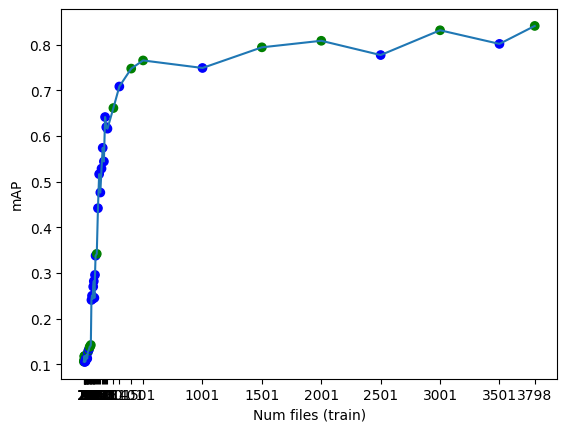

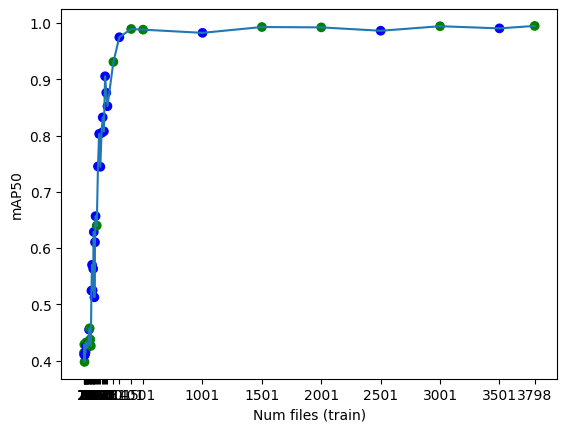

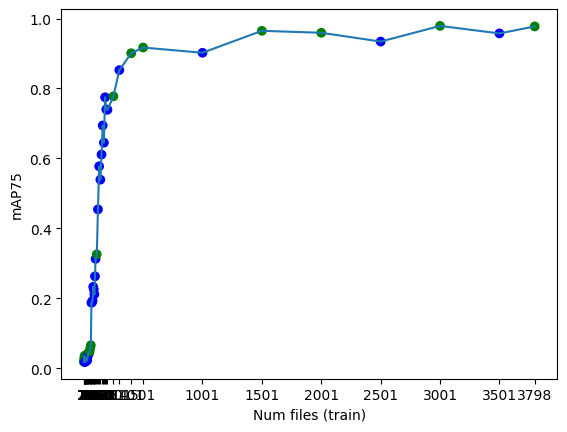

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=No

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_0_1/train/labels... 2 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2/2 [00:00<00:00, 2744.07it/s]

train: New cache created: /kaggle/working/feet-14/temp_0_1/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:01<00:00, 420.15it/s]

val: New cache created: /kaggle/working/feet-14/valid_0/labels.cache


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      5.17G     0.4137     0.5446      4.092     0.7996          5        640: 100%|██████████| 1/1 [00:00<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.33it/s]

                   all        474        474     0.0556     0.0274    0.00721    0.00645     0.0556     0.0274    0.00782    0.00682



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5       1.6G     0.5603     0.9723      5.248     0.9266          2        640: 100%|██████████| 1/1 [00:00<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]

                   all        474        474     0.0587     0.0295    0.00761    0.00688     0.0587     0.0295    0.00827    0.00726



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5       1.6G     0.5379      1.027      5.144     0.8972          2        640: 100%|██████████| 1/1 [00:00<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]

                   all        474        474     0.0479      0.038    0.00783    0.00708     0.0479      0.038    0.00855    0.00747



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      1.62G     0.4629     0.6506      4.298     0.9933          5        640: 100%|██████████| 1/1 [00:00<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]

                   all        474        474     0.0462     0.0443    0.00811     0.0074     0.0418     0.0506    0.00887     0.0077



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      1.61G     0.7983      1.786      5.033      0.941          2        640: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]

                   all        474        474    0.00342      0.167    0.00815    0.00732    0.00416      0.203    0.00881    0.00756



5 epochs completed in 0.019 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.18it/s]


                   all        474        474     0.0468     0.0443    0.00814    0.00742     0.0423     0.0506    0.00888    0.00772
                  card        474        474     0.0468     0.0443    0.00814    0.00742     0.0423     0.0506    0.00888    0.00772
Speed: 0.7ms preprocess, 13.0ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁▄▆██
wandb:        metrics/mAP50(M) ▁▄▆██
wandb:     metrics/mAP50-95(B) ▁▄▆██
wandb:     metrics/mAP50-95(M) ▁▄▆██
wandb:    metrics/precision(B) ▆█▂▁▁
wandb:    metrics/precision(M) ▇█▄▁▁
wandb:       metrics/recall(B) ▁▂▅██
wandb:       metrics/recall(M) ▁▂▄██
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▁▄▃▂█
wandb:          train/cls_loss ▁█▇▂▇
wandb:          train/dfl_loss ▁▆▅█▆
wandb:          train/seg_loss ▁▃▄▂█
wandb:            val/box_loss █▄▃▃▁
wandb:            val/cls_loss █▆▄▁▁
wandb:            val/dfl_loss ▃▁▂█▇
wandb:            val/seg_loss █▃▂▁▇
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:01<00:00, 453.88it/s]

val: New cache created: /kaggle/working/feet-14/test_0/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:21<00:00,  1.43it/s]


                   all        476        476      0.217     0.0168     0.0171     0.0153      0.217     0.0168     0.0182     0.0158
                  card        476        476      0.217     0.0168     0.0171     0.0153      0.217     0.0168     0.0182     0.0158
Speed: 0.8ms preprocess, 29.5ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, spl

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_0_2/train/labels... 2 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2/2 [00:00<00:00, 892.98it/s]

train: New cache created: /kaggle/working/feet-14/temp_0_2/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.56G     0.5863      2.101      4.178     0.9314          6        640: 100%|██████████| 1/1 [00:00<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.35it/s]

                   all        474        474    0.00353      0.285    0.00801    0.00693    0.00418      0.338    0.00875    0.00729



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      1.58G     0.4728      2.258      5.596     0.8752          2        640: 100%|██████████| 1/1 [00:00<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]

                   all        474        474    0.00498      0.624    0.00779    0.00667    0.00523      0.656    0.00842     0.0071



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      1.47G     0.4417       1.37      4.928     0.9709          2        640: 100%|██████████| 1/1 [00:00<00:00,  5.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.38it/s]

                   all        474        474    0.00492      0.618     0.0078    0.00661     0.0052      0.654    0.00863    0.00706



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      1.47G     0.4446      2.388      4.702     0.9255          3        640: 100%|██████████| 1/1 [00:00<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]

                   all        474        474    0.00475      0.597    0.00731    0.00615    0.00504      0.633    0.00806    0.00665



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      1.47G     0.7497      2.756      5.658     0.9983          3        640: 100%|██████████| 1/1 [00:00<00:00,  6.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.37it/s]

                   all        474        474    0.00465      0.586    0.00683    0.00575    0.00495      0.624    0.00752    0.00616



5 epochs completed in 0.019 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.16it/s]


                   all        474        474    0.00372      0.403    0.00794    0.00682    0.00417      0.451    0.00858    0.00716
                  card        474        474    0.00372      0.403    0.00794    0.00682    0.00417      0.451    0.00858    0.00716
Speed: 0.7ms preprocess, 13.0ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) █▆▆▁▇
wandb:        metrics/mAP50(M) █▅▇▁▆
wandb:     metrics/mAP50-95(B) █▆▅▁▇
wandb:     metrics/mAP50-95(M) █▆▅▁▇
wandb:    metrics/precision(B) ▁██▇▂
wandb:    metrics/precision(M) ▁██▇▁
wandb:       metrics/recall(B) ▁██▇▃
wandb:       metrics/recall(M) ▁██▇▄
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▄▂▁▁█
wandb:          train/cls_loss ▁█▅▃█
wandb:          train/dfl_loss ▄▁▆▄█
wandb:          train/seg_loss ▅▅▁▆█
wandb:            val/box_loss ▁▄▆▇█
wandb:            val/cls_loss ▅▁▁▅█
wandb:            val/dfl_loss ▁▄▆▇█
wandb:            val/seg_loss ▁▅▇▅█
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:21<00:00,  1.39it/s]


                   all        476        476      0.158     0.0168     0.0145     0.0129      0.166     0.0189     0.0155     0.0132
                  card        476        476      0.158     0.0168     0.0145     0.0129      0.166     0.0189     0.0155     0.0132
Speed: 1.0ms preprocess, 29.2ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/retrain/train/labels... 4 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4/4 [00:00<00:00, 5880.55it/s]

train: New cache created: /kaggle/working/feet-14/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.48G     0.3291     0.7332      4.346     0.8395          7        640: 100%|██████████| 1/1 [00:00<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.33it/s]

                   all        474        474      0.051     0.0274    0.00708    0.00625      0.051     0.0274     0.0076    0.00663



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      2.98G     0.5857      3.416      6.981     0.9773          2        640: 100%|██████████| 1/1 [00:00<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.37it/s]

                   all        474        474      0.046     0.0401    0.00726    0.00647      0.046     0.0401    0.00773    0.00674



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      2.98G     0.5154      1.033      4.558     0.9653          5        640: 100%|██████████| 1/1 [00:00<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]

                   all        474        474      0.034     0.0485    0.00745    0.00648      0.034     0.0485    0.00799    0.00679



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      2.88G     0.4068      1.305      4.167     0.9127          6        640: 100%|██████████| 1/1 [00:00<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.43it/s]

                   all        474        474     0.0145     0.0717    0.00752    0.00669     0.0166     0.0823    0.00815    0.00699



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      2.88G     0.4444      1.035      4.513     0.9579          6        640: 100%|██████████| 1/1 [00:00<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]

                   all        474        474    0.00495      0.139    0.00825    0.00737    0.00622      0.175    0.00901     0.0078



5 epochs completed in 0.020 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.17it/s]


                   all        474        474    0.00488      0.137    0.00827    0.00735    0.00624      0.175    0.00903     0.0078
                  card        474        474    0.00488      0.137    0.00827    0.00735    0.00624      0.175    0.00903     0.0078
Speed: 0.8ms preprocess, 13.1ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁▂▃▄█
wandb:        metrics/mAP50(M) ▁▂▃▄█
wandb:     metrics/mAP50-95(B) ▁▂▂▄█
wandb:     metrics/mAP50-95(M) ▁▂▂▃█
wandb:    metrics/precision(B) █▇▅▂▁
wandb:    metrics/precision(M) █▇▅▃▁
wandb:       metrics/recall(B) ▁▂▂▄█
wandb:       metrics/recall(M) ▁▂▂▄█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▁█▆▃▄
wandb:          train/cls_loss ▁█▂▁▂
wandb:          train/dfl_loss ▁█▇▅▇
wandb:          train/seg_loss ▁█▂▂▂
wandb:            val/box_loss █▇▇▄▁
wandb:            val/cls_loss ██▇▆▁
wandb:            val/dfl_loss ▁▃█▇▇
wandb:            val/seg_loss ▃▄▄█▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:21<00:00,  1.41it/s]


                   all        476        476      0.178     0.0147     0.0167     0.0148      0.178     0.0147      0.018     0.0156
                  card        476        476      0.178     0.0147     0.0167     0.0148      0.178     0.0147      0.018     0.0156
Speed: 0.8ms preprocess, 29.7ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, spl

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_0_3/train/labels... 2 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2/2 [00:00<00:00, 494.12it/s]

train: New cache created: /kaggle/working/feet-14/temp_0_3/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      5.98G     0.4191     0.8633      4.213     0.9761          5        640: 100%|██████████| 1/1 [00:00<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.33it/s]

                   all        474        474    0.00521      0.654    0.00829    0.00714    0.00543      0.681    0.00905    0.00752



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      1.59G     0.5508     0.3445      4.157     0.9174          3        640: 100%|██████████| 1/1 [00:00<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]

                   all        474        474    0.00518      0.654    0.00811    0.00697    0.00539      0.679    0.00877     0.0073



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      1.48G     0.3947     0.6378       4.46     0.8268          2        640: 100%|██████████| 1/1 [00:00<00:00,  5.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]

                   all        474        474    0.00512      0.648    0.00792    0.00663     0.0053      0.671    0.00868    0.00713



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      1.47G     0.5157     0.8983      4.215     0.8648          3        640: 100%|██████████| 1/1 [00:00<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]

                   all        474        474    0.00506      0.641    0.00785    0.00647    0.00527      0.669    0.00867     0.0071



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      1.48G     0.7562     0.5878      4.966      1.027          2        640: 100%|██████████| 1/1 [00:00<00:00,  6.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]

                   all        474        474    0.00474      0.584    0.00753    0.00621    0.00497      0.614    0.00833    0.00661



5 epochs completed in 0.019 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.17it/s]


                   all        474        474    0.00519      0.652    0.00826    0.00711    0.00541      0.679    0.00904    0.00749
                  card        474        474    0.00519      0.652    0.00826    0.00711    0.00541      0.679    0.00904    0.00749
Speed: 0.8ms preprocess, 13.0ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) █▅▂▁▇
wandb:        metrics/mAP50(M) █▃▁▁█
wandb:     metrics/mAP50-95(B) █▆▃▁█
wandb:     metrics/mAP50-95(M) █▄▁▁█
wandb:    metrics/precision(B) █▇▄▁▇
wandb:    metrics/precision(M) █▆▂▁▇
wandb:       metrics/recall(B) ██▅▁▇
wandb:       metrics/recall(M) █▇▂▁▇
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▁▄▁▃█
wandb:          train/cls_loss ▁▁▄▂█
wandb:          train/dfl_loss ▆▄▁▂█
wandb:          train/seg_loss █▁▅█▄
wandb:            val/box_loss █▅▃▃▁
wandb:            val/cls_loss ▁▃▄▆█
wandb:            val/dfl_loss ▁▂▄▇█
wandb:            val/seg_loss ▁▂▃▆█
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:20<00:00,  1.43it/s]


                   all        476        476      0.125     0.0252     0.0146     0.0131      0.125     0.0252     0.0159     0.0134
                  card        476        476      0.125     0.0252     0.0146     0.0131      0.125     0.0252     0.0159     0.0134
Speed: 0.7ms preprocess, 29.0ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/retrain/train/labels... 6 images, 0 backgrounds, 0 corrupt: 100%|██████████| 6/6 [00:00<00:00, 809.82it/s]

train: New cache created: /kaggle/working/feet-14/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      5.68G     0.6254       1.87       4.18     0.9303         12        640: 100%|██████████| 1/1 [00:00<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.29it/s]

                   all        474        474     0.0477     0.0232    0.00702    0.00621     0.0477     0.0232     0.0075    0.00654



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.02G     0.4972      1.669       5.04     0.8398          6        640: 100%|██████████| 1/1 [00:00<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.36it/s]

                   all        474        474     0.0448     0.0401    0.00704    0.00619     0.0448     0.0401    0.00757     0.0065



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      3.88G     0.9765      2.924      5.641     0.9775          6        640: 100%|██████████| 1/1 [00:00<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]

                   all        474        474     0.0178     0.0549    0.00702    0.00614     0.0191     0.0591    0.00741    0.00638



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      3.88G     0.6199      2.309      4.645     0.9317          7        640: 100%|██████████| 1/1 [00:00<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.43it/s]

                   all        474        474    0.00561     0.0907    0.00708    0.00621     0.0077      0.124    0.00766    0.00647



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.88G     0.6974      2.635      5.784     0.9488          5        640: 100%|██████████| 1/1 [00:00<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]

                   all        474        474    0.00319      0.333     0.0067    0.00585    0.00375      0.392    0.00747    0.00628



5 epochs completed in 0.019 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:13<00:00,  1.08it/s]


                   all        474        474     0.0477     0.0232      0.007    0.00621     0.0504     0.0274    0.00748    0.00652
                  card        474        474     0.0477     0.0232      0.007    0.00621     0.0504     0.0274    0.00748    0.00652
Speed: 0.8ms preprocess, 13.2ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▃▅▃█▁
wandb:        metrics/mAP50(M) ▄▅▁█▃
wandb:     metrics/mAP50-95(B) █▆▁██
wandb:     metrics/mAP50-95(M) █▆▁▅▇
wandb:    metrics/precision(B) ██▃▁█
wandb:    metrics/precision(M) █▇▃▁█
wandb:       metrics/recall(B) ▁▃▄█▁
wandb:       metrics/recall(M) ▁▂▃█▁
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▃▁█▃▄
wandb:          train/cls_loss ▁▅▇▃█
wandb:          train/dfl_loss ▆▁█▆▇
wandb:          train/seg_loss ▂▁█▅▆
wandb:            val/box_loss ▁▆█▄▅
wandb:            val/cls_loss ▇▁█▁▄
wandb:            val/dfl_loss ▁▃▄▅█
wandb:            val/seg_loss ▁▄▅▆█
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:21<00:00,  1.42it/s]


                   all        476        476      0.154     0.0147     0.0136     0.0122      0.151     0.0147     0.0141     0.0125
                  card        476        476      0.154     0.0147     0.0136     0.0122      0.151     0.0147     0.0141     0.0125
Speed: 0.8ms preprocess, 29.4ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, spl

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_0_4/train/labels... 2 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2/2 [00:00<00:00, 526.53it/s]

train: New cache created: /kaggle/working/feet-14/temp_0_4/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.82G      0.286     0.7649      4.338     0.8343          5        640: 100%|██████████| 1/1 [00:00<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.33it/s]

                   all        474        474    0.00492      0.614    0.00717    0.00595    0.00519      0.648    0.00772    0.00626



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      1.59G     0.5328      1.333      5.488       1.08          2        640: 100%|██████████| 1/1 [00:00<00:00,  5.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]

                   all        474        474    0.00484      0.605     0.0072    0.00605    0.00509      0.637    0.00785    0.00646



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5       1.5G     0.8332      1.883      4.679      1.167          2        640: 100%|██████████| 1/1 [00:00<00:00,  5.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]

                   all        474        474    0.00484      0.608    0.00733    0.00601    0.00508      0.637    0.00787    0.00643



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      1.47G     0.4625     0.7377      5.661     0.8759          1        640: 100%|██████████| 1/1 [00:00<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]

                   all        474        474    0.00475      0.595    0.00674    0.00566    0.00507      0.635    0.00759    0.00595



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      1.48G     0.2333     0.6687      4.788     0.7846          2        640: 100%|██████████| 1/1 [00:00<00:00,  6.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]

                   all        474        474    0.00492      0.616    0.00742    0.00625    0.00526      0.658    0.00834    0.00657



5 epochs completed in 0.020 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.16it/s]


                   all        474        474    0.00494      0.618    0.00751    0.00631    0.00528       0.66    0.00838    0.00664
                  card        474        474    0.00494      0.618    0.00751    0.00631    0.00528       0.66    0.00838    0.00664
Speed: 0.8ms preprocess, 13.1ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▅▅▆▁█
wandb:        metrics/mAP50(M) ▂▃▃▁█
wandb:     metrics/mAP50-95(B) ▄▅▅▁█
wandb:     metrics/mAP50-95(M) ▄▆▆▁█
wandb:    metrics/precision(B) ▇▄▄▁█
wandb:    metrics/precision(M) ▅▂▁▁█
wandb:       metrics/recall(B) ▇▄▅▁█
wandb:       metrics/recall(M) ▅▂▂▁█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▂▄█▄▁
wandb:          train/cls_loss ▁▇▃█▃
wandb:          train/dfl_loss ▂▆█▃▁
wandb:          train/seg_loss ▂▅█▁▁
wandb:            val/box_loss ▁▂▅▇█
wandb:            val/cls_loss ██▇▅▁
wandb:            val/dfl_loss ▁▃▅▆█
wandb:            val/seg_loss ▁▃▅▆█
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:21<00:00,  1.42it/s]


                   all        476        476      0.128     0.0105      0.013     0.0115      0.121     0.0105     0.0148      0.012
                  card        476        476      0.128     0.0105      0.013     0.0115      0.121     0.0105     0.0148      0.012
Speed: 0.9ms preprocess, 29.3ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/retrain/train/labels... 8 images, 0 backgrounds, 0 corrupt: 100%|██████████| 8/8 [00:00<00:00, 2543.93it/s]

train: New cache created: /kaggle/working/feet-14/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.46G     0.4077      1.132      4.271     0.8447         13        640: 100%|██████████| 1/1 [00:01<00:00,  1.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.29it/s]

                   all        474        474     0.0561     0.0274    0.00704    0.00626     0.0561     0.0274    0.00764    0.00662



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.91G      0.514       1.49      4.764     0.9251         10        640: 100%|██████████| 1/1 [00:00<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.33it/s]

                   all        474        474     0.0499     0.0274    0.00724    0.00645     0.0499     0.0274    0.00785    0.00684



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.69G     0.3512      1.525      4.677     0.9161         10        640: 100%|██████████| 1/1 [00:00<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.37it/s]

                   all        474        474     0.0359     0.0401    0.00718    0.00629     0.0359     0.0401    0.00791     0.0066



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.69G     0.5479      2.507      4.264     0.9712         11        640: 100%|██████████| 1/1 [00:00<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]

                   all        474        474     0.0447     0.0401    0.00739    0.00646     0.0389     0.0443    0.00803     0.0068



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.69G     0.8441      1.688       5.42     0.9729          8        640: 100%|██████████| 1/1 [00:00<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]

                   all        474        474    0.00928     0.0844     0.0076    0.00641     0.0111      0.101    0.00823    0.00686



5 epochs completed in 0.021 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:14<00:00,  1.05it/s]


                   all        474        474    0.00929     0.0844    0.00754    0.00639     0.0112      0.101    0.00815    0.00679
                  card        474        474    0.00929     0.0844    0.00754    0.00639     0.0112      0.101    0.00815    0.00679
Speed: 1.1ms preprocess, 13.3ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁▄▃▆█
wandb:        metrics/mAP50(M) ▁▄▅▆█
wandb:     metrics/mAP50-95(B) ▁█▂█▆
wandb:     metrics/mAP50-95(M) ▂█▁▇▇
wandb:    metrics/precision(B) █▇▅▆▁
wandb:    metrics/precision(M) █▇▅▅▁
wandb:       metrics/recall(B) ▁▁▃▃█
wandb:       metrics/recall(M) ▁▁▂▃█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▂▃▁▄█
wandb:          train/cls_loss ▁▄▄▁█
wandb:          train/dfl_loss ▁▅▅██
wandb:          train/seg_loss ▁▃▃█▄
wandb:            val/box_loss ▅▅▁▄█
wandb:            val/cls_loss ██▇▁▃
wandb:            val/dfl_loss ▁▁▃▆█
wandb:            val/seg_loss ▁▁▅▅█
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:21<00:00,  1.42it/s]


                   all        476        476      0.184     0.0147     0.0149     0.0134      0.181     0.0147      0.016     0.0139
                  card        476        476      0.184     0.0147     0.0149     0.0134      0.181     0.0147      0.016     0.0139
Speed: 0.9ms preprocess, 29.4ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, spl

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_0_5/train/labels... 2 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2/2 [00:00<00:00, 4169.29it/s]

train: New cache created: /kaggle/working/feet-14/temp_0_5/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.53G     0.5517      1.125      4.265     0.8984          5        640: 100%|██████████| 1/1 [00:00<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.33it/s]

                   all        474        474    0.00465      0.184    0.00769    0.00644    0.00571      0.226    0.00832    0.00677



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      1.59G      0.848      1.314      4.931      1.034          3        640: 100%|██████████| 1/1 [00:00<00:00,  5.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]

                   all        474        474    0.00496       0.62    0.00731    0.00615     0.0052       0.65    0.00798    0.00656



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5       1.6G     0.5095      1.723      5.645      1.214          2        640: 100%|██████████| 1/1 [00:00<00:00,  6.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.38it/s]

                   all        474        474     0.0049      0.614    0.00719    0.00607    0.00516      0.646    0.00785    0.00642



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5       1.5G     0.6902      1.436      4.248     0.9581          5        640: 100%|██████████| 1/1 [00:00<00:00,  5.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]

                   all        474        474    0.00324      0.312    0.00698     0.0059     0.0039      0.376    0.00778    0.00631



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      1.47G     0.5012      1.035      5.197      1.103          2        640: 100%|██████████| 1/1 [00:00<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]

                   all        474        474    0.00398       0.46    0.00662    0.00564    0.00447      0.517    0.00727    0.00593



5 epochs completed in 0.019 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.18it/s]


                   all        474        474    0.00605      0.148     0.0077    0.00646    0.00718      0.175    0.00834    0.00678
                  card        474        474    0.00605      0.148     0.0077    0.00646    0.00718      0.175    0.00834    0.00678
Speed: 0.8ms preprocess, 13.0ms inference, 0.0ms loss, 3.3ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) █▄▃▁█
wandb:        metrics/mAP50(M) █▃▂▁█
wandb:     metrics/mAP50-95(B) █▄▃▁█
wandb:     metrics/mAP50-95(M) █▅▃▁█
wandb:    metrics/precision(B) ▅▅▅▁█
wandb:    metrics/precision(M) ▅▄▄▁█
wandb:       metrics/recall(B) ▂██▃▁
wandb:       metrics/recall(M) ▂██▄▁
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▂█▁▅▁
wandb:          train/cls_loss ▁▄█▁▆
wandb:          train/dfl_loss ▁▄█▂▆
wandb:          train/seg_loss ▂▄█▅▁
wandb:            val/box_loss ▁▂▅▆█
wandb:            val/cls_loss ▁▄▆▆█
wandb:            val/dfl_loss ▁▃▅▇█
wandb:            val/seg_loss ▁▁▄▆█
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:21<00:00,  1.40it/s]


                   all        476        476      0.113     0.0231      0.012     0.0104      0.113     0.0231     0.0129     0.0108
                  card        476        476      0.113     0.0231      0.012     0.0104      0.113     0.0231     0.0129     0.0108
Speed: 1.3ms preprocess, 29.3ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/retrain/train/labels... 10 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10/10 [00:00<00:00, 1925.58it/s]

train: New cache created: /kaggle/working/feet-14/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      5.35G     0.6294      1.575      4.206      0.955         19        640: 100%|██████████| 1/1 [00:00<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.30it/s]

                   all        474        474     0.0525     0.0232    0.00696    0.00618     0.0548     0.0274    0.00748    0.00649



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      5.42G     0.6208     0.8418      4.972     0.9828         12        640: 100%|██████████| 1/1 [00:00<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.35it/s]

                   all        474        474     0.0473     0.0359    0.00712    0.00635     0.0473     0.0359     0.0077    0.00668



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      5.32G      0.651      1.458      4.369     0.9377         18        640: 100%|██████████| 1/1 [00:00<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]

                   all        474        474     0.0315     0.0464    0.00708     0.0062     0.0233     0.0485    0.00744    0.00643



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      5.31G     0.5444      1.595      4.472     0.9991         13        640: 100%|██████████| 1/1 [00:00<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]

                   all        474        474    0.00908     0.0823    0.00696    0.00615     0.0112      0.101    0.00763    0.00642



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      5.32G     0.4582      1.011      4.513     0.9711         15        640: 100%|██████████| 1/1 [00:00<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]

                   all        474        474    0.00313      0.154    0.00679    0.00596    0.00394      0.194    0.00743    0.00629



5 epochs completed in 0.020 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:13<00:00,  1.14it/s]


                   all        474        474     0.0472     0.0359    0.00709    0.00633     0.0439     0.0401     0.0077    0.00668
                  card        474        474     0.0472     0.0359    0.00709    0.00633     0.0439     0.0401     0.0077    0.00668
Speed: 0.7ms preprocess, 13.1ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁█▆▁▇
wandb:        metrics/mAP50(M) ▂█▁▆█
wandb:     metrics/mAP50-95(B) ▂█▃▁▇
wandb:     metrics/mAP50-95(M) ▃█▁▁█
wandb:    metrics/precision(B) █▇▅▁▇
wandb:    metrics/precision(M) █▇▃▁▆
wandb:       metrics/recall(B) ▁▂▄█▂
wandb:       metrics/recall(M) ▁▂▃█▂
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▇▇█▄▁
wandb:          train/cls_loss ▁█▂▃▄
wandb:          train/dfl_loss ▃▆▁█▅
wandb:          train/seg_loss █▁▇█▃
wandb:            val/box_loss ▃▁▃█▇
wandb:            val/cls_loss ▁▁▄▄█
wandb:            val/dfl_loss ▂▁▄▇█
wandb:            val/seg_loss ▂▁▃▆█
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:21<00:00,  1.41it/s]


                   all        476        476      0.155     0.0147     0.0138     0.0124      0.155     0.0147     0.0143     0.0126
                  card        476        476      0.155     0.0147     0.0138     0.0124      0.155     0.0147     0.0143     0.0126
Speed: 0.7ms preprocess, 29.5ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, spl

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_0_6/train/labels... 3 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3/3 [00:00<00:00, 512.69it/s]

train: New cache created: /kaggle/working/feet-14/temp_0_6/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 3 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      6.04G     0.2882     0.9913      3.975     0.9683          6        640: 100%|██████████| 1/1 [00:00<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.35it/s]

                   all        474        474    0.00504      0.629    0.00735    0.00625    0.00529       0.66    0.00794    0.00665



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      2.16G     0.6895      1.335      4.842      1.159          4        640: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]

                   all        474        474    0.00494      0.618    0.00742    0.00627    0.00521      0.652    0.00807    0.00678



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      2.05G     0.3777     0.9131      4.706     0.9615          3        640: 100%|██████████| 1/1 [00:00<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]

                   all        474        474     0.0048      0.601    0.00734    0.00628    0.00505      0.633    0.00802    0.00668



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      2.05G       0.48      2.219      4.886     0.8662          3        640: 100%|██████████| 1/1 [00:00<00:00,  5.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]

                   all        474        474     0.0048      0.601    0.00747     0.0064    0.00507      0.635    0.00833    0.00689



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      2.06G     0.4879      2.552      3.815     0.8845          7        640: 100%|██████████| 1/1 [00:00<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]

                   all        474        474    0.00357      0.386    0.00699    0.00599    0.00415      0.449    0.00788     0.0064



5 epochs completed in 0.019 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.18it/s]


                   all        474        474    0.00474      0.578    0.00743    0.00635    0.00503      0.614    0.00823    0.00682
                  card        474        474    0.00474      0.578    0.00743    0.00635    0.00503      0.614    0.00823    0.00682
Speed: 0.8ms preprocess, 13.0ms inference, 0.0ms loss, 2.8ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▂▅▁█▆
wandb:        metrics/mAP50(M) ▁▃▂█▆
wandb:     metrics/mAP50-95(B) ▁▂▂█▆
wandb:     metrics/mAP50-95(M) ▁▅▂█▆
wandb:    metrics/precision(B) █▆▂▂▁
wandb:    metrics/precision(M) █▆▂▂▁
wandb:       metrics/recall(B) █▇▄▄▁
wandb:       metrics/recall(M) █▇▄▄▁
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▁█▃▄▄
wandb:          train/cls_loss ▂█▇█▁
wandb:          train/dfl_loss ▃█▃▁▁
wandb:          train/seg_loss ▁▃▁▇█
wandb:            val/box_loss ▁▄▅▆█
wandb:            val/cls_loss █▇▇▄▁
wandb:            val/dfl_loss ▁▄▅▆█
wandb:            val/seg_loss ▁▃▄▅█
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:21<00:00,  1.42it/s]


                   all        476        476      0.147     0.0167     0.0117     0.0102      0.149      0.021     0.0127     0.0107
                  card        476        476      0.147     0.0167     0.0117     0.0102      0.149      0.021     0.0127     0.0107
Speed: 0.8ms preprocess, 29.2ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/retrain/train/labels... 13 images, 0 backgrounds, 0 corrupt: 100%|██████████| 13/13 [00:00<00:00, 935.94it/s]

train: New cache created: /kaggle/working/feet-14/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      6.41G     0.3509     0.6639       4.52     0.8579         20        640: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.26it/s]

                   all        474        474     0.0523     0.0253    0.00698    0.00622     0.0508     0.0274     0.0076    0.00655



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5       7.2G     0.4186     0.7683      4.522     0.8552         18        640: 100%|██████████| 1/1 [00:00<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.36it/s]

                   all        474        474     0.0445     0.0401    0.00697    0.00608     0.0421      0.038    0.00738    0.00635



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      6.99G     0.4708      1.058      4.217     0.8871         22        640: 100%|██████████| 1/1 [00:00<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.37it/s]

                   all        474        474     0.0299     0.0443    0.00689    0.00604     0.0299     0.0443    0.00761    0.00633



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      6.99G     0.5531      1.691      4.517     0.9381         14        640: 100%|██████████| 1/1 [00:00<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]

                   all        474        474     0.0184     0.0591    0.00681    0.00593      0.021     0.0675    0.00753    0.00633



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5         7G     0.4792      1.139       4.43     0.8824         22        640: 100%|██████████| 1/1 [00:00<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]

                   all        474        474    0.00912     0.0844    0.00676    0.00595     0.0112      0.103    0.00751    0.00639



5 epochs completed in 0.020 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.16it/s]


                   all        474        474      0.056     0.0272    0.00696    0.00619     0.0508     0.0274    0.00758    0.00652
                  card        474        474      0.056     0.0272    0.00696    0.00619     0.0508     0.0274    0.00758    0.00652
Speed: 0.8ms preprocess, 13.1ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ██▄▁▇
wandb:        metrics/mAP50(M) █▁█▆▇
wandb:     metrics/mAP50-95(B) █▅▄▁▇
wandb:     metrics/mAP50-95(M) █▂▁▁▇
wandb:    metrics/precision(B) ▇▆▃▁█
wandb:    metrics/precision(M) █▆▃▁█
wandb:       metrics/recall(B) ▁▄▅█▁
wandb:       metrics/recall(M) ▁▃▄█▁
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▁▃▅█▅
wandb:          train/cls_loss ██▁█▆
wandb:          train/dfl_loss ▁▁▄█▃
wandb:          train/seg_loss ▁▂▄█▄
wandb:            val/box_loss ▁▁▄▇█
wandb:            val/cls_loss ▁▃█▁▁
wandb:            val/dfl_loss ▁▂▄▆█
wandb:            val/seg_loss ▁▂▄▆█
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:57<00:00,  1.93s/it]


                   all        476        476      0.145     0.0147     0.0131     0.0118      0.143     0.0147     0.0135      0.012
                  card        476        476      0.145     0.0147     0.0131     0.0118      0.143     0.0147     0.0135      0.012
Speed: 0.8ms preprocess, 29.2ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, spl

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_0_7/train/labels... 3 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3/3 [00:00<00:00, 892.15it/s]

train: New cache created: /kaggle/working/feet-14/temp_0_7/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 3 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.81G     0.7565      2.679      4.494       1.26          6        640: 100%|██████████| 1/1 [00:00<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.28it/s]

                   all        474        474    0.00504      0.629    0.00738     0.0062    0.00533      0.665    0.00797    0.00656



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      2.16G     0.5033     0.9727      4.912      1.122          3        640: 100%|██████████| 1/1 [00:00<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]

                   all        474        474    0.00505      0.631     0.0075    0.00631    0.00528       0.66    0.00804    0.00666



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      2.05G      0.707       2.15       4.87     0.9653          3        640: 100%|██████████| 1/1 [00:00<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]

                   all        474        474      0.005      0.627    0.00751    0.00631     0.0052      0.652    0.00809    0.00666



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      2.05G     0.6358      1.112      5.335      1.094          3        640: 100%|██████████| 1/1 [00:00<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.43it/s]

                   all        474        474    0.00493      0.618    0.00748    0.00642    0.00513      0.643    0.00822    0.00674



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      2.04G     0.3836       1.46      4.171     0.9555          6        640: 100%|██████████| 1/1 [00:00<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]

                   all        474        474    0.00488      0.614     0.0074    0.00636    0.00511      0.643    0.00812    0.00676



5 epochs completed in 0.020 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.16it/s]


                   all        474        474     0.0049      0.614    0.00745    0.00639    0.00512      0.641    0.00822    0.00673
                  card        474        474     0.0049      0.614    0.00745    0.00639    0.00512      0.641    0.00822    0.00673
Speed: 0.9ms preprocess, 13.1ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁▇█▆▅
wandb:        metrics/mAP50(M) ▁▃▄██
wandb:     metrics/mAP50-95(B) ▁▅▅█▇
wandb:     metrics/mAP50-95(M) ▁▅▅█▇
wandb:    metrics/precision(B) ██▆▂▁
wandb:    metrics/precision(M) █▆▄▁▁
wandb:       metrics/recall(B) ▇█▆▃▁
wandb:       metrics/recall(M) █▇▄▂▁
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▃▇▆▁
wandb:          train/cls_loss ▃▅▅█▁
wandb:          train/dfl_loss █▅▁▄▁
wandb:          train/seg_loss █▁▆▂▃
wandb:            val/box_loss ▁▃▄▆█
wandb:            val/cls_loss █▇▆▅▁
wandb:            val/dfl_loss ▁▃▅▆█
wandb:            val/seg_loss ▁▂▃▇█
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:21<00:00,  1.41it/s]


                   all        476        476     0.0945     0.0273     0.0124     0.0108     0.0945     0.0273     0.0132     0.0111
                  card        476        476     0.0945     0.0273     0.0124     0.0108     0.0945     0.0273     0.0132     0.0111
Speed: 0.8ms preprocess, 29.5ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/retrain/train/labels... 16 images, 0 backgrounds, 0 corrupt: 100%|██████████| 16/16 [00:00<00:00, 974.13it/s]

train: New cache created: /kaggle/working/feet-14/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      8.03G     0.4608      1.132      4.104     0.9663         27        640: 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.29it/s]

                   all        474        474     0.0505     0.0274    0.00697    0.00621     0.0505     0.0274    0.00759    0.00656



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      8.58G      0.403      1.212      4.997      0.956         17        640: 100%|██████████| 1/1 [00:00<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.35it/s]

                   all        474        474     0.0455     0.0401    0.00711     0.0062     0.0431      0.038    0.00749    0.00647



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      8.04G     0.5127      1.087      4.667     0.9561         23        640: 100%|██████████| 1/1 [00:00<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]

                   all        474        474      0.023     0.0464    0.00698    0.00615     0.0171     0.0527    0.00742    0.00638



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.04G     0.5881      1.282      4.647     0.9652         21        640: 100%|██████████| 1/1 [00:00<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]

                   all        474        474    0.00913     0.0823    0.00706     0.0062     0.0112      0.101    0.00772     0.0065



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      8.38G     0.5073      1.341       4.04     0.9324         27        640: 100%|██████████| 1/1 [00:00<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]

                   all        474        474    0.00255      0.188    0.00682    0.00606    0.00321      0.236    0.00755    0.00638



5 epochs completed in 0.020 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.17it/s]


                   all        474        474     0.0526     0.0253    0.00698    0.00624     0.0504     0.0274    0.00758    0.00657
                  card        474        474     0.0526     0.0253    0.00698    0.00624     0.0504     0.0274    0.00758    0.00657
Speed: 0.8ms preprocess, 13.0ms inference, 0.0ms loss, 3.1ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁█▂▆▁
wandb:        metrics/mAP50(M) ▅▃▁█▅
wandb:     metrics/mAP50-95(B) ▆▅▁▅█
wandb:     metrics/mAP50-95(M) █▄▁▅█
wandb:    metrics/precision(B) █▇▃▁█
wandb:    metrics/precision(M) █▇▂▁█
wandb:       metrics/recall(B) ▁▃▄█▁
wandb:       metrics/recall(M) ▁▂▃█▁
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▃▁▅█▅
wandb:          train/cls_loss ▁█▆▅▁
wandb:          train/dfl_loss █▆▆█▁
wandb:          train/seg_loss ▂▄▁▆█
wandb:            val/box_loss ▁▂▅▇█
wandb:            val/cls_loss ▁▂▄▃█
wandb:            val/dfl_loss ▁▁▄▆█
wandb:            val/seg_loss ▁▂▅▅█
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:21<00:00,  1.40it/s]


                   all        476        476      0.154     0.0147     0.0133      0.012      0.144     0.0147     0.0138     0.0122
                  card        476        476      0.154     0.0147     0.0133      0.012      0.144     0.0147     0.0138     0.0122
Speed: 0.8ms preprocess, 29.3ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, spl

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_0_8/train/labels... 3 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3/3 [00:00<00:00, 491.00it/s]

train: New cache created: /kaggle/working/feet-14/temp_0_8/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 3 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      5.99G     0.3749     0.7386       4.08     0.7357          6        640: 100%|██████████| 1/1 [00:00<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.32it/s]

                   all        474        474    0.00479       0.58    0.00709    0.00588    0.00508      0.616    0.00763    0.00619



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      2.16G     0.6838      2.497      4.093     0.8938          4        640: 100%|██████████| 1/1 [00:00<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]

                   all        474        474      0.005      0.627    0.00713    0.00598    0.00518       0.65    0.00763    0.00634



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      2.05G     0.4126     0.9271      4.356     0.9079          4        640: 100%|██████████| 1/1 [00:00<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]

                   all        474        474    0.00494       0.62    0.00696    0.00583    0.00514      0.646    0.00747    0.00614



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      2.06G     0.3614      1.155      4.502     0.8272          3        640: 100%|██████████| 1/1 [00:00<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]

                   all        474        474    0.00488      0.614    0.00668     0.0056     0.0051      0.641    0.00716    0.00591



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      2.04G      0.499     0.7776      4.024     0.9108          5        640: 100%|██████████| 1/1 [00:00<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]

                   all        474        474    0.00494      0.622    0.00695    0.00581    0.00517      0.652    0.00766     0.0062



5 epochs completed in 0.019 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.16it/s]


                   all        474        474    0.00496      0.622    0.00704    0.00591    0.00517      0.648    0.00755    0.00627
                  card        474        474    0.00496      0.622    0.00704    0.00591    0.00517      0.648    0.00755    0.00627
Speed: 0.8ms preprocess, 13.1ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▇█▅▁▇
wandb:        metrics/mAP50(M) ██▆▁▇
wandb:     metrics/mAP50-95(B) ▆█▅▁▇
wandb:     metrics/mAP50-95(M) ▆█▅▁▇
wandb:    metrics/precision(B) ▁█▆▄▇
wandb:    metrics/precision(M) ▁█▅▂▇
wandb:       metrics/recall(B) ▁█▇▆▇
wandb:       metrics/recall(M) ▁█▇▆█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▁█▂▁▄
wandb:          train/cls_loss ▂▂▆█▁
wandb:          train/dfl_loss ▁▇█▅█
wandb:          train/seg_loss ▁█▂▃▁
wandb:            val/box_loss ▁▂▂▅█
wandb:            val/cls_loss ▅▆▆█▁
wandb:            val/dfl_loss ▁▃▄▇█
wandb:            val/seg_loss ▁▄▄██
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:21<00:00,  1.40it/s]


                   all        476        476     0.0835     0.0273     0.0109    0.00949     0.0835     0.0273     0.0118    0.00985
                  card        476        476     0.0835     0.0273     0.0109    0.00949     0.0835     0.0273     0.0118    0.00985
Speed: 0.8ms preprocess, 29.6ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/retrain/train/labels... 19 images, 0 backgrounds, 0 corrupt: 100%|██████████| 19/19 [00:00<00:00, 880.12it/s]

train: New cache created: /kaggle/working/feet-14/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5       8.4G     0.5568      1.733      5.015     0.9191          2        640: 100%|██████████| 2/2 [00:01<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.27it/s]

                   all        474        474     0.0518     0.0232    0.00691    0.00622      0.051     0.0253    0.00753    0.00651



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      8.61G     0.4459      0.872      4.336     0.9391          4        640: 100%|██████████| 2/2 [00:00<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.35it/s]

                   all        474        474     0.0459     0.0274     0.0071    0.00631     0.0457     0.0313    0.00787    0.00665



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      8.49G     0.5122      1.637      3.995     0.9059          5        640: 100%|██████████| 2/2 [00:00<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]

                   all        474        474      0.012     0.0675     0.0068    0.00591     0.0138     0.0781    0.00748    0.00632



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5       8.5G     0.4988      1.006      4.459     0.8861          3        640: 100%|██████████| 2/2 [00:00<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.43it/s]

                   all        474        474     0.0731     0.0232     0.0136     0.0121    0.00619      0.743     0.0149     0.0129



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5       8.6G     0.7418      1.136      4.239       1.04          4        640: 100%|██████████| 2/2 [00:00<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]

                   all        474        474      0.168     0.0992     0.0496     0.0441      0.168     0.0992     0.0514     0.0451



5 epochs completed in 0.021 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.18it/s]


                   all        474        474      0.168     0.0992     0.0495      0.044      0.168     0.0992     0.0512      0.045
                  card        474        474      0.168     0.0992     0.0495      0.044      0.168     0.0992     0.0512      0.045
Speed: 0.7ms preprocess, 13.0ms inference, 0.0ms loss, 3.2ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▄
wandb:                  lr/pg2 ▁▆█▇▄
wandb:        metrics/mAP50(B) ▁▁▁▂█
wandb:        metrics/mAP50(M) ▁▁▁▂█
wandb:     metrics/mAP50-95(B) ▁▁▁▂█
wandb:     metrics/mAP50-95(M) ▁▁▁▂█
wandb:    metrics/precision(B) ▃▃▁▄█
wandb:    metrics/precision(M) ▃▃▁▁█
wandb:       metrics/recall(B) ▁▁▅▁█
wandb:       metrics/recall(M) ▁▁▂█▂
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▄▁▃▂█
wandb:          train/cls_loss █▃▁▄▃
wandb:          train/dfl_loss ▂▃▂▁█
wandb:          train/seg_loss █▁▇▂▃
wandb:            val/box_loss ▅▆█▄▁
wandb:            val/cls_loss ███▅▁
wandb:            val/dfl_loss ▅▆█▄▁
wandb:            val/seg_loss ▅▇█▃▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09119
wandb:          

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:21<00:00,  1.40it/s]


                   all        476        476      0.292     0.0336     0.0743     0.0679      0.292     0.0336     0.0773     0.0679
                  card        476        476      0.292     0.0336     0.0743     0.0679      0.292     0.0336     0.0773     0.0679
Speed: 0.8ms preprocess, 29.7ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, spl

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_0_9/train/labels... 3 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3/3 [00:00<00:00, 552.66it/s]

train: New cache created: /kaggle/working/feet-14/temp_0_9/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 3 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      6.15G     0.6292     0.9681      3.715     0.9476          6        640: 100%|██████████| 1/1 [00:00<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.34it/s]

                   all        474        474      0.114     0.0211     0.0588     0.0518      0.114     0.0211     0.0606     0.0521



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      2.16G     0.5943     0.8667      4.363      1.039          4        640: 100%|██████████| 1/1 [00:00<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]

                   all        474        474      0.139     0.0338     0.0577     0.0509      0.139     0.0338     0.0595     0.0513



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      2.05G     0.5091      1.109      3.711      0.943          4        640: 100%|██████████| 1/1 [00:00<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]

                   all        474        474       0.15     0.0506     0.0534     0.0468       0.15     0.0506     0.0546     0.0473



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      2.05G      1.032      1.239      4.265       1.17          3        640: 100%|██████████| 1/1 [00:00<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]

                   all        474        474      0.138     0.0852     0.0529     0.0465      0.138     0.0852     0.0543     0.0468



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      2.06G     0.4478      1.018      3.822     0.9812          7        640: 100%|██████████| 1/1 [00:00<00:00,  5.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]

                   all        474        474      0.127      0.162     0.0481     0.0421      0.127      0.162     0.0507     0.0425



5 epochs completed in 0.019 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.19it/s]


                   all        474        474      0.114     0.0211     0.0588     0.0518      0.122     0.0232     0.0606      0.052
                  card        474        474      0.114     0.0211     0.0588     0.0518      0.122     0.0232     0.0606      0.052
Speed: 0.8ms preprocess, 13.0ms inference, 0.0ms loss, 3.1ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) █▇▂▁█
wandb:        metrics/mAP50(M) █▇▁▁█
wandb:     metrics/mAP50-95(B) █▇▁▁█
wandb:     metrics/mAP50-95(M) █▇▂▁█
wandb:    metrics/precision(B) ▁▆█▆▁
wandb:    metrics/precision(M) ▁▆█▆▂
wandb:       metrics/recall(B) ▁▂▄█▁
wandb:       metrics/recall(M) ▁▂▄█▁
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▃▃▂█▁
wandb:          train/cls_loss ▁█▁▇▂
wandb:          train/dfl_loss ▁▄▁█▂
wandb:          train/seg_loss ▃▁▆█▄
wandb:            val/box_loss ▁██▃▅
wandb:            val/cls_loss ▁▂▇▄█
wandb:            val/dfl_loss ▁▅▅▆█
wandb:            val/seg_loss ▁▅▅▇█
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:21<00:00,  1.40it/s]


                   all        476        476      0.223      0.042     0.0736     0.0655      0.223      0.042     0.0748     0.0647
                  card        476        476      0.223      0.042     0.0736     0.0655      0.223      0.042     0.0748     0.0647
Speed: 1.0ms preprocess, 29.6ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/retrain/train/labels... 22 images, 0 backgrounds, 0 corrupt: 100%|██████████| 22/22 [00:00<00:00, 1096.55it/s]

train: New cache created: /kaggle/working/feet-14/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      7.97G     0.5298      1.394      4.582     0.9618          5        640: 100%|██████████| 2/2 [00:01<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.29it/s]

                   all        474        474     0.0473     0.0316    0.00698    0.00622     0.0442     0.0295    0.00757    0.00656



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      8.48G     0.5561      1.115      4.362     0.9806          7        640: 100%|██████████| 2/2 [00:01<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.34it/s]

                   all        474        474    0.00596     0.0992    0.00701    0.00616    0.00711      0.118    0.00757    0.00646



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      8.47G     0.5195       1.03      3.948     0.9131         10        640: 100%|██████████| 2/2 [00:00<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]

                   all        474        474    0.00605      0.722     0.0122     0.0108    0.00619      0.738     0.0132     0.0113



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.44G     0.5346      1.049      4.278     0.9241          8        640: 100%|██████████| 2/2 [00:00<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.43it/s]

                   all        474        474    0.00646      0.774     0.0307     0.0274    0.00666      0.797     0.0321      0.028



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      8.52G     0.4459     0.9759      3.791     0.8866         13        640: 100%|██████████| 2/2 [00:00<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]

                   all        474        474       0.34     0.0684      0.178      0.159      0.351     0.0743      0.178      0.156



5 epochs completed in 0.021 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.20it/s]


                   all        474        474      0.339     0.0681      0.178      0.159      0.339     0.0681      0.178      0.157
                  card        474        474      0.339     0.0681      0.178      0.159      0.339     0.0681      0.178      0.157
Speed: 0.6ms preprocess, 13.1ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▄
wandb:                  lr/pg2 ▁▆█▇▄
wandb:        metrics/mAP50(B) ▁▁▁▂█
wandb:        metrics/mAP50(M) ▁▁▁▂█
wandb:     metrics/mAP50-95(B) ▁▁▁▂█
wandb:     metrics/mAP50-95(M) ▁▁▁▂█
wandb:    metrics/precision(B) ▂▁▁▁█
wandb:    metrics/precision(M) ▂▁▁▁█
wandb:       metrics/recall(B) ▁▂██▁
wandb:       metrics/recall(M) ▁▂▇█▁
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▆█▆▇▁
wandb:          train/cls_loss █▆▂▅▁
wandb:          train/dfl_loss ▇█▃▄▁
wandb:          train/seg_loss █▃▂▂▁
wandb:            val/box_loss ▇██▅▁
wandb:            val/cls_loss ██▇▅▁
wandb:            val/dfl_loss ▇█▇▄▁
wandb:            val/seg_loss ▆█▇▅▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09119
wandb:          

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:21<00:00,  1.42it/s]


                   all        476        476      0.416      0.063      0.201      0.184      0.416      0.063      0.203       0.18
                  card        476        476      0.416      0.063      0.201      0.184      0.416      0.063      0.203       0.18
Speed: 0.8ms preprocess, 29.7ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, spl

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_0_10/train/labels... 3 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3/3 [00:00<00:00, 584.84it/s]

train: New cache created: /kaggle/working/feet-14/temp_0_10/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 3 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      6.05G     0.7694      1.448      3.894      1.195          6        640: 100%|██████████| 1/1 [00:00<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.35it/s]

                   all        474        474      0.354     0.0878      0.172      0.152      0.354     0.0878      0.172       0.15



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      2.16G     0.5154      3.254      4.401      1.044          3        640: 100%|██████████| 1/1 [00:00<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.43it/s]

                   all        474        474      0.358      0.094      0.168      0.149      0.358      0.094      0.168      0.147



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      2.16G     0.7063      3.095       4.16      1.017          4        640: 100%|██████████| 1/1 [00:00<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]

                   all        474        474      0.368      0.101      0.166      0.147      0.368      0.101      0.166      0.144



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      2.04G     0.6322      1.417       4.56     0.9808          3        640: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]

                   all        474        474      0.362     0.0969      0.161      0.142      0.362     0.0969      0.161       0.14



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      2.04G      0.549      1.005      4.541     0.9397          4        640: 100%|██████████| 1/1 [00:00<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]

                   all        474        474      0.369      0.105      0.171      0.151      0.369      0.105      0.171      0.149



5 epochs completed in 0.019 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.19it/s]


                   all        474        474       0.35     0.0874      0.172      0.153       0.35     0.0874      0.172       0.15
                  card        474        474       0.35     0.0874      0.172      0.153       0.35     0.0874      0.172       0.15
Speed: 0.6ms preprocess, 13.3ms inference, 0.0ms loss, 3.0ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) █▆▄▁█
wandb:        metrics/mAP50(M) █▅▄▁█
wandb:     metrics/mAP50-95(B) █▆▄▁█
wandb:     metrics/mAP50-95(M) █▆▄▁█
wandb:    metrics/precision(B) ▃▄█▆▁
wandb:    metrics/precision(M) ▃▄█▆▁
wandb:       metrics/recall(B) ▁▄█▆▁
wandb:       metrics/recall(M) ▁▄█▆▁
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▁▆▄▂
wandb:          train/cls_loss ▁▆▄██
wandb:          train/dfl_loss █▄▃▂▁
wandb:          train/seg_loss ▂██▂▁
wandb:            val/box_loss █▇▅▃▁
wandb:            val/cls_loss ▅▆▇█▁
wandb:            val/dfl_loss ▁▃▆██
wandb:            val/seg_loss ▁▅▇▇█
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:21<00:00,  1.40it/s]


                   all        476        476      0.414      0.116       0.18      0.162      0.414      0.116      0.181      0.158
                  card        476        476      0.414      0.116       0.18      0.162      0.414      0.116      0.181      0.158
Speed: 1.2ms preprocess, 29.2ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/retrain/train/labels... 25 images, 0 backgrounds, 0 corrupt: 100%|██████████| 25/25 [00:00<00:00, 1245.67it/s]

train: New cache created: /kaggle/working/feet-14/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      8.08G     0.6693      1.561      4.619      0.963          9        640: 100%|██████████| 2/2 [00:01<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.26it/s]

                   all        474        474      0.046     0.0295    0.00677    0.00608     0.0427     0.0274    0.00735     0.0064



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      8.58G     0.6048      1.315      4.573     0.9997         10        640: 100%|██████████| 2/2 [00:01<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.35it/s]


                   all        474        474     0.0162     0.0527    0.00704    0.00627     0.0182     0.0591    0.00771    0.00647

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      8.49G     0.5957      1.086      4.214     0.9035         17        640: 100%|██████████| 2/2 [00:01<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]

                   all        474        474    0.00601      0.101    0.00698    0.00616    0.00727      0.122    0.00753    0.00652



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.48G     0.5444      1.471      4.259     0.9894         17        640: 100%|██████████| 2/2 [00:01<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]

                   all        474        474    0.00506       0.53     0.0193     0.0171    0.00547      0.572     0.0211      0.018



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      8.27G     0.6096       1.06      4.171     0.9769         15        640: 100%|██████████| 2/2 [00:01<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]

                   all        474        474        0.2     0.0501       0.11     0.0984        0.2     0.0501      0.112     0.0978



5 epochs completed in 0.022 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:13<00:00,  1.12it/s]


                   all        474        474      0.219     0.0591       0.11     0.0981      0.219     0.0591      0.112     0.0976
                  card        474        474      0.219     0.0591       0.11     0.0981      0.219     0.0591      0.112     0.0976
Speed: 0.9ms preprocess, 13.2ms inference, 0.0ms loss, 3.3ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▄
wandb:                  lr/pg2 ▁▆█▇▄
wandb:        metrics/mAP50(B) ▁▁▁▂█
wandb:        metrics/mAP50(M) ▁▁▁▂█
wandb:     metrics/mAP50-95(B) ▁▁▁▂█
wandb:     metrics/mAP50-95(M) ▁▁▁▂█
wandb:    metrics/precision(B) ▂▁▁▁█
wandb:    metrics/precision(M) ▂▁▁▁█
wandb:       metrics/recall(B) ▁▁▂█▁
wandb:       metrics/recall(M) ▁▁▂█▁
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▄▄▁▅
wandb:          train/cls_loss █▇▂▂▁
wandb:          train/dfl_loss ▅█▁▇▆
wandb:          train/seg_loss █▅▁▇▁
wandb:            val/box_loss ▆▇█▄▁
wandb:            val/cls_loss ███▅▁
wandb:            val/dfl_loss ▆▇█▄▁
wandb:            val/seg_loss ▆▇█▄▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09119
wandb:          

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:21<00:00,  1.40it/s]


                   all        476        476      0.344     0.0483      0.129      0.118      0.344     0.0483      0.131      0.117
                  card        476        476      0.344     0.0483      0.129      0.118      0.344     0.0483      0.131      0.117
Speed: 1.0ms preprocess, 29.8ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, spl

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_0_11/train/labels... 3 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3/3 [00:00<00:00, 860.90it/s]

train: New cache created: /kaggle/working/feet-14/temp_0_11/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 3 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.96G     0.6703     0.7011      3.732     0.8133          6        640: 100%|██████████| 1/1 [00:00<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.35it/s]

                   all        474        474      0.186     0.0359      0.108     0.0952      0.207     0.0414      0.109     0.0941



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      2.16G     0.9936      1.194        5.2      1.028          2        640: 100%|██████████| 1/1 [00:00<00:00,  4.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]

                   all        474        474       0.23     0.0612      0.102     0.0898       0.23     0.0612      0.103     0.0893



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      2.16G     0.6788     0.8684      3.808     0.9256          4        640: 100%|██████████| 1/1 [00:00<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]

                   all        474        474       0.22     0.0928     0.0964     0.0854       0.22     0.0928     0.0981      0.085



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      2.06G     0.5021     0.7338      5.449     0.7685          2        640: 100%|██████████| 1/1 [00:00<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]

                   all        474        474       0.21      0.116     0.0934     0.0831       0.21      0.116     0.0953     0.0827



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      2.05G     0.6124       1.16      4.095      1.053          4        640: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]

                   all        474        474       0.22       0.12     0.0947     0.0841       0.22       0.12     0.0959     0.0837



5 epochs completed in 0.019 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.17it/s]


                   all        474        474      0.179     0.0338      0.107     0.0943      0.179     0.0338      0.108     0.0936
                  card        474        474      0.179     0.0338      0.107     0.0943      0.179     0.0338      0.108     0.0936
Speed: 0.9ms preprocess, 13.0ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) █▅▂▁█
wandb:        metrics/mAP50(M) █▅▂▁█
wandb:     metrics/mAP50-95(B) █▅▂▁▇
wandb:     metrics/mAP50-95(M) █▅▂▁█
wandb:    metrics/precision(B) ▂█▇▅▁
wandb:    metrics/precision(M) ▅█▇▅▁
wandb:       metrics/recall(B) ▁▃▆█▁
wandb:       metrics/recall(M) ▂▃▆█▁
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▃█▄▁▃
wandb:          train/cls_loss ▁▇▁█▂
wandb:          train/dfl_loss ▂▇▅▁█
wandb:          train/seg_loss ▁█▃▁█
wandb:            val/box_loss ██▆▄▁
wandb:            val/cls_loss ▇▇█▅▁
wandb:            val/dfl_loss ▁▄▆█▇
wandb:            val/seg_loss ▁▄▆█▆
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:21<00:00,  1.40it/s]


                   all        476        476        0.3     0.0659      0.119      0.107        0.3     0.0659       0.12      0.105
                  card        476        476        0.3     0.0659      0.119      0.107        0.3     0.0659       0.12      0.105
Speed: 1.4ms preprocess, 29.1ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/retrain/train/labels... 28 images, 0 backgrounds, 0 corrupt: 100%|██████████| 28/28 [00:00<00:00, 1199.65it/s]

train: New cache created: /kaggle/working/feet-14/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5       8.4G     0.5641      1.351       4.72     0.9599         14        640: 100%|██████████| 2/2 [00:01<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.26it/s]

                   all        474        474     0.0439     0.0274    0.00707    0.00632      0.042     0.0316     0.0076    0.00664



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      8.59G     0.5725      1.663      4.398      1.018         16        640: 100%|██████████| 2/2 [00:01<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.37it/s]

                   all        474        474     0.0231     0.0506    0.00705     0.0063      0.025     0.0549    0.00765    0.00657



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      8.48G     0.4882      1.281      4.262     0.8987         23        640: 100%|██████████| 2/2 [00:01<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]

                   all        474        474    0.00299       0.15    0.00694    0.00611    0.00387      0.194    0.00761    0.00652



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.19G     0.6025      1.284      4.518     0.9794         20        640: 100%|██████████| 2/2 [00:01<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.28it/s]

                   all        474        474    0.00638      0.764     0.0201     0.0178    0.00656      0.785     0.0222     0.0188



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      8.28G     0.5192      1.077      3.721     0.9244         23        640: 100%|██████████| 2/2 [00:01<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]

                   all        474        474      0.296     0.0701      0.147      0.131      0.296     0.0701      0.148       0.13



5 epochs completed in 0.021 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.21it/s]


                   all        474        474      0.298     0.0696      0.147      0.131      0.298     0.0696      0.148      0.129
                  card        474        474      0.298     0.0696      0.147      0.131      0.298     0.0696      0.148      0.129
Speed: 0.7ms preprocess, 13.2ms inference, 0.0ms loss, 2.9ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▄
wandb:                  lr/pg2 ▁▆█▇▄
wandb:        metrics/mAP50(B) ▁▁▁▂█
wandb:        metrics/mAP50(M) ▁▁▁▂█
wandb:     metrics/mAP50-95(B) ▁▁▁▂█
wandb:     metrics/mAP50-95(M) ▁▁▁▂█
wandb:    metrics/precision(B) ▂▁▁▁█
wandb:    metrics/precision(M) ▂▂▁▁█
wandb:       metrics/recall(B) ▁▁▂█▁
wandb:       metrics/recall(M) ▁▁▃█▁
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▆▆▁█▃
wandb:          train/cls_loss █▆▅▇▁
wandb:          train/dfl_loss ▅█▁▆▃
wandb:          train/seg_loss ▄█▃▃▁
wandb:            val/box_loss ▇▇█▄▁
wandb:            val/cls_loss ███▅▁
wandb:            val/dfl_loss ▆▇█▄▁
wandb:            val/seg_loss ▆▇█▄▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09119
wandb:          

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:21<00:00,  1.40it/s]


                   all        476        476      0.397     0.0609      0.172      0.157      0.397     0.0609      0.174      0.155
                  card        476        476      0.397     0.0609      0.172      0.157      0.397     0.0609      0.174      0.155
Speed: 1.1ms preprocess, 29.8ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs/segment/train
Progress for 10 last iterations with 0.001 threshold = 1.0885956703481299
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_0_12/train/labels... 3 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3/3 [00:00<00:00, 415.69it/s]

train: New cache created: /kaggle/working/feet-14/temp_0_12/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 3 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      5.06G     0.5581      1.159      3.301     0.8967          6        640: 100%|██████████| 1/1 [00:00<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.35it/s]

                   all        474        474       0.33     0.0864      0.149      0.132       0.33     0.0864       0.15      0.131



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      2.16G     0.5891      1.611      4.447      1.049          3        640: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.43it/s]

                   all        474        474      0.344     0.0865      0.149      0.131      0.344     0.0865      0.149       0.13



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      2.04G     0.6512      2.372      3.363     0.8713          4        640: 100%|██████████| 1/1 [00:00<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]

                   all        474        474      0.328     0.0886      0.141      0.125      0.328     0.0886      0.142      0.123



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      2.05G      0.501       1.67      4.278     0.9816          3        640: 100%|██████████| 1/1 [00:00<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]

                   all        474        474       0.31     0.0886      0.133      0.117       0.31     0.0886      0.134      0.116



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      2.04G     0.9509      1.259      3.375     0.9719          5        640: 100%|██████████| 1/1 [00:00<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.37it/s]

                   all        474        474       0.29     0.0869      0.124      0.109       0.29     0.0869      0.126      0.109



5 epochs completed in 0.019 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.19it/s]


                   all        474        474      0.326     0.0844      0.149      0.131      0.326     0.0844       0.15      0.131
                  card        474        474      0.326     0.0844      0.149      0.131      0.326     0.0844       0.15      0.131
Speed: 0.7ms preprocess, 13.0ms inference, 0.0ms loss, 3.2ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ██▅▁█
wandb:        metrics/mAP50(M) ██▅▁█
wandb:     metrics/mAP50-95(B) ██▅▁█
wandb:     metrics/mAP50-95(M) ██▄▁█
wandb:    metrics/precision(B) ▅█▅▁▄
wandb:    metrics/precision(M) ▅█▅▁▄
wandb:       metrics/recall(B) ▄▅██▁
wandb:       metrics/recall(M) ▄▅██▁
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▂▂▃▁█
wandb:          train/cls_loss ▁█▁▇▁
wandb:          train/dfl_loss ▂█▁▅▅
wandb:          train/seg_loss ▁▄█▄▂
wandb:            val/box_loss ▁▃▆▇█
wandb:            val/cls_loss ▁▁▃▇█
wandb:            val/dfl_loss ▁▃▅▆█
wandb:            val/seg_loss ▁▃▅▆█
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:21<00:00,  1.41it/s]


                   all        476        476      0.362     0.0987      0.157      0.141      0.362     0.0987      0.158      0.139
                  card        476        476      0.362     0.0987      0.157      0.141      0.362     0.0987      0.158      0.139
Speed: 1.2ms preprocess, 29.2ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/retrain/train/labels... 31 images, 0 backgrounds, 0 corrupt: 100%|██████████| 31/31 [00:00<00:00, 1057.58it/s]

train: New cache created: /kaggle/working/feet-14/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      8.31G     0.6175      1.274      4.686      1.003         17        640: 100%|██████████| 2/2 [00:01<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.29it/s]

                   all        474        474     0.0487     0.0274      0.007    0.00618     0.0426     0.0274    0.00754    0.00649



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      8.49G      0.649      1.153       4.56     0.9703         21        640: 100%|██████████| 2/2 [00:01<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.37it/s]

                   all        474        474     0.0231     0.0506    0.00712    0.00632     0.0251     0.0549    0.00772    0.00662



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      8.17G     0.5399       1.49      4.252     0.9525         23        640: 100%|██████████| 2/2 [00:01<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]

                   all        474        474     0.0091     0.0886    0.00692    0.00604    0.00722      0.122    0.00767    0.00652



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.18G     0.5417      1.114      4.227     0.9388         21        640: 100%|██████████| 2/2 [00:01<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.43it/s]

                   all        474        474     0.0703      0.253     0.0389     0.0347      0.072      0.259     0.0411     0.0353



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      8.17G       0.61      1.062      3.686     0.9598         38        640: 100%|██████████| 2/2 [00:01<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]

                   all        474        474      0.418     0.0653      0.231      0.206      0.418     0.0653      0.232      0.202



5 epochs completed in 0.022 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:14<00:00,  1.05it/s]


                   all        474        474      0.418     0.0651      0.232      0.206      0.418     0.0651      0.232      0.203
                  card        474        474      0.418     0.0651      0.232      0.206      0.418     0.0651      0.232      0.203
Speed: 0.8ms preprocess, 13.3ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▄
wandb:                  lr/pg2 ▁▆█▇▄
wandb:        metrics/mAP50(B) ▁▁▁▂█
wandb:        metrics/mAP50(M) ▁▁▁▂█
wandb:     metrics/mAP50-95(B) ▁▁▁▂█
wandb:     metrics/mAP50-95(M) ▁▁▁▂█
wandb:    metrics/precision(B) ▂▁▁▂█
wandb:    metrics/precision(M) ▂▁▁▂█
wandb:       metrics/recall(B) ▁▂▃█▂
wandb:       metrics/recall(M) ▁▂▄█▂
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▆█▁▁▅
wandb:          train/cls_loss █▇▅▅▁
wandb:          train/dfl_loss █▄▂▁▃
wandb:          train/seg_loss ▄▂█▂▁
wandb:            val/box_loss ▇▇█▄▁
wandb:            val/cls_loss ███▅▁
wandb:            val/dfl_loss ▆▇█▄▁
wandb:            val/seg_loss ▆▇█▄▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09119
wandb:          

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:21<00:00,  1.37it/s]


                   all        476        476      0.526      0.103      0.246      0.223      0.526      0.103      0.248       0.22
                  card        476        476      0.526      0.103      0.246      0.223      0.526      0.103      0.248       0.22
Speed: 0.8ms preprocess, 30.1ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs/segment/train
Progress for 10 last iterations with 0.001 threshold = 1.6064552928863145
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_0_13/train/labels... 5 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5/5 [00:00<00:00, 1231.01it/s]

train: New cache created: /kaggle/working/feet-14/temp_0_13/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5       6.2G     0.4885      1.657       3.34     0.8989          9        640: 100%|██████████| 1/1 [00:00<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.32it/s]

                   all        474        474        0.4      0.122      0.212      0.188        0.4      0.122      0.212      0.185



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      3.14G     0.6853      2.038      3.583     0.9713          9        640: 100%|██████████| 1/1 [00:00<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]

                   all        474        474      0.407      0.122      0.209      0.184      0.407      0.122      0.209      0.181



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      3.04G      0.462      1.527      4.427     0.9629          5        640: 100%|██████████| 1/1 [00:00<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]

                   all        474        474      0.403      0.127      0.208      0.184      0.403      0.127      0.209      0.181



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      3.02G     0.7042      1.638      3.998       1.01          7        640: 100%|██████████| 1/1 [00:00<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.43it/s]

                   all        474        474      0.395      0.124      0.201      0.178      0.395      0.124      0.202      0.175



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.03G     0.4496     0.9508      3.393     0.9593          9        640: 100%|██████████| 1/1 [00:00<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]

                   all        474        474       0.38      0.114       0.19      0.169       0.38      0.114      0.192      0.166



5 epochs completed in 0.019 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.16it/s]


                   all        474        474      0.404      0.123      0.212      0.187      0.404      0.123      0.211      0.184
                  card        474        474      0.404      0.123      0.212      0.187      0.404      0.123      0.211      0.184
Speed: 1.0ms preprocess, 13.1ms inference, 0.0ms loss, 2.9ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) █▆▅▁█
wandb:        metrics/mAP50(M) █▅▆▁█
wandb:     metrics/mAP50-95(B) █▆▆▁█
wandb:     metrics/mAP50-95(M) █▅▅▁█
wandb:    metrics/precision(B) ▄█▆▁▆
wandb:    metrics/precision(M) ▄█▆▁▆
wandb:       metrics/recall(B) ▂▁█▅▃
wandb:       metrics/recall(M) ▂▁█▅▃
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▂▇▁█▁
wandb:          train/cls_loss ▁▃█▅▁
wandb:          train/dfl_loss ▁▆▅█▅
wandb:          train/seg_loss ▆█▅▅▁
wandb:            val/box_loss █▃▅▁▄
wandb:            val/cls_loss ▄▃▁▁█
wandb:            val/dfl_loss ▁▂▄▄█
wandb:            val/seg_loss ▁▃▅▆█
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:21<00:00,  1.41it/s]


                   all        476        476      0.496      0.159      0.224      0.201      0.496      0.159      0.224      0.197
                  card        476        476      0.496      0.159      0.224      0.201      0.496      0.159      0.224      0.197
Speed: 0.9ms preprocess, 29.2ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/retrain/train/labels... 36 images, 0 backgrounds, 0 corrupt: 100%|██████████| 36/36 [00:00<00:00, 1085.39it/s]

train: New cache created: /kaggle/working/feet-14/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      8.31G     0.4435      1.176      4.588     0.9516          5        640: 100%|██████████| 3/3 [00:02<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.30it/s]

                   all        474        474     0.0233     0.0485    0.00679    0.00601     0.0233     0.0485    0.00724    0.00627



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      8.18G     0.5636      1.171      4.514     0.9443          5        640: 100%|██████████| 3/3 [00:01<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]

                   all        474        474     0.0599     0.0401     0.0095    0.00838     0.0534     0.0401     0.0107    0.00892



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      8.31G     0.4884       1.22      3.993     0.9687          8        640: 100%|██████████| 3/3 [00:01<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]

                   all        474        474      0.333     0.0862      0.157      0.141      0.333     0.0862      0.158       0.14



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.46G     0.4872     0.7561      3.066     0.9023          6        640: 100%|██████████| 3/3 [00:01<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]

                   all        474        474      0.864      0.817      0.899       0.81      0.858      0.814      0.896      0.791



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      8.46G     0.4928      1.077      2.291     0.9717          5        640: 100%|██████████| 3/3 [00:01<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]

                   all        474        474      0.914      0.892      0.954      0.864      0.904      0.888      0.949       0.84



5 epochs completed in 0.023 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:14<00:00,  1.01it/s]


                   all        474        474      0.916      0.892      0.954      0.864      0.911      0.888      0.949       0.84
                  card        474        474      0.916      0.892      0.954      0.864      0.911      0.888      0.949       0.84
Speed: 0.8ms preprocess, 13.5ms inference, 0.0ms loss, 3.1ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▃
wandb:                  lr/pg2 ▁▆█▇▃
wandb:        metrics/mAP50(B) ▁▁▂██
wandb:        metrics/mAP50(M) ▁▁▂██
wandb:     metrics/mAP50-95(B) ▁▁▂██
wandb:     metrics/mAP50-95(M) ▁▁▂██
wandb:    metrics/precision(B) ▁▁▃██
wandb:    metrics/precision(M) ▁▁▃██
wandb:       metrics/recall(B) ▁▁▁▇█
wandb:       metrics/recall(M) ▁▁▁▇█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▁█▄▄▄
wandb:          train/cls_loss ██▆▃▁
wandb:          train/dfl_loss ▆▅█▁█
wandb:          train/seg_loss ▇▇█▁▆
wandb:            val/box_loss ██▆▃▁
wandb:            val/cls_loss ██▆▂▁
wandb:            val/dfl_loss ██▄▁▁
wandb:            val/seg_loss ██▄▁▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.08629
wandb:          

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:21<00:00,  1.38it/s]


                   all        476        476       0.93      0.894      0.967      0.877       0.93      0.894      0.964      0.855
                  card        476        476       0.93      0.894      0.967      0.877       0.93      0.894      0.964      0.855
Speed: 1.0ms preprocess, 29.9ms inference, 0.0ms loss, 3.2ms postprocess per image
Results saved to runs/segment/train
Progress for 10 last iterations with 0.001 threshold = 7.744871037765154
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False,

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_0_14/train/labels... 5 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5/5 [00:00<00:00, 499.14it/s]

train: New cache created: /kaggle/working/feet-14/temp_0_14/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      5.98G     0.3726     0.6358      2.115     0.9063          8        640: 100%|██████████| 1/1 [00:00<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.29it/s]

                   all        474        474      0.892      0.858      0.941      0.843      0.897      0.848      0.931      0.819



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      3.13G     0.6395     0.9574      2.834     0.9879          6        640: 100%|██████████| 1/1 [00:00<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]

                   all        474        474      0.888      0.854      0.938      0.842      0.883       0.85      0.931      0.819



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      3.04G     0.3942     0.8837      2.222       0.86          5        640: 100%|██████████| 1/1 [00:00<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]

                   all        474        474      0.887      0.859      0.937      0.842      0.883      0.854      0.931      0.818



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      3.02G     0.3819      1.013      1.893     0.9284          5        640: 100%|██████████| 1/1 [00:00<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.45it/s]

                   all        474        474      0.888      0.857      0.936      0.841      0.884      0.853       0.93      0.817



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.02G     0.5322      0.981      1.885     0.8629          9        640: 100%|██████████| 1/1 [00:00<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]

                   all        474        474      0.891      0.854      0.935      0.839      0.887       0.85      0.929      0.816



5 epochs completed in 0.019 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.17it/s]


                   all        474        474      0.891      0.859      0.941      0.843      0.888       0.85      0.931      0.819
                  card        474        474      0.891      0.859      0.941      0.843      0.888       0.85      0.931      0.819
Speed: 0.8ms preprocess, 13.1ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) █▄▃▁█
wandb:        metrics/mAP50(M) ▆█▅▁█
wandb:     metrics/mAP50-95(B) █▃▅▁▆
wandb:     metrics/mAP50-95(M) █▆▄▁▆
wandb:    metrics/precision(B) █▂▁▃▅
wandb:    metrics/precision(M) █▁▁▂▃
wandb:       metrics/recall(B) ▇▁█▅█
wandb:       metrics/recall(M) ▁▄█▆▄
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▁█▂▁▅
wandb:          train/cls_loss ▃█▃▁▁
wandb:          train/dfl_loss ▄█▁▅▁
wandb:          train/seg_loss ▁▇▆█▇
wandb:            val/box_loss ▃▁▅█▅
wandb:            val/cls_loss ▁▁▄▆█
wandb:            val/dfl_loss ▁▃▆██
wandb:            val/seg_loss ▁▃▆▇█
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:21<00:00,  1.40it/s]


                   all        476        476      0.869      0.894      0.942       0.85      0.867      0.891       0.94       0.83
                  card        476        476      0.869      0.894      0.942       0.85      0.867      0.891       0.94       0.83
Speed: 0.9ms preprocess, 29.4ms inference, 0.0ms loss, 3.0ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/retrain/train/labels... 41 images, 0 backgrounds, 0 corrupt: 100%|██████████| 41/41 [00:00<00:00, 1070.82it/s]

train: New cache created: /kaggle/working/feet-14/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      8.32G     0.6581      1.551      4.443      1.029         18        640: 100%|██████████| 3/3 [00:02<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.29it/s]

                   all        474        474     0.0124     0.0633    0.00672    0.00596       0.01     0.0907    0.00716    0.00625



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      8.15G     0.5491       1.52      4.207     0.9267         20        640: 100%|██████████| 3/3 [00:01<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.37it/s]

                   all        474        474    0.00312      0.327    0.00651    0.00566    0.00361      0.378    0.00716    0.00612



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      8.38G     0.5876      1.402      4.236       0.95         20        640: 100%|██████████| 3/3 [00:01<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.43it/s]

                   all        474        474       0.36     0.0527      0.227      0.203       0.36     0.0527      0.227        0.2



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.52G     0.5402      1.171      3.108     0.9477         14        640: 100%|██████████| 3/3 [00:01<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]

                   all        474        474      0.831      0.664      0.808      0.723       0.82      0.655      0.801      0.708



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      8.17G     0.5156     0.9249      2.216     0.9003         18        640: 100%|██████████| 3/3 [00:01<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]

                   all        474        474      0.887      0.896      0.949      0.859      0.881       0.89      0.943      0.833



5 epochs completed in 0.022 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:14<00:00,  1.06it/s]


                   all        474        474      0.888      0.899      0.949      0.858      0.881      0.893      0.943      0.833
                  card        474        474      0.888      0.899      0.949      0.858      0.881      0.893      0.943      0.833
Speed: 0.7ms preprocess, 13.5ms inference, 0.0ms loss, 2.5ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▃
wandb:                  lr/pg2 ▁▆█▇▃
wandb:        metrics/mAP50(B) ▁▁▃▇█
wandb:        metrics/mAP50(M) ▁▁▃▇█
wandb:     metrics/mAP50-95(B) ▁▁▃▇█
wandb:     metrics/mAP50-95(M) ▁▁▃▇█
wandb:    metrics/precision(B) ▁▁▄██
wandb:    metrics/precision(M) ▁▁▄██
wandb:       metrics/recall(B) ▁▃▁▆█
wandb:       metrics/recall(M) ▁▄▁▆█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▃▅▂▁
wandb:          train/cls_loss █▇▇▄▁
wandb:          train/dfl_loss █▂▄▄▁
wandb:          train/seg_loss ██▆▄▁
wandb:            val/box_loss ██▆▃▁
wandb:            val/cls_loss ██▆▃▁
wandb:            val/dfl_loss ▇█▃▁▁
wandb:            val/seg_loss ▇█▃▁▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.08629
wandb:          

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:21<00:00,  1.42it/s]


                   all        476        476      0.913      0.891      0.957      0.867      0.913      0.891      0.954      0.845
                  card        476        476      0.913      0.891      0.957      0.867      0.913      0.891      0.954      0.845
Speed: 0.9ms preprocess, 29.9ms inference, 0.0ms loss, 2.7ms postprocess per image
Results saved to runs/segment/train
Progress for 10 last iterations with 0.001 threshold = 6.805377478335679
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False,

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_0_15/train/labels... 5 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5/5 [00:00<00:00, 553.72it/s]

train: New cache created: /kaggle/working/feet-14/temp_0_15/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.93G     0.5978      1.139      2.946     0.9821          8        640: 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.33it/s]

                   all        474        474      0.884       0.87      0.937       0.84      0.876      0.862      0.929      0.818



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      3.15G     0.7555      1.671      3.153      1.054          4        640: 100%|██████████| 1/1 [00:00<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]

                   all        474        474      0.871      0.884      0.938      0.841      0.862      0.876       0.93      0.819



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      3.03G     0.7031      1.331      2.263     0.8779          7        640: 100%|██████████| 1/1 [00:00<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]

                   all        474        474       0.89      0.868      0.937       0.84      0.881       0.86      0.929      0.818



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      3.02G     0.4512     0.6618      1.502     0.8375          6        640: 100%|██████████| 1/1 [00:00<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.45it/s]

                   all        474        474      0.885      0.863      0.936      0.838      0.876      0.854      0.928      0.816



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.03G     0.6547       1.31      1.534     0.9342         10        640: 100%|██████████| 1/1 [00:00<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.43it/s]

                   all        474        474      0.885      0.865      0.934      0.836      0.875      0.858      0.926      0.815



5 epochs completed in 0.019 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.17it/s]


                   all        474        474      0.867      0.884      0.938       0.84      0.858      0.876      0.929      0.818
                  card        474        474      0.867      0.884      0.938       0.84      0.858      0.876      0.929      0.818
Speed: 1.0ms preprocess, 13.1ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▆█▆▁█
wandb:        metrics/mAP50(M) ▆█▇▁▇
wandb:     metrics/mAP50-95(B) ▇█▇▁█
wandb:     metrics/mAP50-95(M) ▇██▁█
wandb:    metrics/precision(B) ▆▂█▇▁
wandb:    metrics/precision(M) ▆▂█▇▁
wandb:       metrics/recall(B) ▃█▃▁█
wandb:       metrics/recall(M) ▃█▃▁█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▄█▇▁▆
wandb:          train/cls_loss ▇█▄▁▁
wandb:          train/dfl_loss ▆█▂▁▄
wandb:          train/seg_loss ▄█▆▁▅
wandb:            val/box_loss ▁▃█▅▁
wandb:            val/cls_loss ▁▁▃▆█
wandb:            val/dfl_loss ▁▄▆▇█
wandb:            val/seg_loss ▁▃▆█▆
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:21<00:00,  1.39it/s]


                   all        476        476       0.86       0.87      0.934      0.844      0.861      0.871      0.933      0.822
                  card        476        476       0.86       0.87      0.934      0.844      0.861      0.871      0.933      0.822
Speed: 1.0ms preprocess, 29.2ms inference, 0.0ms loss, 2.9ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/retrain/train/labels... 46 images, 0 backgrounds, 0 corrupt: 100%|██████████| 46/46 [00:00<00:00, 1545.78it/s]

train: New cache created: /kaggle/working/feet-14/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      7.93G     0.5308      1.513      4.247     0.9501         32        640: 100%|██████████| 3/3 [00:02<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.29it/s]

                   all        474        474      0.024     0.0506    0.00673    0.00597      0.025     0.0527    0.00722     0.0063



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      8.16G     0.6122      1.416      4.513     0.9966         21        640: 100%|██████████| 3/3 [00:01<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]

                   all        474        474    0.00245      0.181    0.00638    0.00552    0.00307      0.228    0.00704    0.00612



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      8.16G      0.572       1.08      4.235     0.9222         31        640: 100%|██████████| 3/3 [00:01<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.45it/s]

                   all        474        474      0.228      0.162     0.0958     0.0852      0.228      0.162      0.097     0.0852



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.54G     0.5243      1.008      3.235      0.925         24        640: 100%|██████████| 3/3 [00:01<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]

                   all        474        474       0.85      0.715      0.844      0.755      0.839      0.706      0.833      0.739



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      8.15G     0.4882     0.9286      2.054     0.8952         26        640: 100%|██████████| 3/3 [00:01<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.48it/s]

                   all        474        474       0.89      0.886      0.948      0.856      0.882       0.88      0.938      0.832



5 epochs completed in 0.023 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:14<00:00,  1.07it/s]


                   all        474        474      0.885      0.888      0.948      0.856      0.879      0.882      0.938      0.831
                  card        474        474      0.885      0.888      0.948      0.856      0.879      0.882      0.938      0.831
Speed: 0.8ms preprocess, 13.4ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▃
wandb:                  lr/pg2 ▁▆█▇▃
wandb:        metrics/mAP50(B) ▁▁▂▇█
wandb:        metrics/mAP50(M) ▁▁▂▇█
wandb:     metrics/mAP50-95(B) ▁▁▂▇█
wandb:     metrics/mAP50-95(M) ▁▁▂▇█
wandb:    metrics/precision(B) ▁▁▃██
wandb:    metrics/precision(M) ▁▁▃██
wandb:       metrics/recall(B) ▁▂▂▇█
wandb:       metrics/recall(M) ▁▂▂▇█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▃█▆▃▁
wandb:          train/cls_loss ▇█▇▄▁
wandb:          train/dfl_loss ▅█▃▃▁
wandb:          train/seg_loss █▇▃▂▁
wandb:            val/box_loss ██▆▃▁
wandb:            val/cls_loss ██▆▃▁
wandb:            val/dfl_loss ▇█▅▂▁
wandb:            val/seg_loss ▇█▅▂▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.08629
wandb:          

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:21<00:00,  1.38it/s]


                   all        476        476      0.918      0.878      0.958      0.867      0.916      0.876      0.954      0.844
                  card        476        476      0.918      0.878      0.958      0.867      0.916      0.876      0.954      0.844
Speed: 0.8ms preprocess, 29.7ms inference, 0.0ms loss, 3.3ms postprocess per image
Results saved to runs/segment/train
Progress for 10 last iterations with 0.001 threshold = 5.95851933446483
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, 

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_0_16/train/labels... 5 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5/5 [00:00<00:00, 421.92it/s]

train: New cache created: /kaggle/working/feet-14/temp_0_16/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.94G     0.3214      0.785      1.739     0.7358          8        640: 100%|██████████| 1/1 [00:00<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.30it/s]

                   all        474        474      0.875       0.86      0.928      0.831      0.856      0.859       0.92      0.808



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      3.14G     0.4252      1.198      1.675     0.8843          8        640: 100%|██████████| 1/1 [00:00<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.37it/s]

                   all        474        474      0.871      0.859      0.929      0.833      0.862      0.855      0.922       0.81



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      3.04G     0.4142     0.5901      2.064     0.9042          4        640: 100%|██████████| 1/1 [00:00<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]

                   all        474        474      0.865      0.861      0.929      0.831      0.859      0.857      0.921       0.81



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      3.03G      0.395     0.8666      1.727     0.8289          5        640: 100%|██████████| 1/1 [00:00<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.46it/s]

                   all        474        474      0.871      0.857      0.929      0.831      0.862       0.85       0.92       0.81



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.03G     0.3254     0.4664      1.593      0.817          7        640: 100%|██████████| 1/1 [00:00<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.46it/s]

                   all        474        474      0.867      0.859      0.927      0.831      0.858       0.85      0.919      0.809



5 epochs completed in 0.019 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.16it/s]


                   all        474        474      0.871      0.859      0.929      0.834      0.862      0.857      0.922      0.811
                  card        474        474      0.871      0.859      0.929      0.834      0.862      0.857      0.922      0.811
Speed: 0.7ms preprocess, 13.1ms inference, 0.0ms loss, 2.5ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁▇▇▆█
wandb:        metrics/mAP50(M) ▁█▆▁█
wandb:     metrics/mAP50-95(B) ▃▆▃▁█
wandb:     metrics/mAP50-95(M) ▁▇█▇█
wandb:    metrics/precision(B) █▅▁▅▅
wandb:    metrics/precision(M) ▁▇▄██
wandb:       metrics/recall(B) ▇▄█▁▄
wandb:       metrics/recall(M) █▅▆▁▇
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▁█▇▆▁
wandb:          train/cls_loss ▃▂█▃▁
wandb:          train/dfl_loss ▁▇█▅▄
wandb:          train/seg_loss ▄█▂▅▁
wandb:            val/box_loss ▅▁▃▄█
wandb:            val/cls_loss ▁▂▃▅█
wandb:            val/dfl_loss ▁▁▃▅█
wandb:            val/seg_loss ▅▁▄▄█
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:21<00:00,  1.43it/s]


                   all        476        476      0.888      0.835       0.93      0.839      0.887      0.836      0.927      0.814
                  card        476        476      0.888      0.835       0.93      0.839      0.887      0.836      0.927      0.814
Speed: 0.7ms preprocess, 29.4ms inference, 0.0ms loss, 2.8ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/retrain/train/labels... 51 images, 0 backgrounds, 0 corrupt: 100%|██████████| 51/51 [00:00<00:00, 981.11it/s]

train: New cache created: /kaggle/working/feet-14/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5       8.3G     0.5464      1.249      4.586     0.9729          3        640: 100%|██████████| 4/4 [00:03<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.35it/s]

                   all        474        474    0.00281      0.139    0.00652    0.00574    0.00371      0.184    0.00716     0.0061



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      8.51G     0.6065      1.101      4.425     0.9679          5        640: 100%|██████████| 4/4 [00:02<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.43it/s]

                   all        474        474      0.126      0.154     0.0418     0.0375      0.117      0.175     0.0432     0.0378



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      8.53G     0.5504        1.2      3.288     0.9405          4        640: 100%|██████████| 4/4 [00:02<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.46it/s]

                   all        474        474       0.88      0.878      0.935      0.842      0.872      0.873       0.93      0.824



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.46G     0.4928     0.9271      1.569     0.8792          4        640: 100%|██████████| 4/4 [00:02<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]

                   all        474        474      0.947      0.934       0.98      0.895      0.942       0.93      0.974      0.872



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      8.48G     0.4125     0.7127      1.273     0.8705          5        640: 100%|██████████| 4/4 [00:01<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.48it/s]

                   all        474        474      0.945      0.937      0.981      0.897       0.94      0.932      0.975      0.873



5 epochs completed in 0.023 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:13<00:00,  1.15it/s]


                   all        474        474      0.946      0.939      0.981      0.897      0.942      0.935      0.975      0.873
                  card        474        474      0.946      0.939      0.981      0.897      0.942      0.935      0.975      0.873
Speed: 0.7ms preprocess, 13.3ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▃
wandb:                  lr/pg2 ▁▆█▇▃
wandb:        metrics/mAP50(B) ▁▁███
wandb:        metrics/mAP50(M) ▁▁███
wandb:     metrics/mAP50-95(B) ▁▁███
wandb:     metrics/mAP50-95(M) ▁▁███
wandb:    metrics/precision(B) ▁▂███
wandb:    metrics/precision(M) ▁▂▇██
wandb:       metrics/recall(B) ▁▁▇██
wandb:       metrics/recall(M) ▁▁▇██
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▆█▆▄▁
wandb:          train/cls_loss ██▅▂▁
wandb:          train/dfl_loss ██▆▂▁
wandb:          train/seg_loss █▆▇▄▁
wandb:            val/box_loss ██▅▂▁
wandb:            val/cls_loss █▇▂▁▁
wandb:            val/dfl_loss █▇▃▂▁
wandb:            val/seg_loss █▆▃▂▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.0814
wandb:           

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:21<00:00,  1.38it/s]


                   all        476        476      0.947      0.931      0.982        0.9      0.947      0.931      0.981      0.874
                  card        476        476      0.947      0.931      0.982        0.9      0.947      0.931      0.981      0.874
Speed: 1.0ms preprocess, 29.8ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to runs/segment/train
Progress for 10 last iterations with 0.001 threshold = 5.43646298432894
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, 

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_0_17/train/labels... 5 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5/5 [00:00<00:00, 530.09it/s]

train: New cache created: /kaggle/working/feet-14/temp_0_17/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5       6.3G     0.2956     0.6427      1.086     0.7955         10        640: 100%|██████████| 1/1 [00:00<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.33it/s]

                   all        474        474      0.912      0.924      0.969      0.883      0.908      0.919      0.963       0.86



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      3.15G     0.5851      0.909      1.335      0.916          8        640: 100%|██████████| 1/1 [00:00<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.38it/s]

                   all        474        474       0.91      0.919       0.97      0.882      0.906      0.915      0.964       0.86



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      3.13G      0.373     0.5519      1.275     0.9507          6        640: 100%|██████████| 1/1 [00:00<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]

                   all        474        474      0.932      0.902       0.97      0.883      0.928      0.898      0.964      0.861



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      3.02G     0.5393     0.8995      1.488     0.9995          7        640: 100%|██████████| 1/1 [00:00<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]

                   all        474        474      0.932      0.899       0.97      0.883      0.928      0.895      0.964       0.86



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.02G     0.3796      0.773      1.153     0.8896          9        640: 100%|██████████| 1/1 [00:00<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]

                   all        474        474      0.903       0.93       0.97      0.883      0.899      0.926      0.964      0.859



5 epochs completed in 0.020 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:13<00:00,  1.14it/s]


                   all        474        474      0.932      0.901       0.97      0.883      0.928      0.897      0.963       0.86
                  card        474        474      0.932      0.901       0.97      0.883      0.928      0.897      0.963       0.86
Speed: 0.7ms preprocess, 13.1ms inference, 0.0ms loss, 2.5ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁▇██▅
wandb:        metrics/mAP50(M) ▁▅██▃
wandb:     metrics/mAP50-95(B) ▆▁▅█▆
wandb:     metrics/mAP50-95(M) ▃▁█▁▂
wandb:    metrics/precision(B) ▂▁███
wandb:    metrics/precision(M) ▂▁███
wandb:       metrics/recall(B) █▇▂▁▁
wandb:       metrics/recall(M) █▇▂▁▁
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▁█▃▇▃
wandb:          train/cls_loss ▁▅▄█▂
wandb:          train/dfl_loss ▁▅▆█▄
wandb:          train/seg_loss ▃█▁█▅
wandb:            val/box_loss █▄▄▁▁
wandb:            val/cls_loss ▁▆▆▂█
wandb:            val/dfl_loss ▂▁▄██
wandb:            val/seg_loss ▄▃▂▁█
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:21<00:00,  1.42it/s]


                   all        476        476      0.946      0.883      0.967      0.882      0.946      0.883      0.965      0.856
                  card        476        476      0.946      0.883      0.967      0.882      0.946      0.883      0.965      0.856
Speed: 0.9ms preprocess, 29.1ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/retrain/train/labels... 56 images, 0 backgrounds, 0 corrupt: 100%|██████████| 56/56 [00:00<00:00, 867.01it/s]

train: New cache created: /kaggle/working/feet-14/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      8.25G     0.5896      1.949      4.377     0.9435          7        640: 100%|██████████| 4/4 [00:03<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.27it/s]

                   all        474        474     0.0116     0.0612    0.00661    0.00586     0.0136     0.0717    0.00729     0.0062



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      8.49G     0.5513      1.291       4.31     0.9485          9        640: 100%|██████████| 4/4 [00:02<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]

                   all        474        474     0.0074      0.357     0.0172     0.0153    0.00818      0.395     0.0185     0.0159



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      8.58G     0.5402      1.093       3.44     0.9084         12        640: 100%|██████████| 4/4 [00:02<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.33it/s]

                   all        474        474      0.875      0.799      0.907      0.812      0.863      0.797      0.897      0.794



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.51G      0.481     0.9641      1.713     0.8749         15        640: 100%|██████████| 4/4 [00:02<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.43it/s]

                   all        474        474      0.917      0.932      0.974       0.88      0.911      0.926      0.966      0.859



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      8.52G     0.3773     0.6375      1.371      0.843         10        640: 100%|██████████| 4/4 [00:02<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.43it/s]

                   all        474        474      0.945      0.914      0.975      0.885      0.939      0.907      0.969      0.861



5 epochs completed in 0.024 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:13<00:00,  1.13it/s]


                   all        474        474      0.945      0.914      0.975      0.885      0.939      0.908      0.969      0.861
                  card        474        474      0.945      0.914      0.975      0.885      0.939      0.908      0.969      0.861
Speed: 0.8ms preprocess, 13.3ms inference, 0.0ms loss, 2.6ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▃
wandb:                  lr/pg2 ▁▆█▇▃
wandb:        metrics/mAP50(B) ▁▁███
wandb:        metrics/mAP50(M) ▁▁▇██
wandb:     metrics/mAP50-95(B) ▁▁▇██
wandb:     metrics/mAP50-95(M) ▁▁▇██
wandb:    metrics/precision(B) ▁▁▇██
wandb:    metrics/precision(M) ▁▁▇██
wandb:       metrics/recall(B) ▁▃▇██
wandb:       metrics/recall(M) ▁▄▇██
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▇▆▄▁
wandb:          train/cls_loss ██▆▂▁
wandb:          train/dfl_loss ██▅▃▁
wandb:          train/seg_loss █▄▃▃▁
wandb:            val/box_loss ██▅▂▁
wandb:            val/cls_loss █▇▂▁▁
wandb:            val/dfl_loss █▇▄▂▁
wandb:            val/seg_loss ██▄▂▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.0814
wandb:           

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:21<00:00,  1.37it/s]


                   all        476        476      0.942       0.92      0.978      0.892       0.94      0.918      0.976      0.869
                  card        476        476      0.942       0.92      0.978      0.892       0.94      0.918      0.976      0.869
Speed: 1.0ms preprocess, 29.2ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to runs/segment/train
Progress for 10 last iterations with 0.001 threshold = 4.519764521832581
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False,

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_0_18/train/labels... 5 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5/5 [00:00<00:00, 291.62it/s]

train: New cache created: /kaggle/working/feet-14/temp_0_18/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      5.19G     0.6154     0.8644      1.245     0.8568          8        640: 100%|██████████| 1/1 [00:00<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.31it/s]

                   all        474        474      0.903      0.901      0.959      0.867      0.897      0.895      0.952      0.843



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      3.14G     0.6673     0.9072      1.311     0.9536          7        640: 100%|██████████| 1/1 [00:00<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.37it/s]

                   all        474        474      0.918      0.892       0.96      0.866      0.907       0.89      0.952      0.842



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      3.03G     0.5695      0.879      1.063     0.9392          8        640: 100%|██████████| 1/1 [00:00<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]

                   all        474        474      0.926      0.892       0.96      0.866       0.91      0.886      0.952      0.844



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      3.01G     0.6715     0.8039       1.56     0.9705          7        640: 100%|██████████| 1/1 [00:00<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.43it/s]

                   all        474        474      0.921       0.89       0.96      0.866      0.915      0.885      0.951      0.842



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.03G     0.4208     0.8506      1.339     0.8753          9        640: 100%|██████████| 1/1 [00:00<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.45it/s]

                   all        474        474      0.916      0.892       0.96      0.865      0.909      0.886      0.952      0.843



5 epochs completed in 0.019 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.17it/s]


                   all        474        474      0.924       0.89       0.96      0.866      0.909      0.886      0.952      0.844
                  card        474        474      0.924       0.89       0.96      0.866      0.909      0.886      0.952      0.844
Speed: 0.6ms preprocess, 13.0ms inference, 0.0ms loss, 2.6ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁▇▇█▇
wandb:        metrics/mAP50(M) ███▁█
wandb:     metrics/mAP50-95(B) █▄▃▁▄
wandb:     metrics/mAP50-95(M) ▂▁▇▁█
wandb:    metrics/precision(B) ▁▆█▇█
wandb:    metrics/precision(M) ▁▅▆█▆
wandb:       metrics/recall(B) █▂▂▁▁
wandb:       metrics/recall(M) █▅▂▁▂
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▆█▅█▁
wandb:          train/cls_loss ▄▄▁█▅
wandb:          train/dfl_loss ▁▇▆█▂
wandb:          train/seg_loss ▅█▆▁▄
wandb:            val/box_loss █▃▂▃▁
wandb:            val/cls_loss ▇█▄▄▁
wandb:            val/dfl_loss ▄▁▅▆█
wandb:            val/seg_loss ▅▁▃▅█
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:21<00:00,  1.43it/s]


                   all        476        476       0.91      0.895      0.962      0.871      0.908      0.893      0.958       0.85
                  card        476        476       0.91      0.895      0.962      0.871      0.908      0.893      0.958       0.85
Speed: 0.8ms preprocess, 29.3ms inference, 0.0ms loss, 2.5ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/retrain/train/labels... 61 images, 0 backgrounds, 0 corrupt: 100%|██████████| 61/61 [00:00<00:00, 1015.53it/s]

train: New cache created: /kaggle/working/feet-14/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      7.96G     0.5445      1.467      4.374     0.9615         16        640: 100%|██████████| 4/4 [00:03<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.31it/s]

                   all        474        474    0.00362      0.108    0.00665    0.00589    0.00483      0.143    0.00721    0.00625



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      8.49G     0.5901      1.309      4.237     0.9793         18        640: 100%|██████████| 4/4 [00:02<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]

                   all        474        474    0.00598      0.713     0.0126     0.0113    0.00615      0.734     0.0139     0.0119



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      8.46G     0.5289      1.174      3.567     0.9232         16        640: 100%|██████████| 4/4 [00:02<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]

                   all        474        474      0.868      0.857      0.923      0.833      0.862       0.85      0.913      0.811



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.16G     0.4903     0.9454      1.799       0.91         25        640: 100%|██████████| 4/4 [00:02<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.45it/s]

                   all        474        474      0.914      0.938      0.975      0.888      0.907      0.931      0.968      0.865



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      8.52G     0.4702     0.8241       1.55       0.84         19        640: 100%|██████████| 4/4 [00:02<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.45it/s]

                   all        474        474      0.941      0.905      0.976      0.892      0.934      0.899      0.969      0.865



5 epochs completed in 0.024 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:14<00:00,  1.01it/s]


                   all        474        474      0.941      0.905      0.976      0.891      0.935      0.899      0.969      0.866
                  card        474        474      0.941      0.905      0.976      0.891      0.935      0.899      0.969      0.866
Speed: 1.1ms preprocess, 13.5ms inference, 0.0ms loss, 2.6ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▃
wandb:                  lr/pg2 ▁▆█▇▃
wandb:        metrics/mAP50(B) ▁▁███
wandb:        metrics/mAP50(M) ▁▁███
wandb:     metrics/mAP50-95(B) ▁▁███
wandb:     metrics/mAP50-95(M) ▁▁███
wandb:    metrics/precision(B) ▁▁▇██
wandb:    metrics/precision(M) ▁▁▇██
wandb:       metrics/recall(B) ▁▆▇██
wandb:       metrics/recall(M) ▁▆▇██
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▅█▄▂▁
wandb:          train/cls_loss ██▆▂▁
wandb:          train/dfl_loss ▇█▅▅▁
wandb:          train/seg_loss █▆▅▂▁
wandb:            val/box_loss ██▅▂▁
wandb:            val/cls_loss █▇▂▁▁
wandb:            val/dfl_loss █▇▄▂▁
wandb:            val/seg_loss █▇▄▂▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.0814
wandb:           

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [01:03<00:00,  2.13s/it]


                   all        476        476      0.937      0.939      0.981      0.897      0.937      0.939       0.98       0.87
                  card        476        476      0.937      0.939      0.981      0.897      0.937      0.939       0.98       0.87
Speed: 1.1ms preprocess, 29.3ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to runs/segment/train
Progress for 10 last iterations with 0.001 threshold = 3.67055038262495
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, 

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_0_19/train/labels... 5 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5/5 [00:00<00:00, 495.70it/s]

train: New cache created: /kaggle/working/feet-14/temp_0_19/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      5.49G     0.4599     0.3798      1.499     0.9023          9        640: 100%|██████████| 1/1 [00:00<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.30it/s]

                   all        474        474      0.922      0.897      0.965      0.872      0.915       0.89      0.957      0.847



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      3.15G     0.3117     0.5086      1.253     0.9085          8        640: 100%|██████████| 1/1 [00:00<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.37it/s]

                   all        474        474      0.922      0.897      0.965      0.873      0.915       0.89      0.956      0.848



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      3.14G      0.313     0.3389     0.9378     0.8561          8        640: 100%|██████████| 1/1 [00:00<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.38it/s]

                   all        474        474      0.922      0.896      0.964      0.871      0.915      0.889      0.956      0.847



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      3.03G      0.325     0.4831      1.128     0.8402          8        640: 100%|██████████| 1/1 [00:00<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.45it/s]

                   all        474        474      0.914      0.902      0.964      0.871      0.908      0.896      0.956      0.846



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.03G     0.5257     0.9153      1.214     0.9637          8        640: 100%|██████████| 1/1 [00:00<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.45it/s]

                   all        474        474      0.947      0.869      0.965      0.872       0.94      0.863      0.957      0.846



5 epochs completed in 0.020 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.16it/s]


                   all        474        474      0.921      0.897      0.965      0.872      0.915       0.89      0.956      0.847
                  card        474        474      0.921      0.897      0.965      0.872      0.915       0.89      0.956      0.847
Speed: 0.6ms preprocess, 13.1ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▇█▄▁▇
wandb:        metrics/mAP50(M) █▅▅▁▄
wandb:     metrics/mAP50-95(B) ▅█▁▃▃
wandb:     metrics/mAP50-95(M) ▅█▆▁▅
wandb:    metrics/precision(B) ███▁▇
wandb:    metrics/precision(M) ███▁▇
wandb:       metrics/recall(B) ▂▂▁█▂
wandb:       metrics/recall(M) ▂▂▁█▂
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▆▁▁▁█
wandb:          train/cls_loss █▅▁▃▄
wandb:          train/dfl_loss ▅▅▂▁█
wandb:          train/seg_loss ▁▃▁▃█
wandb:            val/box_loss ▁▃▄█▆
wandb:            val/cls_loss ▇█▆█▁
wandb:            val/dfl_loss ▁▄▅▇█
wandb:            val/seg_loss ▇▆▄█▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:21<00:00,  1.40it/s]


                   all        476        476      0.902      0.916      0.968      0.877      0.902      0.916      0.968      0.855
                  card        476        476      0.902      0.916      0.968      0.877      0.902      0.916      0.968      0.855
Speed: 0.9ms preprocess, 29.4ms inference, 0.0ms loss, 2.5ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/retrain/train/labels... 66 images, 0 backgrounds, 0 corrupt: 100%|██████████| 66/66 [00:00<00:00, 1039.26it/s]

train: New cache created: /kaggle/working/feet-14/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      8.38G     0.5224      1.253      4.943     0.9179          1        640: 100%|██████████| 5/5 [00:04<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.35it/s]

                   all        474        474      0.016     0.0527    0.00695    0.00614     0.0179     0.0591    0.00752    0.00643



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      8.31G     0.5144      1.177      3.663     0.9243          5        640: 100%|██████████| 5/5 [00:02<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]

                   all        474        474      0.847      0.701      0.833      0.746      0.839      0.694      0.826      0.733



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      8.31G     0.4492     0.9628      1.723     0.8747          2        640: 100%|██████████| 5/5 [00:02<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]

                   all        474        474      0.923       0.92      0.972       0.89      0.914      0.919      0.969      0.867



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.31G     0.3654     0.5294       1.03     0.7994          3        640: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.46it/s]

                   all        474        474      0.956      0.909      0.979      0.895      0.952      0.905      0.975      0.871



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      8.32G     0.3316     0.5645      1.033     0.8311          2        640: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]

                   all        474        474      0.943      0.946      0.983        0.9      0.939      0.942      0.979      0.874



5 epochs completed in 0.024 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:14<00:00,  1.06it/s]


                   all        474        474      0.943      0.946      0.983      0.898      0.939      0.942      0.979      0.874
                  card        474        474      0.943      0.946      0.983      0.898      0.939      0.942      0.979      0.874
Speed: 0.9ms preprocess, 13.5ms inference, 0.0ms loss, 2.6ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▃
wandb:                  lr/pg2 ▁▆█▇▃
wandb:        metrics/mAP50(B) ▁▇███
wandb:        metrics/mAP50(M) ▁▇███
wandb:     metrics/mAP50-95(B) ▁▇███
wandb:     metrics/mAP50-95(M) ▁▇███
wandb:    metrics/precision(B) ▁▇███
wandb:    metrics/precision(M) ▁▇███
wandb:       metrics/recall(B) ▁▆███
wandb:       metrics/recall(M) ▁▆███
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ██▅▂▁
wandb:          train/cls_loss █▆▂▁▁
wandb:          train/dfl_loss ██▅▁▃
wandb:          train/seg_loss █▇▅▁▁
wandb:            val/box_loss █▆▂▁▁
wandb:            val/cls_loss █▄▂▁▁
wandb:            val/dfl_loss █▅▂▁▁
wandb:            val/seg_loss █▅▃▁▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.0765
wandb:           

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:22<00:00,  1.35it/s]


                   all        476        476      0.972       0.95      0.988      0.908      0.972       0.95      0.988      0.877
                  card        476        476      0.972       0.95      0.988      0.908      0.972       0.95      0.988      0.877
Speed: 1.2ms preprocess, 29.7ms inference, 0.0ms loss, 2.9ms postprocess per image
Results saved to runs/segment/train
Progress for 10 last iterations with 0.001 threshold = 2.945194764167719
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False,

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_0_20/train/labels... 5 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5/5 [00:00<00:00, 441.84it/s]

train: New cache created: /kaggle/working/feet-14/temp_0_20/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      6.25G     0.2472     0.4535     0.8201     0.8145          9        640: 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.37it/s]

                   all        474        474      0.939       0.94      0.977      0.892      0.935      0.936      0.974      0.865



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      3.15G     0.4133      1.056      1.215      0.795          8        640: 100%|██████████| 1/1 [00:00<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.37it/s]

                   all        474        474      0.946      0.928      0.978      0.892      0.942      0.923      0.974      0.866



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      3.03G     0.3084     0.5112      1.101     0.8264          6        640: 100%|██████████| 1/1 [00:00<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.43it/s]

                   all        474        474      0.942      0.935      0.978      0.892      0.937       0.93      0.974      0.865



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      3.02G     0.4178     0.7204     0.8337     0.9639          9        640: 100%|██████████| 1/1 [00:00<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.43it/s]

                   all        474        474      0.943       0.93      0.978      0.891      0.937      0.926      0.973      0.864



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.02G     0.3268     0.6332      1.051     0.7868          7        640: 100%|██████████| 1/1 [00:00<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.46it/s]

                   all        474        474      0.942      0.929      0.977      0.892      0.938      0.927      0.973      0.866



5 epochs completed in 0.020 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.17it/s]


                   all        474        474      0.943      0.934      0.978      0.892      0.938       0.93      0.974      0.865
                  card        474        474      0.943      0.934      0.978      0.892      0.938       0.93      0.974      0.865
Speed: 0.6ms preprocess, 13.1ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁▇█▆▇
wandb:        metrics/mAP50(M) ▅█▅▁▆
wandb:     metrics/mAP50-95(B) ▂▅█▁▄
wandb:     metrics/mAP50-95(M) ▅█▆▁▆
wandb:    metrics/precision(B) ▁█▄▅▄
wandb:    metrics/precision(M) ▁█▄▄▄
wandb:       metrics/recall(B) █▁▅▃▄
wandb:       metrics/recall(M) █▁▅▃▄
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▁█▄█▄
wandb:          train/cls_loss ▁█▆▁▅
wandb:          train/dfl_loss ▂▁▃█▁
wandb:          train/seg_loss ▁█▂▄▃
wandb:            val/box_loss ▁▆▂▅█
wandb:            val/cls_loss █▅▄▄▁
wandb:            val/dfl_loss ▁▅▆▇█
wandb:            val/seg_loss ▁▂▄▆█
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:20<00:00,  1.44it/s]


                   all        476        476      0.963      0.926      0.981      0.898      0.963      0.926      0.981      0.873
                  card        476        476      0.963      0.926      0.981      0.898      0.963      0.926      0.981      0.873
Speed: 0.8ms preprocess, 29.2ms inference, 0.0ms loss, 2.7ms postprocess per image
Results saved to runs/segment/train
New https://pypi.org/project/ultralytics/8.0.220 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fract

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/retrain/train/labels... 71 images, 0 backgrounds, 0 corrupt: 100%|██████████| 71/71 [00:00<00:00, 908.31it/s]

train: New cache created: /kaggle/working/feet-14/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5         8G     0.5565      1.522      4.415     0.9472          7        640: 100%|██████████| 5/5 [00:04<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.30it/s]

                   all        474        474    0.00253      0.186     0.0068    0.00608    0.00314       0.23    0.00733    0.00635



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      8.58G     0.5321      1.245      4.169     0.9173         16        640: 100%|██████████| 5/5 [00:02<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]

                   all        474        474      0.698      0.209      0.442      0.394      0.698      0.209      0.439      0.387



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      8.56G     0.4926      1.013      2.356     0.8887          7        640: 100%|██████████| 5/5 [00:02<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]

                   all        474        474      0.952       0.93      0.981      0.894      0.947      0.926      0.977      0.868



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.26G     0.4088     0.6746      1.175     0.8755         11        640: 100%|██████████| 5/5 [00:02<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]

                   all        474        474      0.952      0.955      0.986        0.9      0.945      0.949      0.981      0.872



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      8.27G     0.4616     0.7446      1.294      0.887          8        640: 100%|██████████| 5/5 [00:02<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]

                   all        474        474      0.975      0.956      0.989      0.904      0.968      0.949      0.985      0.879



5 epochs completed in 0.024 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:14<00:00,  1.06it/s]


                   all        474        474      0.974      0.956      0.989      0.905      0.968      0.949      0.985       0.88
                  card        474        474      0.974      0.956      0.989      0.905      0.968      0.949      0.985       0.88
Speed: 1.2ms preprocess, 13.7ms inference, 0.0ms loss, 2.8ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▃
wandb:                  lr/pg2 ▁▆█▇▃
wandb:        metrics/mAP50(B) ▁▄███
wandb:        metrics/mAP50(M) ▁▄███
wandb:     metrics/mAP50-95(B) ▁▄███
wandb:     metrics/mAP50-95(M) ▁▄███
wandb:    metrics/precision(B) ▁▆███
wandb:    metrics/precision(M) ▁▆███
wandb:       metrics/recall(B) ▁▁███
wandb:       metrics/recall(M) ▁▁███
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▇▅▁▄
wandb:          train/cls_loss █▇▄▁▁
wandb:          train/dfl_loss █▅▂▁▂
wandb:          train/seg_loss █▆▄▁▂
wandb:            val/box_loss █▇▃▂▁
wandb:            val/cls_loss █▆▂▁▁
wandb:            val/dfl_loss █▅▃▂▁
wandb:            val/seg_loss █▅▃▂▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.0765
wandb:           

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:21<00:00,  1.37it/s]


                   all        476        476      0.959      0.964      0.989      0.908      0.959      0.964      0.989      0.881
                  card        476        476      0.959      0.964      0.989      0.908      0.959      0.964      0.989      0.881
Speed: 1.0ms preprocess, 29.6ms inference, 0.0ms loss, 2.9ms postprocess per image
Results saved to runs/segment/train
Progress for 10 last iterations with 0.001 threshold = 2.283957707277513
New https://pypi.org/project/ultralytics/8.0.220 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_0_21/train/labels... 5 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5/5 [00:00<00:00, 548.00it/s]

train: New cache created: /kaggle/working/feet-14/temp_0_21/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      6.25G     0.3958     0.3297     0.7468     0.8372          9        640: 100%|██████████| 1/1 [00:00<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.33it/s]

                   all        474        474      0.963      0.937      0.985      0.896      0.963       0.93      0.982      0.875



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      3.13G     0.3863     0.6362      1.173     0.7683          8        640: 100%|██████████| 1/1 [00:00<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]

                   all        474        474      0.967      0.938      0.984      0.896      0.963      0.934      0.982      0.875



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      3.02G     0.1715     0.2463     0.8696     0.7893          6        640: 100%|██████████| 1/1 [00:00<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]

                   all        474        474       0.97      0.941      0.986      0.898      0.965      0.937      0.982      0.876



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      3.02G     0.2102     0.1702     0.8789     0.7554          6        640: 100%|██████████| 1/1 [00:00<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.45it/s]

                   all        474        474      0.971      0.941      0.986      0.898      0.967      0.937      0.982      0.876



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.15G     0.3164     0.4905      1.158      0.855          5        640: 100%|██████████| 1/1 [00:00<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]

                   all        474        474      0.974      0.939      0.985      0.898      0.969      0.935      0.981      0.876



5 epochs completed in 0.020 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:13<00:00,  1.15it/s]


                   all        474        474      0.971      0.941      0.986      0.897      0.966      0.937      0.981      0.875
                  card        474        474      0.971      0.941      0.986      0.897      0.966      0.937      0.981      0.875
Speed: 0.7ms preprocess, 13.1ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▃▁██▇
wandb:        metrics/mAP50(M) ▂█▆▃▁
wandb:     metrics/mAP50-95(B) ▁▂██▄
wandb:     metrics/mAP50-95(M) ▁▂██▃
wandb:    metrics/precision(B) ▁▅▇██
wandb:    metrics/precision(M) ▁▂▆██
wandb:       metrics/recall(B) ▁▃███
wandb:       metrics/recall(M) ▁▅███
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ██▁▂▆
wandb:          train/cls_loss ▁█▃▃█
wandb:          train/dfl_loss ▇▂▃▁█
wandb:          train/seg_loss ▃█▂▁▆
wandb:            val/box_loss ▇█▇▅▁
wandb:            val/cls_loss █▆▅▃▁
wandb:            val/dfl_loss ▁███▄
wandb:            val/seg_loss ▇█▃▃▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:21<00:00,  1.42it/s]


                   all        476        476      0.959      0.945      0.985      0.901      0.959      0.947      0.985      0.876
                  card        476        476      0.959      0.945      0.985      0.901      0.959      0.947      0.985      0.876
Speed: 0.9ms preprocess, 29.6ms inference, 0.0ms loss, 2.8ms postprocess per image
Results saved to runs/segment/train
New https://pypi.org/project/ultralytics/8.0.220 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fract

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/retrain/train/labels... 76 images, 0 backgrounds, 0 corrupt: 100%|██████████| 76/76 [00:00<00:00, 1159.44it/s]

train: New cache created: /kaggle/working/feet-14/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      8.34G     0.5306      1.238      4.354     0.9508         20        640: 100%|██████████| 5/5 [00:04<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.35it/s]

                   all        474        474    0.00573     0.0949    0.00669    0.00595    0.00751      0.124    0.00742    0.00631



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      8.24G     0.5108      1.107      3.853     0.9073         26        640: 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.43it/s]

                   all        474        474      0.828       0.55      0.711      0.633      0.822      0.546      0.705       0.62



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      8.59G     0.4541     0.8238      1.964     0.8953         14        640: 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.43it/s]

                   all        474        474      0.935      0.958      0.984      0.899      0.929       0.96      0.977      0.876



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5       8.6G     0.4414     0.7017      1.129     0.8719         25        640: 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.46it/s]

                   all        474        474      0.958      0.957      0.986      0.906      0.954      0.952      0.984      0.884



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      8.22G     0.4025     0.5919       1.06     0.8609         22        640: 100%|██████████| 5/5 [00:02<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.45it/s]

                   all        474        474      0.958      0.968       0.99      0.909      0.954      0.964      0.987      0.886



5 epochs completed in 0.025 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:13<00:00,  1.10it/s]


                   all        474        474      0.958      0.968       0.99      0.909      0.953      0.964      0.987      0.887
                  card        474        474      0.958      0.968       0.99      0.909      0.953      0.964      0.987      0.887
Speed: 0.9ms preprocess, 13.5ms inference, 0.0ms loss, 2.5ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▃
wandb:                  lr/pg2 ▁▆█▇▃
wandb:        metrics/mAP50(B) ▁▆███
wandb:        metrics/mAP50(M) ▁▆███
wandb:     metrics/mAP50-95(B) ▁▆███
wandb:     metrics/mAP50-95(M) ▁▆███
wandb:    metrics/precision(B) ▁▇███
wandb:    metrics/precision(M) ▁▇███
wandb:       metrics/recall(B) ▁▅███
wandb:       metrics/recall(M) ▁▅███
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▇▄▃▁
wandb:          train/cls_loss █▇▃▁▁
wandb:          train/dfl_loss █▅▄▂▁
wandb:          train/seg_loss █▇▄▂▁
wandb:            val/box_loss █▇▃▁▁
wandb:            val/cls_loss █▅▂▁▁
wandb:            val/dfl_loss █▅▂▁▁
wandb:            val/seg_loss █▅▂▁▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.0765
wandb:           

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:21<00:00,  1.37it/s]


                   all        476        476      0.963      0.974      0.989       0.91      0.963      0.974      0.989      0.882
                  card        476        476      0.963      0.974      0.989       0.91      0.963      0.974      0.989      0.882
Speed: 1.0ms preprocess, 29.4ms inference, 0.0ms loss, 2.6ms postprocess per image
Results saved to runs/segment/train
Progress for 10 last iterations with 0.001 threshold = 1.5292663756500822
New https://pypi.org/project/ultralytics/8.0.220 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_0_22/train/labels... 5 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5/5 [00:00<00:00, 998.93it/s]

train: New cache created: /kaggle/working/feet-14/temp_0_22/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.95G     0.3233     0.6451     0.8725     0.8734         10        640: 100%|██████████| 1/1 [00:00<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.34it/s]

                   all        474        474      0.961      0.944      0.984      0.902      0.957       0.94      0.982      0.879



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      3.14G     0.5638      0.687      1.175     0.9492          7        640: 100%|██████████| 1/1 [00:00<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]

                   all        474        474      0.961      0.946      0.984      0.904      0.957      0.942      0.982      0.881



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      3.03G     0.4053     0.6908      1.379     0.9631          7        640: 100%|██████████| 1/1 [00:00<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]

                   all        474        474      0.957      0.947      0.985      0.904      0.953      0.943      0.983       0.88



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      3.02G      0.266      0.538      1.605     0.7508          6        640: 100%|██████████| 1/1 [00:00<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.43it/s]

                   all        474        474      0.956      0.943      0.985      0.904      0.952      0.939      0.983      0.881



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.14G     0.2542     0.4396      1.104     0.8359          6        640: 100%|██████████| 1/1 [00:00<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.46it/s]

                   all        474        474      0.949      0.949      0.985      0.905      0.945      0.945      0.983      0.882



5 epochs completed in 0.020 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.18it/s]


                   all        474        474       0.95      0.949      0.985      0.904      0.946      0.945      0.983      0.881
                  card        474        474       0.95      0.949      0.985      0.904      0.946      0.945      0.983      0.881
Speed: 0.7ms preprocess, 13.2ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁▃▄▇█
wandb:        metrics/mAP50(M) ▁▂▃▄█
wandb:     metrics/mAP50-95(B) ▁▆▇▆█
wandb:     metrics/mAP50-95(M) ▁▆▅▇█
wandb:    metrics/precision(B) ██▅▅▁
wandb:    metrics/precision(M) ██▅▅▁
wandb:       metrics/recall(B) ▂▄▆▁█
wandb:       metrics/recall(M) ▂▄▆▁█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▃█▄▁▁
wandb:          train/cls_loss ▁▄▆█▃
wandb:          train/dfl_loss ▅██▁▄
wandb:          train/seg_loss ▇██▄▁
wandb:            val/box_loss ▃█▆▁▁
wandb:            val/cls_loss ▂▅█▅▁
wandb:            val/dfl_loss ▁█▇▆▆
wandb:            val/seg_loss █▆▄▄▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:21<00:00,  1.42it/s]


                   all        476        476       0.95      0.954      0.987      0.906       0.95      0.954      0.987      0.877
                  card        476        476       0.95      0.954      0.987      0.906       0.95      0.954      0.987      0.877
Speed: 0.8ms preprocess, 29.5ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to runs/segment/train
New https://pypi.org/project/ultralytics/8.0.220 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fract

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/retrain/train/labels... 81 images, 0 backgrounds, 0 corrupt: 100%|██████████| 81/81 [00:00<00:00, 1168.73it/s]

train: New cache created: /kaggle/working/feet-14/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5       8.5G     0.6178      1.457      4.219     0.9989          2        640: 100%|██████████| 6/6 [00:04<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.33it/s]

                   all        474        474    0.00543      0.643    0.00749    0.00654    0.00573      0.679    0.00837    0.00714



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5       8.8G     0.7892      2.449      4.063      1.084          1        640: 100%|██████████| 6/6 [00:03<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]

                   all        474        474      0.877      0.844      0.924      0.832      0.867      0.838      0.914      0.812



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5       8.3G     0.3926     0.7061      2.694     0.7407          0        640: 100%|██████████| 6/6 [00:03<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.45it/s]

                   all        474        474      0.941      0.949      0.982      0.898      0.934      0.943      0.977      0.874



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.28G     0.4258     0.8358      1.156     0.9301          1        640: 100%|██████████| 6/6 [00:03<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.35it/s]

                   all        474        474       0.93      0.962       0.98        0.9      0.926      0.958      0.977      0.876



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      8.59G     0.3871      0.537      0.918     0.8405          2        640: 100%|██████████| 6/6 [00:03<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.48it/s]

                   all        474        474      0.931      0.979      0.989      0.908      0.925      0.973      0.984      0.883



5 epochs completed in 0.025 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.18it/s]


                   all        474        474      0.946      0.961      0.989      0.908       0.94      0.955      0.984      0.884
                  card        474        474      0.946      0.961      0.989      0.908       0.94      0.955      0.984      0.884
Speed: 0.7ms preprocess, 13.2ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▂
wandb:                  lr/pg2 ▁▆█▇▂
wandb:        metrics/mAP50(B) ▁████
wandb:        metrics/mAP50(M) ▁▇███
wandb:     metrics/mAP50-95(B) ▁▇███
wandb:     metrics/mAP50-95(M) ▁▇███
wandb:    metrics/precision(B) ▁▇███
wandb:    metrics/precision(M) ▁▇███
wandb:       metrics/recall(B) ▁▅███
wandb:       metrics/recall(M) ▁▅███
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▅█▁▂▁
wandb:          train/cls_loss ██▅▂▁
wandb:          train/dfl_loss ▆█▁▅▃
wandb:          train/seg_loss ▄█▂▂▁
wandb:            val/box_loss █▆▂▁▁
wandb:            val/cls_loss █▃▂▁▁
wandb:            val/dfl_loss █▅▂▁▁
wandb:            val/seg_loss █▄▂▁▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.0716
wandb:           

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:21<00:00,  1.38it/s]


                   all        476        476      0.966      0.962       0.99      0.913      0.966      0.962       0.99      0.881
                  card        476        476      0.966      0.962       0.99      0.913      0.966      0.962       0.99      0.881
Speed: 1.0ms preprocess, 29.5ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs/segment/train
Progress for 10 last iterations with 0.001 threshold = 0.7951112022425275
New https://pypi.org/project/ultralytics/8.0.220 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_0_23/train/labels... 5 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5/5 [00:00<00:00, 527.40it/s]

train: New cache created: /kaggle/working/feet-14/temp_0_23/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      5.13G     0.4212      0.709      1.631     0.8263          7        640: 100%|██████████| 1/1 [00:00<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.34it/s]

                   all        474        474      0.939      0.943      0.983      0.898      0.933      0.937      0.977      0.877



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      3.16G     0.3597     0.6579     0.7506     0.8825          7        640: 100%|██████████| 1/1 [00:00<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.43it/s]

                   all        474        474      0.941       0.94      0.984      0.899      0.935      0.935      0.978      0.878



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      3.14G     0.6536      1.361      1.254      0.954          8        640: 100%|██████████| 1/1 [00:00<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]

                   all        474        474      0.949      0.943      0.984        0.9      0.931      0.945      0.979      0.877



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      3.03G     0.6641      1.267      1.276     0.9115          8        640: 100%|██████████| 1/1 [00:00<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.46it/s]

                   all        474        474      0.947      0.949      0.984      0.899      0.941      0.942      0.979      0.878



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.03G      0.668      2.204      1.474     0.9043          7        640: 100%|██████████| 1/1 [00:00<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.48it/s]

                   all        474        474      0.951      0.951      0.985      0.901      0.944      0.945       0.98      0.878



5 epochs completed in 0.020 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.18it/s]


                   all        474        474       0.95      0.951      0.985      0.902      0.944      0.945      0.979      0.879
                  card        474        474       0.95      0.951      0.985      0.902      0.944      0.945      0.979      0.879
Speed: 0.7ms preprocess, 13.2ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁▄▅▆█
wandb:        metrics/mAP50(M) ▁▄▇▇█
wandb:     metrics/mAP50-95(B) ▁▃▄▃█
wandb:     metrics/mAP50-95(M) ▁▆▃▇█
wandb:    metrics/precision(B) ▁▂▇▆█
wandb:    metrics/precision(M) ▂▃▁▆█
wandb:       metrics/recall(B) ▃▁▃▆█
wandb:       metrics/recall(M) ▂▁█▆█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▂▁███
wandb:          train/cls_loss █▁▅▅▇
wandb:          train/dfl_loss ▁▄█▆▅
wandb:          train/seg_loss ▁▁▄▄█
wandb:            val/box_loss █▅▄▂▁
wandb:            val/cls_loss █▆▄▃▁
wandb:            val/dfl_loss █▅▄▂▁
wandb:            val/seg_loss █▁▄▂▂
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:21<00:00,  1.42it/s]


                   all        476        476      0.956      0.941      0.986      0.904      0.956      0.941      0.986      0.876
                  card        476        476      0.956      0.941      0.986      0.904      0.956      0.941      0.986      0.876
Speed: 0.8ms preprocess, 29.4ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs/segment/train
New https://pypi.org/project/ultralytics/8.0.220 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fract

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/retrain/train/labels... 86 images, 0 backgrounds, 0 corrupt: 100%|██████████| 86/86 [00:00<00:00, 885.23it/s]

train: New cache created: /kaggle/working/feet-14/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      7.93G     0.5702      1.326      4.315     0.9422         10        640: 100%|██████████| 6/6 [00:04<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.35it/s]

                   all        474        474    0.00637      0.755     0.0196     0.0175    0.00653      0.774     0.0208      0.018



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      8.27G     0.5158      1.195      3.185     0.8959          9        640: 100%|██████████| 6/6 [00:03<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.43it/s]

                   all        474        474       0.88      0.886      0.948      0.856      0.876      0.882      0.944      0.837



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      8.18G     0.4499     0.7951        1.4     0.8825         11        640: 100%|██████████| 6/6 [00:03<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]

                   all        474        474      0.951      0.975      0.987       0.91      0.947      0.972      0.985      0.887



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.21G     0.3794     0.6374      1.173     0.8432          6        640: 100%|██████████| 6/6 [00:03<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]

                   all        474        474      0.951      0.962       0.99      0.912      0.947      0.958      0.989      0.884



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      8.23G     0.3928      0.547     0.8972     0.8563         12        640: 100%|██████████| 6/6 [00:03<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.45it/s]

                   all        474        474      0.969      0.954      0.991      0.913      0.965      0.949       0.99      0.887



5 epochs completed in 0.026 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.17it/s]


                   all        474        474      0.969      0.954      0.991      0.913      0.965      0.949       0.99      0.888
                  card        474        474      0.969      0.954      0.991      0.913      0.965      0.949       0.99      0.888
Speed: 0.8ms preprocess, 13.4ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▂
wandb:                  lr/pg2 ▁▆█▇▂
wandb:        metrics/mAP50(B) ▁████
wandb:        metrics/mAP50(M) ▁████
wandb:     metrics/mAP50-95(B) ▁████
wandb:     metrics/mAP50-95(M) ▁████
wandb:    metrics/precision(B) ▁▇███
wandb:    metrics/precision(M) ▁▇███
wandb:       metrics/recall(B) ▁▅██▇
wandb:       metrics/recall(M) ▁▅██▇
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▆▄▁▁
wandb:          train/cls_loss █▆▂▂▁
wandb:          train/dfl_loss █▅▄▁▂
wandb:          train/seg_loss █▇▃▂▁
wandb:            val/box_loss █▅▁▁▁
wandb:            val/cls_loss █▃▁▁▁
wandb:            val/dfl_loss █▅▁▁▁
wandb:            val/seg_loss █▅▂▁▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.0716
wandb:           

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:21<00:00,  1.37it/s]


                   all        476        476      0.971      0.971      0.992      0.912      0.971      0.971      0.992      0.883
                  card        476        476      0.971      0.971      0.992      0.912      0.971      0.971      0.992      0.883
Speed: 1.4ms preprocess, 29.7ms inference, 0.0ms loss, 2.5ms postprocess per image
Results saved to runs/segment/train
Progress for 10 last iterations with 0.001 threshold = 0.1524478272052181
New https://pypi.org/project/ultralytics/8.0.220 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_0_24/train/labels... 5 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5/5 [00:00<00:00, 564.33it/s]

train: New cache created: /kaggle/working/feet-14/temp_0_24/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      5.69G     0.4052      1.022      1.014     0.7304          9        640: 100%|██████████| 1/1 [00:00<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.35it/s]

                   all        474        474      0.948      0.955      0.987      0.908      0.944      0.951      0.985      0.883



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      3.15G      0.454     0.8874      1.147     0.8944          5        640: 100%|██████████| 1/1 [00:00<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]

                   all        474        474      0.963      0.942      0.987      0.907      0.959      0.938      0.985      0.882



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      3.03G     0.2236     0.3334     0.6948     0.8279          9        640: 100%|██████████| 1/1 [00:00<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.43it/s]

                   all        474        474      0.951      0.952      0.987      0.907      0.947      0.948      0.984      0.883



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      3.03G     0.3271     0.3913      1.126     0.8789          6        640: 100%|██████████| 1/1 [00:00<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]

                   all        474        474      0.955      0.949      0.987      0.908      0.951      0.945      0.984      0.883



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.05G     0.1941     0.3033     0.7103     0.7853          8        640: 100%|██████████| 1/1 [00:00<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]

                   all        474        474      0.962      0.951      0.987      0.909      0.957      0.947      0.984      0.883



5 epochs completed in 0.020 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:13<00:00,  1.14it/s]


                   all        474        474      0.962      0.951      0.987      0.908      0.957      0.947      0.984      0.883
                  card        474        474      0.962      0.951      0.987      0.908      0.957      0.947      0.984      0.883
Speed: 0.9ms preprocess, 13.2ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) █▅▁▂▅
wandb:        metrics/mAP50(M) █▅▂▂▁
wandb:     metrics/mAP50-95(B) ▇▃▁▅█
wandb:     metrics/mAP50-95(M) ▃▁▇█▂
wandb:    metrics/precision(B) ▁█▃▄▇
wandb:    metrics/precision(M) ▁█▃▄▇
wandb:       metrics/recall(B) █▁▆▅▆
wandb:       metrics/recall(M) █▁▆▅▆
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▇█▂▅▁
wandb:          train/cls_loss ▆█▁█▁
wandb:          train/dfl_loss ▁█▅▇▃
wandb:          train/seg_loss █▇▁▂▁
wandb:            val/box_loss █▆▅▅▁
wandb:            val/cls_loss ▁█▄▅▁
wandb:            val/dfl_loss █▁▂▂▁
wandb:            val/seg_loss ▁▂▆█▇
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:21<00:00,  1.41it/s]


                   all        476        476      0.966      0.955      0.987      0.905      0.966      0.955      0.987      0.878
                  card        476        476      0.966      0.955      0.987      0.905      0.966      0.955      0.987      0.878
Speed: 0.9ms preprocess, 29.4ms inference, 0.0ms loss, 2.5ms postprocess per image
Results saved to runs/segment/train
New https://pypi.org/project/ultralytics/8.0.220 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fract

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/retrain/train/labels... 91 images, 0 backgrounds, 0 corrupt: 100%|██████████| 91/91 [00:00<00:00, 1086.78it/s]

train: New cache created: /kaggle/working/feet-14/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      8.37G     0.5527      1.247      4.321     0.9739         28        640: 100%|██████████| 6/6 [00:04<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.35it/s]

                   all        474        474    0.00618      0.734     0.0161     0.0145    0.00632      0.751     0.0172      0.015



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      8.69G     0.4926       1.02      3.475     0.9182         21        640: 100%|██████████| 6/6 [00:03<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]

                   all        474        474      0.886       0.89      0.952      0.859       0.88      0.883      0.944      0.835



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      8.26G     0.4551     0.8198      1.397     0.8713         26        640: 100%|██████████| 6/6 [00:03<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.46it/s]

                   all        474        474      0.941      0.945      0.983      0.906      0.933      0.941      0.977      0.872



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.25G     0.3846      0.638      1.127     0.8374         15        640: 100%|██████████| 6/6 [00:03<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.45it/s]

                   all        474        474      0.956      0.958      0.988      0.911      0.952      0.954      0.984      0.879



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5       8.3G     0.3722     0.5827     0.8822     0.8472         20        640: 100%|██████████| 6/6 [00:03<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]

                   all        474        474      0.962      0.985      0.992      0.917      0.958      0.981      0.991      0.889



5 epochs completed in 0.026 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:13<00:00,  1.10it/s]


                   all        474        474      0.963      0.985      0.992      0.917      0.959      0.981      0.991      0.889
                  card        474        474      0.963      0.985      0.992      0.917      0.959      0.981      0.991      0.889
Speed: 0.8ms preprocess, 13.4ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▂
wandb:                  lr/pg2 ▁▆█▇▂
wandb:        metrics/mAP50(B) ▁████
wandb:        metrics/mAP50(M) ▁████
wandb:     metrics/mAP50-95(B) ▁████
wandb:     metrics/mAP50-95(M) ▁████
wandb:    metrics/precision(B) ▁▇███
wandb:    metrics/precision(M) ▁▇███
wandb:       metrics/recall(B) ▁▅▇▇█
wandb:       metrics/recall(M) ▁▅▇▇█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▆▄▁▁
wandb:          train/cls_loss █▆▂▁▁
wandb:          train/dfl_loss █▅▃▁▁
wandb:          train/seg_loss █▆▄▂▁
wandb:            val/box_loss █▅▂▁▁
wandb:            val/cls_loss █▂▁▁▁
wandb:            val/dfl_loss █▄▂▁▁
wandb:            val/seg_loss █▅▂▁▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.0716
wandb:           

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:21<00:00,  1.39it/s]


                   all        476        476       0.97      0.967       0.99      0.911       0.97      0.967       0.99      0.882
                  card        476        476       0.97      0.967       0.99      0.911       0.97      0.967       0.99      0.882
Speed: 1.0ms preprocess, 29.6ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to runs/segment/train
Progress for 10 last iterations with 0.001 threshold = 0.11753400719286933
New https://pypi.org/project/ultralytics/8.0.220 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cl

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_0_25/train/labels... 5 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5/5 [00:00<00:00, 500.84it/s]

train: New cache created: /kaggle/working/feet-14/temp_0_25/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      5.72G     0.4272     0.6388     0.7581     0.8394          8        640: 100%|██████████| 1/1 [00:00<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.33it/s]

                   all        474        474      0.963      0.979       0.99      0.907      0.958      0.974      0.988      0.883



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      3.14G     0.6959      1.322      1.567     0.8004          6        640: 100%|██████████| 1/1 [00:00<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]

                   all        474        474      0.958      0.985       0.99      0.909      0.954      0.981      0.988      0.883



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      3.03G     0.5495      0.729       1.04     0.8147          8        640: 100%|██████████| 1/1 [00:00<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]

                   all        474        474      0.957      0.981       0.99      0.909      0.953      0.977      0.988      0.883



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      3.02G      0.398     0.5029      0.793     0.8381          6        640: 100%|██████████| 1/1 [00:00<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.46it/s]

                   all        474        474      0.957      0.981       0.99      0.909      0.953      0.977      0.988      0.884



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.14G      0.549     0.8959     0.8691     0.8972          8        640: 100%|██████████| 1/1 [00:00<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.46it/s]

                   all        474        474      0.962      0.974       0.99      0.909      0.958       0.97      0.988      0.882



5 epochs completed in 0.020 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.17it/s]


                   all        474        474      0.958      0.981       0.99      0.909      0.954      0.977      0.988      0.883
                  card        474        474      0.958      0.981       0.99      0.909      0.954      0.977      0.988      0.883
Speed: 0.9ms preprocess, 13.1ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁▄▅██
wandb:        metrics/mAP50(M) ▅█▇▁▃
wandb:     metrics/mAP50-95(B) ▁█▇█▇
wandb:     metrics/mAP50-95(M) ▁▁▇█▂
wandb:    metrics/precision(B) █▃▁▂▂
wandb:    metrics/precision(M) █▃▁▂▂
wandb:       metrics/recall(B) ▁█▄▃▃
wandb:       metrics/recall(M) ▁█▄▃▃
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▂█▅▁▅
wandb:          train/cls_loss ▁█▃▁▂
wandb:          train/dfl_loss ▄▁▂▄█
wandb:          train/seg_loss ▂█▃▁▄
wandb:            val/box_loss ▃▃▁▅█
wandb:            val/cls_loss ▇█▇▁▁
wandb:            val/dfl_loss ▁▃▄▆█
wandb:            val/seg_loss ▁▂▇▇█
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:21<00:00,  1.42it/s]


                   all        476        476      0.963      0.952      0.988      0.903      0.963      0.952      0.988      0.878
                  card        476        476      0.963      0.952      0.988      0.903      0.963      0.952      0.988      0.878
Speed: 0.8ms preprocess, 29.2ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to runs/segment/train
New https://pypi.org/project/ultralytics/8.0.220 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fract

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/retrain/train/labels... 96 images, 0 backgrounds, 0 corrupt: 100%|██████████| 96/96 [00:00<00:00, 1254.10it/s]

train: New cache created: /kaggle/working/feet-14/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5       8.4G     0.6001      1.374      4.459     0.9725         24        640: 100%|██████████| 6/6 [00:05<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.33it/s]

                   all        474        474    0.00309      0.323    0.00649    0.00564    0.00353      0.369    0.00705     0.0061



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      8.29G      0.546      1.126      3.062     0.9212         22        640: 100%|██████████| 6/6 [00:03<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]

                   all        474        474      0.915      0.937      0.973      0.885      0.909       0.93      0.967      0.866



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      8.29G     0.3907     0.7212      1.048     0.8548         26        640: 100%|██████████| 6/6 [00:03<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]

                   all        474        474      0.947      0.947      0.981      0.896       0.94      0.941      0.974      0.873



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.27G     0.3857     0.5975     0.9273     0.8709         33        640: 100%|██████████| 6/6 [00:03<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]

                   all        474        474       0.95      0.962      0.984      0.902      0.942      0.954      0.979      0.876



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      8.28G     0.3616     0.5665     0.8283     0.8592         23        640: 100%|██████████| 6/6 [00:03<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]

                   all        474        474       0.97      0.945      0.988      0.908      0.947       0.96      0.984      0.886



5 epochs completed in 0.026 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:13<00:00,  1.14it/s]


                   all        474        474       0.95      0.964      0.987      0.908      0.946       0.96      0.984      0.885
                  card        474        474       0.95      0.964      0.987      0.908      0.946       0.96      0.984      0.885
Speed: 0.9ms preprocess, 13.6ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▂
wandb:                  lr/pg2 ▁▆█▇▂
wandb:        metrics/mAP50(B) ▁████
wandb:        metrics/mAP50(M) ▁████
wandb:     metrics/mAP50-95(B) ▁████
wandb:     metrics/mAP50-95(M) ▁████
wandb:    metrics/precision(B) ▁████
wandb:    metrics/precision(M) ▁████
wandb:       metrics/recall(B) ▁████
wandb:       metrics/recall(M) ▁████
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▆▂▂▁
wandb:          train/cls_loss █▅▁▁▁
wandb:          train/dfl_loss █▅▁▂▁
wandb:          train/seg_loss █▆▂▁▁
wandb:            val/box_loss █▃▁▁▁
wandb:            val/cls_loss █▂▁▁▁
wandb:            val/dfl_loss █▃▁▁▁
wandb:            val/seg_loss █▄▁▁▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.0716
wandb:           

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:21<00:00,  1.39it/s]


                   all        476        476      0.978       0.96      0.991      0.913      0.978       0.96      0.991      0.887
                  card        476        476      0.978       0.96      0.991      0.913      0.978       0.96      0.991      0.887
Speed: 1.2ms preprocess, 29.7ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to runs/segment/train
Progress for 10 last iterations with 0.001 threshold = 0.1265750803518565
New https://pypi.org/project/ultralytics/8.0.220 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_0_26/train/labels... 5 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5/5 [00:00<00:00, 649.70it/s]

train: New cache created: /kaggle/working/feet-14/temp_0_26/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      7.19G     0.4474     0.6272     0.9134     0.8679         11        640: 100%|██████████| 1/1 [00:00<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.35it/s]

                   all        474        474      0.951      0.937      0.978      0.898      0.946      0.932      0.976      0.877



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      3.15G     0.4525     0.7942      3.434     0.8761          3        640: 100%|██████████| 1/1 [00:00<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]

                   all        474        474      0.953      0.937      0.979      0.898      0.949      0.933      0.976      0.876



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      3.14G     0.3057     0.4548     0.6182     0.8946          8        640: 100%|██████████| 1/1 [00:00<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]

                   all        474        474      0.952      0.937      0.979        0.9      0.948      0.932      0.975      0.877



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      3.14G     0.4023     0.6848      1.303     0.8165          6        640: 100%|██████████| 1/1 [00:00<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.43it/s]

                   all        474        474      0.959      0.931       0.98      0.899      0.952      0.925      0.975      0.877



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.13G      0.652      1.097      0.995     0.9743          6        640: 100%|██████████| 1/1 [00:00<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]

                   all        474        474       0.96      0.932       0.98      0.899      0.953      0.926      0.975      0.878



5 epochs completed in 0.020 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:13<00:00,  1.15it/s]


                   all        474        474       0.96      0.932       0.98      0.899      0.953      0.926      0.976      0.878
                  card        474        474       0.96      0.932       0.98      0.899      0.953      0.926      0.976      0.878
Speed: 0.9ms preprocess, 13.1ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁▄▄█▇
wandb:        metrics/mAP50(M) █▆▄▁▅
wandb:     metrics/mAP50-95(B) ▂▁█▆▇
wandb:     metrics/mAP50-95(M) ▄▁▄▆█
wandb:    metrics/precision(B) ▁▃▂▇█
wandb:    metrics/precision(M) ▁▃▃▇█
wandb:       metrics/recall(B) ▇█▇▁▃
wandb:       metrics/recall(M) ▇█▇▁▂
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▄▄▁▃█
wandb:          train/cls_loss ▂█▁▃▂
wandb:          train/dfl_loss ▃▄▄▁█
wandb:          train/seg_loss ▃▅▁▄█
wandb:            val/box_loss ██▅▄▁
wandb:            val/cls_loss ▇█▂▁▄
wandb:            val/dfl_loss █▆▄▃▁
wandb:            val/seg_loss ▇▆▅█▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:21<00:00,  1.42it/s]


                   all        476        476      0.951      0.943      0.983      0.902      0.951      0.943      0.983      0.878
                  card        476        476      0.951      0.943      0.983      0.902      0.951      0.943      0.983      0.878
Speed: 0.7ms preprocess, 29.5ms inference, 0.0ms loss, 2.7ms postprocess per image
Results saved to runs/segment/train
New https://pypi.org/project/ultralytics/8.0.220 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fract

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/retrain/train/labels... 101 images, 0 backgrounds, 0 corrupt: 100%|██████████| 101/101 [00:00<00:00, 943.45it/s]

train: New cache created: /kaggle/working/feet-14/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5       8.4G     0.6064      1.431      4.395     0.9973          7        640: 100%|██████████| 7/7 [00:05<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.33it/s]

                   all        474        474    0.00335      0.241    0.00844    0.00739    0.00404      0.369    0.00948     0.0079



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      8.43G     0.5371       1.08      2.608     0.9189         13        640: 100%|██████████| 7/7 [00:04<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]

                   all        474        474      0.939      0.939      0.983        0.9      0.924      0.951      0.978      0.875



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      8.28G     0.3987     0.6792       1.19     0.8659          8        640: 100%|██████████| 7/7 [00:03<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.45it/s]

                   all        474        474      0.954      0.979      0.989      0.912       0.95      0.975      0.988       0.89



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.29G     0.4012     0.5677     0.8541     0.8453          8        640: 100%|██████████| 7/7 [00:04<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.46it/s]

                   all        474        474      0.978      0.968      0.993      0.912      0.972      0.964      0.992      0.894



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      8.28G     0.4079     0.6115      0.794     0.8714         10        640: 100%|██████████| 7/7 [00:03<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]

                   all        474        474      0.989       0.96      0.992      0.914      0.984      0.956      0.992      0.895



5 epochs completed in 0.026 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:14<00:00,  1.03it/s]


                   all        474        474      0.989       0.96      0.992      0.914      0.985      0.956      0.992      0.895
                  card        474        474      0.989       0.96      0.992      0.914      0.985      0.956      0.992      0.895
Speed: 1.1ms preprocess, 13.4ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▂
wandb:                  lr/pg2 ▁▆█▇▂
wandb:        metrics/mAP50(B) ▁████
wandb:        metrics/mAP50(M) ▁████
wandb:     metrics/mAP50-95(B) ▁████
wandb:     metrics/mAP50-95(M) ▁████
wandb:    metrics/precision(B) ▁████
wandb:    metrics/precision(M) ▁████
wandb:       metrics/recall(B) ▁████
wandb:       metrics/recall(M) ▁████
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▆▁▁▁
wandb:          train/cls_loss █▅▂▁▁
wandb:          train/dfl_loss █▄▂▁▂
wandb:          train/seg_loss █▅▂▁▁
wandb:            val/box_loss █▃▁▁▁
wandb:            val/cls_loss █▃▁▁▁
wandb:            val/dfl_loss █▃▁▁▁
wandb:            val/seg_loss █▃▁▁▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.06671
wandb:          

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:22<00:00,  1.34it/s]


                   all        476        476      0.988      0.979      0.994      0.916      0.988      0.979      0.994       0.89
                  card        476        476      0.988      0.979      0.994      0.916      0.988      0.979      0.994       0.89
Speed: 1.4ms preprocess, 29.8ms inference, 0.0ms loss, 2.6ms postprocess per image
Results saved to runs/segment/train
Progress for 10 last iterations with 0.001 threshold = 0.11158666027554054
New https://pypi.org/project/ultralytics/8.0.220 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cl

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_0_27/train/labels... 10 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10/10 [00:00<00:00, 389.46it/s]

train: New cache created: /kaggle/working/feet-14/temp_0_27/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      6.25G     0.3114     0.4183     0.6054     0.8444         17        640: 100%|██████████| 1/1 [00:00<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.33it/s]

                   all        474        474      0.962      0.971      0.991      0.911       0.96      0.969       0.99      0.887



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      5.04G     0.2707     0.3101     0.9608     0.8057         11        640: 100%|██████████| 1/1 [00:00<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.36it/s]

                   all        474        474      0.966       0.97      0.991       0.91      0.962      0.968      0.991      0.887



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.92G     0.3475     0.5607     0.6328     0.7865         17        640: 100%|██████████| 1/1 [00:00<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]

                   all        474        474      0.964       0.97      0.991      0.912      0.961      0.968      0.991      0.888



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.92G     0.3671     0.4139     0.8811     0.8342         11        640: 100%|██████████| 1/1 [00:00<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]

                   all        474        474      0.964      0.969      0.991      0.912       0.96      0.968      0.991      0.889



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.92G     0.2578     0.3932     0.6734      0.786         15        640: 100%|██████████| 1/1 [00:00<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.46it/s]

                   all        474        474      0.974      0.957      0.991      0.911      0.949      0.981      0.991      0.888



5 epochs completed in 0.020 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.16it/s]


                   all        474        474      0.964       0.97      0.991      0.913      0.962      0.968      0.991      0.889
                  card        474        474      0.964       0.97      0.991      0.913      0.962      0.968      0.991      0.889
Speed: 0.7ms preprocess, 13.1ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁▃▄█▇
wandb:        metrics/mAP50(M) ▁▃▅▇█
wandb:     metrics/mAP50-95(B) ▃▁▅▅█
wandb:     metrics/mAP50-95(M) ▁▁▅██
wandb:    metrics/precision(B) ▁█▅▅▅
wandb:    metrics/precision(M) ▃█▄▁▇
wandb:       metrics/recall(B) █▆▆▁▃
wandb:       metrics/recall(M) █▁▁▁▁
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▄▂▇█▁
wandb:          train/cls_loss ▁█▂▆▂
wandb:          train/dfl_loss █▃▁▇▁
wandb:          train/seg_loss ▄▁█▄▃
wandb:            val/box_loss █▅▃▂▁
wandb:            val/cls_loss █▇▇▅▁
wandb:            val/dfl_loss █▆▃▂▁
wandb:            val/seg_loss █▇▄▃▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:21<00:00,  1.42it/s]


                   all        476        476      0.981      0.974      0.992      0.914      0.981      0.974      0.992      0.886
                  card        476        476      0.981      0.974      0.992      0.914      0.981      0.974      0.992      0.886
Speed: 0.8ms preprocess, 29.2ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to runs/segment/train
New https://pypi.org/project/ultralytics/8.0.220 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fract

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/retrain/train/labels... 111 images, 0 backgrounds, 0 corrupt: 100%|██████████| 111/111 [00:00<00:00, 859.73it/s]

train: New cache created: /kaggle/working/feet-14/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      8.37G     0.5608      1.363      4.296     0.9562         27        640: 100%|██████████| 7/7 [00:06<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.36it/s]

                   all        474        474     0.0297      0.262     0.0278     0.0248     0.0317      0.278     0.0297     0.0258



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      8.39G     0.4974      1.021      2.485     0.9041         30        640: 100%|██████████| 7/7 [00:04<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]

                   all        474        474      0.916      0.948      0.975       0.89       0.91      0.942       0.97      0.868



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      8.29G     0.3923     0.6828       1.14     0.8783         27        640: 100%|██████████| 7/7 [00:04<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]

                   all        474        474       0.95      0.956      0.984      0.907      0.948      0.954      0.983      0.882



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.32G     0.3848     0.5894     0.7972     0.8431         24        640: 100%|██████████| 7/7 [00:04<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.45it/s]

                   all        474        474      0.967       0.97      0.991      0.911      0.963      0.966       0.99      0.886



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      8.37G     0.3902     0.5802     0.6954     0.8479         21        640: 100%|██████████| 7/7 [00:04<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]

                   all        474        474       0.98      0.964      0.992      0.914      0.975       0.96      0.992      0.892



5 epochs completed in 0.027 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:13<00:00,  1.10it/s]


                   all        474        474      0.981      0.965      0.992      0.914      0.976      0.961      0.992      0.891
                  card        474        474      0.981      0.965      0.992      0.914      0.976      0.961      0.992      0.891
Speed: 1.0ms preprocess, 13.3ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▂
wandb:                  lr/pg2 ▁▆█▇▂
wandb:        metrics/mAP50(B) ▁████
wandb:        metrics/mAP50(M) ▁████
wandb:     metrics/mAP50-95(B) ▁████
wandb:     metrics/mAP50-95(M) ▁████
wandb:    metrics/precision(B) ▁████
wandb:    metrics/precision(M) ▁████
wandb:       metrics/recall(B) ▁████
wandb:       metrics/recall(M) ▁████
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▅▁▁▁
wandb:          train/cls_loss █▄▂▁▁
wandb:          train/dfl_loss █▅▃▁▁
wandb:          train/seg_loss █▅▂▁▁
wandb:            val/box_loss █▃▁▁▁
wandb:            val/cls_loss █▂▁▁▁
wandb:            val/dfl_loss █▃▁▁▁
wandb:            val/seg_loss █▃▁▁▂
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.06671
wandb:          

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:22<00:00,  1.35it/s]


                   all        476        476      0.961      0.989      0.992      0.913      0.961      0.989      0.992      0.889
                  card        476        476      0.961      0.989      0.992      0.913      0.961      0.989      0.992      0.889
Speed: 1.3ms preprocess, 29.8ms inference, 0.0ms loss, 2.9ms postprocess per image
Results saved to runs/segment/train
Progress for 10 last iterations with 0.001 threshold = 0.08931309022928446
New https://pypi.org/project/ultralytics/8.0.220 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cl

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_0_28/train/labels... 10 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10/10 [00:00<00:00, 404.77it/s]

train: New cache created: /kaggle/working/feet-14/temp_0_28/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      6.27G     0.3619     0.5163     0.5799     0.7995         16        640: 100%|██████████| 1/1 [00:00<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.36it/s]

                   all        474        474      0.976      0.958      0.988      0.902      0.974      0.956      0.987      0.883



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      5.04G     0.4278     0.6198     0.7644     0.8353         17        640: 100%|██████████| 1/1 [00:00<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]

                   all        474        474      0.978      0.955      0.989      0.903      0.976      0.953      0.988      0.883



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      5.03G     0.3473     0.4865      0.641     0.7913         20        640: 100%|██████████| 1/1 [00:00<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]

                   all        474        474      0.978      0.955      0.989      0.904      0.976      0.953      0.988      0.884



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.92G     0.2587     0.3924     0.6222     0.8359         15        640: 100%|██████████| 1/1 [00:00<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.46it/s]

                   all        474        474       0.98      0.954      0.989      0.904      0.978      0.952      0.988      0.884



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.92G     0.2556     0.5076     0.8371     0.9232         15        640: 100%|██████████| 1/1 [00:00<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.46it/s]

                   all        474        474      0.985      0.953       0.99      0.904      0.983      0.951      0.989      0.885



5 epochs completed in 0.020 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.20it/s]


                   all        474        474      0.985      0.953       0.99      0.903      0.983      0.951      0.989      0.885
                  card        474        474      0.985      0.953       0.99      0.903      0.983      0.951      0.989      0.885
Speed: 0.8ms preprocess, 13.1ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁▃▄▆█
wandb:        metrics/mAP50(M) ▁▅▆▆█
wandb:     metrics/mAP50-95(B) ▁▄█▇▆
wandb:     metrics/mAP50-95(M) ▁▂▄▄█
wandb:    metrics/precision(B) ▁▃▃▄█
wandb:    metrics/precision(M) ▁▃▃▄█
wandb:       metrics/recall(B) █▄▄▂▁
wandb:       metrics/recall(M) █▄▄▃▁
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▅█▅▁▁
wandb:          train/cls_loss ▁▆▃▂█
wandb:          train/dfl_loss ▁▃▁▃█
wandb:          train/seg_loss ▅█▄▁▅
wandb:            val/box_loss █▇▅▃▁
wandb:            val/cls_loss █▆▅▃▁
wandb:            val/dfl_loss █▇▆▃▁
wandb:            val/seg_loss █▇▅▃▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:20<00:00,  1.44it/s]


                   all        476        476      0.963      0.974      0.989      0.909      0.963      0.974      0.989      0.885
                  card        476        476      0.963      0.974      0.989      0.909      0.963      0.974      0.989      0.885
Speed: 0.8ms preprocess, 29.3ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to runs/segment/train
New https://pypi.org/project/ultralytics/8.0.220 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fract

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/retrain/train/labels... 121 images, 0 backgrounds, 0 corrupt: 100%|██████████| 121/121 [00:00<00:00, 932.16it/s]

train: New cache created: /kaggle/working/feet-14/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      8.33G     0.5103      1.316       4.26     0.9409         15        640: 100%|██████████| 8/8 [00:06<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.35it/s]

                   all        474        474       0.68       0.15      0.346       0.31       0.68       0.15      0.345      0.306



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      8.66G     0.4496      0.801      1.835     0.8685         14        640: 100%|██████████| 8/8 [00:05<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]

                   all        474        474      0.955      0.946      0.986      0.909      0.951      0.941      0.983      0.877



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      8.32G     0.4093     0.6384     0.9549      0.859         16        640: 100%|██████████| 8/8 [00:04<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]

                   all        474        474      0.981       0.96      0.991      0.911      0.977      0.956      0.988      0.886



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.28G     0.3848       0.59     0.7469     0.8609         16        640: 100%|██████████| 8/8 [00:04<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.48it/s]

                   all        474        474      0.991      0.974      0.994      0.914      0.989       0.97      0.994      0.891



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      8.32G      0.332     0.5258     0.6256     0.8353         13        640: 100%|██████████| 8/8 [00:04<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.48it/s]

                   all        474        474      0.983      0.985      0.994      0.918      0.981      0.983      0.994      0.895



5 epochs completed in 0.027 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:13<00:00,  1.10it/s]


                   all        474        474      0.983      0.985      0.994      0.917      0.981      0.983      0.994      0.895
                  card        474        474      0.983      0.985      0.994      0.917      0.981      0.983      0.994      0.895
Speed: 0.9ms preprocess, 13.3ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▂
wandb:                  lr/pg2 ▁▆█▇▂
wandb:        metrics/mAP50(B) ▁████
wandb:        metrics/mAP50(M) ▁████
wandb:     metrics/mAP50-95(B) ▁████
wandb:     metrics/mAP50-95(M) ▁████
wandb:    metrics/precision(B) ▁▇███
wandb:    metrics/precision(M) ▁▇███
wandb:       metrics/recall(B) ▁████
wandb:       metrics/recall(M) ▁████
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▆▄▃▁
wandb:          train/cls_loss █▃▂▁▁
wandb:          train/dfl_loss █▃▃▃▁
wandb:          train/seg_loss █▃▂▂▁
wandb:            val/box_loss █▂▁▁▁
wandb:            val/cls_loss █▂▂▁▁
wandb:            val/dfl_loss █▂▁▁▁
wandb:            val/seg_loss █▂▂▁▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.06181
wandb:          

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:22<00:00,  1.35it/s]


                   all        476        476      0.985      0.981      0.994      0.913      0.985      0.981      0.994      0.893
                  card        476        476      0.985      0.981      0.994      0.913      0.985      0.981      0.994      0.893
Speed: 1.3ms preprocess, 29.6ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs/segment/train
Progress for 10 last iterations with 0.001 threshold = 0.10577274784714785
New https://pypi.org/project/ultralytics/8.0.220 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cl

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_0_29/train/labels... 10 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10/10 [00:00<00:00, 415.27it/s]

train: New cache created: /kaggle/working/feet-14/temp_0_29/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      5.71G     0.4541     0.8173     0.5349     0.8439         17        640: 100%|██████████| 1/1 [00:00<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.33it/s]

                   all        474        474      0.969      0.988      0.993      0.912      0.967      0.986      0.993      0.892



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      5.06G      0.493     0.9297     0.6822     0.8573         16        640: 100%|██████████| 1/1 [00:00<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.38it/s]

                   all        474        474      0.966      0.992      0.993      0.912      0.964      0.989      0.993      0.893



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.92G     0.4896     0.9282     0.5054     0.8701         21        640: 100%|██████████| 1/1 [00:00<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]

                   all        474        474      0.966      0.992      0.993      0.912      0.964      0.989      0.993      0.893



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.93G     0.4077     0.6382     0.6285     0.8929         12        640: 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]

                   all        474        474      0.967      0.989      0.993      0.913      0.965      0.987      0.993      0.893



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.92G     0.4209     0.7327     0.5554     0.9084         16        640: 100%|██████████| 1/1 [00:00<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.46it/s]

                   all        474        474      0.967      0.989      0.993      0.912      0.965      0.987      0.993      0.893



5 epochs completed in 0.020 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.16it/s]


                   all        474        474      0.967      0.989      0.993      0.912      0.965      0.987      0.993      0.893
                  card        474        474      0.967      0.989      0.993      0.912      0.965      0.987      0.993      0.893
Speed: 0.7ms preprocess, 13.2ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) █▆▅▂▁
wandb:        metrics/mAP50(M) █▄▃▁▁
wandb:     metrics/mAP50-95(B) ▃▁▂█▃
wandb:     metrics/mAP50-95(M) ▁▄██▇
wandb:    metrics/precision(B) █▁▂▃▃
wandb:    metrics/precision(M) █▁▂▃▃
wandb:       metrics/recall(B) ▁██▃▄
wandb:       metrics/recall(M) ▁██▃▄
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▅██▁▂
wandb:          train/cls_loss ▂█▁▆▃
wandb:          train/dfl_loss ▁▂▄▆█
wandb:          train/seg_loss ▅██▁▃
wandb:            val/box_loss █▃▁▄▁
wandb:            val/cls_loss █▆▅▆▁
wandb:            val/dfl_loss █▄▃▂▁
wandb:            val/seg_loss █▆▄▄▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:20<00:00,  1.43it/s]


                   all        476        476      0.967      0.985      0.993      0.911      0.967      0.985      0.993       0.89
                  card        476        476      0.967      0.985      0.993      0.911      0.967      0.985      0.993       0.89
Speed: 0.9ms preprocess, 29.3ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs/segment/train
New https://pypi.org/project/ultralytics/8.0.220 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fract

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/retrain/train/labels... 131 images, 0 backgrounds, 0 corrupt: 100%|██████████| 131/131 [00:00<00:00, 1113.60it/s]

train: New cache created: /kaggle/working/feet-14/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      8.46G     0.5416      1.251      4.202     0.9276          6        640: 100%|██████████| 9/9 [00:06<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]

                   all        474        474       0.79      0.437      0.656      0.587      0.783      0.433      0.651      0.576



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      8.69G     0.4061     0.8199      1.601     0.8487          3        640: 100%|██████████| 9/9 [00:05<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.45it/s]

                   all        474        474      0.933      0.967      0.985      0.905      0.929      0.963      0.982      0.877



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5       8.3G     0.3799      0.591     0.8201     0.8406          7        640: 100%|██████████| 9/9 [00:05<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]

                   all        474        474      0.978       0.96      0.991      0.908      0.978       0.96      0.991      0.882



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5       8.6G     0.4027     0.5916     0.7192     0.8632          4        640: 100%|██████████| 9/9 [00:05<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]

                   all        474        474       0.98      0.979      0.993      0.921       0.98      0.979      0.993      0.891



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      8.27G     0.3561       0.52     0.6081      0.833          4        640: 100%|██████████| 9/9 [00:05<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.46it/s]

                   all        474        474      0.991      0.983      0.994      0.918      0.991      0.983      0.994      0.901



5 epochs completed in 0.028 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:15<00:00,  1.05s/it]


                   all        474        474       0.99      0.981      0.994      0.919       0.99      0.981      0.994        0.9
                  card        474        474       0.99      0.981      0.994      0.919       0.99      0.981      0.994        0.9
Speed: 0.8ms preprocess, 13.4ms inference, 0.0ms loss, 2.8ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▂
wandb:                  lr/pg2 ▁▆█▇▂
wandb:        metrics/mAP50(B) ▁████
wandb:        metrics/mAP50(M) ▁████
wandb:     metrics/mAP50-95(B) ▁████
wandb:     metrics/mAP50-95(M) ▁████
wandb:    metrics/precision(B) ▁▆███
wandb:    metrics/precision(M) ▁▆███
wandb:       metrics/recall(B) ▁████
wandb:       metrics/recall(M) ▁████
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▃▂▃▁
wandb:          train/cls_loss █▃▁▁▁
wandb:          train/dfl_loss █▂▂▃▁
wandb:          train/seg_loss █▄▂▂▁
wandb:            val/box_loss █▂▂▁▁
wandb:            val/cls_loss █▂▂▁▁
wandb:            val/dfl_loss █▂▃▂▁
wandb:            val/seg_loss █▂▂▂▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.05692
wandb:          

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:21<00:00,  1.40it/s]


                   all        476        476       0.98      0.983      0.994      0.916       0.98      0.983      0.994      0.888
                  card        476        476       0.98      0.983      0.994      0.916       0.98      0.983      0.994      0.888
Speed: 1.0ms preprocess, 30.0ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs/segment/train
Progress for 10 last iterations with 0.001 threshold = 0.03551424756903243
New https://pypi.org/project/ultralytics/8.0.220 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cl

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_0_30/train/labels... 10 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10/10 [00:00<00:00, 413.42it/s]

train: New cache created: /kaggle/working/feet-14/temp_0_30/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      5.05G      0.566     0.9722     0.6787     0.8958         17        640: 100%|██████████| 1/1 [00:00<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.31it/s]

                   all        474        474      0.985      0.973      0.993      0.917      0.985      0.973      0.993      0.898



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      5.05G     0.5296     0.8764      0.838     0.9309          9        640: 100%|██████████| 1/1 [00:00<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]

                   all        474        474      0.975      0.975      0.993      0.917      0.975      0.975      0.993      0.898



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.91G     0.5345     0.7638     0.6464     0.8424         16        640: 100%|██████████| 1/1 [00:00<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]

                   all        474        474      0.975      0.976      0.993      0.916      0.975      0.976      0.993      0.898



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.93G     0.5479     0.9019     0.7325     0.9314         12        640: 100%|██████████| 1/1 [00:00<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.48it/s]

                   all        474        474      0.975      0.979      0.993      0.916      0.975      0.979      0.993      0.899



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.93G     0.6071     0.7384     0.6443     0.9665         17        640: 100%|██████████| 1/1 [00:00<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]

                   all        474        474      0.975      0.979      0.993      0.916      0.975      0.979      0.993      0.899



5 epochs completed in 0.020 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.19it/s]


                   all        474        474      0.975      0.975      0.993      0.916      0.975      0.975      0.993      0.898
                  card        474        474      0.975      0.975      0.993      0.916      0.975      0.975      0.993      0.898
Speed: 0.7ms preprocess, 13.0ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▇▃▅█▁
wandb:        metrics/mAP50(M) ▇▃▅█▁
wandb:     metrics/mAP50-95(B) ▅█▁▅▂
wandb:     metrics/mAP50-95(M) ▃▁▃█▂
wandb:    metrics/precision(B) █▁▁▁▁
wandb:    metrics/precision(M) █▁▁▁▁
wandb:       metrics/recall(B) ▁▃▅█▃
wandb:       metrics/recall(M) ▁▃▅█▃
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▄▁▁▃█
wandb:          train/cls_loss ▂█▁▄▁
wandb:          train/dfl_loss ▄▆▁▆█
wandb:          train/seg_loss █▅▂▆▁
wandb:            val/box_loss █▆▅▄▁
wandb:            val/cls_loss ▂▃▁▆█
wandb:            val/dfl_loss █▇▅▄▁
wandb:            val/seg_loss █▇▄▃▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:20<00:00,  1.44it/s]


                   all        476        476      0.975      0.987      0.993      0.911      0.975      0.987      0.993       0.89
                  card        476        476      0.975      0.987      0.993      0.911      0.975      0.987      0.993       0.89
Speed: 1.0ms preprocess, 29.2ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs/segment/train
New https://pypi.org/project/ultralytics/8.0.220 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fract

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/retrain/train/labels... 141 images, 0 backgrounds, 0 corrupt: 100%|██████████| 141/141 [00:00<00:00, 957.21it/s] 

train: New cache created: /kaggle/working/feet-14/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      8.23G     0.5654      1.355      4.163     0.9471         26        640: 100%|██████████| 9/9 [00:06<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]

                   all        474        474       0.81      0.532      0.689      0.617      0.806       0.53      0.686      0.604



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5       8.6G     0.4383     0.9108       1.51     0.8775         18        640: 100%|██████████| 9/9 [00:05<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.45it/s]

                   all        474        474       0.94      0.947      0.983      0.899      0.936      0.943      0.979      0.876



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      8.28G     0.3923     0.6222      0.902      0.865         31        640: 100%|██████████| 9/9 [00:05<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]

                   all        474        474      0.966      0.971      0.991      0.915      0.966      0.971      0.991      0.888



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.63G     0.3976     0.6366     0.7232     0.8571         20        640: 100%|██████████| 9/9 [00:05<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]

                   all        474        474      0.981      0.979      0.993      0.911      0.981      0.979      0.993      0.888



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      8.28G     0.3797     0.5362     0.5885     0.8438         30        640: 100%|██████████| 9/9 [00:05<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.48it/s]

                   all        474        474       0.98      0.985      0.994      0.914       0.98      0.985      0.994      0.896



5 epochs completed in 0.027 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:13<00:00,  1.10it/s]


                   all        474        474       0.98      0.985      0.994      0.915       0.98      0.985      0.994      0.897
                  card        474        474       0.98      0.985      0.994      0.915       0.98      0.985      0.994      0.897
Speed: 0.6ms preprocess, 13.4ms inference, 0.0ms loss, 2.5ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▂
wandb:                  lr/pg2 ▁▆█▇▂
wandb:        metrics/mAP50(B) ▁████
wandb:        metrics/mAP50(M) ▁████
wandb:     metrics/mAP50-95(B) ▁████
wandb:     metrics/mAP50-95(M) ▁████
wandb:    metrics/precision(B) ▁▆▇██
wandb:    metrics/precision(M) ▁▆▇██
wandb:       metrics/recall(B) ▁▇███
wandb:       metrics/recall(M) ▁▇███
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▃▁▂▁
wandb:          train/cls_loss █▃▂▁▁
wandb:          train/dfl_loss █▃▂▂▁
wandb:          train/seg_loss █▄▂▂▁
wandb:            val/box_loss █▂▂▂▁
wandb:            val/cls_loss █▃▂▁▁
wandb:            val/dfl_loss █▂▂▁▁
wandb:            val/seg_loss █▂▂▂▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.05692
wandb:          

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:21<00:00,  1.41it/s]


                   all        476        476      0.991      0.987      0.995      0.915      0.991      0.987      0.995       0.89
                  card        476        476      0.991      0.987      0.995      0.915      0.991      0.987      0.995       0.89
Speed: 0.9ms preprocess, 29.8ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs/segment/train
Progress for 10 last iterations with 0.001 threshold = 0.04243781753098819
New https://pypi.org/project/ultralytics/8.0.220 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cl

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_0_31/train/labels... 10 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10/10 [00:00<00:00, 417.36it/s]

train: New cache created: /kaggle/working/feet-14/temp_0_31/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.77G     0.4691     0.6476     0.4652     0.8651         18        640: 100%|██████████| 1/1 [00:00<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.36it/s]

                   all        474        474      0.989      0.981      0.994      0.912      0.987      0.978      0.994      0.895



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      5.04G      1.037      1.536      1.383      1.011         10        640: 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]

                   all        474        474      0.988      0.979      0.994      0.911      0.986      0.977      0.994      0.895



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.92G     0.6257     0.7889     0.6131     0.8577         16        640: 100%|██████████| 1/1 [00:00<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]

                   all        474        474      0.987      0.981      0.994      0.912      0.983      0.977      0.993      0.896



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.91G     0.5465     0.4514     0.6396     0.8598         11        640: 100%|██████████| 1/1 [00:00<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.46it/s]

                   all        474        474      0.987      0.979      0.994      0.912      0.985      0.977      0.994      0.895



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.91G     0.5994     0.6399     0.6494     0.9594         16        640: 100%|██████████| 1/1 [00:00<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]

                   all        474        474      0.989       0.98      0.994      0.913      0.987      0.978      0.994      0.897



5 epochs completed in 0.020 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.19it/s]


                   all        474        474      0.989      0.981      0.994      0.912      0.987      0.978      0.994      0.896
                  card        474        474      0.989      0.981      0.994      0.912      0.987      0.978      0.994      0.896
Speed: 0.7ms preprocess, 13.1ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▃▂▁▂█
wandb:        metrics/mAP50(M) ▄▅▁█▅
wandb:     metrics/mAP50-95(B) ▃▁▆▇█
wandb:     metrics/mAP50-95(M) ▁▃▄▂█
wandb:    metrics/precision(B) █▃▁▁█
wandb:    metrics/precision(M) █▅▁▅█
wandb:       metrics/recall(B) █▁█▂▆
wandb:       metrics/recall(M) ▅▁▁▂█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▁█▃▂▃
wandb:          train/cls_loss ▁█▂▂▂
wandb:          train/dfl_loss ▁█▁▁▆
wandb:          train/seg_loss ▂█▃▁▂
wandb:            val/box_loss █▆▆▄▁
wandb:            val/cls_loss ▇█▇▆▁
wandb:            val/dfl_loss █▆▅▃▁
wandb:            val/seg_loss █▇▅▃▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:20<00:00,  1.43it/s]


                   all        476        476      0.985      0.993      0.994      0.916      0.985      0.993      0.994      0.891
                  card        476        476      0.985      0.993      0.994      0.916      0.985      0.993      0.994      0.891
Speed: 0.9ms preprocess, 29.2ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs/segment/train
New https://pypi.org/project/ultralytics/8.0.220 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fract

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/retrain/train/labels... 151 images, 0 backgrounds, 0 corrupt: 100%|██████████| 151/151 [00:00<00:00, 1092.26it/s]

train: New cache created: /kaggle/working/feet-14/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      8.41G     0.5406      1.183      4.117     0.9296          8        640: 100%|██████████| 10/10 [00:07<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.29it/s]

                   all        474        474      0.846      0.709      0.837      0.751      0.838      0.708       0.83      0.738



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      8.32G     0.4742     0.9331      1.508     0.8858          8        640: 100%|██████████| 10/10 [00:06<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]

                   all        474        474      0.985      0.924      0.986      0.908       0.98       0.92       0.98      0.873



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      8.46G     0.4405     0.7073     0.8865     0.8662         11        640: 100%|██████████| 10/10 [00:05<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]

                   all        474        474      0.983      0.951      0.989      0.905       0.98      0.949      0.987      0.875



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.43G     0.4163     0.6311     0.7347     0.8807          8        640: 100%|██████████| 10/10 [00:05<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]

                   all        474        474      0.992      0.964      0.992      0.913       0.99      0.962      0.992      0.888



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      8.28G     0.3894     0.5072     0.5428     0.8621          8        640: 100%|██████████| 10/10 [00:05<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.46it/s]

                   all        474        474      0.991      0.977      0.994      0.918      0.989      0.973      0.994      0.899



5 epochs completed in 0.029 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:13<00:00,  1.13it/s]


                   all        474        474      0.991      0.977      0.994      0.919      0.989      0.973      0.994      0.899
                  card        474        474      0.991      0.977      0.994      0.919      0.989      0.973      0.994      0.899
Speed: 0.8ms preprocess, 13.3ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▂
wandb:                  lr/pg2 ▁▆█▇▂
wandb:        metrics/mAP50(B) ▁████
wandb:        metrics/mAP50(M) ▁▇███
wandb:     metrics/mAP50-95(B) ▁█▇██
wandb:     metrics/mAP50-95(M) ▁▇▇██
wandb:    metrics/precision(B) ▁████
wandb:    metrics/precision(M) ▁████
wandb:       metrics/recall(B) ▁▇▇██
wandb:       metrics/recall(M) ▁▇▇██
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▅▃▂▁
wandb:          train/cls_loss █▃▂▁▁
wandb:          train/dfl_loss █▃▁▃▁
wandb:          train/seg_loss █▅▃▂▁
wandb:            val/box_loss █▂▃▂▁
wandb:            val/cls_loss █▃▂▁▁
wandb:            val/dfl_loss █▂▃▃▁
wandb:            val/seg_loss █▂▂▁▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.05202
wandb:          

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:21<00:00,  1.42it/s]


                   all        476        476      0.983      0.994      0.992      0.914      0.983      0.994      0.992      0.893
                  card        476        476      0.983      0.994      0.992      0.914      0.983      0.994      0.992      0.893
Speed: 0.9ms preprocess, 29.6ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs/segment/train
Progress for 10 last iterations with 0.001 threshold = 0.062135517620917846
New https://pypi.org/project/ultralytics/8.0.220 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_c

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_0_32/train/labels... 10 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10/10 [00:00<00:00, 439.92it/s]

train: New cache created: /kaggle/working/feet-14/temp_0_32/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      5.52G     0.5669     0.9019     0.5183     0.7811         13        640: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.35it/s]

                   all        474        474      0.987      0.958      0.993      0.913       0.99      0.954      0.993      0.894



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      5.03G     0.5148      1.116     0.5947      0.842         13        640: 100%|██████████| 1/1 [00:00<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]

                   all        474        474      0.983      0.967      0.993      0.913      0.991      0.954      0.992      0.894



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.93G     0.6958      1.186     0.5837     0.8743         18        640: 100%|██████████| 1/1 [00:00<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.43it/s]

                   all        474        474      0.979       0.97      0.993      0.913      0.983      0.956      0.993      0.895



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.93G     0.4011     0.5183     0.6817      0.899         10        640: 100%|██████████| 1/1 [00:00<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.45it/s]

                   all        474        474      0.977      0.966      0.993      0.912      0.983      0.966      0.993      0.896



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.93G     0.3993     0.6266     0.6358     0.9118         18        640: 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.48it/s]

                   all        474        474      0.967      0.981      0.993      0.912      0.977      0.969      0.993      0.896



5 epochs completed in 0.020 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:13<00:00,  1.15it/s]


                   all        474        474      0.966      0.981      0.993      0.912      0.977      0.968      0.993      0.895
                  card        474        474      0.966      0.981      0.993      0.912      0.977      0.968      0.993      0.895
Speed: 0.7ms preprocess, 13.2ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▅▄▅▁█
wandb:        metrics/mAP50(M) ▄▁▂▃█
wandb:     metrics/mAP50-95(B) █▆█▁▄
wandb:     metrics/mAP50-95(M) ▁▂▅█▇
wandb:    metrics/precision(B) █▆▅▄▁
wandb:    metrics/precision(M) ██▄▄▁
wandb:       metrics/recall(B) ▁▄▅▄█
wandb:       metrics/recall(M) ▁▁▂▇█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▅▄█▁▁
wandb:          train/cls_loss ▁▄▄█▆
wandb:          train/dfl_loss ▁▄▆▇█
wandb:          train/seg_loss ▅▇█▁▂
wandb:            val/box_loss █▄▁▅▅
wandb:            val/cls_loss █▇▅▄▁
wandb:            val/dfl_loss █▂▁▄▇
wandb:            val/seg_loss █▄▃▂▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:20<00:00,  1.44it/s]


                   all        476        476      0.977      0.985      0.989      0.911      0.977      0.985      0.989      0.887
                  card        476        476      0.977      0.985      0.989      0.911      0.977      0.985      0.989      0.887
Speed: 0.7ms preprocess, 29.3ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs/segment/train
New https://pypi.org/project/ultralytics/8.0.220 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fract

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/retrain/train/labels... 161 images, 0 backgrounds, 0 corrupt: 100%|██████████| 161/161 [00:00<00:00, 1067.74it/s]

train: New cache created: /kaggle/working/feet-14/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      7.96G     0.5537      1.445      3.845     0.9063          3        640: 100%|██████████| 11/11 [00:07<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]

                   all        474        474      0.838      0.823       0.91      0.815      0.831      0.817      0.902      0.795



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      8.29G     0.4285     0.8211      2.004     0.8016          0        640: 100%|██████████| 11/11 [00:06<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]

                   all        474        474      0.949      0.944      0.983      0.902      0.949      0.944      0.983      0.874



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      8.33G     0.4332     0.7112     0.7364     0.8553          3        640: 100%|██████████| 11/11 [00:06<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.38it/s]

                   all        474        474      0.981      0.958      0.992        0.9      0.981      0.958      0.992      0.882



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.64G     0.4305     0.6058      0.585     0.8747          1        640: 100%|██████████| 11/11 [00:06<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.48it/s]

                   all        474        474      0.977      0.979      0.994      0.903      0.977      0.979      0.994      0.885



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      8.21G     0.4081     0.5454     0.5585     0.8908          1        640: 100%|██████████| 11/11 [00:06<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]

                   all        474        474      0.991      0.976      0.994      0.916      0.991      0.976      0.994      0.892



5 epochs completed in 0.030 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:14<00:00,  1.04it/s]


                   all        474        474      0.991      0.977      0.994      0.915      0.991      0.977      0.994      0.891
                  card        474        474      0.991      0.977      0.994      0.915      0.991      0.977      0.994      0.891
Speed: 1.0ms preprocess, 13.4ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▂
wandb:                  lr/pg2 ▁▆█▇▂
wandb:        metrics/mAP50(B) ▁▇███
wandb:        metrics/mAP50(M) ▁▇███
wandb:     metrics/mAP50-95(B) ▁▇▇▇█
wandb:     metrics/mAP50-95(M) ▁▇▇██
wandb:    metrics/precision(B) ▁▆█▇█
wandb:    metrics/precision(M) ▁▆█▇█
wandb:       metrics/recall(B) ▁▆▇██
wandb:       metrics/recall(M) ▁▆▇██
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▂▂▂▁
wandb:          train/cls_loss █▄▁▁▁
wandb:          train/dfl_loss █▁▅▆▇
wandb:          train/seg_loss █▃▂▁▁
wandb:            val/box_loss █▁▃▃▃
wandb:            val/cls_loss █▃▂▁▁
wandb:            val/dfl_loss █▁▄▇▅
wandb:            val/seg_loss █▂▃▁▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.04712
wandb:          

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:21<00:00,  1.41it/s]


                   all        476        476      0.983      0.994      0.994      0.908      0.983      0.994      0.994      0.888
                  card        476        476      0.983      0.994      0.994      0.908      0.983      0.994      0.994      0.888
Speed: 0.9ms preprocess, 29.6ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs/segment/train
Progress for 10 last iterations with 0.001 threshold = 0.005133461090874425
New https://pypi.org/project/ultralytics/8.0.220 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_c

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_0_33/train/labels... 10 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10/10 [00:00<00:00, 420.99it/s]

train: New cache created: /kaggle/working/feet-14/temp_0_33/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      6.27G     0.3195     0.4824     0.4628     0.7437         13        640: 100%|██████████| 1/1 [00:00<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.36it/s]

                   all        474        474      0.983       0.97      0.993       0.91      0.983       0.97      0.993      0.885



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      5.05G      0.264     0.3985     0.4616     0.8253         12        640: 100%|██████████| 1/1 [00:00<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]

                   all        474        474      0.983      0.972      0.993       0.91      0.983      0.972      0.993      0.885



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.94G     0.3695     0.5249     0.4264     0.8536         20        640: 100%|██████████| 1/1 [00:00<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]

                   all        474        474      0.983      0.973      0.994      0.913      0.983      0.973      0.994      0.887



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.91G     0.4201     0.6162     0.7086     0.9935         12        640: 100%|██████████| 1/1 [00:00<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]

                   all        474        474      0.986      0.975      0.994      0.913      0.986      0.975      0.994      0.888



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.92G     0.2755     0.4067     0.4185      0.837         15        640: 100%|██████████| 1/1 [00:00<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]

                   all        474        474      0.985      0.976      0.994       0.91      0.985      0.976      0.994      0.888



5 epochs completed in 0.020 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.16it/s]


                   all        474        474      0.986      0.975      0.994      0.913      0.986      0.975      0.994      0.888
                  card        474        474      0.986      0.975      0.994      0.913      0.986      0.975      0.994      0.888
Speed: 0.7ms preprocess, 13.2ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁▂▅██
wandb:        metrics/mAP50(M) ▁▂▅██
wandb:     metrics/mAP50-95(B) ▂▁███
wandb:     metrics/mAP50-95(M) ▁▁▅▇█
wandb:    metrics/precision(B) ▁▁▁██
wandb:    metrics/precision(M) ▁▁▁██
wandb:       metrics/recall(B) ▁▄▄██
wandb:       metrics/recall(M) ▁▄▄██
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▃▁▆█▂
wandb:          train/cls_loss ▂▂▁█▁
wandb:          train/dfl_loss ▁▃▄█▄
wandb:          train/seg_loss ▄▁▅█▁
wandb:            val/box_loss █▅▂▁▁
wandb:            val/cls_loss ██▆▄▁
wandb:            val/dfl_loss █▅▃▁▁
wandb:            val/seg_loss █▇▅▃▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:20<00:00,  1.44it/s]


                   all        476        476      0.971      0.995      0.994      0.909      0.971      0.995      0.994      0.887
                  card        476        476      0.971      0.995      0.994      0.909      0.971      0.995      0.994      0.887
Speed: 0.8ms preprocess, 29.3ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs/segment/train
New https://pypi.org/project/ultralytics/8.0.220 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fract

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/retrain/train/labels... 171 images, 0 backgrounds, 0 corrupt: 100%|██████████| 171/171 [00:00<00:00, 1058.62it/s]

train: New cache created: /kaggle/working/feet-14/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      8.03G      0.572      1.228       3.88     0.9107         26        640: 100%|██████████| 11/11 [00:08<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]

                   all        474        474       0.88      0.913      0.951      0.861      0.876      0.909      0.945       0.84



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      8.37G     0.4446     0.7573      1.254     0.8724         16        640: 100%|██████████| 11/11 [00:06<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]

                   all        474        474      0.956      0.983      0.991       0.91      0.951      0.981       0.99      0.887



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      8.32G     0.4181     0.7025     0.8957      0.857         15        640: 100%|██████████| 11/11 [00:06<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]

                   all        474        474      0.974      0.979      0.993       0.91       0.97      0.975      0.992      0.888



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.26G     0.3903     0.5836      0.635     0.8476         20        640: 100%|██████████| 11/11 [00:06<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]

                   all        474        474      0.987      0.983      0.994      0.914      0.983      0.979      0.993      0.896



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5       8.3G     0.4194     0.5907     0.5017     0.8404         19        640: 100%|██████████| 11/11 [00:06<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.50it/s]

                   all        474        474      0.983      0.987      0.994      0.918      0.989      0.975      0.992      0.893



5 epochs completed in 0.030 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:14<00:00,  1.05it/s]


                   all        474        474      0.983      0.987      0.994      0.918      0.989      0.975      0.992      0.893
                  card        474        474      0.983      0.987      0.994      0.918      0.989      0.975      0.992      0.893
Speed: 1.1ms preprocess, 13.2ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▂
wandb:                  lr/pg2 ▁▆█▇▂
wandb:        metrics/mAP50(B) ▁▇███
wandb:        metrics/mAP50(M) ▁████
wandb:     metrics/mAP50-95(B) ▁▇▇▇█
wandb:     metrics/mAP50-95(M) ▁▇▇██
wandb:    metrics/precision(B) ▁▆▇██
wandb:    metrics/precision(M) ▁▆▇██
wandb:       metrics/recall(B) ▁█▇██
wandb:       metrics/recall(M) ▁█▇█▇
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▃▂▁▂
wandb:          train/cls_loss █▃▂▁▁
wandb:          train/dfl_loss █▄▃▂▁
wandb:          train/seg_loss █▃▂▁▁
wandb:            val/box_loss █▁▂▂▁
wandb:            val/cls_loss █▄▃▂▁
wandb:            val/dfl_loss █▁▂▂▂
wandb:            val/seg_loss █▂▂▁▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.04712
wandb:          

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:21<00:00,  1.43it/s]


                   all        476        476      0.989      0.981      0.994      0.915      0.989      0.981      0.994       0.89
                  card        476        476      0.989      0.981      0.994      0.915      0.989      0.981      0.994       0.89
Speed: 0.9ms preprocess, 29.6ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs/segment/train
Progress for 10 last iterations with 0.001 threshold = 0.021601352998911638
New https://pypi.org/project/ultralytics/8.0.220 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_c

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_0_34/train/labels... 10 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10/10 [00:00<00:00, 430.27it/s]

train: New cache created: /kaggle/working/feet-14/temp_0_34/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      5.52G     0.2658     0.3595     0.4067     0.8518         17        640: 100%|██████████| 1/1 [00:00<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.36it/s]

                   all        474        474      0.983      0.983      0.994      0.916      0.987      0.975      0.993      0.895



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      5.03G     0.4085     0.8037     0.7924     0.8094         11        640: 100%|██████████| 1/1 [00:00<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]

                   all        474        474      0.985      0.981      0.994      0.917      0.988      0.975      0.994      0.895



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.93G     0.4957     0.7308     0.4691     0.8408         21        640: 100%|██████████| 1/1 [00:00<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.46it/s]

                   all        474        474      0.989       0.98      0.994      0.918      0.991      0.977      0.994      0.895



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.91G      0.615      0.932     0.6707     0.8588         15        640: 100%|██████████| 1/1 [00:00<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]

                   all        474        474      0.991      0.979      0.994      0.917      0.991      0.977      0.994      0.895



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.92G      0.373     0.4631     0.4679     0.8589         14        640: 100%|██████████| 1/1 [00:00<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.51it/s]

                   all        474        474      0.985      0.986      0.994      0.917      0.989      0.976      0.994      0.896



5 epochs completed in 0.020 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.18it/s]


                   all        474        474      0.985      0.985      0.994      0.919      0.989      0.977      0.994      0.896
                  card        474        474      0.985      0.985      0.994      0.919      0.989      0.977      0.994      0.896
Speed: 0.8ms preprocess, 13.2ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁▁▄▄█
wandb:        metrics/mAP50(M) ▁▄▅▆█
wandb:     metrics/mAP50-95(B) ▁▃▆▄█
wandb:     metrics/mAP50-95(M) ▂▅▁▅█
wandb:    metrics/precision(B) ▁▃▇█▃
wandb:    metrics/precision(M) ▁▃█▇▅
wandb:       metrics/recall(B) ▆▃▃▁█
wandb:       metrics/recall(M) ▁▁███
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▁▄▆█▃
wandb:          train/cls_loss ▁█▂▆▂
wandb:          train/dfl_loss ▇▁▅██
wandb:          train/seg_loss ▁▆▆█▂
wandb:            val/box_loss █▆▅▃▁
wandb:            val/cls_loss █▆▃▂▁
wandb:            val/dfl_loss █▆▄▂▁
wandb:            val/seg_loss █▅▄▂▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:20<00:00,  1.44it/s]


                   all        476        476      0.982      0.983      0.994      0.915      0.982      0.983      0.994       0.89
                  card        476        476      0.982      0.983      0.994      0.915      0.982      0.983      0.994       0.89
Speed: 0.8ms preprocess, 29.2ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs/segment/train
New https://pypi.org/project/ultralytics/8.0.220 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fract

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/retrain/train/labels... 181 images, 0 backgrounds, 0 corrupt: 100%|██████████| 181/181 [00:00<00:00, 950.76it/s]


train: New cache created: /kaggle/working/feet-14/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5       7.9G     0.5769      1.356      3.678     0.9232          7        640: 100%|██████████| 12/12 [00:08<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]

                   all        474        474      0.926      0.929      0.975      0.883       0.92      0.923      0.967      0.863



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      8.27G     0.4248     0.7303       1.01      0.846          7        640: 100%|██████████| 12/12 [00:07<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.45it/s]

                   all        474        474      0.977      0.982      0.993      0.915      0.973      0.978      0.992      0.895



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      8.51G     0.3954     0.5678     0.7148     0.8531          7        640: 100%|██████████| 12/12 [00:06<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]

                   all        474        474      0.979      0.977      0.994      0.922      0.985      0.972      0.994      0.895



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.19G      0.392     0.5603     0.5681     0.8702          8        640: 100%|██████████| 12/12 [00:06<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.51it/s]

                   all        474        474      0.984      0.979      0.994      0.918      0.981      0.977      0.993      0.897



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      8.47G     0.4001      0.586     0.4704     0.8419          9        640: 100%|██████████| 12/12 [00:06<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.51it/s]

                   all        474        474      0.989      0.981      0.994       0.92      0.987      0.979      0.994        0.9



5 epochs completed in 0.030 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:13<00:00,  1.10it/s]


                   all        474        474      0.989      0.981      0.994      0.919      0.987      0.978      0.994      0.901
                  card        474        474      0.989      0.981      0.994      0.919      0.987      0.978      0.994      0.901
Speed: 0.8ms preprocess, 13.4ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▂
wandb:                  lr/pg2 ▁▆█▇▂
wandb:        metrics/mAP50(B) ▁████
wandb:        metrics/mAP50(M) ▁████
wandb:     metrics/mAP50-95(B) ▁▇█▇█
wandb:     metrics/mAP50-95(M) ▁▇▇▇█
wandb:    metrics/precision(B) ▁▇▇▇█
wandb:    metrics/precision(M) ▁▆█▇█
wandb:       metrics/recall(B) ▁█▇██
wandb:       metrics/recall(M) ▁█▇██
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▂▁▁▁
wandb:          train/cls_loss █▂▂▁▁
wandb:          train/dfl_loss █▁▂▃▁
wandb:          train/seg_loss █▂▁▁▁
wandb:            val/box_loss █▁▂▃▂
wandb:            val/cls_loss █▄▃▁▁
wandb:            val/dfl_loss █▁▁▃▂
wandb:            val/seg_loss █▁▃▂▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.04223
wandb:          

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:20<00:00,  1.44it/s]


                   all        476        476      0.981      0.985      0.994      0.917      0.981      0.985      0.994      0.897
                  card        476        476      0.981      0.985      0.994      0.917      0.981      0.985      0.994      0.897
Speed: 0.9ms preprocess, 29.4ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs/segment/train
Progress for 10 last iterations with 0.001 threshold = 0.0757332050008348
New https://pypi.org/project/ultralytics/8.0.220 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_0_35/train/labels... 10 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10/10 [00:00<00:00, 406.34it/s]

train: New cache created: /kaggle/working/feet-14/temp_0_35/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      6.16G     0.4165      1.561     0.5944     0.8923         17        640: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.37it/s]

                   all        474        474      0.983      0.977      0.994      0.913      0.979      0.973      0.993      0.899



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      5.03G     0.4689     0.8684     0.6569      1.033         17        640: 100%|██████████| 1/1 [00:00<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]

                   all        474        474      0.985      0.979      0.994      0.914      0.981      0.974      0.993      0.899



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.93G     0.4443     0.6735      0.723      0.991         16        640: 100%|██████████| 1/1 [00:00<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]

                   all        474        474      0.985      0.978      0.994      0.914      0.981      0.973      0.993      0.898



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5       4.9G     0.5545      1.075     0.8663      1.078         13        640: 100%|██████████| 1/1 [00:00<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.50it/s]

                   all        474        474      0.987      0.979      0.994      0.915      0.983      0.975      0.993      0.898



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.91G     0.4547     0.8249     0.6368     0.9125         16        640: 100%|██████████| 1/1 [00:00<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.53it/s]

                   all        474        474      0.985      0.979      0.994      0.915      0.981      0.975      0.992      0.898



5 epochs completed in 0.019 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.17it/s]


                   all        474        474      0.985      0.979      0.994      0.914      0.981      0.974      0.993        0.9
                  card        474        474      0.985      0.979      0.994      0.914      0.981      0.974      0.993        0.9
Speed: 1.1ms preprocess, 13.1ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) █▃▄▁▆
wandb:        metrics/mAP50(M) ██▄▁█
wandb:     metrics/mAP50-95(B) ▁▆▄█▃
wandb:     metrics/mAP50-95(M) ▅▆▁▂█
wandb:    metrics/precision(B) ▁▄▄█▄
wandb:    metrics/precision(M) ▁▄▄█▄
wandb:       metrics/recall(B) ▁█▄█▇
wandb:       metrics/recall(M) ▁█▄█▇
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▁▄▂█▃
wandb:          train/cls_loss ▁▃▄█▂
wandb:          train/dfl_loss ▁▆▅█▂
wandb:          train/seg_loss █▃▁▄▂
wandb:            val/box_loss █▆▄▁▁
wandb:            val/cls_loss █▅▄▃▁
wandb:            val/dfl_loss █▆▄▂▁
wandb:            val/seg_loss █▄▃▂▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:20<00:00,  1.46it/s]


                   all        476        476      0.981       0.98      0.993      0.913      0.981       0.98      0.993      0.894
                  card        476        476      0.981       0.98      0.993      0.913      0.981       0.98      0.993      0.894
Speed: 1.0ms preprocess, 29.1ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs/segment/train
New https://pypi.org/project/ultralytics/8.0.220 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fract

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/retrain/train/labels... 191 images, 0 backgrounds, 0 corrupt: 100%|██████████| 191/191 [00:00<00:00, 870.63it/s]

train: New cache created: /kaggle/working/feet-14/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      8.22G     0.5565      1.197      3.836     0.9121         22        640: 100%|██████████| 12/12 [00:09<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.43it/s]

                   all        474        474      0.906      0.922      0.965      0.873        0.9      0.916      0.958       0.85



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      8.25G     0.4071      0.696       1.08     0.8577         25        640: 100%|██████████| 12/12 [00:07<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.45it/s]

                   all        474        474      0.967      0.979      0.992      0.911      0.957      0.973       0.99      0.888



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5       8.2G     0.4054     0.6373     0.7029     0.8623         26        640: 100%|██████████| 12/12 [00:07<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]

                   all        474        474      0.982       0.97      0.993      0.918       0.98      0.968      0.993       0.89



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.17G     0.4037     0.5629     0.5828     0.8707         27        640: 100%|██████████| 12/12 [00:07<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.51it/s]

                   all        474        474      0.996      0.992      0.995      0.916      0.996      0.992      0.995       0.89



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      8.21G     0.4163     0.5989     0.4779     0.8403         28        640: 100%|██████████| 12/12 [00:07<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]

                   all        474        474          1      0.989      0.995      0.919          1      0.989      0.995      0.893



5 epochs completed in 0.030 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:14<00:00,  1.01it/s]


                   all        474        474          1      0.989      0.995      0.918          1      0.989      0.995      0.892
                  card        474        474          1      0.989      0.995      0.918          1      0.989      0.995      0.892
Speed: 0.8ms preprocess, 13.4ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▂
wandb:                  lr/pg2 ▁▆█▇▂
wandb:        metrics/mAP50(B) ▁▇███
wandb:        metrics/mAP50(M) ▁▇███
wandb:     metrics/mAP50-95(B) ▁▇███
wandb:     metrics/mAP50-95(M) ▁▇███
wandb:    metrics/precision(B) ▁▆▇██
wandb:    metrics/precision(M) ▁▅▇██
wandb:       metrics/recall(B) ▁▇▆██
wandb:       metrics/recall(M) ▁▆▆██
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▁▁▁▂
wandb:          train/cls_loss █▂▁▁▁
wandb:          train/dfl_loss █▃▃▄▁
wandb:          train/seg_loss █▂▂▁▁
wandb:            val/box_loss █▁▁▂▂
wandb:            val/cls_loss █▄▃▁▁
wandb:            val/dfl_loss █▁▁▁▁
wandb:            val/seg_loss █▁▂▂▂
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.04223
wandb:          

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:21<00:00,  1.42it/s]


                   all        476        476      0.988      0.989      0.995      0.914      0.988      0.989      0.995      0.891
                  card        476        476      0.988      0.989      0.995      0.914      0.988      0.989      0.995      0.891
Speed: 0.9ms preprocess, 29.7ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs/segment/train
Progress for 10 last iterations with 0.001 threshold = 0.004070776023988865
New https://pypi.org/project/ultralytics/8.0.220 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_c

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_0_36/train/labels... 10 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10/10 [00:00<00:00, 400.53it/s]

train: New cache created: /kaggle/working/feet-14/temp_0_36/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5       6.3G     0.6856      1.102     0.5252     0.8729         18        640: 100%|██████████| 1/1 [00:00<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.33it/s]

                   all        474        474      0.994       0.98      0.995      0.915      0.994       0.98      0.995      0.892



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      5.04G     0.5083     0.7596     0.4724     0.8619         16        640: 100%|██████████| 1/1 [00:00<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.43it/s]

                   all        474        474      0.994       0.98      0.995      0.916      0.994       0.98      0.995      0.892



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.91G     0.6512      1.446     0.6211     0.8504         13        640: 100%|██████████| 1/1 [00:00<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.45it/s]

                   all        474        474      0.993      0.983      0.995      0.916      0.993      0.983      0.995      0.893



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.91G     0.3995     0.7051     0.6477      0.912         10        640: 100%|██████████| 1/1 [00:00<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]

                   all        474        474      0.995      0.983      0.994      0.916      0.995      0.983      0.994      0.893



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.91G      0.496     0.6338     0.3583     0.8181         18        640: 100%|██████████| 1/1 [00:00<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.51it/s]

                   all        474        474      0.994      0.983      0.994      0.917      0.994      0.983      0.994      0.893



5 epochs completed in 0.020 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.18it/s]


                   all        474        474      0.994      0.983      0.994      0.917      0.994      0.983      0.994      0.893
                  card        474        474      0.994      0.983      0.994      0.917      0.994      0.983      0.994      0.893
Speed: 1.1ms preprocess, 13.2ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) █▆█▂▁
wandb:        metrics/mAP50(M) █▆█▂▁
wandb:     metrics/mAP50-95(B) ▁▆▆▅█
wandb:     metrics/mAP50-95(M) ▁▂▄▅█
wandb:    metrics/precision(B) ▃▂▁█▅
wandb:    metrics/precision(M) ▃▂▁█▅
wandb:       metrics/recall(B) ▁▁███
wandb:       metrics/recall(M) ▁▁███
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▄▇▁▃
wandb:          train/cls_loss ▅▄▇█▁
wandb:          train/dfl_loss ▅▄▃█▁
wandb:          train/seg_loss ▅▂█▂▁
wandb:            val/box_loss █▇▅▄▁
wandb:            val/cls_loss █▆▅▅▁
wandb:            val/dfl_loss █▇▄▄▁
wandb:            val/seg_loss ▃▃▁█▃
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:20<00:00,  1.46it/s]


                   all        476        476      0.985      0.994      0.995      0.916      0.985      0.994      0.995      0.896
                  card        476        476      0.985      0.994      0.995      0.916      0.985      0.994      0.995      0.896
Speed: 1.0ms preprocess, 29.2ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs/segment/train
New https://pypi.org/project/ultralytics/8.0.220 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fract

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/retrain/train/labels... 201 images, 0 backgrounds, 0 corrupt: 100%|██████████| 201/201 [00:00<00:00, 859.10it/s]

train: New cache created: /kaggle/working/feet-14/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      8.42G     0.5348      1.168       3.43     0.9173         12        640: 100%|██████████| 13/13 [00:09<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.43it/s]

                   all        474        474      0.934      0.941       0.98      0.898      0.928      0.935      0.974       0.87



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      8.68G      0.448     0.7472      1.047     0.8747         14        640: 100%|██████████| 13/13 [00:07<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.46it/s]

                   all        474        474      0.976      0.973      0.993      0.913      0.976      0.973      0.993      0.884



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      8.38G       0.43     0.6513     0.6641     0.8535         17        640: 100%|██████████| 13/13 [00:07<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.45it/s]

                   all        474        474      0.985      0.977      0.994      0.911      0.985      0.977      0.994      0.892



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.68G     0.4126     0.6058     0.5233      0.871         20        640: 100%|██████████| 13/13 [00:07<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.50it/s]

                   all        474        474      0.989      0.977      0.994      0.912      0.989      0.977      0.994      0.892



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      8.32G     0.4105     0.5557     0.4641     0.8613         15        640: 100%|██████████| 13/13 [00:07<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.51it/s]

                   all        474        474      0.986      0.983      0.994      0.913      0.986      0.983      0.994      0.886



5 epochs completed in 0.031 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:14<00:00,  1.05it/s]


                   all        474        474      0.989      0.977      0.994      0.912      0.989      0.977      0.994      0.892
                  card        474        474      0.989      0.977      0.994      0.912      0.989      0.977      0.994      0.892
Speed: 1.1ms preprocess, 13.4ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▂
wandb:                  lr/pg2 ▁▆█▇▂
wandb:        metrics/mAP50(B) ▁▇███
wandb:        metrics/mAP50(M) ▁████
wandb:     metrics/mAP50-95(B) ▁█▇██
wandb:     metrics/mAP50-95(M) ▁▅███
wandb:    metrics/precision(B) ▁▆▇██
wandb:    metrics/precision(M) ▁▇▇██
wandb:       metrics/recall(B) ▁▇███
wandb:       metrics/recall(M) ▁▇███
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▃▂▁▁
wandb:          train/cls_loss █▂▁▁▁
wandb:          train/dfl_loss █▃▁▃▂
wandb:          train/seg_loss █▃▂▂▁
wandb:            val/box_loss ▁▂▂█▃
wandb:            val/cls_loss █▅▃▂▁
wandb:            val/dfl_loss ▆▁▃█▁
wandb:            val/seg_loss █▂▂▂▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.03733
wandb:          

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:20<00:00,  1.43it/s]


                   all        476        476      0.983      0.987      0.994      0.912      0.983      0.987      0.994      0.892
                  card        476        476      0.983      0.987      0.994      0.912      0.983      0.987      0.994      0.892
Speed: 0.9ms preprocess, 29.4ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs/segment/train
Progress for 10 last iterations with 0.001 threshold = 0.008295431065871495
New https://pypi.org/project/ultralytics/8.0.220 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_c

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_0_37/train/labels... 50 images, 0 backgrounds, 0 corrupt: 100%|██████████| 50/50 [00:00<00:00, 397.03it/s]

train: New cache created: /kaggle/working/feet-14/temp_0_37/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      7.73G     0.5081     0.5497     0.5298     0.8726          2        640: 100%|██████████| 4/4 [00:03<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]

                   all        474        474      0.983      0.984      0.994      0.917      0.983      0.984      0.994      0.887



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      7.77G      0.482     0.6412      0.486     0.8789          3        640: 100%|██████████| 4/4 [00:02<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.45it/s]

                   all        474        474      0.983      0.985      0.994      0.912      0.983      0.985      0.994      0.892



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      8.12G     0.4315      0.532     0.4864     0.8499          2        640: 100%|██████████| 4/4 [00:02<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.53it/s]

                   all        474        474      0.981      0.985      0.991       0.91      0.981      0.985      0.991       0.89



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5       7.8G     0.6463     0.9454     0.5563     0.9236          2        640: 100%|██████████| 4/4 [00:02<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.53it/s]

                   all        474        474      0.986      0.981      0.994      0.912      0.986      0.981      0.994       0.89



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      8.06G     0.4989      0.541     0.3962     0.8295          5        640: 100%|██████████| 4/4 [00:01<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.56it/s]

                   all        474        474      0.985      0.981      0.994      0.913      0.985      0.981      0.994      0.891



5 epochs completed in 0.022 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.18it/s]


                   all        474        474      0.984      0.981      0.994      0.913      0.984      0.981      0.994      0.892
                  card        474        474      0.984      0.981      0.994      0.913      0.984      0.981      0.994      0.892
Speed: 0.8ms preprocess, 13.1ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▃
wandb:                  lr/pg2 ▁▆█▇▃
wandb:        metrics/mAP50(B) ▇█▁██
wandb:        metrics/mAP50(M) ▇█▁██
wandb:     metrics/mAP50-95(B) █▄▁▄▄
wandb:     metrics/mAP50-95(M) ▁█▆▅█
wandb:    metrics/precision(B) ▄▄▁█▆
wandb:    metrics/precision(M) ▄▄▁█▆
wandb:       metrics/recall(B) ▆▇█▁▁
wandb:       metrics/recall(M) ▆▇█▁▁
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▃▃▁█▃
wandb:          train/cls_loss ▇▅▅█▁
wandb:          train/dfl_loss ▄▅▃█▁
wandb:          train/seg_loss ▁▃▁█▁
wandb:            val/box_loss ▁▅▃█▁
wandb:            val/cls_loss █▃▃▁▁
wandb:            val/dfl_loss ▆█▆▅▁
wandb:            val/seg_loss ▆▃▁█▇
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.0814
wandb:           

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:20<00:00,  1.47it/s]


                   all        476        476      0.986      0.983      0.994      0.913      0.986      0.983      0.994      0.894
                  card        476        476      0.986      0.983      0.994      0.913      0.986      0.983      0.994      0.894
Speed: 0.8ms preprocess, 29.4ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs/segment/train
New https://pypi.org/project/ultralytics/8.0.220 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fract

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/retrain/train/labels... 251 images, 0 backgrounds, 0 corrupt: 100%|██████████| 251/251 [00:00<00:00, 1030.10it/s]

train: New cache created: /kaggle/working/feet-14/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      8.23G     0.5331      1.126      2.983     0.9184         19        640: 100%|██████████| 16/16 [00:11<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.46it/s]

                   all        474        474      0.959      0.935      0.983      0.903      0.955      0.931       0.98      0.877



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5       8.8G     0.4413     0.6977     0.8652     0.8621         20        640: 100%|██████████| 16/16 [00:09<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.46it/s]

                   all        474        474      0.979      0.974      0.993       0.91      0.975       0.97      0.992      0.892



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      8.52G     0.4582     0.6286     0.6209       0.86         13        640: 100%|██████████| 16/16 [00:09<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.52it/s]

                   all        474        474      0.973      0.977      0.989      0.897      0.973      0.977      0.989      0.886



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.54G     0.4287     0.5757     0.4716     0.8584         21        640: 100%|██████████| 16/16 [00:09<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.54it/s]

                   all        474        474      0.989      0.981      0.994      0.889      0.985      0.975      0.992      0.882



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5       8.5G     0.4438     0.5456     0.4203     0.8667         15        640: 100%|██████████| 16/16 [00:09<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.57it/s]

                   all        474        474      0.998      0.984      0.995      0.917      0.998      0.984      0.995      0.904



5 epochs completed in 0.033 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:13<00:00,  1.09it/s]


                   all        474        474      0.998      0.984      0.995      0.916      0.998      0.984      0.995      0.904
                  card        474        474      0.998      0.984      0.995      0.916      0.998      0.984      0.995      0.904
Speed: 1.2ms preprocess, 13.3ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▂
wandb:                  lr/pg2 ▁▆█▇▂
wandb:        metrics/mAP50(B) ▁▇▅██
wandb:        metrics/mAP50(M) ▁▇▅▇█
wandb:     metrics/mAP50-95(B) ▄▆▃▁█
wandb:     metrics/mAP50-95(M) ▁▅▃▂█
wandb:    metrics/precision(B) ▁▅▃▆█
wandb:    metrics/precision(M) ▁▄▄▆█
wandb:       metrics/recall(B) ▁▇▇██
wandb:       metrics/recall(M) ▁▆▇▇█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▂▃▁▂
wandb:          train/cls_loss █▂▂▁▁
wandb:          train/dfl_loss █▁▁▁▂
wandb:          train/seg_loss █▃▂▁▁
wandb:            val/box_loss ▁▂▅█▃
wandb:            val/cls_loss █▄▅▂▁
wandb:            val/dfl_loss ▁▁▄█▁
wandb:            val/seg_loss ▃▁█▇▄
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.02264
wandb:          

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:20<00:00,  1.46it/s]


                   all        476        476      0.989      0.985      0.995      0.914      0.989      0.985      0.995      0.898
                  card        476        476      0.989      0.985      0.995      0.914      0.989      0.985      0.995      0.898
Speed: 0.9ms preprocess, 29.5ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs/segment/train
Progress for 10 last iterations with 0.001 threshold = 0.06788134644034449
New https://pypi.org/project/ultralytics/8.0.220 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cl

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_0_38/train/labels... 50 images, 0 backgrounds, 0 corrupt: 100%|██████████| 50/50 [00:00<00:00, 321.01it/s]

train: New cache created: /kaggle/working/feet-14/temp_0_38/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      7.73G     0.5959     0.8601     0.4703     0.8857          5        640: 100%|██████████| 4/4 [00:03<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]

                   all        474        474      0.991      0.985      0.995      0.914       0.99      0.983      0.995      0.901



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      7.82G     0.4408     0.7035     0.4171      0.875          2        640: 100%|██████████| 4/4 [00:02<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.52it/s]

                   all        474        474      0.991      0.987      0.995      0.916      0.996      0.981      0.995      0.905



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      7.89G       0.49     0.6451     0.4634     0.8676          2        640: 100%|██████████| 4/4 [00:02<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.55it/s]

                   all        474        474      0.994      0.981      0.995      0.915      0.994      0.981      0.995      0.904



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.08G     0.2864     0.3782     0.9377     0.6447          0        640: 100%|██████████| 4/4 [00:02<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.59it/s]

                   all        474        474      0.989      0.985      0.995      0.916      0.995      0.977      0.994      0.904



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      8.06G     0.3672     0.4534     0.3581     0.7947          3        640: 100%|██████████| 4/4 [00:01<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.58it/s]

                   all        474        474      0.987      0.987      0.995      0.917      0.991      0.979      0.994      0.905



5 epochs completed in 0.022 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.21it/s]


                   all        474        474      0.987      0.987      0.995      0.917      0.992      0.979      0.994      0.905
                  card        474        474      0.987      0.987      0.995      0.917      0.992      0.979      0.994      0.905
Speed: 0.9ms preprocess, 13.2ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▃
wandb:                  lr/pg2 ▁▆█▇▃
wandb:        metrics/mAP50(B) ▃▄█▁▃
wandb:        metrics/mAP50(M) ▆▆█▁▄
wandb:     metrics/mAP50-95(B) ▁▅▅▅█
wandb:     metrics/mAP50-95(M) ▁█▆▆█
wandb:    metrics/precision(B) ▄▅█▂▁
wandb:    metrics/precision(M) ▁█▆█▃
wandb:       metrics/recall(B) ▆█▁▆▇
wandb:       metrics/recall(M) █▆▆▁▃
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▄▆▁▃
wandb:          train/cls_loss ▂▂▂█▁
wandb:          train/dfl_loss ██▇▁▅
wandb:          train/seg_loss █▆▅▁▂
wandb:            val/box_loss █▆▁▅▂
wandb:            val/cls_loss █▄▂▂▁
wandb:            val/dfl_loss █▅▁▆▇
wandb:            val/seg_loss ▃▁▂██
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.0814
wandb:           

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:20<00:00,  1.49it/s]


                   all        476        476      0.989      0.987      0.995      0.917      0.989      0.987      0.995      0.896
                  card        476        476      0.989      0.987      0.995      0.917      0.989      0.987      0.995      0.896
Speed: 0.6ms preprocess, 29.2ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs/segment/train
New https://pypi.org/project/ultralytics/8.0.220 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fract

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/retrain/train/labels... 301 images, 0 backgrounds, 0 corrupt: 100%|██████████| 301/301 [00:00<00:00, 924.68it/s]

train: New cache created: /kaggle/working/feet-14/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      8.52G     0.5368      1.083      2.821     0.8989         28        640: 100%|██████████| 19/19 [00:13<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.43it/s]

                   all        474        474      0.961      0.966       0.99      0.908      0.957      0.962      0.987      0.885



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5       8.8G     0.4312     0.6904     0.7957     0.8652         10        640: 100%|██████████| 19/19 [00:11<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.48it/s]

                   all        474        474      0.968      0.983      0.993       0.91      0.969      0.978      0.993       0.89



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      8.36G     0.4473     0.6223      0.604     0.8561         21        640: 100%|██████████| 19/19 [00:11<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.56it/s]

                   all        474        474      0.977      0.973      0.992      0.905      0.977      0.973      0.992      0.884



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.36G     0.4527     0.6047     0.4474     0.8581         28        640: 100%|██████████| 19/19 [00:11<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.61it/s]

                   all        474        474      0.984      0.985      0.994      0.914      0.984      0.985      0.994      0.897



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      8.39G     0.4527     0.6065     0.3661     0.8697         25        640: 100%|██████████| 19/19 [00:11<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.55it/s]

                   all        474        474      0.997      0.981      0.995      0.914      0.997      0.981      0.995      0.899



5 epochs completed in 0.035 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:13<00:00,  1.14it/s]


                   all        474        474      0.997      0.981      0.995      0.914      0.997      0.981      0.995      0.899
                  card        474        474      0.997      0.981      0.995      0.914      0.997      0.981      0.995      0.899
Speed: 1.0ms preprocess, 13.3ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▂
wandb:                  lr/pg2 ▁▆█▇▂
wandb:        metrics/mAP50(B) ▁▆▄██
wandb:        metrics/mAP50(M) ▁▇▅██
wandb:     metrics/mAP50-95(B) ▃▅▁█▇
wandb:     metrics/mAP50-95(M) ▁▄▁▇█
wandb:    metrics/precision(B) ▁▂▄▅█
wandb:    metrics/precision(M) ▁▃▅▆█
wandb:       metrics/recall(B) ▁▇▃█▆
wandb:       metrics/recall(M) ▁▆▄█▇
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▁▂▂▂
wandb:          train/cls_loss █▂▂▁▁
wandb:          train/dfl_loss █▂▁▁▃
wandb:          train/seg_loss █▂▁▁▁
wandb:            val/box_loss ▁███▅
wandb:            val/cls_loss █▇▄▂▁
wandb:            val/dfl_loss ▁█▅▄▄
wandb:            val/seg_loss ▇█▃▁▄
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.00796
wandb:          

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:20<00:00,  1.48it/s]


                   all        476        476      0.991      0.992      0.995      0.915      0.989      0.987      0.995      0.892
                  card        476        476      0.991      0.992      0.995      0.915      0.989      0.987      0.995      0.892
Speed: 1.1ms preprocess, 29.2ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs/segment/train
Progress for 10 last iterations with 0.001 threshold = 0.0037010873331250194
New https://pypi.org/project/ultralytics/8.0.220 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_0_39/train/labels... 100 images, 0 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:00<00:00, 436.45it/s]

train: New cache created: /kaggle/working/feet-14/temp_0_39/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      8.01G     0.5102     0.6907     0.4564     0.8939          5        640: 100%|██████████| 7/7 [00:05<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.45it/s]

                   all        474        474      0.994      0.983      0.994      0.914      0.994      0.983      0.994      0.902



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      8.22G     0.4758     0.7051     0.3752     0.8526          7        640: 100%|██████████| 7/7 [00:04<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.58it/s]

                   all        474        474      0.998      0.989      0.995      0.919      0.998      0.989      0.995      0.906



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      7.76G     0.4497     0.6342      0.347     0.8616          9        640: 100%|██████████| 7/7 [00:03<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.57it/s]

                   all        474        474      0.987      0.992      0.995      0.921      0.987      0.992      0.995      0.899



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.07G     0.4517     0.6288      0.371     0.8823         10        640: 100%|██████████| 7/7 [00:03<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.61it/s]

                   all        474        474       0.99      0.992      0.995      0.923       0.99      0.992      0.995        0.9



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      8.08G     0.4483     0.6449     0.3378     0.8657          7        640: 100%|██████████| 7/7 [00:03<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.59it/s]

                   all        474        474      0.994      0.989      0.995      0.925      0.994      0.989      0.995      0.904



5 epochs completed in 0.024 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.17it/s]


                   all        474        474      0.994      0.989      0.995      0.923      0.994      0.989      0.995      0.904
                  card        474        474      0.994      0.989      0.995      0.923      0.994      0.989      0.995      0.904
Speed: 1.2ms preprocess, 13.2ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▂
wandb:                  lr/pg2 ▁▆█▇▂
wandb:        metrics/mAP50(B) ▁▆██▇
wandb:        metrics/mAP50(M) ▁▆██▇
wandb:     metrics/mAP50-95(B) ▁▅▆██
wandb:     metrics/mAP50-95(M) ▄█▁▃▆
wandb:    metrics/precision(B) ▅█▁▃▅
wandb:    metrics/precision(M) ▅█▁▃▅
wandb:       metrics/recall(B) ▁▅█▇▆
wandb:       metrics/recall(M) ▁▅█▇▆
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▄▁▁▁
wandb:          train/cls_loss █▃▂▃▁
wandb:          train/dfl_loss █▁▃▆▃
wandb:          train/seg_loss ▇█▂▁▂
wandb:            val/box_loss █▄▄▃▁
wandb:            val/cls_loss █▆▄▃▁
wandb:            val/dfl_loss █▃▃▂▁
wandb:            val/seg_loss █▁▂▂▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.06671
wandb:          

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:20<00:00,  1.49it/s]


                   all        476        476      0.986      0.994      0.994      0.924      0.986      0.994      0.994      0.901
                  card        476        476      0.986      0.994      0.994      0.924      0.986      0.994      0.994      0.901
Speed: 0.8ms preprocess, 29.4ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs/segment/train
Progress for 10 last iterations with 0.001 threshold = 0.09482318735246631
New https://pypi.org/project/ultralytics/8.0.220 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cl

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_0_40/train/labels... 100 images, 0 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:00<00:00, 452.41it/s]

train: New cache created: /kaggle/working/feet-14/temp_0_40/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      7.94G     0.4456     0.6419     0.3257     0.8852          8        640: 100%|██████████| 7/7 [00:05<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.45it/s]

                   all        474        474      0.994      0.984      0.995      0.923      0.994      0.984      0.995      0.905



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      8.22G     0.4292     0.5949     0.3347     0.8547         10        640: 100%|██████████| 7/7 [00:04<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.57it/s]

                   all        474        474      0.993      0.987      0.995      0.927      0.993      0.987      0.995       0.91



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      8.08G     0.4075     0.5099     0.3444     0.8406          6        640: 100%|██████████| 7/7 [00:03<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.56it/s]

                   all        474        474      0.995      0.987      0.995      0.923      0.995      0.987      0.995      0.903



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      7.76G     0.4016     0.5107     0.3184     0.8475         10        640: 100%|██████████| 7/7 [00:03<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.60it/s]

                   all        474        474      0.993      0.989      0.995      0.923      0.993      0.989      0.995      0.903



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      7.78G     0.3949     0.4908      0.306     0.8565          6        640: 100%|██████████| 7/7 [00:03<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.59it/s]

                   all        474        474      0.992      0.994      0.995       0.92      0.992      0.994      0.995      0.902



5 epochs completed in 0.024 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 55.0MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:13<00:00,  1.15it/s]


                   all        474        474      0.993      0.987      0.995      0.927      0.993      0.987      0.995       0.91
                  card        474        474      0.993      0.987      0.995      0.927      0.993      0.987      0.995       0.91
Speed: 1.0ms preprocess, 13.4ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▂
wandb:                  lr/pg2 ▁▆█▇▂
wandb:        metrics/mAP50(B) ▁▁█▇▂
wandb:        metrics/mAP50(M) ▁▁█▇▂
wandb:     metrics/mAP50-95(B) ▂█▁▂█
wandb:     metrics/mAP50-95(M) ▃█▁▁█
wandb:    metrics/precision(B) ▄▁█▃▁
wandb:    metrics/precision(M) ▄▁█▃▁
wandb:       metrics/recall(B) ▁▅▅█▅
wandb:       metrics/recall(M) ▁▅▅█▅
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▆▃▂▁
wandb:          train/cls_loss ▅▆█▃▁
wandb:          train/dfl_loss █▃▁▂▃
wandb:          train/seg_loss █▆▂▂▁
wandb:            val/box_loss ▃▅█▄▁
wandb:            val/cls_loss ▆█▆▃▁
wandb:            val/dfl_loss ▁▄█▃▂
wandb:            val/seg_loss ▃▄█▃▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.06671
wandb:          

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:20<00:00,  1.49it/s]


                   all        476        476      0.985      0.988      0.995      0.921      0.985      0.988      0.995      0.901
                  card        476        476      0.985      0.988      0.995      0.921      0.985      0.988      0.995      0.901
Speed: 0.8ms preprocess, 29.3ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs/segment/train
New https://pypi.org/project/ultralytics/8.0.220 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fract

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/retrain/train/labels... 501 images, 0 backgrounds, 0 corrupt: 100%|██████████| 501/501 [00:00<00:00, 983.92it/s] 

train: New cache created: /kaggle/working/feet-14/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      8.04G     0.5005      0.893      1.938     0.8917          5        640: 100%|██████████| 32/32 [00:21<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.46it/s]

                   all        474        474      0.967      0.994      0.994      0.909      0.967      0.994      0.994      0.885



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      8.36G     0.4584     0.6219     0.6823     0.8675         11        640: 100%|██████████| 32/32 [00:19<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.55it/s]

                   all        474        474      0.993      0.985      0.994      0.903      0.993      0.985      0.994      0.887



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      8.38G     0.4797     0.6125     0.5116     0.8666          8        640: 100%|██████████| 32/32 [00:18<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.58it/s]

                   all        474        474      0.977      0.979      0.992      0.892      0.977      0.979      0.992      0.881



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5       8.3G     0.4831      0.605     0.4469     0.8768          8        640: 100%|██████████| 32/32 [00:19<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.50it/s]

                   all        474        474      0.992      0.985      0.994      0.903      0.992      0.985      0.994      0.892



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      8.34G     0.4961     0.6193     0.4048     0.8684          8        640: 100%|██████████| 32/32 [00:19<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.59it/s]

                   all        474        474      0.968      0.964      0.984      0.894      0.968      0.964      0.984      0.879



5 epochs completed in 0.045 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 55.0MB
Optimizer stripped from runs/segment/train/weights/best.pt, 55.0MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:13<00:00,  1.11it/s]


                   all        474        474      0.967      0.994      0.994      0.913      0.967      0.994      0.994      0.888
                  card        474        474      0.967      0.994      0.994      0.913      0.967      0.994      0.994      0.888
Speed: 0.9ms preprocess, 13.2ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▅▂▁▁
wandb:                  lr/pg1 ▁▆█▄▄
wandb:                  lr/pg2 ▁▆█▄▄
wandb:        metrics/mAP50(B) ▇█▁▆▇
wandb:        metrics/mAP50(M) ▇█▁▆▇
wandb:     metrics/mAP50-95(B) ▇▅▁▅█
wandb:     metrics/mAP50-95(M) ▄▅▁█▆
wandb:    metrics/precision(B) ▁█▄█▁
wandb:    metrics/precision(M) ▁█▄█▁
wandb:       metrics/recall(B) █▄▁▄█
wandb:       metrics/recall(M) █▄▁▄█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▁▅▅▇
wandb:          train/cls_loss █▂▁▁▁
wandb:          train/dfl_loss █▁▁▄▁
wandb:          train/seg_loss █▁▁▁▁
wandb:            val/box_loss ▁▆▇█▇
wandb:            val/cls_loss █▃▆▁▂
wandb:            val/dfl_loss ▁▆█▅▆
wandb:            val/seg_loss ▄▃█▂▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.00406
wandb:          

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:21<00:00,  1.37it/s]


                   all        476        476      0.979      0.977      0.994       0.91      0.979      0.977      0.994      0.885
                  card        476        476      0.979      0.977      0.994       0.91      0.979      0.977      0.994      0.885
Speed: 1.3ms preprocess, 29.6ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs/segment/train
Progress for 10 last iterations with 0.001 threshold = -0.0860474428432535
Итоговый результат (инкрементальное обучение) для класса 0: 
 defaultdict(<class 'list'>, {0: [0.015815162877214805, 0.01818747528131884, 0.01734335677234252], 1: [0.01564110294934346, 0.017984665188100622, 0.016922032079608337], 2: [0.012465429358120181, 0.01409140282837472, 0.013741589979808505], 3: [0.013895680687916393, 0.015977440493523787, 0.015171221516016919], 4: [0.012646140483052248, 0.014263466515736274, 0.013983099254839185], 5: [0.01201253142841285, 0.013503631186345975, 0.013267409687531508], 6: [0.012239343566699347, 0.

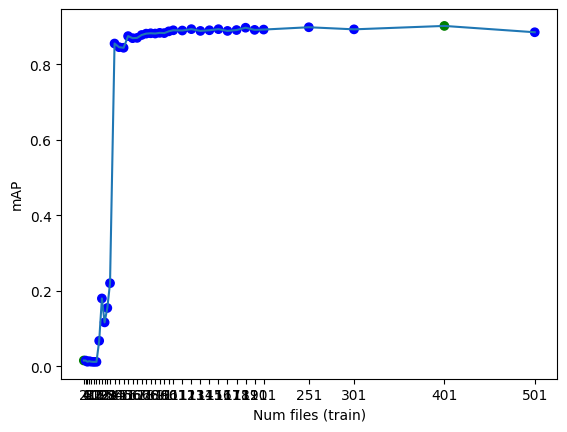

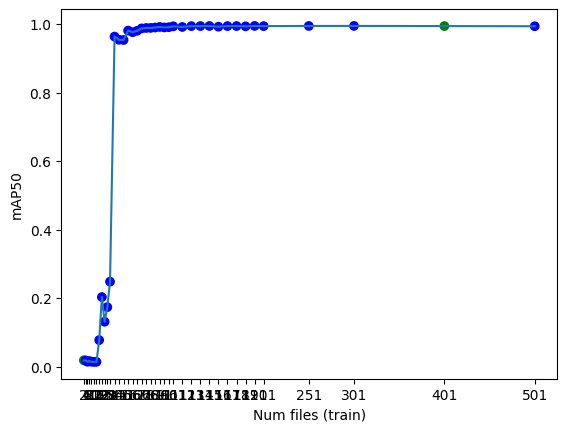

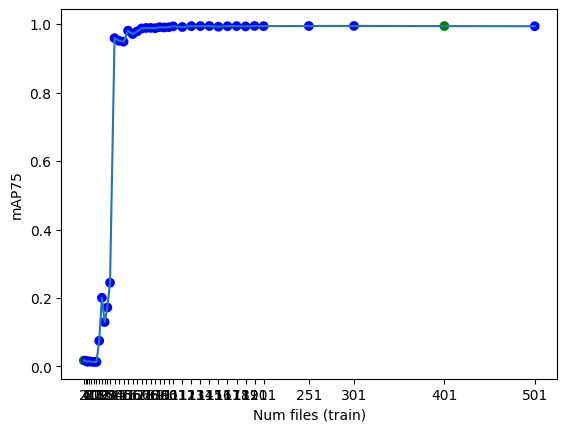

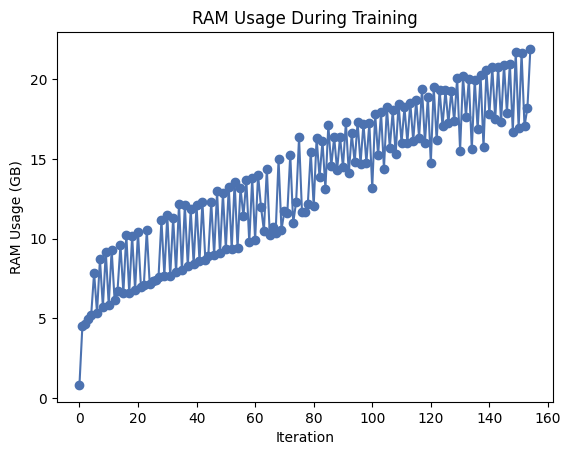

In [4]:
locale.getpreferredencoding = lambda: "UTF-8"

PATH_TO_MODEL = "/kaggle/working/yolov8m-seg.pt"
PATH_TO_YAML = "/kaggle/working/feet-14/data.yaml"
TRAIN_PERC = 0.8
TEST_PERC = 0.1
VAL_PERC = 0.1
KEEP_PERC = 1.0
PIECE_PERC = 0.05
ITERS = 5
FIB_FLAG = True
PREV_NUM = 10
THRESHOLD = 0.001

result_dict_base = dict()
result_dict_inc = dict()
color_dict_inc = dict()

exp_inc = YoloModel(PATH_TO_MODEL, PATH_TO_YAML, TRAIN_PERC, TEST_PERC, VAL_PERC)
# exp_inc.train_test_val_split(KEEP_PERC)
# cls_tl_dict, cls_fif_dict = exp_inc.take_piece(PIECE_PERC, FIB_FLAG)
exp_inc.increm_learning(KEEP_PERC, ITERS, PIECE_PERC, FIB_FLAG, PREV_NUM, THRESHOLD)
exp_inc.plot_ram_usage()

### Сравнение базового и инкрементального обучения

locale.getpreferredencoding = lambda: "UTF-8"

PATH_TO_MODEL = "/kaggle/working/yolov8m-seg.pt"
PATH_TO_YAML = "/kaggle/working/feet-14/data.yaml"
TRAIN_PERC = 0.8
TEST_PERC = 0.1
VAL_PERC = 0.1
KEEP_PERC = 1.0
PIECE_PERC = 0.05
ITERS = 5

result_dict_base = dict()
result_dict_inc = dict()
color_dict_inc = dict()

exp_base = YoloModel(PATH_TO_MODEL, PATH_TO_YAML, TRAIN_PERC, TEST_PERC, VAL_PERC)
result_dict_base = exp_base.base_learning(KEEP_PERC, PIECE_PERC, ITERS)
exp_base.plot_ram_usage()
del(exp_base)

exp_inc = YoloModel(PATH_TO_MODEL, PATH_TO_YAML, TRAIN_PERC, TEST_PERC, VAL_PERC, 1, 1)
result_dict_inc, color_dict_inc = exp_inc.increm_learning(KEEP_PERC, PIECE_PERC, ITERS)
exp_inc.plot_ram_usage()

import math 

map_base_list = [j[0] for j in result_dict_base.values()]
map_inc_list = [j[0] for j in result_dict_inc.values()]
mse = 0
for map_base, map_inc in zip(map_base_list, map_inc_list):
    dev = (map_base - map_inc)
    mse += dev**2
print(f"MSE = {mse}\nRMSE = {math.sqrt(mse)}")

metrics_names = ("mAP","mAP50", "mAP75")
for i, metric in enumerate(metrics_names):
    plt.plot(list(result_dict_base.keys()),
             [j[i] for j in result_dict_base.values()],
             marker='o',
             color="green",
             linestyle='-',
             zorder=0,
             label = "Базовое обучение")
    
    plt.scatter(list(result_dict_inc.keys()),
                [j[i] for j in result_dict_inc.values()],
                color=list(color_dict_inc.values()),
                zorder=1)
    plt.plot(list(result_dict_inc.keys()),
             [j[i] for j in result_dict_inc.values()],
             linestyle='-',
             label = "Инкрементальное обучение")
    
    plt.ylabel(metric)
    plt.xlabel("Keep percent (%)")
    plt.legend()
    plt.show()

num_folders = 1 / PIECE_PERC
for folder in range(int(num_folders)):
    dir_path = f"temp_{folder+1}/train/labels"
    print(dir_path, len([entry for entry in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, entry))]))
    dir_path = f"temp_{folder+1}/train/images"
    print(dir_path, len([entry for entry in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, entry))]))
    dir_path = f"temp_{folder+1}/valid/labels"
    print(dir_path, len([entry for entry in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, entry))]))
    dir_path = f"temp_{folder+1}/valid/images"
    print(dir_path, len([entry for entry in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, entry))]), '\n')
    
